In [23]:
per_index = pd.DataFrame(columns= ["Model","Dataset","Preprocessing","F1 (Toxic)","Precision (Toxic)","Sensitivity",
                                 "Specificity","BA","AUC-ROC","AUC-PR","MCC"])

per_index

,Model,Dataset,Preprocessing,F1 (Toxic),Precision (Toxic),Sensitivity,Specificity,BA,AUC-ROC,AUC-PR,MCC


In [24]:
import numpy as np
import torch
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import train_test_split
# from torchsummary import summary
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import torch.nn as nn
from sklearn.metrics import matthews_corrcoef
import warnings
from sklearn import metrics
import torch.nn.init as init
warnings.filterwarnings("ignore")
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score,matthews_corrcoef
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr
from sklearn.linear_model import ElasticNetCV
# from operator import itemgetter
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold,train_test_split,StratifiedKFold,KFold,cross_val_score,GroupKFold
from sklearn.feature_selection import RFE,VarianceThreshold,RFECV,SelectFromModel
from sklearn import metrics
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier,StackingClassifier,VotingClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import AdaBoostClassifier,StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
# from scipy.stats import pointbiserialr
from sklearn import preprocessing
from sklearn.base import clone
from sklearn.metrics import make_scorer,matthews_corrcoef
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV


In [20]:
import pandas as pd
from sklearn.metrics import confusion_matrix,roc_auc_score,average_precision_score
##
def performance(per_index,model_name,dataset,preprocessing,y_true,y_pred):
#     if not(per_index):
#         try:
#             per_index = pd.read_csv("performance.csv",index_col = 0)
#         except:
#             per_index = pd.DataFrame(columns= ["Model","Dataset","Preprocessing","F1 (Toxic)","Precision (Toxic)","Sensitivity",
#                                  "Specificity","BA","AUC-ROC","AUC-PR","MCC"])
#             per_index.to_csv("performance.csv",index=False)
#     else:
#         pass
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificifty = tn/(tn+fp)
    BA = (recall + specificifty)/2
    x = (fp + tp)*(fp+tn)*(tp+fn)*(tn+fn)
    mcc = (tp*tn - fp*fn) / pow(x,0.5)
    f1 =  2 * (precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_true, y_pred)
    # 计算 AUC-PR
    pr_auc = average_precision_score(y_true, y_pred)
    data = {
    "Model": model_name,
    "Dataset": dataset,
    "Preprocessing": preprocessing,
    "F1 (Toxic)": f1,
    "Precision (Toxic)": precision,
    "Sensitivity": recall,
    "Specificity": specificifty,
    "BA": BA,
    "AUC-ROC": roc_auc,
    "AUC-PR": pr_auc,
    "MCC": mcc
    }
    per_index = pd.concat([per_index, pd.DataFrame([data])], ignore_index=True)
    return per_index

In [5]:
df = pd.read_csv("data.csv",index_col=0)
df = df[df["Toxicity"] != -1]
df

,Inchi,Mol,Toxicity
0,InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...,<rdkit.Chem.rdchem.Mol object at 0x7f77e976f0b0>,0
1,InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...,<rdkit.Chem.rdchem.Mol object at 0x7f77e976f040>,0
2,InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...,<rdkit.Chem.rdchem.Mol object at 0x7f77e976f120>,0
3,InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...,<rdkit.Chem.rdchem.Mol object at 0x7f77e8a5fac0>,0
4,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...,<rdkit.Chem.rdchem.Mol object at 0x7f77e976f190>,0
...,...,...,...
6587,InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...,<rdkit.Chem.rdchem.Mol object at 0x7f77ba088eb0>,0
6588,InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...,<rdkit.Chem.rdchem.Mol object at 0x7f77ba088f20>,1
6589,"InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...",<rdkit.Chem.rdchem.Mol object at 0x7f77ba088f90>,0
6590,"InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...",<rdkit.Chem.rdchem.Mol object at 0x7f77ba086040>,0


In [6]:
df = df.reset_index()
df.drop(columns="index",inplace=True)
df

,Inchi,Mol,Toxicity
0,InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...,<rdkit.Chem.rdchem.Mol object at 0x7f77e976f0b0>,0
1,InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...,<rdkit.Chem.rdchem.Mol object at 0x7f77e976f040>,0
2,InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...,<rdkit.Chem.rdchem.Mol object at 0x7f77e976f120>,0
3,InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...,<rdkit.Chem.rdchem.Mol object at 0x7f77e8a5fac0>,0
4,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...,<rdkit.Chem.rdchem.Mol object at 0x7f77e976f190>,0
...,...,...,...
6563,InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...,<rdkit.Chem.rdchem.Mol object at 0x7f77ba088eb0>,0
6564,InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...,<rdkit.Chem.rdchem.Mol object at 0x7f77ba088f20>,1
6565,"InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...",<rdkit.Chem.rdchem.Mol object at 0x7f77ba088f90>,0
6566,"InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...",<rdkit.Chem.rdchem.Mol object at 0x7f77ba086040>,0


In [7]:
# 計算每個分子的指紋表示
num = 1
fingerprints = []
for x in df["Inchi"]:
    mol = Chem.MolFromInchi(x)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, fp_arr)
    fp_arr = np.array([int(x) for x in fp_arr], dtype=np.float32)
    fingerprints.append(fp_arr)
#     except:
#         print("Fail time : {}".format(num))
#         num = num + 1
#         pass

[02:20:13] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match; Proton balance: Does not match)

[02:20:14] WARNING: not removing hydrogen atom without neighbors
[02:20:14] WARNING: not removing hydrogen atom without neighbors


In [25]:
feature = fingerprints
feature = np.array(feature)
feature

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
feature.shape

(6568, 2048)

In [27]:
labels = df["Toxicity"]
labels = labels.values
labels = labels.astype(np.int64)

In [28]:
pd.Series(labels).value_counts()

0    5626
1     942
Name: count, dtype: int64

(1970, 2048) (1970,)


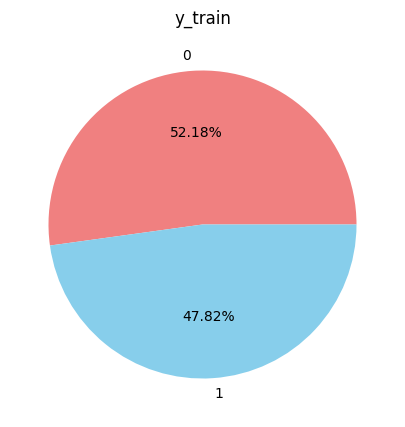

Number of components to preserve 95.0% variance: 526
Size of training set : (1379, 526)   (1379,)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
########################NB########################
 Best F1 score 0.6057906458797327 , MCC : 0.42589581769806373
Precision : 0.8192771084337349,  Recall : 0.48056537102473496
[[278  30]
 [147 136]]



        Model            Dataset Preprocessing  F1 (Toxic)  Precision (Toxic)   
0  GaussianNB  MorganFingerPrint           PCA    0.605791           0.819277  \

   Sensitivity  Specificity        BA   AUC-ROC    AUC-PR       MCC  
0     0.480565     0.902597  0.691581  0.691581  0.642447  0.425896  
Fitting 5 folds for each of 20 candidates, totalling 100 fits
########################LogisticRegression########################
Best F1 score 0.9492753623188406 , MCC : 0.9059095707699992
Precision : 0.9739776951672863,  Recall : 0.9257950530035336
[[301   7]
 [ 21 262]]



                Model            Dataset Preprocessing  F1 (

7:	learn: 0.6108229	total: 598ms	remaining: 1m 14s
8:	learn: 0.6012023	total: 643ms	remaining: 1m 10s
9:	learn: 0.5916954	total: 690ms	remaining: 1m 8s
10:	learn: 0.5828329	total: 743ms	remaining: 1m 6s
11:	learn: 0.5722553	total: 792ms	remaining: 1m 5s
12:	learn: 0.5644384	total: 843ms	remaining: 1m 3s
13:	learn: 0.5556078	total: 896ms	remaining: 1m 3s
14:	learn: 0.5488280	total: 935ms	remaining: 1m 1s
15:	learn: 0.5407432	total: 978ms	remaining: 1m
16:	learn: 0.5342313	total: 1.02s	remaining: 59s
17:	learn: 0.5265725	total: 1.07s	remaining: 58.2s
18:	learn: 0.5201036	total: 1.11s	remaining: 57.3s
19:	learn: 0.5126530	total: 1.15s	remaining: 56.6s
20:	learn: 0.5059941	total: 1.2s	remaining: 56.2s
21:	learn: 0.4995821	total: 1.25s	remaining: 55.6s
22:	learn: 0.4932637	total: 1.3s	remaining: 55.1s
23:	learn: 0.4865808	total: 1.34s	remaining: 54.5s
24:	learn: 0.4807173	total: 1.39s	remaining: 54s
25:	learn: 0.4739092	total: 1.43s	remaining: 53.7s
26:	learn: 0.4673122	total: 1.49s	remaini

170:	learn: 0.1787508	total: 8.99s	remaining: 43.6s
171:	learn: 0.1778637	total: 9.04s	remaining: 43.5s
172:	learn: 0.1774646	total: 9.09s	remaining: 43.5s
173:	learn: 0.1763984	total: 9.16s	remaining: 43.5s
174:	learn: 0.1756858	total: 9.21s	remaining: 43.4s
175:	learn: 0.1752017	total: 9.25s	remaining: 43.3s
176:	learn: 0.1746899	total: 9.3s	remaining: 43.2s
177:	learn: 0.1738938	total: 9.35s	remaining: 43.2s
178:	learn: 0.1733283	total: 9.4s	remaining: 43.1s
179:	learn: 0.1727992	total: 9.46s	remaining: 43.1s
180:	learn: 0.1723776	total: 9.51s	remaining: 43s
181:	learn: 0.1717503	total: 9.55s	remaining: 42.9s
182:	learn: 0.1712015	total: 9.6s	remaining: 42.9s
183:	learn: 0.1704126	total: 9.65s	remaining: 42.8s
184:	learn: 0.1698176	total: 9.72s	remaining: 42.8s
185:	learn: 0.1690833	total: 9.76s	remaining: 42.7s
186:	learn: 0.1684681	total: 9.81s	remaining: 42.6s
187:	learn: 0.1679499	total: 9.86s	remaining: 42.6s
188:	learn: 0.1671067	total: 9.9s	remaining: 42.5s
189:	learn: 0.1666

333:	learn: 0.1036520	total: 16.6s	remaining: 33.1s
334:	learn: 0.1034332	total: 16.7s	remaining: 33.1s
335:	learn: 0.1031436	total: 16.7s	remaining: 33s
336:	learn: 0.1028753	total: 16.7s	remaining: 32.9s
337:	learn: 0.1025876	total: 16.8s	remaining: 32.9s
338:	learn: 0.1021616	total: 16.8s	remaining: 32.8s
339:	learn: 0.1018375	total: 16.9s	remaining: 32.8s
340:	learn: 0.1013610	total: 16.9s	remaining: 32.7s
341:	learn: 0.1010177	total: 17s	remaining: 32.6s
342:	learn: 0.1005910	total: 17s	remaining: 32.6s
343:	learn: 0.1002871	total: 17.1s	remaining: 32.5s
344:	learn: 0.1000333	total: 17.1s	remaining: 32.5s
345:	learn: 0.0996751	total: 17.1s	remaining: 32.4s
346:	learn: 0.0994387	total: 17.2s	remaining: 32.3s
347:	learn: 0.0991239	total: 17.2s	remaining: 32.3s
348:	learn: 0.0988022	total: 17.3s	remaining: 32.2s
349:	learn: 0.0985614	total: 17.3s	remaining: 32.2s
350:	learn: 0.0982701	total: 17.4s	remaining: 32.1s
351:	learn: 0.0980465	total: 17.4s	remaining: 32s
352:	learn: 0.097830

492:	learn: 0.0617104	total: 23.9s	remaining: 24.6s
493:	learn: 0.0615272	total: 23.9s	remaining: 24.5s
494:	learn: 0.0614765	total: 24s	remaining: 24.5s
495:	learn: 0.0612627	total: 24s	remaining: 24.4s
496:	learn: 0.0611105	total: 24.1s	remaining: 24.4s
497:	learn: 0.0610902	total: 24.1s	remaining: 24.3s
498:	learn: 0.0609240	total: 24.2s	remaining: 24.3s
499:	learn: 0.0605437	total: 24.2s	remaining: 24.2s
500:	learn: 0.0604145	total: 24.3s	remaining: 24.2s
501:	learn: 0.0602092	total: 24.3s	remaining: 24.1s
502:	learn: 0.0598854	total: 24.4s	remaining: 24.1s
503:	learn: 0.0595864	total: 24.4s	remaining: 24s
504:	learn: 0.0593395	total: 24.4s	remaining: 24s
505:	learn: 0.0591698	total: 24.5s	remaining: 23.9s
506:	learn: 0.0590110	total: 24.5s	remaining: 23.9s
507:	learn: 0.0588753	total: 24.6s	remaining: 23.8s
508:	learn: 0.0587619	total: 24.6s	remaining: 23.8s
509:	learn: 0.0585332	total: 24.7s	remaining: 23.7s
510:	learn: 0.0585071	total: 24.7s	remaining: 23.7s
511:	learn: 0.058234

652:	learn: 0.0343217	total: 34.8s	remaining: 18.5s
653:	learn: 0.0341839	total: 34.9s	remaining: 18.4s
654:	learn: 0.0341075	total: 35s	remaining: 18.4s
655:	learn: 0.0339793	total: 35s	remaining: 18.4s
656:	learn: 0.0338541	total: 35.1s	remaining: 18.3s
657:	learn: 0.0337477	total: 35.2s	remaining: 18.3s
658:	learn: 0.0336108	total: 35.3s	remaining: 18.3s
659:	learn: 0.0335066	total: 35.4s	remaining: 18.2s
660:	learn: 0.0334017	total: 35.5s	remaining: 18.2s
661:	learn: 0.0332694	total: 35.6s	remaining: 18.2s
662:	learn: 0.0331368	total: 35.6s	remaining: 18.1s
663:	learn: 0.0330197	total: 35.8s	remaining: 18.1s
664:	learn: 0.0328964	total: 35.8s	remaining: 18.1s
665:	learn: 0.0328045	total: 35.9s	remaining: 18s
666:	learn: 0.0327266	total: 36s	remaining: 18s
667:	learn: 0.0325842	total: 36.1s	remaining: 17.9s
668:	learn: 0.0324806	total: 36.2s	remaining: 17.9s
669:	learn: 0.0323475	total: 36.3s	remaining: 17.9s
670:	learn: 0.0322884	total: 36.3s	remaining: 17.8s
671:	learn: 0.0321675	

813:	learn: 0.0202735	total: 49.2s	remaining: 11.3s
814:	learn: 0.0202131	total: 49.3s	remaining: 11.2s
815:	learn: 0.0201402	total: 49.4s	remaining: 11.1s
816:	learn: 0.0200506	total: 49.5s	remaining: 11.1s
817:	learn: 0.0199898	total: 49.6s	remaining: 11s
818:	learn: 0.0199183	total: 49.7s	remaining: 11s
819:	learn: 0.0198654	total: 49.8s	remaining: 10.9s
820:	learn: 0.0198106	total: 49.9s	remaining: 10.9s
821:	learn: 0.0197391	total: 50s	remaining: 10.8s
822:	learn: 0.0196732	total: 50.1s	remaining: 10.8s
823:	learn: 0.0196192	total: 50.2s	remaining: 10.7s
824:	learn: 0.0195789	total: 50.3s	remaining: 10.7s
825:	learn: 0.0195287	total: 50.4s	remaining: 10.6s
826:	learn: 0.0194645	total: 50.5s	remaining: 10.6s
827:	learn: 0.0194071	total: 50.6s	remaining: 10.5s
828:	learn: 0.0193171	total: 50.7s	remaining: 10.4s
829:	learn: 0.0192841	total: 50.8s	remaining: 10.4s
830:	learn: 0.0192417	total: 50.9s	remaining: 10.3s
831:	learn: 0.0191798	total: 50.9s	remaining: 10.3s
832:	learn: 0.0191

975:	learn: 0.0131251	total: 1m 4s	remaining: 1.58s
976:	learn: 0.0130946	total: 1m 4s	remaining: 1.52s
977:	learn: 0.0130740	total: 1m 4s	remaining: 1.45s
978:	learn: 0.0130463	total: 1m 4s	remaining: 1.39s
979:	learn: 0.0130110	total: 1m 4s	remaining: 1.32s
980:	learn: 0.0129892	total: 1m 4s	remaining: 1.25s
981:	learn: 0.0129604	total: 1m 4s	remaining: 1.19s
982:	learn: 0.0129374	total: 1m 4s	remaining: 1.12s
983:	learn: 0.0129146	total: 1m 5s	remaining: 1.06s
984:	learn: 0.0128821	total: 1m 5s	remaining: 991ms
985:	learn: 0.0128534	total: 1m 5s	remaining: 926ms
986:	learn: 0.0128247	total: 1m 5s	remaining: 860ms
987:	learn: 0.0127975	total: 1m 5s	remaining: 793ms
988:	learn: 0.0127629	total: 1m 5s	remaining: 727ms
989:	learn: 0.0127411	total: 1m 5s	remaining: 661ms
990:	learn: 0.0127040	total: 1m 5s	remaining: 595ms
991:	learn: 0.0126785	total: 1m 5s	remaining: 529ms
992:	learn: 0.0126558	total: 1m 5s	remaining: 463ms
993:	learn: 0.0126278	total: 1m 5s	remaining: 397ms
994:	learn: 

133:	learn: 0.2036148	total: 14.7s	remaining: 1m 34s
134:	learn: 0.2025737	total: 14.8s	remaining: 1m 34s
135:	learn: 0.2020660	total: 14.8s	remaining: 1m 34s
136:	learn: 0.2010400	total: 14.9s	remaining: 1m 34s
137:	learn: 0.2002356	total: 15s	remaining: 1m 33s
138:	learn: 0.1992302	total: 15.1s	remaining: 1m 33s
139:	learn: 0.1986270	total: 15.2s	remaining: 1m 33s
140:	learn: 0.1978848	total: 15.4s	remaining: 1m 33s
141:	learn: 0.1972140	total: 15.4s	remaining: 1m 33s
142:	learn: 0.1963418	total: 15.5s	remaining: 1m 33s
143:	learn: 0.1955717	total: 15.7s	remaining: 1m 33s
144:	learn: 0.1950069	total: 15.7s	remaining: 1m 32s
145:	learn: 0.1937283	total: 15.8s	remaining: 1m 32s
146:	learn: 0.1929093	total: 15.9s	remaining: 1m 32s
147:	learn: 0.1920498	total: 16s	remaining: 1m 32s
148:	learn: 0.1913697	total: 16.1s	remaining: 1m 32s
149:	learn: 0.1907226	total: 16.2s	remaining: 1m 31s
150:	learn: 0.1901537	total: 16.4s	remaining: 1m 32s
151:	learn: 0.1890988	total: 16.5s	remaining: 1m 3

290:	learn: 0.1151100	total: 29.8s	remaining: 1m 12s
291:	learn: 0.1148847	total: 29.9s	remaining: 1m 12s
292:	learn: 0.1145672	total: 30s	remaining: 1m 12s
293:	learn: 0.1142391	total: 30.1s	remaining: 1m 12s
294:	learn: 0.1139061	total: 30.2s	remaining: 1m 12s
295:	learn: 0.1136118	total: 30.3s	remaining: 1m 11s
296:	learn: 0.1133802	total: 30.4s	remaining: 1m 11s
297:	learn: 0.1128996	total: 30.5s	remaining: 1m 11s
298:	learn: 0.1126955	total: 30.6s	remaining: 1m 11s
299:	learn: 0.1124663	total: 30.6s	remaining: 1m 11s
300:	learn: 0.1120619	total: 30.8s	remaining: 1m 11s
301:	learn: 0.1112833	total: 30.9s	remaining: 1m 11s
302:	learn: 0.1109552	total: 31s	remaining: 1m 11s
303:	learn: 0.1106589	total: 31.1s	remaining: 1m 11s
304:	learn: 0.1102902	total: 31.1s	remaining: 1m 10s
305:	learn: 0.1099647	total: 31.2s	remaining: 1m 10s
306:	learn: 0.1096977	total: 31.3s	remaining: 1m 10s
307:	learn: 0.1094356	total: 31.4s	remaining: 1m 10s
308:	learn: 0.1090604	total: 31.5s	remaining: 1m 1

450:	learn: 0.0691358	total: 45s	remaining: 54.8s
451:	learn: 0.0688999	total: 45.1s	remaining: 54.7s
452:	learn: 0.0687144	total: 45.2s	remaining: 54.6s
453:	learn: 0.0684424	total: 45.3s	remaining: 54.4s
454:	learn: 0.0682216	total: 45.3s	remaining: 54.3s
455:	learn: 0.0678642	total: 45.5s	remaining: 54.2s
456:	learn: 0.0676732	total: 45.5s	remaining: 54.1s
457:	learn: 0.0673855	total: 45.6s	remaining: 54s
458:	learn: 0.0671557	total: 45.7s	remaining: 53.9s
459:	learn: 0.0669370	total: 45.8s	remaining: 53.8s
460:	learn: 0.0667118	total: 45.9s	remaining: 53.6s
461:	learn: 0.0665605	total: 46s	remaining: 53.5s
462:	learn: 0.0664607	total: 46s	remaining: 53.4s
463:	learn: 0.0662083	total: 46.1s	remaining: 53.3s
464:	learn: 0.0660456	total: 46.2s	remaining: 53.2s
465:	learn: 0.0657513	total: 46.3s	remaining: 53.1s
466:	learn: 0.0657187	total: 46.4s	remaining: 52.9s
467:	learn: 0.0654563	total: 46.5s	remaining: 52.8s
468:	learn: 0.0654193	total: 46.6s	remaining: 52.7s
469:	learn: 0.065342

610:	learn: 0.0394684	total: 1m	remaining: 38.2s
611:	learn: 0.0393093	total: 1m	remaining: 38.1s
612:	learn: 0.0391449	total: 1m	remaining: 38s
613:	learn: 0.0389561	total: 1m	remaining: 37.9s
614:	learn: 0.0388353	total: 1m	remaining: 37.9s
615:	learn: 0.0386847	total: 1m	remaining: 37.8s
616:	learn: 0.0385208	total: 1m	remaining: 37.7s
617:	learn: 0.0384009	total: 1m	remaining: 37.5s
618:	learn: 0.0381987	total: 1m	remaining: 37.4s
619:	learn: 0.0381843	total: 1m	remaining: 37.3s
620:	learn: 0.0380627	total: 1m	remaining: 37.2s
621:	learn: 0.0380465	total: 1m 1s	remaining: 37.1s
622:	learn: 0.0379009	total: 1m 1s	remaining: 37s
623:	learn: 0.0376714	total: 1m 1s	remaining: 37s
624:	learn: 0.0376398	total: 1m 1s	remaining: 36.8s
625:	learn: 0.0376245	total: 1m 1s	remaining: 36.7s
626:	learn: 0.0374616	total: 1m 1s	remaining: 36.7s
627:	learn: 0.0373504	total: 1m 1s	remaining: 36.6s
628:	learn: 0.0371761	total: 1m 1s	remaining: 36.5s
629:	learn: 0.0369752	total: 1m 1s	remaining: 36.4s

768:	learn: 0.0231737	total: 1m 15s	remaining: 22.6s
769:	learn: 0.0230962	total: 1m 15s	remaining: 22.5s
770:	learn: 0.0230090	total: 1m 15s	remaining: 22.4s
771:	learn: 0.0229417	total: 1m 15s	remaining: 22.3s
772:	learn: 0.0228353	total: 1m 15s	remaining: 22.2s
773:	learn: 0.0228007	total: 1m 15s	remaining: 22.1s
774:	learn: 0.0227273	total: 1m 15s	remaining: 22s
775:	learn: 0.0226410	total: 1m 15s	remaining: 21.9s
776:	learn: 0.0225654	total: 1m 15s	remaining: 21.8s
777:	learn: 0.0225068	total: 1m 15s	remaining: 21.7s
778:	learn: 0.0224460	total: 1m 16s	remaining: 21.6s
779:	learn: 0.0224250	total: 1m 16s	remaining: 21.5s
780:	learn: 0.0223497	total: 1m 16s	remaining: 21.4s
781:	learn: 0.0222735	total: 1m 16s	remaining: 21.3s
782:	learn: 0.0222049	total: 1m 16s	remaining: 21.2s
783:	learn: 0.0221542	total: 1m 16s	remaining: 21.1s
784:	learn: 0.0220878	total: 1m 16s	remaining: 21s
785:	learn: 0.0220053	total: 1m 16s	remaining: 20.9s
786:	learn: 0.0219729	total: 1m 16s	remaining: 20.

926:	learn: 0.0149225	total: 1m 29s	remaining: 7.09s
927:	learn: 0.0148772	total: 1m 30s	remaining: 6.99s
928:	learn: 0.0148278	total: 1m 30s	remaining: 6.89s
929:	learn: 0.0147859	total: 1m 30s	remaining: 6.79s
930:	learn: 0.0147430	total: 1m 30s	remaining: 6.7s
931:	learn: 0.0146912	total: 1m 30s	remaining: 6.6s
932:	learn: 0.0146620	total: 1m 30s	remaining: 6.5s
933:	learn: 0.0146134	total: 1m 30s	remaining: 6.41s
934:	learn: 0.0145630	total: 1m 30s	remaining: 6.31s
935:	learn: 0.0145380	total: 1m 30s	remaining: 6.21s
936:	learn: 0.0144925	total: 1m 30s	remaining: 6.11s
937:	learn: 0.0144675	total: 1m 31s	remaining: 6.02s
938:	learn: 0.0144227	total: 1m 31s	remaining: 5.92s
939:	learn: 0.0143791	total: 1m 31s	remaining: 5.82s
940:	learn: 0.0143410	total: 1m 31s	remaining: 5.72s
941:	learn: 0.0143039	total: 1m 31s	remaining: 5.63s
942:	learn: 0.0142643	total: 1m 31s	remaining: 5.53s
943:	learn: 0.0142351	total: 1m 31s	remaining: 5.43s
944:	learn: 0.0141913	total: 1m 31s	remaining: 5.

84:	learn: 0.2680406	total: 7.82s	remaining: 1m 24s
85:	learn: 0.2665803	total: 7.93s	remaining: 1m 24s
86:	learn: 0.2645879	total: 8.02s	remaining: 1m 24s
87:	learn: 0.2633542	total: 8.13s	remaining: 1m 24s
88:	learn: 0.2616756	total: 8.19s	remaining: 1m 23s
89:	learn: 0.2598758	total: 8.28s	remaining: 1m 23s
90:	learn: 0.2580828	total: 8.38s	remaining: 1m 23s
91:	learn: 0.2563399	total: 8.47s	remaining: 1m 23s
92:	learn: 0.2541355	total: 8.55s	remaining: 1m 23s
93:	learn: 0.2521231	total: 8.64s	remaining: 1m 23s
94:	learn: 0.2503410	total: 8.73s	remaining: 1m 23s
95:	learn: 0.2492077	total: 8.79s	remaining: 1m 22s
96:	learn: 0.2480397	total: 8.89s	remaining: 1m 22s
97:	learn: 0.2465739	total: 8.98s	remaining: 1m 22s
98:	learn: 0.2452168	total: 9.07s	remaining: 1m 22s
99:	learn: 0.2437542	total: 9.15s	remaining: 1m 22s
100:	learn: 0.2424547	total: 9.25s	remaining: 1m 22s
101:	learn: 0.2408032	total: 9.36s	remaining: 1m 22s
102:	learn: 0.2391683	total: 9.47s	remaining: 1m 22s
103:	lear

240:	learn: 0.1376020	total: 25.3s	remaining: 1m 19s
241:	learn: 0.1372854	total: 25.4s	remaining: 1m 19s
242:	learn: 0.1368356	total: 25.6s	remaining: 1m 19s
243:	learn: 0.1361111	total: 25.7s	remaining: 1m 19s
244:	learn: 0.1356622	total: 25.8s	remaining: 1m 19s
245:	learn: 0.1353698	total: 25.9s	remaining: 1m 19s
246:	learn: 0.1348113	total: 26.1s	remaining: 1m 19s
247:	learn: 0.1344092	total: 26.2s	remaining: 1m 19s
248:	learn: 0.1340308	total: 26.3s	remaining: 1m 19s
249:	learn: 0.1336887	total: 26.4s	remaining: 1m 19s
250:	learn: 0.1331999	total: 26.5s	remaining: 1m 19s
251:	learn: 0.1328528	total: 26.6s	remaining: 1m 18s
252:	learn: 0.1323275	total: 26.7s	remaining: 1m 18s
253:	learn: 0.1318114	total: 26.9s	remaining: 1m 18s
254:	learn: 0.1314066	total: 27s	remaining: 1m 18s
255:	learn: 0.1311487	total: 27.1s	remaining: 1m 18s
256:	learn: 0.1307769	total: 27.2s	remaining: 1m 18s
257:	learn: 0.1304588	total: 27.3s	remaining: 1m 18s
258:	learn: 0.1301135	total: 27.3s	remaining: 1m

398:	learn: 0.0824440	total: 40.2s	remaining: 1m
399:	learn: 0.0822422	total: 40.3s	remaining: 1m
400:	learn: 0.0820426	total: 40.4s	remaining: 1m
401:	learn: 0.0817827	total: 40.5s	remaining: 1m
402:	learn: 0.0814272	total: 40.6s	remaining: 1m
403:	learn: 0.0813061	total: 40.7s	remaining: 1m
404:	learn: 0.0810432	total: 40.8s	remaining: 59.9s
405:	learn: 0.0808379	total: 40.9s	remaining: 59.8s
406:	learn: 0.0805364	total: 41s	remaining: 59.7s
407:	learn: 0.0803185	total: 41s	remaining: 59.5s
408:	learn: 0.0800570	total: 41.1s	remaining: 59.4s
409:	learn: 0.0797574	total: 41.2s	remaining: 59.3s
410:	learn: 0.0794053	total: 41.3s	remaining: 59.2s
411:	learn: 0.0790545	total: 41.4s	remaining: 59.1s
412:	learn: 0.0788943	total: 41.5s	remaining: 59s
413:	learn: 0.0787095	total: 41.6s	remaining: 58.9s
414:	learn: 0.0783650	total: 41.7s	remaining: 58.8s
415:	learn: 0.0780111	total: 41.8s	remaining: 58.7s
416:	learn: 0.0779502	total: 41.9s	remaining: 58.6s
417:	learn: 0.0775306	total: 42s	rem

558:	learn: 0.0465344	total: 56.8s	remaining: 44.8s
559:	learn: 0.0463604	total: 56.9s	remaining: 44.7s
560:	learn: 0.0462052	total: 57s	remaining: 44.6s
561:	learn: 0.0459730	total: 57.1s	remaining: 44.5s
562:	learn: 0.0457665	total: 57.3s	remaining: 44.4s
563:	learn: 0.0456158	total: 57.4s	remaining: 44.4s
564:	learn: 0.0454572	total: 57.5s	remaining: 44.3s
565:	learn: 0.0452662	total: 57.6s	remaining: 44.2s
566:	learn: 0.0450940	total: 57.7s	remaining: 44.1s
567:	learn: 0.0450372	total: 57.8s	remaining: 44s
568:	learn: 0.0448570	total: 58s	remaining: 43.9s
569:	learn: 0.0447188	total: 58.1s	remaining: 43.8s
570:	learn: 0.0445729	total: 58.2s	remaining: 43.7s
571:	learn: 0.0444025	total: 58.3s	remaining: 43.6s
572:	learn: 0.0441897	total: 58.4s	remaining: 43.5s
573:	learn: 0.0439899	total: 58.5s	remaining: 43.4s
574:	learn: 0.0437959	total: 58.6s	remaining: 43.3s
575:	learn: 0.0436472	total: 58.6s	remaining: 43.2s
576:	learn: 0.0435111	total: 58.7s	remaining: 43s
577:	learn: 0.043390

717:	learn: 0.0262579	total: 1m 13s	remaining: 28.8s
718:	learn: 0.0261888	total: 1m 13s	remaining: 28.7s
719:	learn: 0.0260850	total: 1m 13s	remaining: 28.6s
720:	learn: 0.0259986	total: 1m 13s	remaining: 28.5s
721:	learn: 0.0259187	total: 1m 13s	remaining: 28.4s
722:	learn: 0.0258111	total: 1m 13s	remaining: 28.3s
723:	learn: 0.0257335	total: 1m 14s	remaining: 28.2s
724:	learn: 0.0256305	total: 1m 14s	remaining: 28.1s
725:	learn: 0.0255372	total: 1m 14s	remaining: 28s
726:	learn: 0.0254568	total: 1m 14s	remaining: 27.9s
727:	learn: 0.0253852	total: 1m 14s	remaining: 27.8s
728:	learn: 0.0252767	total: 1m 14s	remaining: 27.7s
729:	learn: 0.0252197	total: 1m 14s	remaining: 27.6s
730:	learn: 0.0251299	total: 1m 14s	remaining: 27.5s
731:	learn: 0.0250278	total: 1m 14s	remaining: 27.4s
732:	learn: 0.0249443	total: 1m 14s	remaining: 27.3s
733:	learn: 0.0248417	total: 1m 14s	remaining: 27.2s
734:	learn: 0.0247501	total: 1m 15s	remaining: 27s
735:	learn: 0.0246504	total: 1m 15s	remaining: 26.

874:	learn: 0.0163741	total: 1m 28s	remaining: 12.6s
875:	learn: 0.0163028	total: 1m 28s	remaining: 12.5s
876:	learn: 0.0162707	total: 1m 28s	remaining: 12.4s
877:	learn: 0.0162243	total: 1m 28s	remaining: 12.3s
878:	learn: 0.0161759	total: 1m 28s	remaining: 12.2s
879:	learn: 0.0161540	total: 1m 28s	remaining: 12.1s
880:	learn: 0.0161196	total: 1m 28s	remaining: 12s
881:	learn: 0.0160749	total: 1m 29s	remaining: 11.9s
882:	learn: 0.0160242	total: 1m 29s	remaining: 11.8s
883:	learn: 0.0159881	total: 1m 29s	remaining: 11.7s
884:	learn: 0.0159348	total: 1m 29s	remaining: 11.6s
885:	learn: 0.0159095	total: 1m 29s	remaining: 11.5s
886:	learn: 0.0158676	total: 1m 29s	remaining: 11.4s
887:	learn: 0.0158370	total: 1m 29s	remaining: 11.3s
888:	learn: 0.0157822	total: 1m 29s	remaining: 11.2s
889:	learn: 0.0157492	total: 1m 29s	remaining: 11.1s
890:	learn: 0.0157034	total: 1m 29s	remaining: 11s
891:	learn: 0.0156378	total: 1m 29s	remaining: 10.9s
892:	learn: 0.0155823	total: 1m 30s	remaining: 10.

32:	learn: 0.4253271	total: 3.1s	remaining: 1m 30s
33:	learn: 0.4211188	total: 3.21s	remaining: 1m 31s
34:	learn: 0.4165063	total: 3.3s	remaining: 1m 31s
35:	learn: 0.4117815	total: 3.39s	remaining: 1m 30s
36:	learn: 0.4068311	total: 3.49s	remaining: 1m 30s
37:	learn: 0.4022510	total: 3.59s	remaining: 1m 30s
38:	learn: 0.3970243	total: 3.69s	remaining: 1m 30s
39:	learn: 0.3930393	total: 3.76s	remaining: 1m 30s
40:	learn: 0.3886351	total: 3.84s	remaining: 1m 29s
41:	learn: 0.3847166	total: 3.93s	remaining: 1m 29s
42:	learn: 0.3797539	total: 4.02s	remaining: 1m 29s
43:	learn: 0.3759637	total: 4.13s	remaining: 1m 29s
44:	learn: 0.3720995	total: 4.25s	remaining: 1m 30s
45:	learn: 0.3677968	total: 4.34s	remaining: 1m 30s
46:	learn: 0.3637484	total: 4.42s	remaining: 1m 29s
47:	learn: 0.3592712	total: 4.51s	remaining: 1m 29s
48:	learn: 0.3551089	total: 4.59s	remaining: 1m 29s
49:	learn: 0.3514978	total: 4.72s	remaining: 1m 29s
50:	learn: 0.3476899	total: 4.84s	remaining: 1m 29s
51:	learn: 0.3

191:	learn: 0.1556376	total: 18.1s	remaining: 1m 16s
192:	learn: 0.1551332	total: 18.2s	remaining: 1m 16s
193:	learn: 0.1546689	total: 18.3s	remaining: 1m 16s
194:	learn: 0.1541020	total: 18.4s	remaining: 1m 16s
195:	learn: 0.1535982	total: 18.5s	remaining: 1m 16s
196:	learn: 0.1528589	total: 18.6s	remaining: 1m 15s
197:	learn: 0.1524059	total: 18.7s	remaining: 1m 15s
198:	learn: 0.1519622	total: 18.8s	remaining: 1m 15s
199:	learn: 0.1514454	total: 18.8s	remaining: 1m 15s
200:	learn: 0.1509270	total: 19s	remaining: 1m 15s
201:	learn: 0.1504048	total: 19s	remaining: 1m 15s
202:	learn: 0.1497461	total: 19.2s	remaining: 1m 15s
203:	learn: 0.1493321	total: 19.3s	remaining: 1m 15s
204:	learn: 0.1485863	total: 19.4s	remaining: 1m 15s
205:	learn: 0.1479401	total: 19.5s	remaining: 1m 15s
206:	learn: 0.1474261	total: 19.6s	remaining: 1m 15s
207:	learn: 0.1469920	total: 19.7s	remaining: 1m 14s
208:	learn: 0.1465337	total: 19.7s	remaining: 1m 14s
209:	learn: 0.1459332	total: 19.9s	remaining: 1m 1

349:	learn: 0.0901957	total: 33.2s	remaining: 1m 1s
350:	learn: 0.0898980	total: 33.4s	remaining: 1m 1s
351:	learn: 0.0896246	total: 33.5s	remaining: 1m 1s
352:	learn: 0.0894119	total: 33.6s	remaining: 1m 1s
353:	learn: 0.0891822	total: 33.6s	remaining: 1m 1s
354:	learn: 0.0889255	total: 33.7s	remaining: 1m 1s
355:	learn: 0.0887333	total: 33.8s	remaining: 1m 1s
356:	learn: 0.0885223	total: 33.9s	remaining: 1m 1s
357:	learn: 0.0882316	total: 34s	remaining: 1m
358:	learn: 0.0877977	total: 34.1s	remaining: 1m
359:	learn: 0.0875093	total: 34.2s	remaining: 1m
360:	learn: 0.0872791	total: 34.3s	remaining: 1m
361:	learn: 0.0869636	total: 34.3s	remaining: 1m
362:	learn: 0.0866267	total: 34.4s	remaining: 1m
363:	learn: 0.0863221	total: 34.5s	remaining: 1m
364:	learn: 0.0859688	total: 34.6s	remaining: 1m
365:	learn: 0.0857278	total: 34.7s	remaining: 1m
366:	learn: 0.0853463	total: 34.8s	remaining: 60s
367:	learn: 0.0849696	total: 34.9s	remaining: 59.9s
368:	learn: 0.0846241	total: 35s	remaining:

510:	learn: 0.0520244	total: 48.3s	remaining: 46.2s
511:	learn: 0.0517981	total: 48.4s	remaining: 46.1s
512:	learn: 0.0515906	total: 48.5s	remaining: 46s
513:	learn: 0.0514083	total: 48.6s	remaining: 45.9s
514:	learn: 0.0512038	total: 48.6s	remaining: 45.8s
515:	learn: 0.0509780	total: 48.7s	remaining: 45.7s
516:	learn: 0.0507719	total: 48.8s	remaining: 45.6s
517:	learn: 0.0504530	total: 48.9s	remaining: 45.5s
518:	learn: 0.0502393	total: 49s	remaining: 45.4s
519:	learn: 0.0500750	total: 49.1s	remaining: 45.3s
520:	learn: 0.0498479	total: 49.2s	remaining: 45.2s
521:	learn: 0.0496414	total: 49.3s	remaining: 45.1s
522:	learn: 0.0494311	total: 49.4s	remaining: 45s
523:	learn: 0.0492493	total: 49.5s	remaining: 45s
524:	learn: 0.0490718	total: 49.6s	remaining: 44.9s
525:	learn: 0.0488286	total: 49.7s	remaining: 44.8s
526:	learn: 0.0485164	total: 49.8s	remaining: 44.7s
527:	learn: 0.0483194	total: 49.9s	remaining: 44.6s
528:	learn: 0.0481296	total: 49.9s	remaining: 44.5s
529:	learn: 0.047979

672:	learn: 0.0281688	total: 1m 3s	remaining: 30.8s
673:	learn: 0.0280700	total: 1m 3s	remaining: 30.7s
674:	learn: 0.0279729	total: 1m 3s	remaining: 30.6s
675:	learn: 0.0278582	total: 1m 3s	remaining: 30.5s
676:	learn: 0.0277514	total: 1m 3s	remaining: 30.4s
677:	learn: 0.0276388	total: 1m 3s	remaining: 30.3s
678:	learn: 0.0275466	total: 1m 3s	remaining: 30.2s
679:	learn: 0.0274553	total: 1m 4s	remaining: 30.1s
680:	learn: 0.0273718	total: 1m 4s	remaining: 30s
681:	learn: 0.0272796	total: 1m 4s	remaining: 29.9s
682:	learn: 0.0271372	total: 1m 4s	remaining: 29.8s
683:	learn: 0.0270643	total: 1m 4s	remaining: 29.7s
684:	learn: 0.0269508	total: 1m 4s	remaining: 29.6s
685:	learn: 0.0268403	total: 1m 4s	remaining: 29.5s
686:	learn: 0.0267140	total: 1m 4s	remaining: 29.4s
687:	learn: 0.0265833	total: 1m 4s	remaining: 29.3s
688:	learn: 0.0265087	total: 1m 4s	remaining: 29.2s
689:	learn: 0.0264028	total: 1m 4s	remaining: 29.1s
690:	learn: 0.0263122	total: 1m 4s	remaining: 29.1s
691:	learn: 0.

830:	learn: 0.0174802	total: 1m 18s	remaining: 15.9s
831:	learn: 0.0174442	total: 1m 18s	remaining: 15.8s
832:	learn: 0.0174096	total: 1m 18s	remaining: 15.8s
833:	learn: 0.0173532	total: 1m 18s	remaining: 15.7s
834:	learn: 0.0173047	total: 1m 18s	remaining: 15.6s
835:	learn: 0.0172661	total: 1m 18s	remaining: 15.5s
836:	learn: 0.0172275	total: 1m 18s	remaining: 15.4s
837:	learn: 0.0171920	total: 1m 19s	remaining: 15.3s
838:	learn: 0.0171294	total: 1m 19s	remaining: 15.2s
839:	learn: 0.0170740	total: 1m 19s	remaining: 15.1s
840:	learn: 0.0170222	total: 1m 19s	remaining: 15s
841:	learn: 0.0169826	total: 1m 19s	remaining: 14.9s
842:	learn: 0.0169410	total: 1m 19s	remaining: 14.8s
843:	learn: 0.0168950	total: 1m 19s	remaining: 14.7s
844:	learn: 0.0168410	total: 1m 19s	remaining: 14.6s
845:	learn: 0.0168051	total: 1m 19s	remaining: 14.5s
846:	learn: 0.0167743	total: 1m 19s	remaining: 14.4s
847:	learn: 0.0167146	total: 1m 19s	remaining: 14.3s
848:	learn: 0.0166867	total: 1m 20s	remaining: 1

985:	learn: 0.0117415	total: 1m 33s	remaining: 1.32s
986:	learn: 0.0117222	total: 1m 33s	remaining: 1.23s
987:	learn: 0.0116984	total: 1m 33s	remaining: 1.13s
988:	learn: 0.0116686	total: 1m 33s	remaining: 1.04s
989:	learn: 0.0116435	total: 1m 33s	remaining: 945ms
990:	learn: 0.0116277	total: 1m 33s	remaining: 851ms
991:	learn: 0.0116112	total: 1m 33s	remaining: 757ms
992:	learn: 0.0115834	total: 1m 33s	remaining: 662ms
993:	learn: 0.0115585	total: 1m 33s	remaining: 567ms
994:	learn: 0.0115262	total: 1m 34s	remaining: 473ms
995:	learn: 0.0114986	total: 1m 34s	remaining: 378ms
996:	learn: 0.0114740	total: 1m 34s	remaining: 284ms
997:	learn: 0.0114397	total: 1m 34s	remaining: 189ms
998:	learn: 0.0114189	total: 1m 34s	remaining: 94.6ms
999:	learn: 0.0113901	total: 1m 34s	remaining: 0us
0:	learn: 0.6807773	total: 118ms	remaining: 1m 57s
1:	learn: 0.6704491	total: 195ms	remaining: 1m 37s
2:	learn: 0.6597250	total: 291ms	remaining: 1m 36s
3:	learn: 0.6476956	total: 402ms	remaining: 1m 40s
4:

145:	learn: 0.1908574	total: 14s	remaining: 1m 21s
146:	learn: 0.1896127	total: 14.1s	remaining: 1m 21s
147:	learn: 0.1887879	total: 14.2s	remaining: 1m 21s
148:	learn: 0.1881749	total: 14.3s	remaining: 1m 21s
149:	learn: 0.1875432	total: 14.4s	remaining: 1m 21s
150:	learn: 0.1869483	total: 14.5s	remaining: 1m 21s
151:	learn: 0.1858620	total: 14.6s	remaining: 1m 21s
152:	learn: 0.1851394	total: 14.7s	remaining: 1m 21s
153:	learn: 0.1843749	total: 14.7s	remaining: 1m 21s
154:	learn: 0.1838760	total: 14.9s	remaining: 1m 21s
155:	learn: 0.1833420	total: 15s	remaining: 1m 20s
156:	learn: 0.1823821	total: 15.1s	remaining: 1m 20s
157:	learn: 0.1814201	total: 15.2s	remaining: 1m 20s
158:	learn: 0.1807769	total: 15.2s	remaining: 1m 20s
159:	learn: 0.1799275	total: 15.3s	remaining: 1m 20s
160:	learn: 0.1791745	total: 15.4s	remaining: 1m 20s
161:	learn: 0.1784022	total: 15.5s	remaining: 1m 20s
162:	learn: 0.1778365	total: 15.7s	remaining: 1m 20s
163:	learn: 0.1770397	total: 15.7s	remaining: 1m 2

301:	learn: 0.1102609	total: 28.9s	remaining: 1m 6s
302:	learn: 0.1100161	total: 29s	remaining: 1m 6s
303:	learn: 0.1097234	total: 29.1s	remaining: 1m 6s
304:	learn: 0.1094360	total: 29.2s	remaining: 1m 6s
305:	learn: 0.1089660	total: 29.3s	remaining: 1m 6s
306:	learn: 0.1086263	total: 29.4s	remaining: 1m 6s
307:	learn: 0.1083413	total: 29.5s	remaining: 1m 6s
308:	learn: 0.1079551	total: 29.6s	remaining: 1m 6s
309:	learn: 0.1075444	total: 29.6s	remaining: 1m 5s
310:	learn: 0.1072845	total: 29.8s	remaining: 1m 5s
311:	learn: 0.1071740	total: 29.8s	remaining: 1m 5s
312:	learn: 0.1065507	total: 29.9s	remaining: 1m 5s
313:	learn: 0.1062431	total: 30s	remaining: 1m 5s
314:	learn: 0.1058417	total: 30.1s	remaining: 1m 5s
315:	learn: 0.1055988	total: 30.2s	remaining: 1m 5s
316:	learn: 0.1052954	total: 30.3s	remaining: 1m 5s
317:	learn: 0.1050128	total: 30.4s	remaining: 1m 5s
318:	learn: 0.1047474	total: 30.5s	remaining: 1m 5s
319:	learn: 0.1045217	total: 30.6s	remaining: 1m 4s
320:	learn: 0.10

463:	learn: 0.0648105	total: 44.1s	remaining: 51s
464:	learn: 0.0644844	total: 44.2s	remaining: 50.9s
465:	learn: 0.0642009	total: 44.3s	remaining: 50.8s
466:	learn: 0.0639914	total: 44.4s	remaining: 50.7s
467:	learn: 0.0637572	total: 44.5s	remaining: 50.6s
468:	learn: 0.0634460	total: 44.6s	remaining: 50.5s
469:	learn: 0.0631304	total: 44.7s	remaining: 50.4s
470:	learn: 0.0629328	total: 44.8s	remaining: 50.3s
471:	learn: 0.0627296	total: 44.9s	remaining: 50.2s
472:	learn: 0.0624482	total: 45s	remaining: 50.1s
473:	learn: 0.0623202	total: 45s	remaining: 50s
474:	learn: 0.0622261	total: 45.1s	remaining: 49.9s
475:	learn: 0.0619808	total: 45.2s	remaining: 49.8s
476:	learn: 0.0617731	total: 45.3s	remaining: 49.7s
477:	learn: 0.0615576	total: 45.4s	remaining: 49.6s
478:	learn: 0.0612874	total: 45.5s	remaining: 49.5s
479:	learn: 0.0610559	total: 45.6s	remaining: 49.4s
480:	learn: 0.0608452	total: 45.7s	remaining: 49.3s
481:	learn: 0.0606712	total: 45.8s	remaining: 49.2s
482:	learn: 0.060504

624:	learn: 0.0356056	total: 58.6s	remaining: 35.1s
625:	learn: 0.0354927	total: 58.6s	remaining: 35s
626:	learn: 0.0354025	total: 58.7s	remaining: 34.9s
627:	learn: 0.0352628	total: 58.8s	remaining: 34.8s
628:	learn: 0.0351555	total: 58.9s	remaining: 34.7s
629:	learn: 0.0350230	total: 58.9s	remaining: 34.6s
630:	learn: 0.0348926	total: 59s	remaining: 34.5s
631:	learn: 0.0347448	total: 59.1s	remaining: 34.4s
632:	learn: 0.0345794	total: 59.2s	remaining: 34.3s
633:	learn: 0.0345665	total: 59.3s	remaining: 34.2s
634:	learn: 0.0344281	total: 59.3s	remaining: 34.1s
635:	learn: 0.0342740	total: 59.4s	remaining: 34s
636:	learn: 0.0341650	total: 59.5s	remaining: 33.9s
637:	learn: 0.0339888	total: 59.6s	remaining: 33.8s
638:	learn: 0.0338362	total: 59.6s	remaining: 33.7s
639:	learn: 0.0336980	total: 59.7s	remaining: 33.6s
640:	learn: 0.0335857	total: 59.8s	remaining: 33.5s
641:	learn: 0.0334466	total: 59.9s	remaining: 33.4s
642:	learn: 0.0333008	total: 60s	remaining: 33.3s
643:	learn: 0.033173

783:	learn: 0.0207139	total: 1m 10s	remaining: 19.5s
784:	learn: 0.0206320	total: 1m 10s	remaining: 19.4s
785:	learn: 0.0205485	total: 1m 11s	remaining: 19.3s
786:	learn: 0.0204635	total: 1m 11s	remaining: 19.2s
787:	learn: 0.0203948	total: 1m 11s	remaining: 19.2s
788:	learn: 0.0203240	total: 1m 11s	remaining: 19.1s
789:	learn: 0.0202503	total: 1m 11s	remaining: 19s
790:	learn: 0.0201964	total: 1m 11s	remaining: 18.9s
791:	learn: 0.0201427	total: 1m 11s	remaining: 18.8s
792:	learn: 0.0201052	total: 1m 11s	remaining: 18.7s
793:	learn: 0.0200458	total: 1m 11s	remaining: 18.6s
794:	learn: 0.0200087	total: 1m 11s	remaining: 18.5s
795:	learn: 0.0199818	total: 1m 11s	remaining: 18.4s
796:	learn: 0.0199135	total: 1m 11s	remaining: 18.3s
797:	learn: 0.0198466	total: 1m 11s	remaining: 18.2s
798:	learn: 0.0197854	total: 1m 12s	remaining: 18.1s
799:	learn: 0.0197229	total: 1m 12s	remaining: 18s
800:	learn: 0.0196495	total: 1m 12s	remaining: 17.9s
801:	learn: 0.0195923	total: 1m 12s	remaining: 17.

939:	learn: 0.0132104	total: 1m 22s	remaining: 5.29s
940:	learn: 0.0131662	total: 1m 23s	remaining: 5.21s
941:	learn: 0.0131276	total: 1m 23s	remaining: 5.12s
942:	learn: 0.0130986	total: 1m 23s	remaining: 5.03s
943:	learn: 0.0130666	total: 1m 23s	remaining: 4.93s
944:	learn: 0.0130177	total: 1m 23s	remaining: 4.85s
945:	learn: 0.0129970	total: 1m 23s	remaining: 4.76s
946:	learn: 0.0129554	total: 1m 23s	remaining: 4.67s
947:	learn: 0.0129215	total: 1m 23s	remaining: 4.58s
948:	learn: 0.0128877	total: 1m 23s	remaining: 4.49s
949:	learn: 0.0128547	total: 1m 23s	remaining: 4.41s
950:	learn: 0.0128204	total: 1m 23s	remaining: 4.32s
951:	learn: 0.0127822	total: 1m 23s	remaining: 4.23s
952:	learn: 0.0127460	total: 1m 23s	remaining: 4.14s
953:	learn: 0.0127126	total: 1m 24s	remaining: 4.05s
954:	learn: 0.0126760	total: 1m 24s	remaining: 3.96s
955:	learn: 0.0126488	total: 1m 24s	remaining: 3.88s
956:	learn: 0.0126195	total: 1m 24s	remaining: 3.79s
957:	learn: 0.0125910	total: 1m 24s	remaining:

99:	learn: 0.1867927	total: 7.49s	remaining: 1m 7s
100:	learn: 0.1851642	total: 7.57s	remaining: 1m 7s
101:	learn: 0.1840536	total: 7.65s	remaining: 1m 7s
102:	learn: 0.1829478	total: 7.74s	remaining: 1m 7s
103:	learn: 0.1817312	total: 7.81s	remaining: 1m 7s
104:	learn: 0.1805262	total: 7.88s	remaining: 1m 7s
105:	learn: 0.1794779	total: 7.95s	remaining: 1m 7s
106:	learn: 0.1782656	total: 8.02s	remaining: 1m 6s
107:	learn: 0.1773309	total: 8.08s	remaining: 1m 6s
108:	learn: 0.1764079	total: 8.15s	remaining: 1m 6s
109:	learn: 0.1745493	total: 8.23s	remaining: 1m 6s
110:	learn: 0.1734636	total: 8.32s	remaining: 1m 6s
111:	learn: 0.1723550	total: 8.42s	remaining: 1m 6s
112:	learn: 0.1712835	total: 8.49s	remaining: 1m 6s
113:	learn: 0.1700089	total: 8.56s	remaining: 1m 6s
114:	learn: 0.1694288	total: 8.66s	remaining: 1m 6s
115:	learn: 0.1684830	total: 8.73s	remaining: 1m 6s
116:	learn: 0.1674441	total: 8.8s	remaining: 1m 6s
117:	learn: 0.1667886	total: 8.87s	remaining: 1m 6s
118:	learn: 0.

261:	learn: 0.0747214	total: 19.5s	remaining: 54.9s
262:	learn: 0.0741589	total: 19.5s	remaining: 54.8s
263:	learn: 0.0736805	total: 19.6s	remaining: 54.7s
264:	learn: 0.0730861	total: 19.7s	remaining: 54.6s
265:	learn: 0.0726483	total: 19.8s	remaining: 54.6s
266:	learn: 0.0722043	total: 19.9s	remaining: 54.5s
267:	learn: 0.0717928	total: 19.9s	remaining: 54.4s
268:	learn: 0.0713561	total: 20s	remaining: 54.3s
269:	learn: 0.0710235	total: 20.1s	remaining: 54.3s
270:	learn: 0.0707446	total: 20.1s	remaining: 54.2s
271:	learn: 0.0703652	total: 20.3s	remaining: 54.2s
272:	learn: 0.0700344	total: 20.3s	remaining: 54.1s
273:	learn: 0.0696663	total: 20.4s	remaining: 54s
274:	learn: 0.0693586	total: 20.4s	remaining: 53.9s
275:	learn: 0.0690922	total: 20.5s	remaining: 53.8s
276:	learn: 0.0686872	total: 20.6s	remaining: 53.7s
277:	learn: 0.0683718	total: 20.6s	remaining: 53.6s
278:	learn: 0.0679598	total: 20.7s	remaining: 53.5s
279:	learn: 0.0675403	total: 20.8s	remaining: 53.5s
280:	learn: 0.06

420:	learn: 0.0290638	total: 30.8s	remaining: 42.4s
421:	learn: 0.0289076	total: 30.9s	remaining: 42.4s
422:	learn: 0.0287357	total: 31s	remaining: 42.3s
423:	learn: 0.0286113	total: 31.1s	remaining: 42.2s
424:	learn: 0.0284524	total: 31.1s	remaining: 42.1s
425:	learn: 0.0282703	total: 31.2s	remaining: 42.1s
426:	learn: 0.0281116	total: 31.3s	remaining: 42s
427:	learn: 0.0279403	total: 31.3s	remaining: 41.9s
428:	learn: 0.0277447	total: 31.4s	remaining: 41.8s
429:	learn: 0.0275780	total: 31.5s	remaining: 41.7s
430:	learn: 0.0274023	total: 31.5s	remaining: 41.6s
431:	learn: 0.0272047	total: 31.6s	remaining: 41.6s
432:	learn: 0.0270147	total: 31.7s	remaining: 41.5s
433:	learn: 0.0268527	total: 31.7s	remaining: 41.4s
434:	learn: 0.0266902	total: 31.8s	remaining: 41.3s
435:	learn: 0.0265320	total: 31.9s	remaining: 41.2s
436:	learn: 0.0263924	total: 32s	remaining: 41.2s
437:	learn: 0.0262931	total: 32s	remaining: 41.1s
438:	learn: 0.0261832	total: 32.1s	remaining: 41s
439:	learn: 0.0260063	

581:	learn: 0.0133529	total: 45.2s	remaining: 32.5s
582:	learn: 0.0133224	total: 45.3s	remaining: 32.4s
583:	learn: 0.0132886	total: 45.3s	remaining: 32.3s
584:	learn: 0.0132233	total: 45.4s	remaining: 32.2s
585:	learn: 0.0131586	total: 45.5s	remaining: 32.1s
586:	learn: 0.0131053	total: 45.5s	remaining: 32s
587:	learn: 0.0130784	total: 45.6s	remaining: 31.9s
588:	learn: 0.0130222	total: 45.7s	remaining: 31.9s
589:	learn: 0.0129829	total: 45.7s	remaining: 31.8s
590:	learn: 0.0129335	total: 45.8s	remaining: 31.7s
591:	learn: 0.0128881	total: 45.8s	remaining: 31.6s
592:	learn: 0.0128646	total: 45.9s	remaining: 31.5s
593:	learn: 0.0128118	total: 46s	remaining: 31.5s
594:	learn: 0.0127616	total: 46.1s	remaining: 31.4s
595:	learn: 0.0127125	total: 46.2s	remaining: 31.3s
596:	learn: 0.0126592	total: 46.2s	remaining: 31.2s
597:	learn: 0.0126098	total: 46.3s	remaining: 31.1s
598:	learn: 0.0125616	total: 46.4s	remaining: 31s
599:	learn: 0.0125120	total: 46.4s	remaining: 31s
600:	learn: 0.012480

742:	learn: 0.0078843	total: 57.9s	remaining: 20s
743:	learn: 0.0078655	total: 58s	remaining: 19.9s
744:	learn: 0.0078335	total: 58s	remaining: 19.9s
745:	learn: 0.0078259	total: 58.1s	remaining: 19.8s
746:	learn: 0.0078175	total: 58.2s	remaining: 19.7s
747:	learn: 0.0077917	total: 58.3s	remaining: 19.6s
748:	learn: 0.0077784	total: 58.4s	remaining: 19.6s
749:	learn: 0.0077538	total: 58.5s	remaining: 19.5s
750:	learn: 0.0077325	total: 58.5s	remaining: 19.4s
751:	learn: 0.0077077	total: 58.6s	remaining: 19.3s
752:	learn: 0.0076930	total: 58.6s	remaining: 19.2s
753:	learn: 0.0076778	total: 58.7s	remaining: 19.2s
754:	learn: 0.0076577	total: 58.8s	remaining: 19.1s
755:	learn: 0.0076309	total: 58.9s	remaining: 19s
756:	learn: 0.0076118	total: 59s	remaining: 18.9s
757:	learn: 0.0075928	total: 59.1s	remaining: 18.9s
758:	learn: 0.0075671	total: 59.1s	remaining: 18.8s
759:	learn: 0.0075438	total: 59.2s	remaining: 18.7s
760:	learn: 0.0075165	total: 59.3s	remaining: 18.6s
761:	learn: 0.0075050	

901:	learn: 0.0051464	total: 1m 12s	remaining: 7.82s
902:	learn: 0.0051331	total: 1m 12s	remaining: 7.75s
903:	learn: 0.0051244	total: 1m 12s	remaining: 7.67s
904:	learn: 0.0051072	total: 1m 12s	remaining: 7.59s
905:	learn: 0.0050926	total: 1m 12s	remaining: 7.51s
906:	learn: 0.0050808	total: 1m 12s	remaining: 7.43s
907:	learn: 0.0050733	total: 1m 12s	remaining: 7.35s
908:	learn: 0.0050621	total: 1m 12s	remaining: 7.28s
909:	learn: 0.0050473	total: 1m 12s	remaining: 7.2s
910:	learn: 0.0050383	total: 1m 12s	remaining: 7.12s
911:	learn: 0.0050264	total: 1m 13s	remaining: 7.04s
912:	learn: 0.0050157	total: 1m 13s	remaining: 6.96s
913:	learn: 0.0050104	total: 1m 13s	remaining: 6.88s
914:	learn: 0.0050043	total: 1m 13s	remaining: 6.8s
915:	learn: 0.0049975	total: 1m 13s	remaining: 6.72s
916:	learn: 0.0049877	total: 1m 13s	remaining: 6.64s
917:	learn: 0.0049789	total: 1m 13s	remaining: 6.57s
918:	learn: 0.0049639	total: 1m 13s	remaining: 6.49s
919:	learn: 0.0049543	total: 1m 13s	remaining: 6

57:	learn: 0.2494439	total: 5.37s	remaining: 1m 27s
58:	learn: 0.2467346	total: 5.49s	remaining: 1m 27s
59:	learn: 0.2446344	total: 5.58s	remaining: 1m 27s
60:	learn: 0.2418699	total: 5.67s	remaining: 1m 27s
61:	learn: 0.2396905	total: 5.79s	remaining: 1m 27s
62:	learn: 0.2382823	total: 5.87s	remaining: 1m 27s
63:	learn: 0.2362680	total: 5.94s	remaining: 1m 26s
64:	learn: 0.2345847	total: 6.05s	remaining: 1m 27s
65:	learn: 0.2320114	total: 6.14s	remaining: 1m 26s
66:	learn: 0.2301526	total: 6.22s	remaining: 1m 26s
67:	learn: 0.2278451	total: 6.3s	remaining: 1m 26s
68:	learn: 0.2253804	total: 6.39s	remaining: 1m 26s
69:	learn: 0.2235183	total: 6.47s	remaining: 1m 25s
70:	learn: 0.2214520	total: 6.55s	remaining: 1m 25s
71:	learn: 0.2196436	total: 6.65s	remaining: 1m 25s
72:	learn: 0.2183359	total: 6.74s	remaining: 1m 25s
73:	learn: 0.2168230	total: 6.85s	remaining: 1m 25s
74:	learn: 0.2148226	total: 6.94s	remaining: 1m 25s
75:	learn: 0.2134627	total: 7.01s	remaining: 1m 25s
76:	learn: 0.

216:	learn: 0.0917896	total: 18.8s	remaining: 1m 7s
217:	learn: 0.0914878	total: 18.9s	remaining: 1m 7s
218:	learn: 0.0910102	total: 18.9s	remaining: 1m 7s
219:	learn: 0.0905374	total: 19s	remaining: 1m 7s
220:	learn: 0.0900031	total: 19.1s	remaining: 1m 7s
221:	learn: 0.0894645	total: 19.2s	remaining: 1m 7s
222:	learn: 0.0887624	total: 19.2s	remaining: 1m 7s
223:	learn: 0.0882269	total: 19.3s	remaining: 1m 6s
224:	learn: 0.0877176	total: 19.4s	remaining: 1m 6s
225:	learn: 0.0872608	total: 19.5s	remaining: 1m 6s
226:	learn: 0.0869589	total: 19.5s	remaining: 1m 6s
227:	learn: 0.0861733	total: 19.6s	remaining: 1m 6s
228:	learn: 0.0857264	total: 19.7s	remaining: 1m 6s
229:	learn: 0.0852681	total: 19.8s	remaining: 1m 6s
230:	learn: 0.0847882	total: 19.9s	remaining: 1m 6s
231:	learn: 0.0843963	total: 20s	remaining: 1m 6s
232:	learn: 0.0839385	total: 20s	remaining: 1m 5s
233:	learn: 0.0835591	total: 20.1s	remaining: 1m 5s
234:	learn: 0.0830748	total: 20.2s	remaining: 1m 5s
235:	learn: 0.0827

378:	learn: 0.0370219	total: 31.6s	remaining: 51.7s
379:	learn: 0.0367335	total: 31.7s	remaining: 51.7s
380:	learn: 0.0365349	total: 31.8s	remaining: 51.6s
381:	learn: 0.0362472	total: 31.8s	remaining: 51.5s
382:	learn: 0.0360008	total: 31.9s	remaining: 51.4s
383:	learn: 0.0358361	total: 32s	remaining: 51.3s
384:	learn: 0.0355560	total: 32.1s	remaining: 51.2s
385:	learn: 0.0353823	total: 32.2s	remaining: 51.2s
386:	learn: 0.0351114	total: 32.3s	remaining: 51.1s
387:	learn: 0.0349282	total: 32.3s	remaining: 51s
388:	learn: 0.0347090	total: 32.4s	remaining: 50.9s
389:	learn: 0.0346920	total: 32.5s	remaining: 50.9s
390:	learn: 0.0345183	total: 32.6s	remaining: 50.8s
391:	learn: 0.0342903	total: 32.6s	remaining: 50.6s
392:	learn: 0.0340957	total: 32.7s	remaining: 50.5s
393:	learn: 0.0338902	total: 32.8s	remaining: 50.4s
394:	learn: 0.0336549	total: 32.9s	remaining: 50.4s
395:	learn: 0.0334570	total: 33s	remaining: 50.3s
396:	learn: 0.0334119	total: 33s	remaining: 50.2s
397:	learn: 0.033162

538:	learn: 0.0161750	total: 44.2s	remaining: 37.8s
539:	learn: 0.0161093	total: 44.3s	remaining: 37.7s
540:	learn: 0.0160388	total: 44.3s	remaining: 37.6s
541:	learn: 0.0159844	total: 44.4s	remaining: 37.5s
542:	learn: 0.0158993	total: 44.5s	remaining: 37.5s
543:	learn: 0.0158259	total: 44.6s	remaining: 37.4s
544:	learn: 0.0157580	total: 44.7s	remaining: 37.3s
545:	learn: 0.0156837	total: 44.8s	remaining: 37.2s
546:	learn: 0.0156131	total: 44.9s	remaining: 37.2s
547:	learn: 0.0155484	total: 44.9s	remaining: 37.1s
548:	learn: 0.0154737	total: 45s	remaining: 37s
549:	learn: 0.0154116	total: 45.1s	remaining: 36.9s
550:	learn: 0.0153232	total: 45.2s	remaining: 36.8s
551:	learn: 0.0152348	total: 45.2s	remaining: 36.7s
552:	learn: 0.0151637	total: 45.3s	remaining: 36.6s
553:	learn: 0.0151043	total: 45.4s	remaining: 36.5s
554:	learn: 0.0150422	total: 45.5s	remaining: 36.5s
555:	learn: 0.0150137	total: 45.5s	remaining: 36.4s
556:	learn: 0.0149606	total: 45.6s	remaining: 36.3s
557:	learn: 0.01

698:	learn: 0.0089239	total: 57.3s	remaining: 24.7s
699:	learn: 0.0089013	total: 57.4s	remaining: 24.6s
700:	learn: 0.0088710	total: 57.4s	remaining: 24.5s
701:	learn: 0.0088536	total: 57.5s	remaining: 24.4s
702:	learn: 0.0088316	total: 57.6s	remaining: 24.3s
703:	learn: 0.0088165	total: 57.6s	remaining: 24.2s
704:	learn: 0.0087940	total: 57.7s	remaining: 24.1s
705:	learn: 0.0087740	total: 57.8s	remaining: 24.1s
706:	learn: 0.0087417	total: 57.9s	remaining: 24s
707:	learn: 0.0087374	total: 57.9s	remaining: 23.9s
708:	learn: 0.0087014	total: 58s	remaining: 23.8s
709:	learn: 0.0086812	total: 58.1s	remaining: 23.7s
710:	learn: 0.0086493	total: 58.1s	remaining: 23.6s
711:	learn: 0.0086315	total: 58.2s	remaining: 23.5s
712:	learn: 0.0085993	total: 58.3s	remaining: 23.4s
713:	learn: 0.0085868	total: 58.4s	remaining: 23.4s
714:	learn: 0.0085510	total: 58.5s	remaining: 23.3s
715:	learn: 0.0085166	total: 58.6s	remaining: 23.2s
716:	learn: 0.0084988	total: 58.6s	remaining: 23.1s
717:	learn: 0.00

860:	learn: 0.0057261	total: 1m 9s	remaining: 11.3s
861:	learn: 0.0057089	total: 1m 10s	remaining: 11.2s
862:	learn: 0.0056889	total: 1m 10s	remaining: 11.1s
863:	learn: 0.0056767	total: 1m 10s	remaining: 11s
864:	learn: 0.0056597	total: 1m 10s	remaining: 11s
865:	learn: 0.0056451	total: 1m 10s	remaining: 10.9s
866:	learn: 0.0056344	total: 1m 10s	remaining: 10.8s
867:	learn: 0.0056198	total: 1m 10s	remaining: 10.7s
868:	learn: 0.0056089	total: 1m 10s	remaining: 10.6s
869:	learn: 0.0055938	total: 1m 10s	remaining: 10.6s
870:	learn: 0.0055838	total: 1m 10s	remaining: 10.5s
871:	learn: 0.0055696	total: 1m 10s	remaining: 10.4s
872:	learn: 0.0055490	total: 1m 10s	remaining: 10.3s
873:	learn: 0.0055399	total: 1m 10s	remaining: 10.2s
874:	learn: 0.0055257	total: 1m 11s	remaining: 10.2s
875:	learn: 0.0055100	total: 1m 11s	remaining: 10.1s
876:	learn: 0.0054937	total: 1m 11s	remaining: 10s
877:	learn: 0.0054854	total: 1m 11s	remaining: 9.93s
878:	learn: 0.0054788	total: 1m 11s	remaining: 9.84s


18:	learn: 0.4335982	total: 1.53s	remaining: 1m 19s
19:	learn: 0.4272625	total: 1.61s	remaining: 1m 18s
20:	learn: 0.4163243	total: 1.71s	remaining: 1m 19s
21:	learn: 0.4097851	total: 1.78s	remaining: 1m 19s
22:	learn: 0.4016874	total: 1.87s	remaining: 1m 19s
23:	learn: 0.3954575	total: 1.95s	remaining: 1m 19s
24:	learn: 0.3891609	total: 2.02s	remaining: 1m 18s
25:	learn: 0.3824982	total: 2.09s	remaining: 1m 18s
26:	learn: 0.3772383	total: 2.2s	remaining: 1m 19s
27:	learn: 0.3727694	total: 2.26s	remaining: 1m 18s
28:	learn: 0.3662695	total: 2.35s	remaining: 1m 18s
29:	learn: 0.3620838	total: 2.4s	remaining: 1m 17s
30:	learn: 0.3567144	total: 2.48s	remaining: 1m 17s
31:	learn: 0.3509405	total: 2.56s	remaining: 1m 17s
32:	learn: 0.3462834	total: 2.62s	remaining: 1m 16s
33:	learn: 0.3409075	total: 2.7s	remaining: 1m 16s
34:	learn: 0.3356876	total: 2.78s	remaining: 1m 16s
35:	learn: 0.3318453	total: 2.85s	remaining: 1m 16s
36:	learn: 0.3260735	total: 2.92s	remaining: 1m 15s
37:	learn: 0.32

178:	learn: 0.1155186	total: 14.3s	remaining: 1m 5s
179:	learn: 0.1148872	total: 14.4s	remaining: 1m 5s
180:	learn: 0.1143622	total: 14.5s	remaining: 1m 5s
181:	learn: 0.1137685	total: 14.6s	remaining: 1m 5s
182:	learn: 0.1130530	total: 14.7s	remaining: 1m 5s
183:	learn: 0.1124140	total: 14.7s	remaining: 1m 5s
184:	learn: 0.1118422	total: 14.8s	remaining: 1m 5s
185:	learn: 0.1111971	total: 14.9s	remaining: 1m 4s
186:	learn: 0.1107401	total: 14.9s	remaining: 1m 4s
187:	learn: 0.1103525	total: 15s	remaining: 1m 4s
188:	learn: 0.1098285	total: 15.1s	remaining: 1m 4s
189:	learn: 0.1093031	total: 15.2s	remaining: 1m 4s
190:	learn: 0.1083049	total: 15.3s	remaining: 1m 4s
191:	learn: 0.1078108	total: 15.4s	remaining: 1m 4s
192:	learn: 0.1072853	total: 15.4s	remaining: 1m 4s
193:	learn: 0.1065132	total: 15.5s	remaining: 1m 4s
194:	learn: 0.1056960	total: 15.6s	remaining: 1m 4s
195:	learn: 0.1051848	total: 15.7s	remaining: 1m 4s
196:	learn: 0.1045928	total: 15.8s	remaining: 1m 4s
197:	learn: 0.

338:	learn: 0.0463104	total: 26.9s	remaining: 52.5s
339:	learn: 0.0460155	total: 27s	remaining: 52.4s
340:	learn: 0.0457764	total: 27.1s	remaining: 52.4s
341:	learn: 0.0455659	total: 27.2s	remaining: 52.4s
342:	learn: 0.0453480	total: 27.3s	remaining: 52.3s
343:	learn: 0.0450484	total: 27.4s	remaining: 52.2s
344:	learn: 0.0448084	total: 27.4s	remaining: 52.1s
345:	learn: 0.0444730	total: 27.5s	remaining: 52s
346:	learn: 0.0442248	total: 27.6s	remaining: 51.9s
347:	learn: 0.0439159	total: 27.7s	remaining: 51.9s
348:	learn: 0.0435410	total: 27.8s	remaining: 51.8s
349:	learn: 0.0432413	total: 27.8s	remaining: 51.7s
350:	learn: 0.0428953	total: 27.9s	remaining: 51.6s
351:	learn: 0.0428546	total: 28s	remaining: 51.5s
352:	learn: 0.0427339	total: 28.1s	remaining: 51.4s
353:	learn: 0.0425270	total: 28.1s	remaining: 51.3s
354:	learn: 0.0423188	total: 28.2s	remaining: 51.3s
355:	learn: 0.0421546	total: 28.4s	remaining: 51.3s
356:	learn: 0.0418840	total: 28.4s	remaining: 51.2s
357:	learn: 0.0416

499:	learn: 0.0198508	total: 40.4s	remaining: 40.4s
500:	learn: 0.0197814	total: 40.5s	remaining: 40.3s
501:	learn: 0.0196850	total: 40.5s	remaining: 40.2s
502:	learn: 0.0195865	total: 40.6s	remaining: 40.1s
503:	learn: 0.0194596	total: 40.7s	remaining: 40s
504:	learn: 0.0193571	total: 40.8s	remaining: 40s
505:	learn: 0.0192513	total: 40.8s	remaining: 39.9s
506:	learn: 0.0191441	total: 40.9s	remaining: 39.8s
507:	learn: 0.0190317	total: 41s	remaining: 39.7s
508:	learn: 0.0189326	total: 41.1s	remaining: 39.6s
509:	learn: 0.0188095	total: 41.1s	remaining: 39.5s
510:	learn: 0.0187204	total: 41.2s	remaining: 39.5s
511:	learn: 0.0186168	total: 41.3s	remaining: 39.4s
512:	learn: 0.0185653	total: 41.4s	remaining: 39.3s
513:	learn: 0.0184719	total: 41.5s	remaining: 39.2s
514:	learn: 0.0184010	total: 41.6s	remaining: 39.1s
515:	learn: 0.0183034	total: 41.7s	remaining: 39.1s
516:	learn: 0.0182106	total: 41.8s	remaining: 39s
517:	learn: 0.0181251	total: 41.9s	remaining: 39s
518:	learn: 0.0180414	

660:	learn: 0.0102282	total: 53.7s	remaining: 27.5s
661:	learn: 0.0102039	total: 53.7s	remaining: 27.4s
662:	learn: 0.0101617	total: 53.8s	remaining: 27.3s
663:	learn: 0.0101168	total: 53.9s	remaining: 27.3s
664:	learn: 0.0100937	total: 54s	remaining: 27.2s
665:	learn: 0.0100731	total: 54.1s	remaining: 27.1s
666:	learn: 0.0100386	total: 54.2s	remaining: 27s
667:	learn: 0.0100038	total: 54.2s	remaining: 27s
668:	learn: 0.0099741	total: 54.3s	remaining: 26.9s
669:	learn: 0.0099507	total: 54.4s	remaining: 26.8s
670:	learn: 0.0099461	total: 54.5s	remaining: 26.7s
671:	learn: 0.0099021	total: 54.5s	remaining: 26.6s
672:	learn: 0.0098728	total: 54.6s	remaining: 26.5s
673:	learn: 0.0098449	total: 54.7s	remaining: 26.4s
674:	learn: 0.0098146	total: 54.7s	remaining: 26.3s
675:	learn: 0.0097826	total: 54.8s	remaining: 26.3s
676:	learn: 0.0097530	total: 54.9s	remaining: 26.2s
677:	learn: 0.0097259	total: 55s	remaining: 26.1s
678:	learn: 0.0097114	total: 55s	remaining: 26s
679:	learn: 0.0096899	to

820:	learn: 0.0062999	total: 1m 6s	remaining: 14.5s
821:	learn: 0.0062736	total: 1m 6s	remaining: 14.5s
822:	learn: 0.0062562	total: 1m 6s	remaining: 14.4s
823:	learn: 0.0062405	total: 1m 6s	remaining: 14.3s
824:	learn: 0.0062265	total: 1m 7s	remaining: 14.2s
825:	learn: 0.0062245	total: 1m 7s	remaining: 14.1s
826:	learn: 0.0062087	total: 1m 7s	remaining: 14.1s
827:	learn: 0.0061984	total: 1m 7s	remaining: 14s
828:	learn: 0.0061849	total: 1m 7s	remaining: 13.9s
829:	learn: 0.0061692	total: 1m 7s	remaining: 13.8s
830:	learn: 0.0061540	total: 1m 7s	remaining: 13.7s
831:	learn: 0.0061355	total: 1m 7s	remaining: 13.7s
832:	learn: 0.0061237	total: 1m 7s	remaining: 13.6s
833:	learn: 0.0061043	total: 1m 7s	remaining: 13.5s
834:	learn: 0.0060894	total: 1m 7s	remaining: 13.4s
835:	learn: 0.0060711	total: 1m 7s	remaining: 13.3s
836:	learn: 0.0060571	total: 1m 8s	remaining: 13.3s
837:	learn: 0.0060476	total: 1m 8s	remaining: 13.2s
838:	learn: 0.0060230	total: 1m 8s	remaining: 13.1s
839:	learn: 0.

977:	learn: 0.0044810	total: 1m 19s	remaining: 1.8s
978:	learn: 0.0044726	total: 1m 19s	remaining: 1.71s
979:	learn: 0.0044648	total: 1m 20s	remaining: 1.63s
980:	learn: 0.0044481	total: 1m 20s	remaining: 1.55s
981:	learn: 0.0044388	total: 1m 20s	remaining: 1.47s
982:	learn: 0.0044289	total: 1m 20s	remaining: 1.39s
983:	learn: 0.0044212	total: 1m 20s	remaining: 1.31s
984:	learn: 0.0044130	total: 1m 20s	remaining: 1.22s
985:	learn: 0.0043969	total: 1m 20s	remaining: 1.14s
986:	learn: 0.0043861	total: 1m 20s	remaining: 1.06s
987:	learn: 0.0043744	total: 1m 20s	remaining: 980ms
988:	learn: 0.0043640	total: 1m 20s	remaining: 898ms
989:	learn: 0.0043525	total: 1m 20s	remaining: 816ms
990:	learn: 0.0043433	total: 1m 20s	remaining: 735ms
991:	learn: 0.0043385	total: 1m 20s	remaining: 653ms
992:	learn: 0.0043271	total: 1m 21s	remaining: 572ms
993:	learn: 0.0043200	total: 1m 21s	remaining: 490ms
994:	learn: 0.0043120	total: 1m 21s	remaining: 408ms
995:	learn: 0.0043053	total: 1m 21s	remaining: 

135:	learn: 0.1379454	total: 13s	remaining: 1m 22s
136:	learn: 0.1370853	total: 13.1s	remaining: 1m 22s
137:	learn: 0.1363655	total: 13.2s	remaining: 1m 22s
138:	learn: 0.1354333	total: 13.2s	remaining: 1m 22s
139:	learn: 0.1347472	total: 13.3s	remaining: 1m 21s
140:	learn: 0.1340725	total: 13.4s	remaining: 1m 21s
141:	learn: 0.1332764	total: 13.5s	remaining: 1m 21s
142:	learn: 0.1323571	total: 13.6s	remaining: 1m 21s
143:	learn: 0.1315621	total: 13.7s	remaining: 1m 21s
144:	learn: 0.1305993	total: 13.7s	remaining: 1m 20s
145:	learn: 0.1297907	total: 13.8s	remaining: 1m 20s
146:	learn: 0.1291558	total: 13.9s	remaining: 1m 20s
147:	learn: 0.1286134	total: 14s	remaining: 1m 20s
148:	learn: 0.1279962	total: 14s	remaining: 1m 20s
149:	learn: 0.1270916	total: 14.1s	remaining: 1m 19s
150:	learn: 0.1262640	total: 14.2s	remaining: 1m 19s
151:	learn: 0.1256870	total: 14.3s	remaining: 1m 19s
152:	learn: 0.1245613	total: 14.3s	remaining: 1m 19s
153:	learn: 0.1235920	total: 14.4s	remaining: 1m 19s

294:	learn: 0.0579193	total: 25.9s	remaining: 1m 1s
295:	learn: 0.0575354	total: 25.9s	remaining: 1m 1s
296:	learn: 0.0572282	total: 26s	remaining: 1m 1s
297:	learn: 0.0568774	total: 26.1s	remaining: 1m 1s
298:	learn: 0.0565985	total: 26.2s	remaining: 1m 1s
299:	learn: 0.0563712	total: 26.3s	remaining: 1m 1s
300:	learn: 0.0561851	total: 26.4s	remaining: 1m 1s
301:	learn: 0.0556228	total: 26.4s	remaining: 1m 1s
302:	learn: 0.0551414	total: 26.5s	remaining: 1m
303:	learn: 0.0546506	total: 26.6s	remaining: 1m
304:	learn: 0.0543148	total: 26.7s	remaining: 1m
305:	learn: 0.0538920	total: 26.7s	remaining: 1m
306:	learn: 0.0535470	total: 26.8s	remaining: 1m
307:	learn: 0.0531847	total: 26.9s	remaining: 1m
308:	learn: 0.0527046	total: 27s	remaining: 1m
309:	learn: 0.0524350	total: 27.1s	remaining: 1m
310:	learn: 0.0520520	total: 27.2s	remaining: 1m
311:	learn: 0.0517539	total: 27.2s	remaining: 1m
312:	learn: 0.0512910	total: 27.3s	remaining: 59.9s
313:	learn: 0.0508881	total: 27.4s	remaining: 

455:	learn: 0.0226881	total: 39.1s	remaining: 46.6s
456:	learn: 0.0225798	total: 39.2s	remaining: 46.5s
457:	learn: 0.0224625	total: 39.2s	remaining: 46.4s
458:	learn: 0.0223194	total: 39.3s	remaining: 46.3s
459:	learn: 0.0221659	total: 39.4s	remaining: 46.3s
460:	learn: 0.0220415	total: 39.5s	remaining: 46.2s
461:	learn: 0.0218996	total: 39.6s	remaining: 46.1s
462:	learn: 0.0217690	total: 39.7s	remaining: 46s
463:	learn: 0.0216668	total: 39.8s	remaining: 45.9s
464:	learn: 0.0215261	total: 39.8s	remaining: 45.8s
465:	learn: 0.0214192	total: 39.9s	remaining: 45.7s
466:	learn: 0.0212803	total: 40s	remaining: 45.6s
467:	learn: 0.0211630	total: 40.1s	remaining: 45.5s
468:	learn: 0.0210258	total: 40.1s	remaining: 45.5s
469:	learn: 0.0209298	total: 40.2s	remaining: 45.4s
470:	learn: 0.0208349	total: 40.3s	remaining: 45.3s
471:	learn: 0.0207368	total: 40.4s	remaining: 45.2s
472:	learn: 0.0206657	total: 40.4s	remaining: 45.1s
473:	learn: 0.0205487	total: 40.5s	remaining: 45s
474:	learn: 0.0204

614:	learn: 0.0113682	total: 51.7s	remaining: 32.4s
615:	learn: 0.0113142	total: 51.7s	remaining: 32.3s
616:	learn: 0.0112850	total: 51.8s	remaining: 32.2s
617:	learn: 0.0112563	total: 51.9s	remaining: 32.1s
618:	learn: 0.0111858	total: 52s	remaining: 32s
619:	learn: 0.0111623	total: 52.1s	remaining: 31.9s
620:	learn: 0.0111246	total: 52.2s	remaining: 31.8s
621:	learn: 0.0110765	total: 52.2s	remaining: 31.7s
622:	learn: 0.0110269	total: 52.3s	remaining: 31.7s
623:	learn: 0.0109865	total: 52.4s	remaining: 31.6s
624:	learn: 0.0109410	total: 52.5s	remaining: 31.5s
625:	learn: 0.0108905	total: 52.6s	remaining: 31.4s
626:	learn: 0.0108509	total: 52.7s	remaining: 31.4s
627:	learn: 0.0108116	total: 52.8s	remaining: 31.3s
628:	learn: 0.0107867	total: 52.9s	remaining: 31.2s
629:	learn: 0.0107399	total: 52.9s	remaining: 31.1s
630:	learn: 0.0107149	total: 53s	remaining: 31s
631:	learn: 0.0107009	total: 53.1s	remaining: 30.9s
632:	learn: 0.0106605	total: 53.2s	remaining: 30.8s
633:	learn: 0.010622

777:	learn: 0.0066866	total: 1m 4s	remaining: 18.3s
778:	learn: 0.0066681	total: 1m 4s	remaining: 18.2s
779:	learn: 0.0066493	total: 1m 4s	remaining: 18.1s
780:	learn: 0.0066247	total: 1m 4s	remaining: 18s
781:	learn: 0.0066035	total: 1m 4s	remaining: 18s
782:	learn: 0.0065899	total: 1m 4s	remaining: 17.9s
783:	learn: 0.0065759	total: 1m 4s	remaining: 17.8s
784:	learn: 0.0065576	total: 1m 4s	remaining: 17.7s
785:	learn: 0.0065359	total: 1m 4s	remaining: 17.6s
786:	learn: 0.0065112	total: 1m 4s	remaining: 17.5s
787:	learn: 0.0064841	total: 1m 4s	remaining: 17.4s
788:	learn: 0.0064670	total: 1m 4s	remaining: 17.4s
789:	learn: 0.0064465	total: 1m 4s	remaining: 17.3s
790:	learn: 0.0064240	total: 1m 5s	remaining: 17.2s
791:	learn: 0.0064073	total: 1m 5s	remaining: 17.1s
792:	learn: 0.0063908	total: 1m 5s	remaining: 17s
793:	learn: 0.0063697	total: 1m 5s	remaining: 16.9s
794:	learn: 0.0063572	total: 1m 5s	remaining: 16.8s
795:	learn: 0.0063360	total: 1m 5s	remaining: 16.8s
796:	learn: 0.0063

934:	learn: 0.0046220	total: 1m 15s	remaining: 5.21s
935:	learn: 0.0046220	total: 1m 15s	remaining: 5.13s
936:	learn: 0.0046109	total: 1m 15s	remaining: 5.05s
937:	learn: 0.0046109	total: 1m 15s	remaining: 4.97s
938:	learn: 0.0046035	total: 1m 15s	remaining: 4.89s
939:	learn: 0.0045975	total: 1m 15s	remaining: 4.81s
940:	learn: 0.0045878	total: 1m 15s	remaining: 4.73s
941:	learn: 0.0045759	total: 1m 15s	remaining: 4.65s
942:	learn: 0.0045597	total: 1m 15s	remaining: 4.56s
943:	learn: 0.0045536	total: 1m 15s	remaining: 4.48s
944:	learn: 0.0045458	total: 1m 15s	remaining: 4.41s
945:	learn: 0.0045341	total: 1m 15s	remaining: 4.32s
946:	learn: 0.0045258	total: 1m 15s	remaining: 4.24s
947:	learn: 0.0045199	total: 1m 15s	remaining: 4.16s
948:	learn: 0.0045128	total: 1m 15s	remaining: 4.08s
949:	learn: 0.0045005	total: 1m 16s	remaining: 4s
950:	learn: 0.0044943	total: 1m 16s	remaining: 3.92s
951:	learn: 0.0044870	total: 1m 16s	remaining: 3.84s
952:	learn: 0.0044753	total: 1m 16s	remaining: 3.

94:	learn: 0.1825852	total: 6.43s	remaining: 1m 1s
95:	learn: 0.1808832	total: 6.52s	remaining: 1m 1s
96:	learn: 0.1797567	total: 6.58s	remaining: 1m 1s
97:	learn: 0.1786069	total: 6.64s	remaining: 1m 1s
98:	learn: 0.1775214	total: 6.7s	remaining: 1m 1s
99:	learn: 0.1765354	total: 6.76s	remaining: 1m
100:	learn: 0.1752635	total: 6.82s	remaining: 1m
101:	learn: 0.1744392	total: 6.87s	remaining: 1m
102:	learn: 0.1738131	total: 6.96s	remaining: 1m
103:	learn: 0.1725738	total: 7.05s	remaining: 1m
104:	learn: 0.1713893	total: 7.14s	remaining: 1m
105:	learn: 0.1702355	total: 7.2s	remaining: 1m
106:	learn: 0.1694929	total: 7.28s	remaining: 1m
107:	learn: 0.1686334	total: 7.33s	remaining: 1m
108:	learn: 0.1675668	total: 7.39s	remaining: 1m
109:	learn: 0.1666927	total: 7.47s	remaining: 1m
110:	learn: 0.1655552	total: 7.54s	remaining: 1m
111:	learn: 0.1646965	total: 7.62s	remaining: 1m
112:	learn: 0.1636577	total: 7.69s	remaining: 1m
113:	learn: 0.1623306	total: 7.75s	remaining: 1m
114:	learn: 0

256:	learn: 0.0729049	total: 20.3s	remaining: 58.6s
257:	learn: 0.0725255	total: 20.3s	remaining: 58.5s
258:	learn: 0.0719414	total: 20.4s	remaining: 58.4s
259:	learn: 0.0715158	total: 20.5s	remaining: 58.3s
260:	learn: 0.0710421	total: 20.5s	remaining: 58.2s
261:	learn: 0.0704895	total: 20.6s	remaining: 58.1s
262:	learn: 0.0701551	total: 20.7s	remaining: 58s
263:	learn: 0.0697231	total: 20.8s	remaining: 57.9s
264:	learn: 0.0696286	total: 20.9s	remaining: 57.8s
265:	learn: 0.0692378	total: 20.9s	remaining: 57.8s
266:	learn: 0.0687269	total: 21s	remaining: 57.6s
267:	learn: 0.0684503	total: 21.1s	remaining: 57.6s
268:	learn: 0.0681911	total: 21.1s	remaining: 57.5s
269:	learn: 0.0677767	total: 21.2s	remaining: 57.4s
270:	learn: 0.0675024	total: 21.3s	remaining: 57.2s
271:	learn: 0.0672211	total: 21.3s	remaining: 57.1s
272:	learn: 0.0668929	total: 21.4s	remaining: 57s
273:	learn: 0.0666160	total: 21.5s	remaining: 56.9s
274:	learn: 0.0660980	total: 21.5s	remaining: 56.8s
275:	learn: 0.0657

415:	learn: 0.0281424	total: 31.1s	remaining: 43.6s
416:	learn: 0.0279808	total: 31.1s	remaining: 43.5s
417:	learn: 0.0277671	total: 31.2s	remaining: 43.4s
418:	learn: 0.0275817	total: 31.2s	remaining: 43.3s
419:	learn: 0.0274415	total: 31.3s	remaining: 43.2s
420:	learn: 0.0272891	total: 31.4s	remaining: 43.2s
421:	learn: 0.0271175	total: 31.5s	remaining: 43.1s
422:	learn: 0.0269607	total: 31.5s	remaining: 43s
423:	learn: 0.0267721	total: 31.6s	remaining: 42.9s
424:	learn: 0.0266001	total: 31.7s	remaining: 42.9s
425:	learn: 0.0264574	total: 31.8s	remaining: 42.8s
426:	learn: 0.0263324	total: 31.8s	remaining: 42.7s
427:	learn: 0.0261961	total: 31.9s	remaining: 42.6s
428:	learn: 0.0260682	total: 32s	remaining: 42.6s
429:	learn: 0.0259282	total: 32s	remaining: 42.5s
430:	learn: 0.0257668	total: 32.1s	remaining: 42.4s
431:	learn: 0.0255463	total: 32.1s	remaining: 42.3s
432:	learn: 0.0254037	total: 32.2s	remaining: 42.2s
433:	learn: 0.0252202	total: 32.3s	remaining: 42.1s
434:	learn: 0.0250

574:	learn: 0.0128853	total: 41.7s	remaining: 30.8s
575:	learn: 0.0128465	total: 41.8s	remaining: 30.8s
576:	learn: 0.0127786	total: 41.9s	remaining: 30.7s
577:	learn: 0.0127161	total: 41.9s	remaining: 30.6s
578:	learn: 0.0126611	total: 42s	remaining: 30.5s
579:	learn: 0.0125990	total: 42.1s	remaining: 30.5s
580:	learn: 0.0125468	total: 42.2s	remaining: 30.4s
581:	learn: 0.0125028	total: 42.2s	remaining: 30.3s
582:	learn: 0.0124432	total: 42.3s	remaining: 30.2s
583:	learn: 0.0123834	total: 42.3s	remaining: 30.2s
584:	learn: 0.0123326	total: 42.4s	remaining: 30.1s
585:	learn: 0.0122840	total: 42.5s	remaining: 30s
586:	learn: 0.0122293	total: 42.5s	remaining: 29.9s
587:	learn: 0.0121796	total: 42.6s	remaining: 29.8s
588:	learn: 0.0121289	total: 42.7s	remaining: 29.8s
589:	learn: 0.0120889	total: 42.7s	remaining: 29.7s
590:	learn: 0.0120236	total: 42.8s	remaining: 29.6s
591:	learn: 0.0119749	total: 42.9s	remaining: 29.6s
592:	learn: 0.0119254	total: 43s	remaining: 29.5s
593:	learn: 0.0118

733:	learn: 0.0071778	total: 55.3s	remaining: 20s
734:	learn: 0.0071688	total: 55.4s	remaining: 20s
735:	learn: 0.0071431	total: 55.4s	remaining: 19.9s
736:	learn: 0.0071251	total: 55.5s	remaining: 19.8s
737:	learn: 0.0070995	total: 55.6s	remaining: 19.7s
738:	learn: 0.0070818	total: 55.7s	remaining: 19.7s
739:	learn: 0.0070585	total: 55.7s	remaining: 19.6s
740:	learn: 0.0070377	total: 55.9s	remaining: 19.5s
741:	learn: 0.0070226	total: 55.9s	remaining: 19.4s
742:	learn: 0.0070043	total: 56s	remaining: 19.4s
743:	learn: 0.0069787	total: 56.1s	remaining: 19.3s
744:	learn: 0.0069591	total: 56.2s	remaining: 19.2s
745:	learn: 0.0069363	total: 56.3s	remaining: 19.2s
746:	learn: 0.0069118	total: 56.3s	remaining: 19.1s
747:	learn: 0.0068869	total: 56.4s	remaining: 19s
748:	learn: 0.0068712	total: 56.5s	remaining: 18.9s
749:	learn: 0.0068487	total: 56.6s	remaining: 18.9s
750:	learn: 0.0068255	total: 56.7s	remaining: 18.8s
751:	learn: 0.0068060	total: 56.8s	remaining: 18.7s
752:	learn: 0.006780

894:	learn: 0.0046978	total: 1m 8s	remaining: 8.09s
895:	learn: 0.0046852	total: 1m 9s	remaining: 8.02s
896:	learn: 0.0046794	total: 1m 9s	remaining: 7.95s
897:	learn: 0.0046682	total: 1m 9s	remaining: 7.87s
898:	learn: 0.0046563	total: 1m 9s	remaining: 7.79s
899:	learn: 0.0046431	total: 1m 9s	remaining: 7.71s
900:	learn: 0.0046316	total: 1m 9s	remaining: 7.64s
901:	learn: 0.0046247	total: 1m 9s	remaining: 7.56s
902:	learn: 0.0046162	total: 1m 9s	remaining: 7.48s
903:	learn: 0.0046092	total: 1m 9s	remaining: 7.41s
904:	learn: 0.0046021	total: 1m 9s	remaining: 7.33s
905:	learn: 0.0045941	total: 1m 9s	remaining: 7.26s
906:	learn: 0.0045814	total: 1m 10s	remaining: 7.18s
907:	learn: 0.0045754	total: 1m 10s	remaining: 7.11s
908:	learn: 0.0045656	total: 1m 10s	remaining: 7.03s
909:	learn: 0.0045530	total: 1m 10s	remaining: 6.95s
910:	learn: 0.0045352	total: 1m 10s	remaining: 6.88s
911:	learn: 0.0045261	total: 1m 10s	remaining: 6.8s
912:	learn: 0.0045149	total: 1m 10s	remaining: 6.72s
913:	l

53:	learn: 0.4233454	total: 4.59s	remaining: 1m 20s
54:	learn: 0.4208095	total: 4.65s	remaining: 1m 19s
55:	learn: 0.4178161	total: 4.72s	remaining: 1m 19s
56:	learn: 0.4153982	total: 4.81s	remaining: 1m 19s
57:	learn: 0.4118419	total: 4.91s	remaining: 1m 19s
58:	learn: 0.4089150	total: 4.99s	remaining: 1m 19s
59:	learn: 0.4053600	total: 5.08s	remaining: 1m 19s
60:	learn: 0.4025440	total: 5.15s	remaining: 1m 19s
61:	learn: 0.3996940	total: 5.26s	remaining: 1m 19s
62:	learn: 0.3974186	total: 5.37s	remaining: 1m 19s
63:	learn: 0.3942849	total: 5.46s	remaining: 1m 19s
64:	learn: 0.3920071	total: 5.56s	remaining: 1m 20s
65:	learn: 0.3896432	total: 5.64s	remaining: 1m 19s
66:	learn: 0.3874281	total: 5.73s	remaining: 1m 19s
67:	learn: 0.3842675	total: 5.83s	remaining: 1m 19s
68:	learn: 0.3815115	total: 5.93s	remaining: 1m 20s
69:	learn: 0.3789901	total: 6.01s	remaining: 1m 19s
70:	learn: 0.3760368	total: 6.08s	remaining: 1m 19s
71:	learn: 0.3735900	total: 6.18s	remaining: 1m 19s
72:	learn: 0

210:	learn: 0.2040773	total: 17.8s	remaining: 1m 6s
211:	learn: 0.2032770	total: 17.9s	remaining: 1m 6s
212:	learn: 0.2026161	total: 18s	remaining: 1m 6s
213:	learn: 0.2019717	total: 18s	remaining: 1m 6s
214:	learn: 0.2012778	total: 18.1s	remaining: 1m 6s
215:	learn: 0.2007300	total: 18.2s	remaining: 1m 5s
216:	learn: 0.2001688	total: 18.3s	remaining: 1m 5s
217:	learn: 0.1997233	total: 18.4s	remaining: 1m 5s
218:	learn: 0.1989744	total: 18.4s	remaining: 1m 5s
219:	learn: 0.1986290	total: 18.6s	remaining: 1m 5s
220:	learn: 0.1982278	total: 18.6s	remaining: 1m 5s
221:	learn: 0.1975685	total: 18.7s	remaining: 1m 5s
222:	learn: 0.1968944	total: 18.8s	remaining: 1m 5s
223:	learn: 0.1964379	total: 18.9s	remaining: 1m 5s
224:	learn: 0.1960006	total: 19s	remaining: 1m 5s
225:	learn: 0.1954031	total: 19s	remaining: 1m 5s
226:	learn: 0.1948328	total: 19.1s	remaining: 1m 5s
227:	learn: 0.1940931	total: 19.2s	remaining: 1m 5s
228:	learn: 0.1934605	total: 19.3s	remaining: 1m 4s
229:	learn: 0.192927

373:	learn: 0.1355098	total: 31.2s	remaining: 52.2s
374:	learn: 0.1351615	total: 31.3s	remaining: 52.1s
375:	learn: 0.1349126	total: 31.3s	remaining: 52s
376:	learn: 0.1346946	total: 31.4s	remaining: 51.9s
377:	learn: 0.1343804	total: 31.5s	remaining: 51.9s
378:	learn: 0.1339000	total: 31.6s	remaining: 51.8s
379:	learn: 0.1335529	total: 31.7s	remaining: 51.7s
380:	learn: 0.1332981	total: 31.8s	remaining: 51.6s
381:	learn: 0.1330681	total: 31.8s	remaining: 51.5s
382:	learn: 0.1328574	total: 31.9s	remaining: 51.4s
383:	learn: 0.1327245	total: 32s	remaining: 51.4s
384:	learn: 0.1323033	total: 32.1s	remaining: 51.3s
385:	learn: 0.1320490	total: 32.2s	remaining: 51.1s
386:	learn: 0.1317943	total: 32.2s	remaining: 51s
387:	learn: 0.1314798	total: 32.3s	remaining: 51s
388:	learn: 0.1311363	total: 32.4s	remaining: 50.9s
389:	learn: 0.1308524	total: 32.5s	remaining: 50.8s
390:	learn: 0.1305001	total: 32.6s	remaining: 50.7s
391:	learn: 0.1302377	total: 32.6s	remaining: 50.6s
392:	learn: 0.129920

532:	learn: 0.0958428	total: 44.5s	remaining: 39s
533:	learn: 0.0956898	total: 44.6s	remaining: 38.9s
534:	learn: 0.0955098	total: 44.6s	remaining: 38.8s
535:	learn: 0.0953758	total: 44.7s	remaining: 38.7s
536:	learn: 0.0952411	total: 44.8s	remaining: 38.6s
537:	learn: 0.0950237	total: 44.9s	remaining: 38.5s
538:	learn: 0.0948140	total: 45s	remaining: 38.5s
539:	learn: 0.0946157	total: 45.1s	remaining: 38.4s
540:	learn: 0.0944460	total: 45.2s	remaining: 38.3s
541:	learn: 0.0942607	total: 45.2s	remaining: 38.2s
542:	learn: 0.0940875	total: 45.3s	remaining: 38.1s
543:	learn: 0.0937808	total: 45.4s	remaining: 38s
544:	learn: 0.0934635	total: 45.5s	remaining: 37.9s
545:	learn: 0.0932828	total: 45.5s	remaining: 37.9s
546:	learn: 0.0930757	total: 45.6s	remaining: 37.8s
547:	learn: 0.0928344	total: 45.7s	remaining: 37.7s
548:	learn: 0.0926566	total: 45.8s	remaining: 37.7s
549:	learn: 0.0924997	total: 45.9s	remaining: 37.6s
550:	learn: 0.0922767	total: 46s	remaining: 37.5s
551:	learn: 0.092101

691:	learn: 0.0676499	total: 57.5s	remaining: 25.6s
692:	learn: 0.0674449	total: 57.6s	remaining: 25.5s
693:	learn: 0.0673563	total: 57.7s	remaining: 25.4s
694:	learn: 0.0672140	total: 57.8s	remaining: 25.4s
695:	learn: 0.0670291	total: 57.9s	remaining: 25.3s
696:	learn: 0.0668704	total: 57.9s	remaining: 25.2s
697:	learn: 0.0666678	total: 58s	remaining: 25.1s
698:	learn: 0.0664763	total: 58.1s	remaining: 25s
699:	learn: 0.0662996	total: 58.1s	remaining: 24.9s
700:	learn: 0.0661549	total: 58.2s	remaining: 24.8s
701:	learn: 0.0660181	total: 58.3s	remaining: 24.7s
702:	learn: 0.0658532	total: 58.4s	remaining: 24.7s
703:	learn: 0.0656716	total: 58.4s	remaining: 24.6s
704:	learn: 0.0655479	total: 58.6s	remaining: 24.5s
705:	learn: 0.0653632	total: 58.7s	remaining: 24.4s
706:	learn: 0.0651945	total: 58.8s	remaining: 24.3s
707:	learn: 0.0651186	total: 58.8s	remaining: 24.3s
708:	learn: 0.0649579	total: 58.9s	remaining: 24.2s
709:	learn: 0.0649285	total: 59s	remaining: 24.1s
710:	learn: 0.0647

852:	learn: 0.0458619	total: 1m 10s	remaining: 12.2s
853:	learn: 0.0457500	total: 1m 10s	remaining: 12.1s
854:	learn: 0.0456265	total: 1m 10s	remaining: 12s
855:	learn: 0.0455343	total: 1m 10s	remaining: 11.9s
856:	learn: 0.0454178	total: 1m 10s	remaining: 11.8s
857:	learn: 0.0452847	total: 1m 10s	remaining: 11.7s
858:	learn: 0.0451622	total: 1m 11s	remaining: 11.7s
859:	learn: 0.0450880	total: 1m 11s	remaining: 11.6s
860:	learn: 0.0450053	total: 1m 11s	remaining: 11.5s
861:	learn: 0.0449316	total: 1m 11s	remaining: 11.4s
862:	learn: 0.0448096	total: 1m 11s	remaining: 11.3s
863:	learn: 0.0446400	total: 1m 11s	remaining: 11.3s
864:	learn: 0.0445110	total: 1m 11s	remaining: 11.2s
865:	learn: 0.0443980	total: 1m 11s	remaining: 11.1s
866:	learn: 0.0442718	total: 1m 11s	remaining: 11s
867:	learn: 0.0441602	total: 1m 11s	remaining: 10.9s
868:	learn: 0.0440707	total: 1m 11s	remaining: 10.8s
869:	learn: 0.0439842	total: 1m 11s	remaining: 10.8s
870:	learn: 0.0438811	total: 1m 12s	remaining: 10.

9:	learn: 0.6200120	total: 757ms	remaining: 1m 14s
10:	learn: 0.6129363	total: 822ms	remaining: 1m 13s
11:	learn: 0.6061094	total: 887ms	remaining: 1m 13s
12:	learn: 0.5999893	total: 934ms	remaining: 1m 10s
13:	learn: 0.5935935	total: 1.03s	remaining: 1m 12s
14:	learn: 0.5863498	total: 1.08s	remaining: 1m 10s
15:	learn: 0.5797282	total: 1.17s	remaining: 1m 12s
16:	learn: 0.5740526	total: 1.25s	remaining: 1m 12s
17:	learn: 0.5682174	total: 1.33s	remaining: 1m 12s
18:	learn: 0.5629172	total: 1.44s	remaining: 1m 14s
19:	learn: 0.5580975	total: 1.51s	remaining: 1m 14s
20:	learn: 0.5527556	total: 1.59s	remaining: 1m 14s
21:	learn: 0.5474537	total: 1.66s	remaining: 1m 13s
22:	learn: 0.5416346	total: 1.74s	remaining: 1m 13s
23:	learn: 0.5363352	total: 1.81s	remaining: 1m 13s
24:	learn: 0.5318090	total: 1.9s	remaining: 1m 14s
25:	learn: 0.5272487	total: 1.96s	remaining: 1m 13s
26:	learn: 0.5233242	total: 2.07s	remaining: 1m 14s
27:	learn: 0.5193582	total: 2.16s	remaining: 1m 15s
28:	learn: 0.5

167:	learn: 0.2287281	total: 13.7s	remaining: 1m 7s
168:	learn: 0.2280181	total: 13.8s	remaining: 1m 7s
169:	learn: 0.2274621	total: 13.9s	remaining: 1m 7s
170:	learn: 0.2263211	total: 13.9s	remaining: 1m 7s
171:	learn: 0.2256213	total: 14s	remaining: 1m 7s
172:	learn: 0.2247203	total: 14.1s	remaining: 1m 7s
173:	learn: 0.2239028	total: 14.2s	remaining: 1m 7s
174:	learn: 0.2233003	total: 14.3s	remaining: 1m 7s
175:	learn: 0.2222872	total: 14.3s	remaining: 1m 7s
176:	learn: 0.2214782	total: 14.4s	remaining: 1m 6s
177:	learn: 0.2209750	total: 14.5s	remaining: 1m 6s
178:	learn: 0.2203883	total: 14.6s	remaining: 1m 6s
179:	learn: 0.2199383	total: 14.7s	remaining: 1m 6s
180:	learn: 0.2191435	total: 14.7s	remaining: 1m 6s
181:	learn: 0.2186995	total: 14.8s	remaining: 1m 6s
182:	learn: 0.2177667	total: 14.9s	remaining: 1m 6s
183:	learn: 0.2170602	total: 14.9s	remaining: 1m 6s
184:	learn: 0.2164404	total: 15s	remaining: 1m 6s
185:	learn: 0.2161100	total: 15.1s	remaining: 1m 6s
186:	learn: 0.21

328:	learn: 0.1468190	total: 26.7s	remaining: 54.4s
329:	learn: 0.1464727	total: 26.7s	remaining: 54.3s
330:	learn: 0.1461898	total: 26.8s	remaining: 54.2s
331:	learn: 0.1458313	total: 26.9s	remaining: 54.1s
332:	learn: 0.1454446	total: 27s	remaining: 54s
333:	learn: 0.1450838	total: 27s	remaining: 53.9s
334:	learn: 0.1446457	total: 27.1s	remaining: 53.8s
335:	learn: 0.1443782	total: 27.2s	remaining: 53.8s
336:	learn: 0.1440829	total: 27.3s	remaining: 53.7s
337:	learn: 0.1437379	total: 27.4s	remaining: 53.6s
338:	learn: 0.1433589	total: 27.5s	remaining: 53.5s
339:	learn: 0.1429760	total: 27.5s	remaining: 53.4s
340:	learn: 0.1426309	total: 27.6s	remaining: 53.4s
341:	learn: 0.1424127	total: 27.7s	remaining: 53.3s
342:	learn: 0.1421123	total: 27.8s	remaining: 53.2s
343:	learn: 0.1417274	total: 27.9s	remaining: 53.2s
344:	learn: 0.1414582	total: 28s	remaining: 53.1s
345:	learn: 0.1409972	total: 28s	remaining: 53s
346:	learn: 0.1407054	total: 28.1s	remaining: 52.9s
347:	learn: 0.1403566	to

489:	learn: 0.1022212	total: 39.7s	remaining: 41.4s
490:	learn: 0.1020033	total: 39.8s	remaining: 41.3s
491:	learn: 0.1018860	total: 39.9s	remaining: 41.2s
492:	learn: 0.1017042	total: 40s	remaining: 41.1s
493:	learn: 0.1014828	total: 40s	remaining: 41s
494:	learn: 0.1012028	total: 40.1s	remaining: 40.9s
495:	learn: 0.1009477	total: 40.2s	remaining: 40.8s
496:	learn: 0.1007159	total: 40.2s	remaining: 40.7s
497:	learn: 0.1004944	total: 40.3s	remaining: 40.6s
498:	learn: 0.1002828	total: 40.4s	remaining: 40.5s
499:	learn: 0.1000375	total: 40.5s	remaining: 40.5s
500:	learn: 0.0997909	total: 40.6s	remaining: 40.4s
501:	learn: 0.0994710	total: 40.7s	remaining: 40.3s
502:	learn: 0.0992710	total: 40.7s	remaining: 40.2s
503:	learn: 0.0990669	total: 40.8s	remaining: 40.2s
504:	learn: 0.0988095	total: 40.9s	remaining: 40.1s
505:	learn: 0.0986284	total: 41s	remaining: 40s
506:	learn: 0.0984890	total: 41.1s	remaining: 39.9s
507:	learn: 0.0983351	total: 41.2s	remaining: 39.9s
508:	learn: 0.0980318	

648:	learn: 0.0744134	total: 52.3s	remaining: 28.3s
649:	learn: 0.0742744	total: 52.4s	remaining: 28.2s
650:	learn: 0.0740902	total: 52.5s	remaining: 28.1s
651:	learn: 0.0739094	total: 52.5s	remaining: 28s
652:	learn: 0.0737527	total: 52.6s	remaining: 28s
653:	learn: 0.0735300	total: 52.7s	remaining: 27.9s
654:	learn: 0.0732838	total: 52.8s	remaining: 27.8s
655:	learn: 0.0731482	total: 52.9s	remaining: 27.7s
656:	learn: 0.0730166	total: 52.9s	remaining: 27.6s
657:	learn: 0.0729849	total: 53s	remaining: 27.6s
658:	learn: 0.0729293	total: 53.1s	remaining: 27.5s
659:	learn: 0.0727161	total: 53.2s	remaining: 27.4s
660:	learn: 0.0725452	total: 53.3s	remaining: 27.3s
661:	learn: 0.0723174	total: 53.4s	remaining: 27.2s
662:	learn: 0.0722130	total: 53.5s	remaining: 27.2s
663:	learn: 0.0720383	total: 53.5s	remaining: 27.1s
664:	learn: 0.0719252	total: 53.6s	remaining: 27s
665:	learn: 0.0717243	total: 53.7s	remaining: 26.9s
666:	learn: 0.0716489	total: 53.7s	remaining: 26.8s
667:	learn: 0.071484

809:	learn: 0.0524584	total: 1m 5s	remaining: 15.3s
810:	learn: 0.0522936	total: 1m 5s	remaining: 15.2s
811:	learn: 0.0521777	total: 1m 5s	remaining: 15.1s
812:	learn: 0.0519767	total: 1m 5s	remaining: 15s
813:	learn: 0.0517895	total: 1m 5s	remaining: 14.9s
814:	learn: 0.0517773	total: 1m 5s	remaining: 14.9s
815:	learn: 0.0516199	total: 1m 5s	remaining: 14.8s
816:	learn: 0.0516019	total: 1m 5s	remaining: 14.7s
817:	learn: 0.0514762	total: 1m 5s	remaining: 14.6s
818:	learn: 0.0514507	total: 1m 5s	remaining: 14.6s
819:	learn: 0.0512558	total: 1m 5s	remaining: 14.5s
820:	learn: 0.0510971	total: 1m 6s	remaining: 14.4s
821:	learn: 0.0509516	total: 1m 6s	remaining: 14.3s
822:	learn: 0.0508372	total: 1m 6s	remaining: 14.2s
823:	learn: 0.0506706	total: 1m 6s	remaining: 14.2s
824:	learn: 0.0505467	total: 1m 6s	remaining: 14.1s
825:	learn: 0.0503324	total: 1m 6s	remaining: 14s
826:	learn: 0.0501498	total: 1m 6s	remaining: 13.9s
827:	learn: 0.0500533	total: 1m 6s	remaining: 13.8s
828:	learn: 0.04

966:	learn: 0.0357251	total: 1m 17s	remaining: 2.64s
967:	learn: 0.0356211	total: 1m 17s	remaining: 2.56s
968:	learn: 0.0355023	total: 1m 17s	remaining: 2.48s
969:	learn: 0.0354074	total: 1m 17s	remaining: 2.4s
970:	learn: 0.0353292	total: 1m 17s	remaining: 2.32s
971:	learn: 0.0352653	total: 1m 17s	remaining: 2.24s
972:	learn: 0.0351753	total: 1m 17s	remaining: 2.16s
973:	learn: 0.0350751	total: 1m 17s	remaining: 2.08s
974:	learn: 0.0349982	total: 1m 18s	remaining: 2s
975:	learn: 0.0349873	total: 1m 18s	remaining: 1.92s
976:	learn: 0.0348855	total: 1m 18s	remaining: 1.84s
977:	learn: 0.0347757	total: 1m 18s	remaining: 1.76s
978:	learn: 0.0347153	total: 1m 18s	remaining: 1.68s
979:	learn: 0.0346638	total: 1m 18s	remaining: 1.6s
980:	learn: 0.0345833	total: 1m 18s	remaining: 1.52s
981:	learn: 0.0344940	total: 1m 18s	remaining: 1.44s
982:	learn: 0.0343773	total: 1m 18s	remaining: 1.36s
983:	learn: 0.0343698	total: 1m 18s	remaining: 1.28s
984:	learn: 0.0342678	total: 1m 18s	remaining: 1.2s

126:	learn: 0.2700473	total: 9.96s	remaining: 1m 8s
127:	learn: 0.2687754	total: 10s	remaining: 1m 8s
128:	learn: 0.2678923	total: 10.1s	remaining: 1m 8s
129:	learn: 0.2667021	total: 10.2s	remaining: 1m 8s
130:	learn: 0.2651221	total: 10.3s	remaining: 1m 8s
131:	learn: 0.2641381	total: 10.4s	remaining: 1m 8s
132:	learn: 0.2629830	total: 10.4s	remaining: 1m 8s
133:	learn: 0.2619099	total: 10.5s	remaining: 1m 7s
134:	learn: 0.2608281	total: 10.6s	remaining: 1m 7s
135:	learn: 0.2596657	total: 10.7s	remaining: 1m 7s
136:	learn: 0.2580592	total: 10.7s	remaining: 1m 7s
137:	learn: 0.2567466	total: 10.8s	remaining: 1m 7s
138:	learn: 0.2555758	total: 10.9s	remaining: 1m 7s
139:	learn: 0.2547540	total: 11s	remaining: 1m 7s
140:	learn: 0.2532698	total: 11s	remaining: 1m 7s
141:	learn: 0.2523195	total: 11.1s	remaining: 1m 7s
142:	learn: 0.2514757	total: 11.2s	remaining: 1m 7s
143:	learn: 0.2503879	total: 11.3s	remaining: 1m 7s
144:	learn: 0.2494422	total: 11.4s	remaining: 1m 6s
145:	learn: 0.2487

288:	learn: 0.1627658	total: 23s	remaining: 56.5s
289:	learn: 0.1624581	total: 23s	remaining: 56.4s
290:	learn: 0.1620258	total: 23.1s	remaining: 56.4s
291:	learn: 0.1617462	total: 23.2s	remaining: 56.4s
292:	learn: 0.1613958	total: 23.3s	remaining: 56.3s
293:	learn: 0.1610508	total: 23.4s	remaining: 56.2s
294:	learn: 0.1607360	total: 23.5s	remaining: 56.1s
295:	learn: 0.1603603	total: 23.6s	remaining: 56.1s
296:	learn: 0.1599677	total: 23.6s	remaining: 56s
297:	learn: 0.1595298	total: 23.7s	remaining: 55.9s
298:	learn: 0.1591965	total: 23.8s	remaining: 55.8s
299:	learn: 0.1586856	total: 23.9s	remaining: 55.7s
300:	learn: 0.1583499	total: 23.9s	remaining: 55.6s
301:	learn: 0.1580047	total: 24s	remaining: 55.5s
302:	learn: 0.1577324	total: 24.1s	remaining: 55.4s
303:	learn: 0.1572477	total: 24.2s	remaining: 55.3s
304:	learn: 0.1568413	total: 24.2s	remaining: 55.2s
305:	learn: 0.1565416	total: 24.3s	remaining: 55.1s
306:	learn: 0.1562009	total: 24.4s	remaining: 55s
307:	learn: 0.1559473	

448:	learn: 0.1136952	total: 35.7s	remaining: 43.8s
449:	learn: 0.1134168	total: 35.7s	remaining: 43.7s
450:	learn: 0.1132602	total: 35.8s	remaining: 43.6s
451:	learn: 0.1130495	total: 35.9s	remaining: 43.5s
452:	learn: 0.1129608	total: 36s	remaining: 43.4s
453:	learn: 0.1128230	total: 36s	remaining: 43.4s
454:	learn: 0.1126454	total: 36.2s	remaining: 43.3s
455:	learn: 0.1123633	total: 36.3s	remaining: 43.3s
456:	learn: 0.1121343	total: 36.4s	remaining: 43.2s
457:	learn: 0.1117596	total: 36.5s	remaining: 43.2s
458:	learn: 0.1114672	total: 36.7s	remaining: 43.2s
459:	learn: 0.1112745	total: 36.8s	remaining: 43.2s
460:	learn: 0.1110532	total: 36.9s	remaining: 43.1s
461:	learn: 0.1107918	total: 37s	remaining: 43.1s
462:	learn: 0.1105687	total: 37.1s	remaining: 43.1s
463:	learn: 0.1102772	total: 37.2s	remaining: 43s
464:	learn: 0.1101049	total: 37.3s	remaining: 43s
465:	learn: 0.1098767	total: 37.5s	remaining: 42.9s
466:	learn: 0.1096208	total: 37.5s	remaining: 42.8s
467:	learn: 0.1093797	

610:	learn: 0.0808170	total: 49.6s	remaining: 31.6s
611:	learn: 0.0807755	total: 49.7s	remaining: 31.5s
612:	learn: 0.0805976	total: 49.8s	remaining: 31.4s
613:	learn: 0.0804587	total: 49.8s	remaining: 31.3s
614:	learn: 0.0802351	total: 49.9s	remaining: 31.2s
615:	learn: 0.0799992	total: 50s	remaining: 31.2s
616:	learn: 0.0798765	total: 50.1s	remaining: 31.1s
617:	learn: 0.0797076	total: 50.2s	remaining: 31s
618:	learn: 0.0795254	total: 50.3s	remaining: 30.9s
619:	learn: 0.0793946	total: 50.3s	remaining: 30.9s
620:	learn: 0.0792041	total: 50.4s	remaining: 30.8s
621:	learn: 0.0789999	total: 50.5s	remaining: 30.7s
622:	learn: 0.0788020	total: 50.6s	remaining: 30.6s
623:	learn: 0.0786261	total: 50.7s	remaining: 30.5s
624:	learn: 0.0784211	total: 50.7s	remaining: 30.4s
625:	learn: 0.0782972	total: 50.8s	remaining: 30.4s
626:	learn: 0.0781325	total: 50.9s	remaining: 30.3s
627:	learn: 0.0779801	total: 51s	remaining: 30.2s
628:	learn: 0.0778278	total: 51s	remaining: 30.1s
629:	learn: 0.077646

770:	learn: 0.0556809	total: 1m 3s	remaining: 18.8s
771:	learn: 0.0555462	total: 1m 3s	remaining: 18.7s
772:	learn: 0.0553915	total: 1m 3s	remaining: 18.6s
773:	learn: 0.0552927	total: 1m 3s	remaining: 18.5s
774:	learn: 0.0551836	total: 1m 3s	remaining: 18.5s
775:	learn: 0.0550595	total: 1m 3s	remaining: 18.4s
776:	learn: 0.0549624	total: 1m 3s	remaining: 18.3s
777:	learn: 0.0548206	total: 1m 3s	remaining: 18.2s
778:	learn: 0.0546899	total: 1m 3s	remaining: 18.1s
779:	learn: 0.0545392	total: 1m 3s	remaining: 18s
780:	learn: 0.0543834	total: 1m 4s	remaining: 18s
781:	learn: 0.0541789	total: 1m 4s	remaining: 17.9s
782:	learn: 0.0540319	total: 1m 4s	remaining: 17.8s
783:	learn: 0.0537811	total: 1m 4s	remaining: 17.7s
784:	learn: 0.0536127	total: 1m 4s	remaining: 17.6s
785:	learn: 0.0534599	total: 1m 4s	remaining: 17.6s
786:	learn: 0.0533754	total: 1m 4s	remaining: 17.5s
787:	learn: 0.0532356	total: 1m 4s	remaining: 17.4s
788:	learn: 0.0531223	total: 1m 4s	remaining: 17.3s
789:	learn: 0.05

928:	learn: 0.0378787	total: 1m 19s	remaining: 6.06s
929:	learn: 0.0377672	total: 1m 19s	remaining: 5.97s
930:	learn: 0.0376800	total: 1m 19s	remaining: 5.88s
931:	learn: 0.0375984	total: 1m 19s	remaining: 5.8s
932:	learn: 0.0375082	total: 1m 19s	remaining: 5.72s
933:	learn: 0.0373848	total: 1m 19s	remaining: 5.63s
934:	learn: 0.0373064	total: 1m 19s	remaining: 5.54s
935:	learn: 0.0371906	total: 1m 19s	remaining: 5.46s
936:	learn: 0.0370891	total: 1m 19s	remaining: 5.38s
937:	learn: 0.0369708	total: 1m 20s	remaining: 5.29s
938:	learn: 0.0368961	total: 1m 20s	remaining: 5.21s
939:	learn: 0.0368011	total: 1m 20s	remaining: 5.12s
940:	learn: 0.0367337	total: 1m 20s	remaining: 5.03s
941:	learn: 0.0366552	total: 1m 20s	remaining: 4.95s
942:	learn: 0.0365463	total: 1m 20s	remaining: 4.86s
943:	learn: 0.0364765	total: 1m 20s	remaining: 4.78s
944:	learn: 0.0364143	total: 1m 20s	remaining: 4.69s
945:	learn: 0.0363341	total: 1m 20s	remaining: 4.61s
946:	learn: 0.0362082	total: 1m 20s	remaining: 

85:	learn: 0.3298413	total: 7.44s	remaining: 1m 19s
86:	learn: 0.3283087	total: 7.52s	remaining: 1m 18s
87:	learn: 0.3266235	total: 7.61s	remaining: 1m 18s
88:	learn: 0.3247931	total: 7.7s	remaining: 1m 18s
89:	learn: 0.3223567	total: 7.77s	remaining: 1m 18s
90:	learn: 0.3204467	total: 7.84s	remaining: 1m 18s
91:	learn: 0.3187789	total: 7.89s	remaining: 1m 17s
92:	learn: 0.3168542	total: 7.96s	remaining: 1m 17s
93:	learn: 0.3150849	total: 8.05s	remaining: 1m 17s
94:	learn: 0.3123099	total: 8.15s	remaining: 1m 17s
95:	learn: 0.3103109	total: 8.24s	remaining: 1m 17s
96:	learn: 0.3083837	total: 8.34s	remaining: 1m 17s
97:	learn: 0.3067640	total: 8.41s	remaining: 1m 17s
98:	learn: 0.3050698	total: 8.45s	remaining: 1m 16s
99:	learn: 0.3036436	total: 8.55s	remaining: 1m 16s
100:	learn: 0.3017276	total: 8.63s	remaining: 1m 16s
101:	learn: 0.2997957	total: 8.71s	remaining: 1m 16s
102:	learn: 0.2985201	total: 8.8s	remaining: 1m 16s
103:	learn: 0.2970429	total: 8.87s	remaining: 1m 16s
104:	learn

242:	learn: 0.1770780	total: 21s	remaining: 1m 5s
243:	learn: 0.1767285	total: 21.1s	remaining: 1m 5s
244:	learn: 0.1763753	total: 21.1s	remaining: 1m 5s
245:	learn: 0.1759392	total: 21.2s	remaining: 1m 4s
246:	learn: 0.1755730	total: 21.3s	remaining: 1m 4s
247:	learn: 0.1751000	total: 21.3s	remaining: 1m 4s
248:	learn: 0.1744737	total: 21.4s	remaining: 1m 4s
249:	learn: 0.1740591	total: 21.5s	remaining: 1m 4s
250:	learn: 0.1736782	total: 21.5s	remaining: 1m 4s
251:	learn: 0.1732857	total: 21.6s	remaining: 1m 4s
252:	learn: 0.1725764	total: 21.7s	remaining: 1m 4s
253:	learn: 0.1721569	total: 21.8s	remaining: 1m 4s
254:	learn: 0.1715962	total: 21.9s	remaining: 1m 3s
255:	learn: 0.1712182	total: 21.9s	remaining: 1m 3s
256:	learn: 0.1707773	total: 22s	remaining: 1m 3s
257:	learn: 0.1704857	total: 22.1s	remaining: 1m 3s
258:	learn: 0.1699402	total: 22.2s	remaining: 1m 3s
259:	learn: 0.1695788	total: 22.3s	remaining: 1m 3s
260:	learn: 0.1691748	total: 22.4s	remaining: 1m 3s
261:	learn: 0.16

403:	learn: 0.1190485	total: 33s	remaining: 48.7s
404:	learn: 0.1187444	total: 33.1s	remaining: 48.6s
405:	learn: 0.1184182	total: 33.1s	remaining: 48.5s
406:	learn: 0.1182348	total: 33.2s	remaining: 48.4s
407:	learn: 0.1178997	total: 33.3s	remaining: 48.3s
408:	learn: 0.1175906	total: 33.3s	remaining: 48.2s
409:	learn: 0.1172745	total: 33.4s	remaining: 48.1s
410:	learn: 0.1170183	total: 33.5s	remaining: 48s
411:	learn: 0.1168063	total: 33.6s	remaining: 47.9s
412:	learn: 0.1165885	total: 33.6s	remaining: 47.8s
413:	learn: 0.1163048	total: 33.7s	remaining: 47.7s
414:	learn: 0.1159658	total: 33.8s	remaining: 47.7s
415:	learn: 0.1157149	total: 33.9s	remaining: 47.5s
416:	learn: 0.1153875	total: 33.9s	remaining: 47.4s
417:	learn: 0.1151437	total: 34s	remaining: 47.3s
418:	learn: 0.1148907	total: 34.1s	remaining: 47.2s
419:	learn: 0.1146122	total: 34.1s	remaining: 47.1s
420:	learn: 0.1143497	total: 34.2s	remaining: 47s
421:	learn: 0.1140206	total: 34.3s	remaining: 46.9s
422:	learn: 0.113675

564:	learn: 0.0828511	total: 45.1s	remaining: 34.7s
565:	learn: 0.0826777	total: 45.2s	remaining: 34.6s
566:	learn: 0.0824216	total: 45.3s	remaining: 34.6s
567:	learn: 0.0822764	total: 45.3s	remaining: 34.5s
568:	learn: 0.0820925	total: 45.4s	remaining: 34.4s
569:	learn: 0.0819046	total: 45.5s	remaining: 34.3s
570:	learn: 0.0817226	total: 45.5s	remaining: 34.2s
571:	learn: 0.0815540	total: 45.6s	remaining: 34.1s
572:	learn: 0.0813846	total: 45.7s	remaining: 34.1s
573:	learn: 0.0811967	total: 45.8s	remaining: 34s
574:	learn: 0.0809774	total: 45.9s	remaining: 33.9s
575:	learn: 0.0807882	total: 46s	remaining: 33.8s
576:	learn: 0.0807012	total: 46s	remaining: 33.7s
577:	learn: 0.0804768	total: 46.1s	remaining: 33.7s
578:	learn: 0.0802404	total: 46.1s	remaining: 33.6s
579:	learn: 0.0800980	total: 46.2s	remaining: 33.5s
580:	learn: 0.0799750	total: 46.3s	remaining: 33.4s
581:	learn: 0.0798222	total: 46.4s	remaining: 33.3s
582:	learn: 0.0796231	total: 46.5s	remaining: 33.2s
583:	learn: 0.0794

726:	learn: 0.0577091	total: 56.5s	remaining: 21.2s
727:	learn: 0.0575841	total: 56.5s	remaining: 21.1s
728:	learn: 0.0575076	total: 56.6s	remaining: 21s
729:	learn: 0.0573991	total: 56.6s	remaining: 21s
730:	learn: 0.0572942	total: 56.7s	remaining: 20.9s
731:	learn: 0.0572083	total: 56.8s	remaining: 20.8s
732:	learn: 0.0571033	total: 56.9s	remaining: 20.7s
733:	learn: 0.0569421	total: 56.9s	remaining: 20.6s
734:	learn: 0.0567765	total: 57s	remaining: 20.6s
735:	learn: 0.0566344	total: 57.1s	remaining: 20.5s
736:	learn: 0.0565476	total: 57.2s	remaining: 20.4s
737:	learn: 0.0563847	total: 57.2s	remaining: 20.3s
738:	learn: 0.0562348	total: 57.3s	remaining: 20.2s
739:	learn: 0.0560868	total: 57.4s	remaining: 20.1s
740:	learn: 0.0559737	total: 57.4s	remaining: 20.1s
741:	learn: 0.0558294	total: 57.5s	remaining: 20s
742:	learn: 0.0557308	total: 57.5s	remaining: 19.9s
743:	learn: 0.0555810	total: 57.6s	remaining: 19.8s
744:	learn: 0.0554736	total: 57.7s	remaining: 19.7s
745:	learn: 0.055330

889:	learn: 0.0384860	total: 1m 7s	remaining: 8.35s
890:	learn: 0.0384011	total: 1m 7s	remaining: 8.28s
891:	learn: 0.0383465	total: 1m 7s	remaining: 8.2s
892:	learn: 0.0382645	total: 1m 7s	remaining: 8.13s
893:	learn: 0.0382321	total: 1m 7s	remaining: 8.05s
894:	learn: 0.0381331	total: 1m 7s	remaining: 7.97s
895:	learn: 0.0380496	total: 1m 8s	remaining: 7.89s
896:	learn: 0.0379625	total: 1m 8s	remaining: 7.82s
897:	learn: 0.0379395	total: 1m 8s	remaining: 7.74s
898:	learn: 0.0378152	total: 1m 8s	remaining: 7.66s
899:	learn: 0.0377711	total: 1m 8s	remaining: 7.59s
900:	learn: 0.0376945	total: 1m 8s	remaining: 7.51s
901:	learn: 0.0376074	total: 1m 8s	remaining: 7.43s
902:	learn: 0.0374794	total: 1m 8s	remaining: 7.36s
903:	learn: 0.0374615	total: 1m 8s	remaining: 7.28s
904:	learn: 0.0373566	total: 1m 8s	remaining: 7.21s
905:	learn: 0.0372399	total: 1m 8s	remaining: 7.13s
906:	learn: 0.0371345	total: 1m 8s	remaining: 7.05s
907:	learn: 0.0370669	total: 1m 8s	remaining: 6.97s
908:	learn: 0

48:	learn: 0.4292191	total: 3.42s	remaining: 1m 6s
49:	learn: 0.4261176	total: 3.47s	remaining: 1m 5s
50:	learn: 0.4222634	total: 3.54s	remaining: 1m 5s
51:	learn: 0.4191135	total: 3.6s	remaining: 1m 5s
52:	learn: 0.4159643	total: 3.67s	remaining: 1m 5s
53:	learn: 0.4126221	total: 3.77s	remaining: 1m 5s
54:	learn: 0.4098881	total: 3.85s	remaining: 1m 6s
55:	learn: 0.4067075	total: 3.89s	remaining: 1m 5s
56:	learn: 0.4042200	total: 3.94s	remaining: 1m 5s
57:	learn: 0.4006370	total: 4s	remaining: 1m 4s
58:	learn: 0.3976734	total: 4.05s	remaining: 1m 4s
59:	learn: 0.3946647	total: 4.11s	remaining: 1m 4s
60:	learn: 0.3912162	total: 4.17s	remaining: 1m 4s
61:	learn: 0.3888702	total: 4.25s	remaining: 1m 4s
62:	learn: 0.3865518	total: 4.3s	remaining: 1m 4s
63:	learn: 0.3834439	total: 4.36s	remaining: 1m 3s
64:	learn: 0.3806132	total: 4.42s	remaining: 1m 3s
65:	learn: 0.3782298	total: 4.49s	remaining: 1m 3s
66:	learn: 0.3761456	total: 4.6s	remaining: 1m 4s
67:	learn: 0.3730091	total: 4.67s	rem

209:	learn: 0.1987872	total: 14.5s	remaining: 54.4s
210:	learn: 0.1982577	total: 14.5s	remaining: 54.4s
211:	learn: 0.1975572	total: 14.6s	remaining: 54.4s
212:	learn: 0.1970414	total: 14.7s	remaining: 54.4s
213:	learn: 0.1965790	total: 14.8s	remaining: 54.3s
214:	learn: 0.1960403	total: 14.9s	remaining: 54.2s
215:	learn: 0.1956399	total: 14.9s	remaining: 54.1s
216:	learn: 0.1950509	total: 15s	remaining: 54s
217:	learn: 0.1946355	total: 15s	remaining: 53.9s
218:	learn: 0.1939671	total: 15.1s	remaining: 53.8s
219:	learn: 0.1936288	total: 15.2s	remaining: 53.7s
220:	learn: 0.1928612	total: 15.2s	remaining: 53.7s
221:	learn: 0.1924381	total: 15.3s	remaining: 53.6s
222:	learn: 0.1920183	total: 15.4s	remaining: 53.5s
223:	learn: 0.1916258	total: 15.4s	remaining: 53.4s
224:	learn: 0.1911591	total: 15.5s	remaining: 53.4s
225:	learn: 0.1907894	total: 15.6s	remaining: 53.3s
226:	learn: 0.1903036	total: 15.7s	remaining: 53.3s
227:	learn: 0.1896692	total: 15.7s	remaining: 53.2s
228:	learn: 0.1891

370:	learn: 0.1329301	total: 25.4s	remaining: 43.1s
371:	learn: 0.1325629	total: 25.6s	remaining: 43.1s
372:	learn: 0.1322829	total: 25.6s	remaining: 43.1s
373:	learn: 0.1319676	total: 25.7s	remaining: 43.1s
374:	learn: 0.1316132	total: 25.8s	remaining: 43.1s
375:	learn: 0.1313122	total: 25.9s	remaining: 43s
376:	learn: 0.1311091	total: 26s	remaining: 43s
377:	learn: 0.1308678	total: 26.1s	remaining: 43s
378:	learn: 0.1305463	total: 26.2s	remaining: 42.9s
379:	learn: 0.1301994	total: 26.3s	remaining: 42.9s
380:	learn: 0.1298800	total: 26.3s	remaining: 42.8s
381:	learn: 0.1296687	total: 26.4s	remaining: 42.7s
382:	learn: 0.1293360	total: 26.5s	remaining: 42.7s
383:	learn: 0.1290068	total: 26.6s	remaining: 42.6s
384:	learn: 0.1287362	total: 26.7s	remaining: 42.6s
385:	learn: 0.1285392	total: 26.8s	remaining: 42.6s
386:	learn: 0.1282830	total: 26.8s	remaining: 42.5s
387:	learn: 0.1279733	total: 27s	remaining: 42.5s
388:	learn: 0.1276439	total: 27s	remaining: 42.5s
389:	learn: 0.1274441	to

531:	learn: 0.0921506	total: 38.3s	remaining: 33.7s
532:	learn: 0.0919789	total: 38.4s	remaining: 33.6s
533:	learn: 0.0918216	total: 38.4s	remaining: 33.5s
534:	learn: 0.0916138	total: 38.5s	remaining: 33.5s
535:	learn: 0.0913327	total: 38.6s	remaining: 33.4s
536:	learn: 0.0910651	total: 38.7s	remaining: 33.4s
537:	learn: 0.0908592	total: 38.8s	remaining: 33.3s
538:	learn: 0.0907054	total: 38.8s	remaining: 33.2s
539:	learn: 0.0904812	total: 39s	remaining: 33.2s
540:	learn: 0.0903672	total: 39s	remaining: 33.1s
541:	learn: 0.0901371	total: 39.1s	remaining: 33.1s
542:	learn: 0.0899529	total: 39.2s	remaining: 33s
543:	learn: 0.0897592	total: 39.3s	remaining: 32.9s
544:	learn: 0.0896259	total: 39.4s	remaining: 32.9s
545:	learn: 0.0894588	total: 39.4s	remaining: 32.8s
546:	learn: 0.0892727	total: 39.5s	remaining: 32.7s
547:	learn: 0.0890882	total: 39.6s	remaining: 32.7s
548:	learn: 0.0889372	total: 39.7s	remaining: 32.6s
549:	learn: 0.0887894	total: 39.8s	remaining: 32.5s
550:	learn: 0.0886

691:	learn: 0.0649201	total: 51s	remaining: 22.7s
692:	learn: 0.0647387	total: 51.1s	remaining: 22.6s
693:	learn: 0.0646227	total: 51.1s	remaining: 22.5s
694:	learn: 0.0644303	total: 51.2s	remaining: 22.5s
695:	learn: 0.0643206	total: 51.3s	remaining: 22.4s
696:	learn: 0.0641747	total: 51.4s	remaining: 22.3s
697:	learn: 0.0641451	total: 51.5s	remaining: 22.3s
698:	learn: 0.0639511	total: 51.5s	remaining: 22.2s
699:	learn: 0.0637210	total: 51.6s	remaining: 22.1s
700:	learn: 0.0635176	total: 51.8s	remaining: 22.1s
701:	learn: 0.0633326	total: 51.8s	remaining: 22s
702:	learn: 0.0632259	total: 51.9s	remaining: 21.9s
703:	learn: 0.0631079	total: 52s	remaining: 21.9s
704:	learn: 0.0630843	total: 52s	remaining: 21.8s
705:	learn: 0.0629095	total: 52.1s	remaining: 21.7s
706:	learn: 0.0628301	total: 52.2s	remaining: 21.6s
707:	learn: 0.0626751	total: 52.2s	remaining: 21.5s
708:	learn: 0.0625608	total: 52.3s	remaining: 21.5s
709:	learn: 0.0624095	total: 52.4s	remaining: 21.4s
710:	learn: 0.062322

852:	learn: 0.0439233	total: 1m 3s	remaining: 11s
853:	learn: 0.0437441	total: 1m 4s	remaining: 11s
854:	learn: 0.0436478	total: 1m 4s	remaining: 10.9s
855:	learn: 0.0435103	total: 1m 4s	remaining: 10.8s
856:	learn: 0.0433601	total: 1m 4s	remaining: 10.7s
857:	learn: 0.0432475	total: 1m 4s	remaining: 10.7s
858:	learn: 0.0431473	total: 1m 4s	remaining: 10.6s
859:	learn: 0.0430133	total: 1m 4s	remaining: 10.5s
860:	learn: 0.0428835	total: 1m 4s	remaining: 10.4s
861:	learn: 0.0427932	total: 1m 4s	remaining: 10.4s
862:	learn: 0.0426185	total: 1m 4s	remaining: 10.3s
863:	learn: 0.0425144	total: 1m 4s	remaining: 10.2s
864:	learn: 0.0424022	total: 1m 4s	remaining: 10.1s
865:	learn: 0.0422987	total: 1m 5s	remaining: 10.1s
866:	learn: 0.0422533	total: 1m 5s	remaining: 9.99s
867:	learn: 0.0421680	total: 1m 5s	remaining: 9.91s
868:	learn: 0.0420477	total: 1m 5s	remaining: 9.84s
869:	learn: 0.0419332	total: 1m 5s	remaining: 9.76s
870:	learn: 0.0418237	total: 1m 5s	remaining: 9.69s
871:	learn: 0.04

9:	learn: 0.6208669	total: 769ms	remaining: 1m 16s
10:	learn: 0.6133014	total: 848ms	remaining: 1m 16s
11:	learn: 0.6064418	total: 929ms	remaining: 1m 16s
12:	learn: 0.6006538	total: 1.02s	remaining: 1m 17s
13:	learn: 0.5946306	total: 1.1s	remaining: 1m 17s
14:	learn: 0.5875095	total: 1.19s	remaining: 1m 17s
15:	learn: 0.5810214	total: 1.27s	remaining: 1m 18s
16:	learn: 0.5755059	total: 1.36s	remaining: 1m 18s
17:	learn: 0.5698083	total: 1.46s	remaining: 1m 19s
18:	learn: 0.5638309	total: 1.54s	remaining: 1m 19s
19:	learn: 0.5586599	total: 1.62s	remaining: 1m 19s
20:	learn: 0.5534380	total: 1.74s	remaining: 1m 21s
21:	learn: 0.5477559	total: 1.82s	remaining: 1m 20s
22:	learn: 0.5425129	total: 1.92s	remaining: 1m 21s
23:	learn: 0.5373639	total: 2.01s	remaining: 1m 21s
24:	learn: 0.5331164	total: 2.1s	remaining: 1m 21s
25:	learn: 0.5286523	total: 2.19s	remaining: 1m 21s
26:	learn: 0.5249127	total: 2.26s	remaining: 1m 21s
27:	learn: 0.5210984	total: 2.32s	remaining: 1m 20s
28:	learn: 0.51

166:	learn: 0.2332828	total: 13.9s	remaining: 1m 9s
167:	learn: 0.2322513	total: 14s	remaining: 1m 9s
168:	learn: 0.2316622	total: 14.1s	remaining: 1m 9s
169:	learn: 0.2311654	total: 14.2s	remaining: 1m 9s
170:	learn: 0.2303429	total: 14.3s	remaining: 1m 9s
171:	learn: 0.2296806	total: 14.4s	remaining: 1m 9s
172:	learn: 0.2289983	total: 14.5s	remaining: 1m 9s
173:	learn: 0.2281527	total: 14.6s	remaining: 1m 9s
174:	learn: 0.2275804	total: 14.7s	remaining: 1m 9s
175:	learn: 0.2268354	total: 14.8s	remaining: 1m 9s
176:	learn: 0.2259877	total: 14.9s	remaining: 1m 9s
177:	learn: 0.2253483	total: 15s	remaining: 1m 9s
178:	learn: 0.2247105	total: 15.1s	remaining: 1m 9s
179:	learn: 0.2242681	total: 15.1s	remaining: 1m 8s
180:	learn: 0.2234100	total: 15.2s	remaining: 1m 8s
181:	learn: 0.2226921	total: 15.3s	remaining: 1m 8s
182:	learn: 0.2221028	total: 15.4s	remaining: 1m 8s
183:	learn: 0.2215024	total: 15.5s	remaining: 1m 8s
184:	learn: 0.2208208	total: 15.6s	remaining: 1m 8s
185:	learn: 0.21

326:	learn: 0.1507746	total: 27.6s	remaining: 56.7s
327:	learn: 0.1503624	total: 27.6s	remaining: 56.6s
328:	learn: 0.1500056	total: 27.7s	remaining: 56.5s
329:	learn: 0.1495927	total: 27.8s	remaining: 56.5s
330:	learn: 0.1492005	total: 27.9s	remaining: 56.4s
331:	learn: 0.1489269	total: 28s	remaining: 56.3s
332:	learn: 0.1485165	total: 28.1s	remaining: 56.2s
333:	learn: 0.1482051	total: 28.1s	remaining: 56.1s
334:	learn: 0.1479020	total: 28.2s	remaining: 56s
335:	learn: 0.1475780	total: 28.3s	remaining: 56s
336:	learn: 0.1472541	total: 28.4s	remaining: 55.8s
337:	learn: 0.1469207	total: 28.5s	remaining: 55.7s
338:	learn: 0.1464271	total: 28.5s	remaining: 55.6s
339:	learn: 0.1462265	total: 28.6s	remaining: 55.5s
340:	learn: 0.1459160	total: 28.7s	remaining: 55.5s
341:	learn: 0.1454955	total: 28.8s	remaining: 55.4s
342:	learn: 0.1452199	total: 28.9s	remaining: 55.3s
343:	learn: 0.1449465	total: 29s	remaining: 55.2s
344:	learn: 0.1445009	total: 29.1s	remaining: 55.2s
345:	learn: 0.144105

487:	learn: 0.1055435	total: 41s	remaining: 43s
488:	learn: 0.1053403	total: 41.1s	remaining: 42.9s
489:	learn: 0.1051662	total: 41.1s	remaining: 42.8s
490:	learn: 0.1049711	total: 41.2s	remaining: 42.7s
491:	learn: 0.1048005	total: 41.3s	remaining: 42.6s
492:	learn: 0.1046076	total: 41.3s	remaining: 42.5s
493:	learn: 0.1044096	total: 41.5s	remaining: 42.5s
494:	learn: 0.1041363	total: 41.6s	remaining: 42.4s
495:	learn: 0.1038187	total: 41.6s	remaining: 42.3s
496:	learn: 0.1037001	total: 41.7s	remaining: 42.2s
497:	learn: 0.1035232	total: 41.8s	remaining: 42.2s
498:	learn: 0.1032555	total: 41.9s	remaining: 42.1s
499:	learn: 0.1030033	total: 42s	remaining: 42s
500:	learn: 0.1028521	total: 42.1s	remaining: 41.9s
501:	learn: 0.1026910	total: 42.2s	remaining: 41.8s
502:	learn: 0.1024385	total: 42.2s	remaining: 41.7s
503:	learn: 0.1022309	total: 42.3s	remaining: 41.7s
504:	learn: 0.1019664	total: 42.4s	remaining: 41.6s
505:	learn: 0.1017274	total: 42.5s	remaining: 41.5s
506:	learn: 0.101484

648:	learn: 0.0745804	total: 54.5s	remaining: 29.5s
649:	learn: 0.0744150	total: 54.6s	remaining: 29.4s
650:	learn: 0.0742401	total: 54.6s	remaining: 29.3s
651:	learn: 0.0740298	total: 54.7s	remaining: 29.2s
652:	learn: 0.0737928	total: 54.8s	remaining: 29.1s
653:	learn: 0.0736490	total: 54.9s	remaining: 29s
654:	learn: 0.0734545	total: 55s	remaining: 29s
655:	learn: 0.0733563	total: 55.1s	remaining: 28.9s
656:	learn: 0.0731818	total: 55.1s	remaining: 28.8s
657:	learn: 0.0730508	total: 55.2s	remaining: 28.7s
658:	learn: 0.0729226	total: 55.3s	remaining: 28.6s
659:	learn: 0.0727125	total: 55.4s	remaining: 28.5s
660:	learn: 0.0725282	total: 55.4s	remaining: 28.4s
661:	learn: 0.0723267	total: 55.5s	remaining: 28.4s
662:	learn: 0.0720834	total: 55.6s	remaining: 28.3s
663:	learn: 0.0717947	total: 55.7s	remaining: 28.2s
664:	learn: 0.0716604	total: 55.8s	remaining: 28.1s
665:	learn: 0.0714837	total: 55.9s	remaining: 28s
666:	learn: 0.0713309	total: 55.9s	remaining: 27.9s
667:	learn: 0.071222

808:	learn: 0.0514452	total: 1m 7s	remaining: 15.9s
809:	learn: 0.0513538	total: 1m 7s	remaining: 15.8s
810:	learn: 0.0511786	total: 1m 7s	remaining: 15.7s
811:	learn: 0.0510221	total: 1m 7s	remaining: 15.6s
812:	learn: 0.0508942	total: 1m 7s	remaining: 15.6s
813:	learn: 0.0507707	total: 1m 7s	remaining: 15.5s
814:	learn: 0.0506643	total: 1m 7s	remaining: 15.4s
815:	learn: 0.0505353	total: 1m 7s	remaining: 15.3s
816:	learn: 0.0503787	total: 1m 7s	remaining: 15.2s
817:	learn: 0.0502413	total: 1m 8s	remaining: 15.1s
818:	learn: 0.0501063	total: 1m 8s	remaining: 15s
819:	learn: 0.0499563	total: 1m 8s	remaining: 15s
820:	learn: 0.0498440	total: 1m 8s	remaining: 14.9s
821:	learn: 0.0497257	total: 1m 8s	remaining: 14.8s
822:	learn: 0.0496185	total: 1m 8s	remaining: 14.7s
823:	learn: 0.0495194	total: 1m 8s	remaining: 14.6s
824:	learn: 0.0493962	total: 1m 8s	remaining: 14.5s
825:	learn: 0.0492729	total: 1m 8s	remaining: 14.5s
826:	learn: 0.0491835	total: 1m 8s	remaining: 14.4s
827:	learn: 0.04

966:	learn: 0.0348247	total: 1m 20s	remaining: 2.74s
967:	learn: 0.0347348	total: 1m 20s	remaining: 2.66s
968:	learn: 0.0346522	total: 1m 20s	remaining: 2.57s
969:	learn: 0.0345462	total: 1m 20s	remaining: 2.49s
970:	learn: 0.0344740	total: 1m 20s	remaining: 2.41s
971:	learn: 0.0343770	total: 1m 20s	remaining: 2.33s
972:	learn: 0.0343084	total: 1m 20s	remaining: 2.24s
973:	learn: 0.0342503	total: 1m 20s	remaining: 2.16s
974:	learn: 0.0342103	total: 1m 21s	remaining: 2.08s
975:	learn: 0.0341595	total: 1m 21s	remaining: 2s
976:	learn: 0.0340641	total: 1m 21s	remaining: 1.91s
977:	learn: 0.0340039	total: 1m 21s	remaining: 1.83s
978:	learn: 0.0339241	total: 1m 21s	remaining: 1.74s
979:	learn: 0.0338599	total: 1m 21s	remaining: 1.66s
980:	learn: 0.0338117	total: 1m 21s	remaining: 1.58s
981:	learn: 0.0337156	total: 1m 21s	remaining: 1.5s
982:	learn: 0.0336270	total: 1m 21s	remaining: 1.41s
983:	learn: 0.0335555	total: 1m 21s	remaining: 1.33s
984:	learn: 0.0334884	total: 1m 21s	remaining: 1.2

123:	learn: 0.2742256	total: 10.9s	remaining: 1m 17s
124:	learn: 0.2732914	total: 11s	remaining: 1m 17s
125:	learn: 0.2722802	total: 11.1s	remaining: 1m 17s
126:	learn: 0.2708097	total: 11.2s	remaining: 1m 16s
127:	learn: 0.2692256	total: 11.3s	remaining: 1m 16s
128:	learn: 0.2677966	total: 11.3s	remaining: 1m 16s
129:	learn: 0.2666239	total: 11.5s	remaining: 1m 16s
130:	learn: 0.2649321	total: 11.5s	remaining: 1m 16s
131:	learn: 0.2637613	total: 11.6s	remaining: 1m 16s
132:	learn: 0.2626023	total: 11.7s	remaining: 1m 16s
133:	learn: 0.2616010	total: 11.7s	remaining: 1m 15s
134:	learn: 0.2602786	total: 11.8s	remaining: 1m 15s
135:	learn: 0.2588609	total: 11.9s	remaining: 1m 15s
136:	learn: 0.2574080	total: 12s	remaining: 1m 15s
137:	learn: 0.2562557	total: 12.1s	remaining: 1m 15s
138:	learn: 0.2552540	total: 12.2s	remaining: 1m 15s
139:	learn: 0.2542536	total: 12.3s	remaining: 1m 15s
140:	learn: 0.2531370	total: 12.4s	remaining: 1m 15s
141:	learn: 0.2522363	total: 12.4s	remaining: 1m 1

282:	learn: 0.1645458	total: 23.5s	remaining: 59.6s
283:	learn: 0.1641503	total: 23.6s	remaining: 59.5s
284:	learn: 0.1636956	total: 23.7s	remaining: 59.4s
285:	learn: 0.1633285	total: 23.8s	remaining: 59.3s
286:	learn: 0.1627900	total: 23.8s	remaining: 59.2s
287:	learn: 0.1622291	total: 23.9s	remaining: 59.1s
288:	learn: 0.1615890	total: 24s	remaining: 59.1s
289:	learn: 0.1612890	total: 24.1s	remaining: 59s
290:	learn: 0.1609548	total: 24.2s	remaining: 58.9s
291:	learn: 0.1606931	total: 24.3s	remaining: 58.8s
292:	learn: 0.1603620	total: 24.3s	remaining: 58.7s
293:	learn: 0.1600409	total: 24.4s	remaining: 58.6s
294:	learn: 0.1596151	total: 24.5s	remaining: 58.5s
295:	learn: 0.1589948	total: 24.5s	remaining: 58.3s
296:	learn: 0.1585116	total: 24.6s	remaining: 58.2s
297:	learn: 0.1580654	total: 24.7s	remaining: 58.1s
298:	learn: 0.1576568	total: 24.8s	remaining: 58s
299:	learn: 0.1572018	total: 24.8s	remaining: 57.9s
300:	learn: 0.1568672	total: 24.9s	remaining: 57.8s
301:	learn: 0.1564

441:	learn: 0.1128916	total: 36s	remaining: 45.4s
442:	learn: 0.1126494	total: 36s	remaining: 45.3s
443:	learn: 0.1124492	total: 36.1s	remaining: 45.3s
444:	learn: 0.1121595	total: 36.2s	remaining: 45.2s
445:	learn: 0.1118881	total: 36.3s	remaining: 45.1s
446:	learn: 0.1116443	total: 36.4s	remaining: 45s
447:	learn: 0.1114122	total: 36.4s	remaining: 44.9s
448:	learn: 0.1112322	total: 36.5s	remaining: 44.8s
449:	learn: 0.1109654	total: 36.6s	remaining: 44.7s
450:	learn: 0.1107349	total: 36.7s	remaining: 44.6s
451:	learn: 0.1105165	total: 36.8s	remaining: 44.6s
452:	learn: 0.1103315	total: 36.9s	remaining: 44.5s
453:	learn: 0.1101943	total: 36.9s	remaining: 44.4s
454:	learn: 0.1100411	total: 37s	remaining: 44.3s
455:	learn: 0.1097687	total: 37.1s	remaining: 44.2s
456:	learn: 0.1095885	total: 37.1s	remaining: 44.1s
457:	learn: 0.1092787	total: 37.2s	remaining: 44.1s
458:	learn: 0.1090196	total: 37.3s	remaining: 44s
459:	learn: 0.1087426	total: 37.4s	remaining: 43.9s
460:	learn: 0.1085871	

601:	learn: 0.0816918	total: 49.9s	remaining: 33s
602:	learn: 0.0815636	total: 50.1s	remaining: 33s
603:	learn: 0.0813823	total: 50.2s	remaining: 32.9s
604:	learn: 0.0812142	total: 50.3s	remaining: 32.8s
605:	learn: 0.0810422	total: 50.4s	remaining: 32.7s
606:	learn: 0.0808628	total: 50.4s	remaining: 32.7s
607:	learn: 0.0808069	total: 50.5s	remaining: 32.6s
608:	learn: 0.0806542	total: 50.6s	remaining: 32.5s
609:	learn: 0.0805996	total: 50.7s	remaining: 32.4s
610:	learn: 0.0804299	total: 50.8s	remaining: 32.4s
611:	learn: 0.0801656	total: 50.9s	remaining: 32.3s
612:	learn: 0.0799201	total: 51s	remaining: 32.2s
613:	learn: 0.0797758	total: 51.1s	remaining: 32.1s
614:	learn: 0.0795912	total: 51.2s	remaining: 32.1s
615:	learn: 0.0794684	total: 51.3s	remaining: 32s
616:	learn: 0.0794289	total: 51.4s	remaining: 31.9s
617:	learn: 0.0792289	total: 51.5s	remaining: 31.8s
618:	learn: 0.0790479	total: 51.6s	remaining: 31.8s
619:	learn: 0.0788366	total: 51.7s	remaining: 31.7s
620:	learn: 0.078654

761:	learn: 0.0580441	total: 1m 3s	remaining: 19.9s
762:	learn: 0.0578607	total: 1m 3s	remaining: 19.8s
763:	learn: 0.0577030	total: 1m 3s	remaining: 19.7s
764:	learn: 0.0575193	total: 1m 3s	remaining: 19.6s
765:	learn: 0.0573637	total: 1m 4s	remaining: 19.6s
766:	learn: 0.0573376	total: 1m 4s	remaining: 19.5s
767:	learn: 0.0572510	total: 1m 4s	remaining: 19.4s
768:	learn: 0.0571057	total: 1m 4s	remaining: 19.3s
769:	learn: 0.0569459	total: 1m 4s	remaining: 19.2s
770:	learn: 0.0567319	total: 1m 4s	remaining: 19.1s
771:	learn: 0.0567126	total: 1m 4s	remaining: 19s
772:	learn: 0.0565517	total: 1m 4s	remaining: 18.9s
773:	learn: 0.0563829	total: 1m 4s	remaining: 18.9s
774:	learn: 0.0562720	total: 1m 4s	remaining: 18.8s
775:	learn: 0.0562508	total: 1m 4s	remaining: 18.7s
776:	learn: 0.0561573	total: 1m 4s	remaining: 18.6s
777:	learn: 0.0560398	total: 1m 4s	remaining: 18.5s
778:	learn: 0.0557950	total: 1m 4s	remaining: 18.4s
779:	learn: 0.0556559	total: 1m 5s	remaining: 18.4s
780:	learn: 0.

920:	learn: 0.0396584	total: 1m 16s	remaining: 6.53s
921:	learn: 0.0395543	total: 1m 16s	remaining: 6.45s
922:	learn: 0.0394457	total: 1m 16s	remaining: 6.37s
923:	learn: 0.0393048	total: 1m 16s	remaining: 6.28s
924:	learn: 0.0391832	total: 1m 16s	remaining: 6.2s
925:	learn: 0.0390666	total: 1m 16s	remaining: 6.12s
926:	learn: 0.0390554	total: 1m 16s	remaining: 6.04s
927:	learn: 0.0389297	total: 1m 16s	remaining: 5.95s
928:	learn: 0.0389205	total: 1m 16s	remaining: 5.87s
929:	learn: 0.0388342	total: 1m 16s	remaining: 5.79s
930:	learn: 0.0387398	total: 1m 16s	remaining: 5.7s
931:	learn: 0.0386488	total: 1m 17s	remaining: 5.62s
932:	learn: 0.0385357	total: 1m 17s	remaining: 5.54s
933:	learn: 0.0385275	total: 1m 17s	remaining: 5.45s
934:	learn: 0.0384430	total: 1m 17s	remaining: 5.37s
935:	learn: 0.0383261	total: 1m 17s	remaining: 5.29s
936:	learn: 0.0382191	total: 1m 17s	remaining: 5.21s
937:	learn: 0.0381371	total: 1m 17s	remaining: 5.13s
938:	learn: 0.0380651	total: 1m 17s	remaining: 5

79:	learn: 0.3480876	total: 7.49s	remaining: 1m 26s
80:	learn: 0.3458857	total: 7.56s	remaining: 1m 25s
81:	learn: 0.3442298	total: 7.65s	remaining: 1m 25s
82:	learn: 0.3424177	total: 7.74s	remaining: 1m 25s
83:	learn: 0.3407805	total: 7.84s	remaining: 1m 25s
84:	learn: 0.3387065	total: 7.92s	remaining: 1m 25s
85:	learn: 0.3366779	total: 8s	remaining: 1m 25s
86:	learn: 0.3349661	total: 8.11s	remaining: 1m 25s
87:	learn: 0.3333539	total: 8.21s	remaining: 1m 25s
88:	learn: 0.3311764	total: 8.31s	remaining: 1m 25s
89:	learn: 0.3285739	total: 8.39s	remaining: 1m 24s
90:	learn: 0.3266817	total: 8.47s	remaining: 1m 24s
91:	learn: 0.3248101	total: 8.55s	remaining: 1m 24s
92:	learn: 0.3229992	total: 8.62s	remaining: 1m 24s
93:	learn: 0.3213936	total: 8.72s	remaining: 1m 24s
94:	learn: 0.3197424	total: 8.81s	remaining: 1m 23s
95:	learn: 0.3183348	total: 8.9s	remaining: 1m 23s
96:	learn: 0.3166816	total: 8.98s	remaining: 1m 23s
97:	learn: 0.3145209	total: 9.05s	remaining: 1m 23s
98:	learn: 0.312

236:	learn: 0.1870840	total: 20.2s	remaining: 1m 5s
237:	learn: 0.1863262	total: 20.3s	remaining: 1m 4s
238:	learn: 0.1858261	total: 20.3s	remaining: 1m 4s
239:	learn: 0.1853825	total: 20.4s	remaining: 1m 4s
240:	learn: 0.1846761	total: 20.5s	remaining: 1m 4s
241:	learn: 0.1841292	total: 20.6s	remaining: 1m 4s
242:	learn: 0.1835279	total: 20.7s	remaining: 1m 4s
243:	learn: 0.1831714	total: 20.8s	remaining: 1m 4s
244:	learn: 0.1827968	total: 20.8s	remaining: 1m 4s
245:	learn: 0.1822130	total: 20.9s	remaining: 1m 4s
246:	learn: 0.1817010	total: 21s	remaining: 1m 4s
247:	learn: 0.1813609	total: 21.1s	remaining: 1m 3s
248:	learn: 0.1803202	total: 21.2s	remaining: 1m 3s
249:	learn: 0.1800225	total: 21.3s	remaining: 1m 3s
250:	learn: 0.1797060	total: 21.4s	remaining: 1m 3s
251:	learn: 0.1792790	total: 21.4s	remaining: 1m 3s
252:	learn: 0.1788495	total: 21.5s	remaining: 1m 3s
253:	learn: 0.1784705	total: 21.6s	remaining: 1m 3s
254:	learn: 0.1778871	total: 21.7s	remaining: 1m 3s
255:	learn: 0.

396:	learn: 0.1271956	total: 33.3s	remaining: 50.6s
397:	learn: 0.1269284	total: 33.4s	remaining: 50.5s
398:	learn: 0.1267381	total: 33.5s	remaining: 50.4s
399:	learn: 0.1264333	total: 33.6s	remaining: 50.4s
400:	learn: 0.1262411	total: 33.6s	remaining: 50.3s
401:	learn: 0.1257726	total: 33.7s	remaining: 50.1s
402:	learn: 0.1255019	total: 33.8s	remaining: 50s
403:	learn: 0.1253012	total: 33.9s	remaining: 50s
404:	learn: 0.1250727	total: 33.9s	remaining: 49.9s
405:	learn: 0.1248850	total: 34s	remaining: 49.8s
406:	learn: 0.1246438	total: 34.1s	remaining: 49.7s
407:	learn: 0.1244679	total: 34.2s	remaining: 49.6s
408:	learn: 0.1241240	total: 34.3s	remaining: 49.5s
409:	learn: 0.1239036	total: 34.4s	remaining: 49.4s
410:	learn: 0.1235921	total: 34.4s	remaining: 49.3s
411:	learn: 0.1233837	total: 34.5s	remaining: 49.2s
412:	learn: 0.1231109	total: 34.6s	remaining: 49.2s
413:	learn: 0.1229042	total: 34.7s	remaining: 49.1s
414:	learn: 0.1225993	total: 34.8s	remaining: 49s
415:	learn: 0.122387

556:	learn: 0.0902142	total: 46.7s	remaining: 37.2s
557:	learn: 0.0899410	total: 46.8s	remaining: 37.1s
558:	learn: 0.0897723	total: 46.9s	remaining: 37s
559:	learn: 0.0895379	total: 47s	remaining: 36.9s
560:	learn: 0.0893298	total: 47s	remaining: 36.8s
561:	learn: 0.0891655	total: 47.1s	remaining: 36.7s
562:	learn: 0.0889295	total: 47.2s	remaining: 36.7s
563:	learn: 0.0886679	total: 47.3s	remaining: 36.6s
564:	learn: 0.0884441	total: 47.4s	remaining: 36.5s
565:	learn: 0.0881723	total: 47.5s	remaining: 36.4s
566:	learn: 0.0879968	total: 47.5s	remaining: 36.3s
567:	learn: 0.0877876	total: 47.6s	remaining: 36.2s
568:	learn: 0.0875085	total: 47.7s	remaining: 36.1s
569:	learn: 0.0872354	total: 47.8s	remaining: 36s
570:	learn: 0.0870507	total: 47.8s	remaining: 35.9s
571:	learn: 0.0869136	total: 47.9s	remaining: 35.9s
572:	learn: 0.0867365	total: 48s	remaining: 35.8s
573:	learn: 0.0865999	total: 48.1s	remaining: 35.7s
574:	learn: 0.0864972	total: 48.2s	remaining: 35.6s
575:	learn: 0.0863366	

717:	learn: 0.0636089	total: 1m	remaining: 23.7s
718:	learn: 0.0634559	total: 1m	remaining: 23.6s
719:	learn: 0.0634222	total: 1m	remaining: 23.5s
720:	learn: 0.0632788	total: 1m	remaining: 23.4s
721:	learn: 0.0632532	total: 1m	remaining: 23.3s
722:	learn: 0.0630456	total: 1m	remaining: 23.2s
723:	learn: 0.0628478	total: 1m	remaining: 23.1s
724:	learn: 0.0627012	total: 1m	remaining: 23.1s
725:	learn: 0.0625552	total: 1m	remaining: 23s
726:	learn: 0.0623393	total: 1m	remaining: 22.9s
727:	learn: 0.0622484	total: 1m 1s	remaining: 22.8s
728:	learn: 0.0621090	total: 1m 1s	remaining: 22.7s
729:	learn: 0.0619336	total: 1m 1s	remaining: 22.6s
730:	learn: 0.0618025	total: 1m 1s	remaining: 22.6s
731:	learn: 0.0616591	total: 1m 1s	remaining: 22.5s
732:	learn: 0.0615333	total: 1m 1s	remaining: 22.4s
733:	learn: 0.0613576	total: 1m 1s	remaining: 22.3s
734:	learn: 0.0612272	total: 1m 1s	remaining: 22.2s
735:	learn: 0.0610585	total: 1m 1s	remaining: 22.1s
736:	learn: 0.0609501	total: 1m 1s	remaining

877:	learn: 0.0427032	total: 1m 12s	remaining: 10.1s
878:	learn: 0.0425887	total: 1m 12s	remaining: 10s
879:	learn: 0.0425010	total: 1m 12s	remaining: 9.93s
880:	learn: 0.0424820	total: 1m 12s	remaining: 9.84s
881:	learn: 0.0423748	total: 1m 12s	remaining: 9.76s
882:	learn: 0.0422685	total: 1m 13s	remaining: 9.67s
883:	learn: 0.0421755	total: 1m 13s	remaining: 9.59s
884:	learn: 0.0420432	total: 1m 13s	remaining: 9.5s
885:	learn: 0.0418964	total: 1m 13s	remaining: 9.42s
886:	learn: 0.0417631	total: 1m 13s	remaining: 9.34s
887:	learn: 0.0416363	total: 1m 13s	remaining: 9.26s
888:	learn: 0.0415641	total: 1m 13s	remaining: 9.17s
889:	learn: 0.0414589	total: 1m 13s	remaining: 9.09s
890:	learn: 0.0413833	total: 1m 13s	remaining: 9.01s
891:	learn: 0.0412669	total: 1m 13s	remaining: 8.92s
892:	learn: 0.0411402	total: 1m 13s	remaining: 8.84s
893:	learn: 0.0409788	total: 1m 13s	remaining: 8.75s
894:	learn: 0.0408694	total: 1m 13s	remaining: 8.67s
895:	learn: 0.0407815	total: 1m 13s	remaining: 8.

35:	learn: 0.4783153	total: 2.62s	remaining: 1m 10s
36:	learn: 0.4737896	total: 2.68s	remaining: 1m 9s
37:	learn: 0.4692494	total: 2.76s	remaining: 1m 9s
38:	learn: 0.4659410	total: 2.85s	remaining: 1m 10s
39:	learn: 0.4624603	total: 2.93s	remaining: 1m 10s
40:	learn: 0.4587736	total: 3.01s	remaining: 1m 10s
41:	learn: 0.4551739	total: 3.1s	remaining: 1m 10s
42:	learn: 0.4520931	total: 3.18s	remaining: 1m 10s
43:	learn: 0.4477167	total: 3.24s	remaining: 1m 10s
44:	learn: 0.4442407	total: 3.33s	remaining: 1m 10s
45:	learn: 0.4398996	total: 3.42s	remaining: 1m 10s
46:	learn: 0.4364716	total: 3.5s	remaining: 1m 11s
47:	learn: 0.4330646	total: 3.57s	remaining: 1m 10s
48:	learn: 0.4291048	total: 3.63s	remaining: 1m 10s
49:	learn: 0.4244970	total: 3.7s	remaining: 1m 10s
50:	learn: 0.4203686	total: 3.77s	remaining: 1m 10s
51:	learn: 0.4170812	total: 3.86s	remaining: 1m 10s
52:	learn: 0.4137841	total: 3.93s	remaining: 1m 10s
53:	learn: 0.4108656	total: 4s	remaining: 1m 10s
54:	learn: 0.4078061

195:	learn: 0.2032354	total: 14.6s	remaining: 60s
196:	learn: 0.2027337	total: 14.7s	remaining: 59.8s
197:	learn: 0.2018994	total: 14.8s	remaining: 59.8s
198:	learn: 0.2012578	total: 14.8s	remaining: 59.7s
199:	learn: 0.2006695	total: 14.9s	remaining: 59.7s
200:	learn: 0.2001922	total: 15s	remaining: 59.6s
201:	learn: 0.1997145	total: 15.1s	remaining: 59.5s
202:	learn: 0.1989685	total: 15.1s	remaining: 59.4s
203:	learn: 0.1983433	total: 15.2s	remaining: 59.3s
204:	learn: 0.1978481	total: 15.3s	remaining: 59.3s
205:	learn: 0.1973696	total: 15.4s	remaining: 59.2s
206:	learn: 0.1968878	total: 15.4s	remaining: 59.1s
207:	learn: 0.1963536	total: 15.5s	remaining: 59.1s
208:	learn: 0.1958600	total: 15.6s	remaining: 59.1s
209:	learn: 0.1953658	total: 15.7s	remaining: 59s
210:	learn: 0.1949636	total: 15.8s	remaining: 58.9s
211:	learn: 0.1942210	total: 15.8s	remaining: 58.8s
212:	learn: 0.1936188	total: 15.9s	remaining: 58.8s
213:	learn: 0.1931776	total: 16s	remaining: 58.6s
214:	learn: 0.192601

355:	learn: 0.1333952	total: 26.3s	remaining: 47.6s
356:	learn: 0.1332548	total: 26.4s	remaining: 47.6s
357:	learn: 0.1327897	total: 26.5s	remaining: 47.5s
358:	learn: 0.1324399	total: 26.6s	remaining: 47.4s
359:	learn: 0.1321132	total: 26.6s	remaining: 47.4s
360:	learn: 0.1318363	total: 26.7s	remaining: 47.3s
361:	learn: 0.1314425	total: 26.8s	remaining: 47.2s
362:	learn: 0.1310146	total: 26.9s	remaining: 47.1s
363:	learn: 0.1306782	total: 26.9s	remaining: 47.1s
364:	learn: 0.1303827	total: 27s	remaining: 46.9s
365:	learn: 0.1300191	total: 27.1s	remaining: 46.9s
366:	learn: 0.1297660	total: 27.1s	remaining: 46.8s
367:	learn: 0.1295511	total: 27.2s	remaining: 46.7s
368:	learn: 0.1291786	total: 27.3s	remaining: 46.6s
369:	learn: 0.1287701	total: 27.3s	remaining: 46.5s
370:	learn: 0.1285834	total: 27.4s	remaining: 46.5s
371:	learn: 0.1282130	total: 27.5s	remaining: 46.4s
372:	learn: 0.1279863	total: 27.6s	remaining: 46.3s
373:	learn: 0.1276426	total: 27.7s	remaining: 46.3s
374:	learn: 0.

514:	learn: 0.0926561	total: 38.2s	remaining: 36s
515:	learn: 0.0925001	total: 38.3s	remaining: 35.9s
516:	learn: 0.0922368	total: 38.3s	remaining: 35.8s
517:	learn: 0.0920402	total: 38.4s	remaining: 35.7s
518:	learn: 0.0918379	total: 38.5s	remaining: 35.7s
519:	learn: 0.0916211	total: 38.6s	remaining: 35.6s
520:	learn: 0.0914085	total: 38.7s	remaining: 35.5s
521:	learn: 0.0912012	total: 38.7s	remaining: 35.5s
522:	learn: 0.0909950	total: 38.8s	remaining: 35.4s
523:	learn: 0.0908292	total: 38.9s	remaining: 35.3s
524:	learn: 0.0907039	total: 39s	remaining: 35.2s
525:	learn: 0.0905286	total: 39s	remaining: 35.2s
526:	learn: 0.0903189	total: 39.1s	remaining: 35.1s
527:	learn: 0.0900558	total: 39.2s	remaining: 35s
528:	learn: 0.0897999	total: 39.3s	remaining: 35s
529:	learn: 0.0895796	total: 39.3s	remaining: 34.9s
530:	learn: 0.0894835	total: 39.4s	remaining: 34.8s
531:	learn: 0.0892507	total: 39.5s	remaining: 34.7s
532:	learn: 0.0889967	total: 39.5s	remaining: 34.6s
533:	learn: 0.0888180	

674:	learn: 0.0653307	total: 50.2s	remaining: 24.2s
675:	learn: 0.0651672	total: 50.3s	remaining: 24.1s
676:	learn: 0.0649771	total: 50.3s	remaining: 24s
677:	learn: 0.0648125	total: 50.4s	remaining: 23.9s
678:	learn: 0.0646804	total: 50.5s	remaining: 23.9s
679:	learn: 0.0646000	total: 50.6s	remaining: 23.8s
680:	learn: 0.0644634	total: 50.6s	remaining: 23.7s
681:	learn: 0.0643353	total: 50.7s	remaining: 23.7s
682:	learn: 0.0641178	total: 50.8s	remaining: 23.6s
683:	learn: 0.0640023	total: 50.9s	remaining: 23.5s
684:	learn: 0.0638380	total: 50.9s	remaining: 23.4s
685:	learn: 0.0636926	total: 51s	remaining: 23.3s
686:	learn: 0.0635075	total: 51.1s	remaining: 23.3s
687:	learn: 0.0633657	total: 51.1s	remaining: 23.2s
688:	learn: 0.0631994	total: 51.2s	remaining: 23.1s
689:	learn: 0.0630666	total: 51.3s	remaining: 23s
690:	learn: 0.0629483	total: 51.3s	remaining: 22.9s
691:	learn: 0.0627946	total: 51.4s	remaining: 22.9s
692:	learn: 0.0626877	total: 51.5s	remaining: 22.8s
693:	learn: 0.0625

835:	learn: 0.0440298	total: 1m 2s	remaining: 12.2s
836:	learn: 0.0439192	total: 1m 2s	remaining: 12.2s
837:	learn: 0.0437569	total: 1m 2s	remaining: 12.1s
838:	learn: 0.0436459	total: 1m 2s	remaining: 12s
839:	learn: 0.0435142	total: 1m 2s	remaining: 11.9s
840:	learn: 0.0434357	total: 1m 2s	remaining: 11.9s
841:	learn: 0.0433177	total: 1m 2s	remaining: 11.8s
842:	learn: 0.0431956	total: 1m 2s	remaining: 11.7s
843:	learn: 0.0430582	total: 1m 3s	remaining: 11.6s
844:	learn: 0.0429279	total: 1m 3s	remaining: 11.6s
845:	learn: 0.0428228	total: 1m 3s	remaining: 11.5s
846:	learn: 0.0427126	total: 1m 3s	remaining: 11.4s
847:	learn: 0.0426168	total: 1m 3s	remaining: 11.4s
848:	learn: 0.0425277	total: 1m 3s	remaining: 11.3s
849:	learn: 0.0424625	total: 1m 3s	remaining: 11.2s
850:	learn: 0.0423788	total: 1m 3s	remaining: 11.1s
851:	learn: 0.0423682	total: 1m 3s	remaining: 11.1s
852:	learn: 0.0423070	total: 1m 3s	remaining: 11s
853:	learn: 0.0421524	total: 1m 3s	remaining: 10.9s
854:	learn: 0.04

994:	learn: 0.0301976	total: 1m 15s	remaining: 378ms
995:	learn: 0.0301341	total: 1m 15s	remaining: 303ms
996:	learn: 0.0300748	total: 1m 15s	remaining: 227ms
997:	learn: 0.0300169	total: 1m 15s	remaining: 151ms
998:	learn: 0.0299449	total: 1m 15s	remaining: 75.7ms
999:	learn: 0.0298927	total: 1m 15s	remaining: 0us
0:	learn: 0.6849361	total: 79ms	remaining: 1m 18s
1:	learn: 0.6772353	total: 159ms	remaining: 1m 19s
2:	learn: 0.6702876	total: 266ms	remaining: 1m 28s
3:	learn: 0.6632727	total: 356ms	remaining: 1m 28s
4:	learn: 0.6546928	total: 461ms	remaining: 1m 31s
5:	learn: 0.6466868	total: 545ms	remaining: 1m 30s
6:	learn: 0.6395612	total: 615ms	remaining: 1m 27s
7:	learn: 0.6315997	total: 675ms	remaining: 1m 23s
8:	learn: 0.6236989	total: 777ms	remaining: 1m 25s
9:	learn: 0.6168420	total: 869ms	remaining: 1m 26s
10:	learn: 0.6098164	total: 954ms	remaining: 1m 25s
11:	learn: 0.6028057	total: 1.04s	remaining: 1m 25s
12:	learn: 0.5959555	total: 1.13s	remaining: 1m 25s
13:	learn: 0.58971

154:	learn: 0.2366839	total: 13s	remaining: 1m 10s
155:	learn: 0.2355276	total: 13.1s	remaining: 1m 10s
156:	learn: 0.2349823	total: 13.2s	remaining: 1m 10s
157:	learn: 0.2343760	total: 13.2s	remaining: 1m 10s
158:	learn: 0.2336126	total: 13.3s	remaining: 1m 10s
159:	learn: 0.2324978	total: 13.4s	remaining: 1m 10s
160:	learn: 0.2316981	total: 13.5s	remaining: 1m 10s
161:	learn: 0.2310840	total: 13.5s	remaining: 1m 9s
162:	learn: 0.2304907	total: 13.6s	remaining: 1m 10s
163:	learn: 0.2295899	total: 13.7s	remaining: 1m 10s
164:	learn: 0.2285936	total: 13.8s	remaining: 1m 9s
165:	learn: 0.2276901	total: 13.9s	remaining: 1m 9s
166:	learn: 0.2269365	total: 14s	remaining: 1m 9s
167:	learn: 0.2263294	total: 14.1s	remaining: 1m 9s
168:	learn: 0.2255366	total: 14.2s	remaining: 1m 9s
169:	learn: 0.2248447	total: 14.2s	remaining: 1m 9s
170:	learn: 0.2241794	total: 14.3s	remaining: 1m 9s
171:	learn: 0.2234666	total: 14.4s	remaining: 1m 9s
172:	learn: 0.2228205	total: 14.5s	remaining: 1m 9s
173:	le

313:	learn: 0.1526685	total: 26.3s	remaining: 57.5s
314:	learn: 0.1523393	total: 26.4s	remaining: 57.4s
315:	learn: 0.1519020	total: 26.5s	remaining: 57.3s
316:	learn: 0.1516305	total: 26.6s	remaining: 57.3s
317:	learn: 0.1513832	total: 26.7s	remaining: 57.2s
318:	learn: 0.1510500	total: 26.7s	remaining: 57.1s
319:	learn: 0.1507019	total: 26.8s	remaining: 56.9s
320:	learn: 0.1502989	total: 26.9s	remaining: 56.8s
321:	learn: 0.1499792	total: 26.9s	remaining: 56.7s
322:	learn: 0.1496068	total: 27s	remaining: 56.6s
323:	learn: 0.1492228	total: 27.1s	remaining: 56.5s
324:	learn: 0.1489754	total: 27.1s	remaining: 56.4s
325:	learn: 0.1486255	total: 27.2s	remaining: 56.2s
326:	learn: 0.1483836	total: 27.3s	remaining: 56.2s
327:	learn: 0.1479944	total: 27.4s	remaining: 56.1s
328:	learn: 0.1477469	total: 27.5s	remaining: 56s
329:	learn: 0.1473526	total: 27.6s	remaining: 56s
330:	learn: 0.1469823	total: 27.6s	remaining: 55.8s
331:	learn: 0.1465474	total: 27.7s	remaining: 55.7s
332:	learn: 0.1461

473:	learn: 0.1055129	total: 39.3s	remaining: 43.6s
474:	learn: 0.1053245	total: 39.4s	remaining: 43.6s
475:	learn: 0.1049022	total: 39.5s	remaining: 43.5s
476:	learn: 0.1046391	total: 39.6s	remaining: 43.4s
477:	learn: 0.1044759	total: 39.7s	remaining: 43.3s
478:	learn: 0.1042644	total: 39.7s	remaining: 43.2s
479:	learn: 0.1040349	total: 39.8s	remaining: 43.2s
480:	learn: 0.1037563	total: 39.9s	remaining: 43.1s
481:	learn: 0.1035965	total: 40s	remaining: 43s
482:	learn: 0.1034475	total: 40.1s	remaining: 42.9s
483:	learn: 0.1032034	total: 40.1s	remaining: 42.8s
484:	learn: 0.1029192	total: 40.2s	remaining: 42.7s
485:	learn: 0.1025892	total: 40.3s	remaining: 42.6s
486:	learn: 0.1023580	total: 40.4s	remaining: 42.5s
487:	learn: 0.1020933	total: 40.4s	remaining: 42.4s
488:	learn: 0.1018264	total: 40.5s	remaining: 42.3s
489:	learn: 0.1016585	total: 40.6s	remaining: 42.2s
490:	learn: 0.1014556	total: 40.7s	remaining: 42.2s
491:	learn: 0.1012616	total: 40.8s	remaining: 42.1s
492:	learn: 0.10

632:	learn: 0.0741034	total: 52.4s	remaining: 30.4s
633:	learn: 0.0739408	total: 52.5s	remaining: 30.3s
634:	learn: 0.0737139	total: 52.5s	remaining: 30.2s
635:	learn: 0.0735186	total: 52.6s	remaining: 30.1s
636:	learn: 0.0733803	total: 52.7s	remaining: 30s
637:	learn: 0.0732009	total: 52.7s	remaining: 29.9s
638:	learn: 0.0730117	total: 52.9s	remaining: 29.9s
639:	learn: 0.0727810	total: 53s	remaining: 29.8s
640:	learn: 0.0726927	total: 53s	remaining: 29.7s
641:	learn: 0.0725739	total: 53.1s	remaining: 29.6s
642:	learn: 0.0724022	total: 53.2s	remaining: 29.5s
643:	learn: 0.0721195	total: 53.3s	remaining: 29.5s
644:	learn: 0.0719743	total: 53.4s	remaining: 29.4s
645:	learn: 0.0718396	total: 53.4s	remaining: 29.3s
646:	learn: 0.0717250	total: 53.5s	remaining: 29.2s
647:	learn: 0.0715151	total: 53.6s	remaining: 29.1s
648:	learn: 0.0713447	total: 53.7s	remaining: 29s
649:	learn: 0.0712682	total: 53.8s	remaining: 29s
650:	learn: 0.0711509	total: 53.9s	remaining: 28.9s
651:	learn: 0.0709871	

793:	learn: 0.0509365	total: 1m 5s	remaining: 17s
794:	learn: 0.0507575	total: 1m 5s	remaining: 17s
795:	learn: 0.0506152	total: 1m 5s	remaining: 16.9s
796:	learn: 0.0504593	total: 1m 5s	remaining: 16.8s
797:	learn: 0.0503076	total: 1m 6s	remaining: 16.7s
798:	learn: 0.0501779	total: 1m 6s	remaining: 16.6s
799:	learn: 0.0500541	total: 1m 6s	remaining: 16.5s
800:	learn: 0.0499470	total: 1m 6s	remaining: 16.5s
801:	learn: 0.0499060	total: 1m 6s	remaining: 16.4s
802:	learn: 0.0497641	total: 1m 6s	remaining: 16.3s
803:	learn: 0.0496228	total: 1m 6s	remaining: 16.2s
804:	learn: 0.0495001	total: 1m 6s	remaining: 16.1s
805:	learn: 0.0494535	total: 1m 6s	remaining: 16s
806:	learn: 0.0492929	total: 1m 6s	remaining: 16s
807:	learn: 0.0491382	total: 1m 6s	remaining: 15.9s
808:	learn: 0.0490304	total: 1m 6s	remaining: 15.8s
809:	learn: 0.0489190	total: 1m 7s	remaining: 15.7s
810:	learn: 0.0487938	total: 1m 7s	remaining: 15.6s
811:	learn: 0.0486588	total: 1m 7s	remaining: 15.5s
812:	learn: 0.048511

952:	learn: 0.0339052	total: 1m 18s	remaining: 3.87s
953:	learn: 0.0338328	total: 1m 18s	remaining: 3.79s
954:	learn: 0.0337680	total: 1m 18s	remaining: 3.71s
955:	learn: 0.0337131	total: 1m 18s	remaining: 3.63s
956:	learn: 0.0336189	total: 1m 18s	remaining: 3.54s
957:	learn: 0.0335619	total: 1m 18s	remaining: 3.46s
958:	learn: 0.0334761	total: 1m 18s	remaining: 3.38s
959:	learn: 0.0333807	total: 1m 19s	remaining: 3.29s
960:	learn: 0.0332829	total: 1m 19s	remaining: 3.21s
961:	learn: 0.0332033	total: 1m 19s	remaining: 3.13s
962:	learn: 0.0331125	total: 1m 19s	remaining: 3.05s
963:	learn: 0.0330428	total: 1m 19s	remaining: 2.97s
964:	learn: 0.0329944	total: 1m 19s	remaining: 2.88s
965:	learn: 0.0329053	total: 1m 19s	remaining: 2.8s
966:	learn: 0.0328228	total: 1m 19s	remaining: 2.72s
967:	learn: 0.0327364	total: 1m 19s	remaining: 2.64s
968:	learn: 0.0326584	total: 1m 19s	remaining: 2.55s
969:	learn: 0.0325682	total: 1m 19s	remaining: 2.47s
970:	learn: 0.0325097	total: 1m 19s	remaining: 

111:	learn: 0.0916167	total: 9.85s	remaining: 1m 18s
112:	learn: 0.0908939	total: 9.93s	remaining: 1m 17s
113:	learn: 0.0902796	total: 10s	remaining: 1m 17s
114:	learn: 0.0890277	total: 10.1s	remaining: 1m 17s
115:	learn: 0.0883495	total: 10.2s	remaining: 1m 17s
116:	learn: 0.0872236	total: 10.3s	remaining: 1m 17s
117:	learn: 0.0861442	total: 10.4s	remaining: 1m 17s
118:	learn: 0.0853092	total: 10.5s	remaining: 1m 17s
119:	learn: 0.0842265	total: 10.6s	remaining: 1m 17s
120:	learn: 0.0829866	total: 10.6s	remaining: 1m 17s
121:	learn: 0.0821720	total: 10.7s	remaining: 1m 17s
122:	learn: 0.0815521	total: 10.9s	remaining: 1m 17s
123:	learn: 0.0808232	total: 11s	remaining: 1m 17s
124:	learn: 0.0796398	total: 11s	remaining: 1m 17s
125:	learn: 0.0788822	total: 11.1s	remaining: 1m 17s
126:	learn: 0.0780697	total: 11.2s	remaining: 1m 17s
127:	learn: 0.0772441	total: 11.3s	remaining: 1m 17s
128:	learn: 0.0764730	total: 11.4s	remaining: 1m 16s
129:	learn: 0.0755071	total: 11.5s	remaining: 1m 16s

268:	learn: 0.0169037	total: 24.3s	remaining: 1m 5s
269:	learn: 0.0167389	total: 24.4s	remaining: 1m 5s
270:	learn: 0.0165975	total: 24.5s	remaining: 1m 5s
271:	learn: 0.0164705	total: 24.6s	remaining: 1m 5s
272:	learn: 0.0163939	total: 24.7s	remaining: 1m 5s
273:	learn: 0.0161956	total: 24.9s	remaining: 1m 5s
274:	learn: 0.0160132	total: 25.1s	remaining: 1m 6s
275:	learn: 0.0159166	total: 25.3s	remaining: 1m 6s
276:	learn: 0.0158130	total: 25.4s	remaining: 1m 6s
277:	learn: 0.0156373	total: 25.5s	remaining: 1m 6s
278:	learn: 0.0154868	total: 25.8s	remaining: 1m 6s
279:	learn: 0.0153008	total: 25.9s	remaining: 1m 6s
280:	learn: 0.0152142	total: 26.6s	remaining: 1m 8s
281:	learn: 0.0150705	total: 26.7s	remaining: 1m 8s
282:	learn: 0.0149348	total: 26.9s	remaining: 1m 8s
283:	learn: 0.0147659	total: 27s	remaining: 1m 8s
284:	learn: 0.0146537	total: 27.2s	remaining: 1m 8s
285:	learn: 0.0145134	total: 27.3s	remaining: 1m 8s
286:	learn: 0.0144094	total: 27.5s	remaining: 1m 8s
287:	learn: 0.

429:	learn: 0.0058433	total: 42.2s	remaining: 56s
430:	learn: 0.0058058	total: 42.3s	remaining: 55.9s
431:	learn: 0.0057805	total: 42.4s	remaining: 55.8s
432:	learn: 0.0057606	total: 42.5s	remaining: 55.7s
433:	learn: 0.0057606	total: 42.6s	remaining: 55.6s
434:	learn: 0.0057440	total: 42.7s	remaining: 55.5s
435:	learn: 0.0057210	total: 42.8s	remaining: 55.4s
436:	learn: 0.0056949	total: 42.9s	remaining: 55.3s
437:	learn: 0.0056712	total: 43s	remaining: 55.1s
438:	learn: 0.0056509	total: 43s	remaining: 55s
439:	learn: 0.0056263	total: 43.2s	remaining: 54.9s
440:	learn: 0.0055852	total: 43.3s	remaining: 54.8s
441:	learn: 0.0055386	total: 43.3s	remaining: 54.7s
442:	learn: 0.0055182	total: 43.4s	remaining: 54.6s
443:	learn: 0.0054888	total: 43.5s	remaining: 54.5s
444:	learn: 0.0054614	total: 43.6s	remaining: 54.4s
445:	learn: 0.0054204	total: 43.7s	remaining: 54.3s
446:	learn: 0.0054021	total: 43.8s	remaining: 54.2s
447:	learn: 0.0053668	total: 43.9s	remaining: 54.1s
448:	learn: 0.005336

588:	learn: 0.0033499	total: 56.8s	remaining: 39.6s
589:	learn: 0.0033499	total: 56.9s	remaining: 39.5s
590:	learn: 0.0033363	total: 57s	remaining: 39.4s
591:	learn: 0.0033277	total: 57.1s	remaining: 39.3s
592:	learn: 0.0033164	total: 57.2s	remaining: 39.2s
593:	learn: 0.0033007	total: 57.3s	remaining: 39.2s
594:	learn: 0.0033007	total: 57.4s	remaining: 39.1s
595:	learn: 0.0032940	total: 57.5s	remaining: 39s
596:	learn: 0.0032906	total: 57.6s	remaining: 38.9s
597:	learn: 0.0032791	total: 57.7s	remaining: 38.8s
598:	learn: 0.0032676	total: 57.7s	remaining: 38.7s
599:	learn: 0.0032533	total: 57.8s	remaining: 38.6s
600:	learn: 0.0032403	total: 57.9s	remaining: 38.4s
601:	learn: 0.0032265	total: 57.9s	remaining: 38.3s
602:	learn: 0.0032139	total: 58.1s	remaining: 38.2s
603:	learn: 0.0032139	total: 58.1s	remaining: 38.1s
604:	learn: 0.0032097	total: 58.2s	remaining: 38s
605:	learn: 0.0031989	total: 58.3s	remaining: 37.9s
606:	learn: 0.0031884	total: 58.4s	remaining: 37.8s
607:	learn: 0.0031

747:	learn: 0.0024346	total: 1m 12s	remaining: 24.5s
748:	learn: 0.0024253	total: 1m 12s	remaining: 24.4s
749:	learn: 0.0024168	total: 1m 12s	remaining: 24.3s
750:	learn: 0.0024117	total: 1m 13s	remaining: 24.2s
751:	learn: 0.0024117	total: 1m 13s	remaining: 24.2s
752:	learn: 0.0024117	total: 1m 13s	remaining: 24.1s
753:	learn: 0.0024117	total: 1m 13s	remaining: 24s
754:	learn: 0.0024116	total: 1m 13s	remaining: 23.9s
755:	learn: 0.0024116	total: 1m 13s	remaining: 23.8s
756:	learn: 0.0024035	total: 1m 13s	remaining: 23.7s
757:	learn: 0.0024035	total: 1m 13s	remaining: 23.6s
758:	learn: 0.0023934	total: 1m 13s	remaining: 23.5s
759:	learn: 0.0023879	total: 1m 14s	remaining: 23.4s
760:	learn: 0.0023760	total: 1m 14s	remaining: 23.3s
761:	learn: 0.0023759	total: 1m 14s	remaining: 23.2s
762:	learn: 0.0023709	total: 1m 14s	remaining: 23.1s
763:	learn: 0.0023709	total: 1m 14s	remaining: 23s
764:	learn: 0.0023709	total: 1m 14s	remaining: 22.9s
765:	learn: 0.0023709	total: 1m 14s	remaining: 22.

903:	learn: 0.0021487	total: 1m 27s	remaining: 9.26s
904:	learn: 0.0021486	total: 1m 27s	remaining: 9.16s
905:	learn: 0.0021486	total: 1m 27s	remaining: 9.07s
906:	learn: 0.0021422	total: 1m 27s	remaining: 8.97s
907:	learn: 0.0021422	total: 1m 27s	remaining: 8.87s
908:	learn: 0.0021422	total: 1m 27s	remaining: 8.78s
909:	learn: 0.0021422	total: 1m 27s	remaining: 8.68s
910:	learn: 0.0021422	total: 1m 27s	remaining: 8.59s
911:	learn: 0.0021421	total: 1m 28s	remaining: 8.49s
912:	learn: 0.0021331	total: 1m 28s	remaining: 8.4s
913:	learn: 0.0021331	total: 1m 28s	remaining: 8.3s
914:	learn: 0.0021330	total: 1m 28s	remaining: 8.2s
915:	learn: 0.0021269	total: 1m 28s	remaining: 8.11s
916:	learn: 0.0021269	total: 1m 28s	remaining: 8.01s
917:	learn: 0.0021269	total: 1m 28s	remaining: 7.91s
918:	learn: 0.0021268	total: 1m 28s	remaining: 7.82s
919:	learn: 0.0021268	total: 1m 28s	remaining: 7.72s
920:	learn: 0.0021268	total: 1m 28s	remaining: 7.63s
921:	learn: 0.0021237	total: 1m 29s	remaining: 7.

62:	learn: 0.1519328	total: 5.72s	remaining: 1m 25s
63:	learn: 0.1505507	total: 5.8s	remaining: 1m 24s
64:	learn: 0.1487445	total: 5.89s	remaining: 1m 24s
65:	learn: 0.1468133	total: 5.96s	remaining: 1m 24s
66:	learn: 0.1451068	total: 6.04s	remaining: 1m 24s
67:	learn: 0.1436539	total: 6.13s	remaining: 1m 24s
68:	learn: 0.1417911	total: 6.23s	remaining: 1m 24s
69:	learn: 0.1397087	total: 6.31s	remaining: 1m 23s
70:	learn: 0.1371459	total: 6.4s	remaining: 1m 23s
71:	learn: 0.1361800	total: 6.51s	remaining: 1m 23s
72:	learn: 0.1341191	total: 6.58s	remaining: 1m 23s
73:	learn: 0.1327422	total: 6.67s	remaining: 1m 23s
74:	learn: 0.1312384	total: 6.75s	remaining: 1m 23s
75:	learn: 0.1299615	total: 6.82s	remaining: 1m 22s
76:	learn: 0.1286827	total: 6.92s	remaining: 1m 22s
77:	learn: 0.1269407	total: 6.99s	remaining: 1m 22s
78:	learn: 0.1258935	total: 7.09s	remaining: 1m 22s
79:	learn: 0.1245363	total: 7.18s	remaining: 1m 22s
80:	learn: 0.1236985	total: 7.28s	remaining: 1m 22s
81:	learn: 0.1

218:	learn: 0.0266468	total: 19.6s	remaining: 1m 9s
219:	learn: 0.0264349	total: 19.7s	remaining: 1m 9s
220:	learn: 0.0261428	total: 19.7s	remaining: 1m 9s
221:	learn: 0.0261191	total: 19.9s	remaining: 1m 9s
222:	learn: 0.0258533	total: 19.9s	remaining: 1m 9s
223:	learn: 0.0255654	total: 20s	remaining: 1m 9s
224:	learn: 0.0253146	total: 20.1s	remaining: 1m 9s
225:	learn: 0.0252981	total: 20.2s	remaining: 1m 9s
226:	learn: 0.0250846	total: 20.2s	remaining: 1m 8s
227:	learn: 0.0248299	total: 20.3s	remaining: 1m 8s
228:	learn: 0.0245917	total: 20.4s	remaining: 1m 8s
229:	learn: 0.0242944	total: 20.5s	remaining: 1m 8s
230:	learn: 0.0239921	total: 20.6s	remaining: 1m 8s
231:	learn: 0.0237298	total: 20.7s	remaining: 1m 8s
232:	learn: 0.0235117	total: 20.7s	remaining: 1m 8s
233:	learn: 0.0232092	total: 20.9s	remaining: 1m 8s
234:	learn: 0.0229521	total: 20.9s	remaining: 1m 8s
235:	learn: 0.0226521	total: 21s	remaining: 1m 8s
236:	learn: 0.0224122	total: 21.1s	remaining: 1m 7s
237:	learn: 0.02

377:	learn: 0.0080650	total: 33.5s	remaining: 55.1s
378:	learn: 0.0080043	total: 33.6s	remaining: 55.1s
379:	learn: 0.0079386	total: 33.7s	remaining: 55s
380:	learn: 0.0078791	total: 33.8s	remaining: 54.9s
381:	learn: 0.0078269	total: 33.9s	remaining: 54.8s
382:	learn: 0.0077981	total: 33.9s	remaining: 54.7s
383:	learn: 0.0077548	total: 34s	remaining: 54.6s
384:	learn: 0.0077326	total: 34.1s	remaining: 54.5s
385:	learn: 0.0077026	total: 34.2s	remaining: 54.4s
386:	learn: 0.0076506	total: 34.3s	remaining: 54.3s
387:	learn: 0.0075986	total: 34.4s	remaining: 54.3s
388:	learn: 0.0075635	total: 34.5s	remaining: 54.2s
389:	learn: 0.0075164	total: 34.6s	remaining: 54.1s
390:	learn: 0.0074778	total: 34.7s	remaining: 54s
391:	learn: 0.0073892	total: 34.7s	remaining: 53.9s
392:	learn: 0.0073379	total: 34.8s	remaining: 53.7s
393:	learn: 0.0072891	total: 34.9s	remaining: 53.6s
394:	learn: 0.0072388	total: 35s	remaining: 53.6s
395:	learn: 0.0071736	total: 35.1s	remaining: 53.5s
396:	learn: 0.007143

538:	learn: 0.0037936	total: 47.6s	remaining: 40.7s
539:	learn: 0.0037756	total: 47.7s	remaining: 40.6s
540:	learn: 0.0037542	total: 47.8s	remaining: 40.5s
541:	learn: 0.0037541	total: 47.8s	remaining: 40.4s
542:	learn: 0.0037437	total: 47.9s	remaining: 40.3s
543:	learn: 0.0037437	total: 48s	remaining: 40.2s
544:	learn: 0.0037335	total: 48.1s	remaining: 40.1s
545:	learn: 0.0037251	total: 48.1s	remaining: 40s
546:	learn: 0.0037046	total: 48.2s	remaining: 39.9s
547:	learn: 0.0036888	total: 48.3s	remaining: 39.8s
548:	learn: 0.0036716	total: 48.4s	remaining: 39.7s
549:	learn: 0.0036551	total: 48.4s	remaining: 39.6s
550:	learn: 0.0036382	total: 48.5s	remaining: 39.5s
551:	learn: 0.0036246	total: 48.6s	remaining: 39.4s
552:	learn: 0.0036157	total: 48.7s	remaining: 39.3s
553:	learn: 0.0035968	total: 48.7s	remaining: 39.2s
554:	learn: 0.0035818	total: 48.8s	remaining: 39.1s
555:	learn: 0.0035677	total: 48.9s	remaining: 39s
556:	learn: 0.0035576	total: 49s	remaining: 38.9s
557:	learn: 0.003545

699:	learn: 0.0024470	total: 1m	remaining: 25.7s
700:	learn: 0.0024470	total: 1m	remaining: 25.6s
701:	learn: 0.0024470	total: 1m	remaining: 25.6s
702:	learn: 0.0024469	total: 1m	remaining: 25.5s
703:	learn: 0.0024446	total: 1m	remaining: 25.4s
704:	learn: 0.0024446	total: 1m	remaining: 25.3s
705:	learn: 0.0024422	total: 1m	remaining: 25.2s
706:	learn: 0.0024421	total: 1m	remaining: 25.1s
707:	learn: 0.0024300	total: 1m	remaining: 25s
708:	learn: 0.0024300	total: 1m	remaining: 24.9s
709:	learn: 0.0024209	total: 1m	remaining: 24.9s
710:	learn: 0.0024103	total: 1m	remaining: 24.8s
711:	learn: 0.0024103	total: 1m	remaining: 24.7s
712:	learn: 0.0024103	total: 1m 1s	remaining: 24.6s
713:	learn: 0.0024023	total: 1m 1s	remaining: 24.5s
714:	learn: 0.0023940	total: 1m 1s	remaining: 24.4s
715:	learn: 0.0023940	total: 1m 1s	remaining: 24.3s
716:	learn: 0.0023884	total: 1m 1s	remaining: 24.2s
717:	learn: 0.0023884	total: 1m 1s	remaining: 24.1s
718:	learn: 0.0023813	total: 1m 1s	remaining: 24s
719

860:	learn: 0.0021057	total: 1m 12s	remaining: 11.7s
861:	learn: 0.0020995	total: 1m 12s	remaining: 11.6s
862:	learn: 0.0020947	total: 1m 12s	remaining: 11.5s
863:	learn: 0.0020947	total: 1m 12s	remaining: 11.4s
864:	learn: 0.0020947	total: 1m 12s	remaining: 11.3s
865:	learn: 0.0020947	total: 1m 12s	remaining: 11.3s
866:	learn: 0.0020947	total: 1m 12s	remaining: 11.2s
867:	learn: 0.0020947	total: 1m 12s	remaining: 11.1s
868:	learn: 0.0020946	total: 1m 12s	remaining: 11s
869:	learn: 0.0020947	total: 1m 13s	remaining: 10.9s
870:	learn: 0.0020947	total: 1m 13s	remaining: 10.8s
871:	learn: 0.0020946	total: 1m 13s	remaining: 10.7s
872:	learn: 0.0020946	total: 1m 13s	remaining: 10.7s
873:	learn: 0.0020946	total: 1m 13s	remaining: 10.6s
874:	learn: 0.0020946	total: 1m 13s	remaining: 10.5s
875:	learn: 0.0020946	total: 1m 13s	remaining: 10.4s
876:	learn: 0.0020946	total: 1m 13s	remaining: 10.3s
877:	learn: 0.0020946	total: 1m 13s	remaining: 10.2s
878:	learn: 0.0020946	total: 1m 13s	remaining: 1

19:	learn: 0.3118001	total: 1.6s	remaining: 1m 18s
20:	learn: 0.3041214	total: 1.67s	remaining: 1m 17s
21:	learn: 0.2946719	total: 1.75s	remaining: 1m 17s
22:	learn: 0.2893635	total: 1.82s	remaining: 1m 17s
23:	learn: 0.2819556	total: 1.91s	remaining: 1m 17s
24:	learn: 0.2742781	total: 1.97s	remaining: 1m 16s
25:	learn: 0.2695913	total: 2.05s	remaining: 1m 16s
26:	learn: 0.2661935	total: 2.12s	remaining: 1m 16s
27:	learn: 0.2598485	total: 2.2s	remaining: 1m 16s
28:	learn: 0.2544736	total: 2.29s	remaining: 1m 16s
29:	learn: 0.2492359	total: 2.37s	remaining: 1m 16s
30:	learn: 0.2457080	total: 2.44s	remaining: 1m 16s
31:	learn: 0.2426458	total: 2.48s	remaining: 1m 14s
32:	learn: 0.2402086	total: 2.59s	remaining: 1m 15s
33:	learn: 0.2367805	total: 2.65s	remaining: 1m 15s
34:	learn: 0.2323656	total: 2.71s	remaining: 1m 14s
35:	learn: 0.2262885	total: 2.77s	remaining: 1m 14s
36:	learn: 0.2231872	total: 2.83s	remaining: 1m 13s
37:	learn: 0.2202618	total: 2.9s	remaining: 1m 13s
38:	learn: 0.21

180:	learn: 0.0399269	total: 13.9s	remaining: 1m 2s
181:	learn: 0.0394988	total: 13.9s	remaining: 1m 2s
182:	learn: 0.0390156	total: 14s	remaining: 1m 2s
183:	learn: 0.0383806	total: 14.1s	remaining: 1m 2s
184:	learn: 0.0376891	total: 14.2s	remaining: 1m 2s
185:	learn: 0.0370494	total: 14.2s	remaining: 1m 2s
186:	learn: 0.0366505	total: 14.3s	remaining: 1m 2s
187:	learn: 0.0363441	total: 14.4s	remaining: 1m 2s
188:	learn: 0.0358309	total: 14.5s	remaining: 1m 2s
189:	learn: 0.0354015	total: 14.5s	remaining: 1m 2s
190:	learn: 0.0348944	total: 14.6s	remaining: 1m 1s
191:	learn: 0.0343127	total: 14.7s	remaining: 1m 1s
192:	learn: 0.0340755	total: 14.7s	remaining: 1m 1s
193:	learn: 0.0336629	total: 14.8s	remaining: 1m 1s
194:	learn: 0.0334055	total: 14.9s	remaining: 1m 1s
195:	learn: 0.0330965	total: 15s	remaining: 1m 1s
196:	learn: 0.0326030	total: 15.1s	remaining: 1m 1s
197:	learn: 0.0320736	total: 15.1s	remaining: 1m 1s
198:	learn: 0.0320182	total: 15.2s	remaining: 1m 1s
199:	learn: 0.03

341:	learn: 0.0091128	total: 26.3s	remaining: 50.6s
342:	learn: 0.0090670	total: 26.4s	remaining: 50.6s
343:	learn: 0.0089972	total: 26.5s	remaining: 50.5s
344:	learn: 0.0089391	total: 26.5s	remaining: 50.4s
345:	learn: 0.0089057	total: 26.6s	remaining: 50.3s
346:	learn: 0.0088291	total: 26.7s	remaining: 50.2s
347:	learn: 0.0087541	total: 26.8s	remaining: 50.1s
348:	learn: 0.0086865	total: 26.8s	remaining: 50s
349:	learn: 0.0086269	total: 26.9s	remaining: 50s
350:	learn: 0.0085589	total: 27s	remaining: 49.9s
351:	learn: 0.0085041	total: 27.1s	remaining: 49.9s
352:	learn: 0.0084604	total: 27.2s	remaining: 49.8s
353:	learn: 0.0084076	total: 27.2s	remaining: 49.7s
354:	learn: 0.0083960	total: 27.3s	remaining: 49.6s
355:	learn: 0.0083295	total: 27.4s	remaining: 49.5s
356:	learn: 0.0082603	total: 27.4s	remaining: 49.4s
357:	learn: 0.0082037	total: 27.5s	remaining: 49.4s
358:	learn: 0.0081750	total: 27.6s	remaining: 49.3s
359:	learn: 0.0081232	total: 27.7s	remaining: 49.3s
360:	learn: 0.0080

500:	learn: 0.0040788	total: 39.4s	remaining: 39.2s
501:	learn: 0.0040682	total: 39.5s	remaining: 39.2s
502:	learn: 0.0040469	total: 39.6s	remaining: 39.1s
503:	learn: 0.0040360	total: 39.6s	remaining: 39s
504:	learn: 0.0040220	total: 39.7s	remaining: 38.9s
505:	learn: 0.0040220	total: 39.8s	remaining: 38.8s
506:	learn: 0.0040060	total: 39.9s	remaining: 38.8s
507:	learn: 0.0039943	total: 40s	remaining: 38.7s
508:	learn: 0.0039822	total: 40s	remaining: 38.6s
509:	learn: 0.0039821	total: 40.1s	remaining: 38.5s
510:	learn: 0.0039610	total: 40.2s	remaining: 38.4s
511:	learn: 0.0039334	total: 40.2s	remaining: 38.3s
512:	learn: 0.0039041	total: 40.3s	remaining: 38.2s
513:	learn: 0.0038909	total: 40.3s	remaining: 38.1s
514:	learn: 0.0038690	total: 40.4s	remaining: 38.1s
515:	learn: 0.0038563	total: 40.5s	remaining: 38s
516:	learn: 0.0038442	total: 40.6s	remaining: 37.9s
517:	learn: 0.0038357	total: 40.7s	remaining: 37.9s
518:	learn: 0.0038173	total: 40.7s	remaining: 37.7s
519:	learn: 0.003795

661:	learn: 0.0026222	total: 51.9s	remaining: 26.5s
662:	learn: 0.0026082	total: 52s	remaining: 26.4s
663:	learn: 0.0026082	total: 52s	remaining: 26.3s
664:	learn: 0.0026004	total: 52.1s	remaining: 26.3s
665:	learn: 0.0025946	total: 52.2s	remaining: 26.2s
666:	learn: 0.0025833	total: 52.3s	remaining: 26.1s
667:	learn: 0.0025813	total: 52.4s	remaining: 26s
668:	learn: 0.0025731	total: 52.5s	remaining: 26s
669:	learn: 0.0025648	total: 52.5s	remaining: 25.9s
670:	learn: 0.0025648	total: 52.6s	remaining: 25.8s
671:	learn: 0.0025568	total: 52.7s	remaining: 25.7s
672:	learn: 0.0025515	total: 52.8s	remaining: 25.6s
673:	learn: 0.0025456	total: 52.9s	remaining: 25.6s
674:	learn: 0.0025444	total: 52.9s	remaining: 25.5s
675:	learn: 0.0025389	total: 53s	remaining: 25.4s
676:	learn: 0.0025279	total: 53.1s	remaining: 25.3s
677:	learn: 0.0025228	total: 53.2s	remaining: 25.2s
678:	learn: 0.0025139	total: 53.2s	remaining: 25.2s
679:	learn: 0.0025058	total: 53.3s	remaining: 25.1s
680:	learn: 0.0024976	

821:	learn: 0.0020498	total: 1m 5s	remaining: 14.2s
822:	learn: 0.0020497	total: 1m 5s	remaining: 14.1s
823:	learn: 0.0020421	total: 1m 5s	remaining: 14s
824:	learn: 0.0020369	total: 1m 5s	remaining: 13.9s
825:	learn: 0.0020369	total: 1m 5s	remaining: 13.8s
826:	learn: 0.0020369	total: 1m 5s	remaining: 13.8s
827:	learn: 0.0020369	total: 1m 5s	remaining: 13.7s
828:	learn: 0.0020326	total: 1m 5s	remaining: 13.6s
829:	learn: 0.0020283	total: 1m 6s	remaining: 13.5s
830:	learn: 0.0020257	total: 1m 6s	remaining: 13.5s
831:	learn: 0.0020238	total: 1m 6s	remaining: 13.4s
832:	learn: 0.0020167	total: 1m 6s	remaining: 13.3s
833:	learn: 0.0020167	total: 1m 6s	remaining: 13.2s
834:	learn: 0.0020166	total: 1m 6s	remaining: 13.1s
835:	learn: 0.0020166	total: 1m 6s	remaining: 13.1s
836:	learn: 0.0020166	total: 1m 6s	remaining: 13s
837:	learn: 0.0020109	total: 1m 6s	remaining: 12.9s
838:	learn: 0.0020034	total: 1m 6s	remaining: 12.8s
839:	learn: 0.0020033	total: 1m 6s	remaining: 12.8s
840:	learn: 0.00

979:	learn: 0.0018566	total: 1m 19s	remaining: 1.62s
980:	learn: 0.0018566	total: 1m 19s	remaining: 1.54s
981:	learn: 0.0018553	total: 1m 19s	remaining: 1.46s
982:	learn: 0.0018553	total: 1m 19s	remaining: 1.38s
983:	learn: 0.0018504	total: 1m 19s	remaining: 1.3s
984:	learn: 0.0018504	total: 1m 19s	remaining: 1.22s
985:	learn: 0.0018504	total: 1m 19s	remaining: 1.14s
986:	learn: 0.0018503	total: 1m 20s	remaining: 1.05s
987:	learn: 0.0018504	total: 1m 20s	remaining: 974ms
988:	learn: 0.0018503	total: 1m 20s	remaining: 892ms
989:	learn: 0.0018503	total: 1m 20s	remaining: 812ms
990:	learn: 0.0018503	total: 1m 20s	remaining: 731ms
991:	learn: 0.0018502	total: 1m 20s	remaining: 650ms
992:	learn: 0.0018502	total: 1m 20s	remaining: 568ms
993:	learn: 0.0018502	total: 1m 20s	remaining: 487ms
994:	learn: 0.0018502	total: 1m 20s	remaining: 406ms
995:	learn: 0.0018502	total: 1m 20s	remaining: 325ms
996:	learn: 0.0018502	total: 1m 21s	remaining: 244ms
997:	learn: 0.0018502	total: 1m 21s	remaining: 

137:	learn: 0.0623007	total: 10.8s	remaining: 1m 7s
138:	learn: 0.0615694	total: 10.8s	remaining: 1m 7s
139:	learn: 0.0607723	total: 10.9s	remaining: 1m 7s
140:	learn: 0.0601805	total: 11s	remaining: 1m 7s
141:	learn: 0.0594158	total: 11.1s	remaining: 1m 7s
142:	learn: 0.0587901	total: 11.2s	remaining: 1m 6s
143:	learn: 0.0581458	total: 11.2s	remaining: 1m 6s
144:	learn: 0.0574402	total: 11.3s	remaining: 1m 6s
145:	learn: 0.0563266	total: 11.4s	remaining: 1m 6s
146:	learn: 0.0556285	total: 11.4s	remaining: 1m 6s
147:	learn: 0.0549053	total: 11.5s	remaining: 1m 6s
148:	learn: 0.0541691	total: 11.6s	remaining: 1m 6s
149:	learn: 0.0534594	total: 11.7s	remaining: 1m 6s
150:	learn: 0.0528878	total: 11.7s	remaining: 1m 6s
151:	learn: 0.0522559	total: 11.8s	remaining: 1m 5s
152:	learn: 0.0514404	total: 11.9s	remaining: 1m 5s
153:	learn: 0.0510523	total: 12s	remaining: 1m 5s
154:	learn: 0.0501920	total: 12.1s	remaining: 1m 5s
155:	learn: 0.0497657	total: 12.2s	remaining: 1m 5s
156:	learn: 0.04

300:	learn: 0.0112635	total: 23.4s	remaining: 54.4s
301:	learn: 0.0111671	total: 23.5s	remaining: 54.3s
302:	learn: 0.0111065	total: 23.6s	remaining: 54.3s
303:	learn: 0.0110308	total: 23.7s	remaining: 54.2s
304:	learn: 0.0109626	total: 23.8s	remaining: 54.1s
305:	learn: 0.0109124	total: 23.8s	remaining: 54.1s
306:	learn: 0.0108337	total: 23.9s	remaining: 54s
307:	learn: 0.0107389	total: 24s	remaining: 54s
308:	learn: 0.0106570	total: 24.1s	remaining: 53.9s
309:	learn: 0.0105675	total: 24.2s	remaining: 53.9s
310:	learn: 0.0105314	total: 24.3s	remaining: 53.8s
311:	learn: 0.0104877	total: 24.3s	remaining: 53.7s
312:	learn: 0.0104234	total: 24.4s	remaining: 53.6s
313:	learn: 0.0103689	total: 24.5s	remaining: 53.5s
314:	learn: 0.0102984	total: 24.6s	remaining: 53.5s
315:	learn: 0.0102151	total: 24.7s	remaining: 53.4s
316:	learn: 0.0101375	total: 24.7s	remaining: 53.3s
317:	learn: 0.0100706	total: 24.8s	remaining: 53.2s
318:	learn: 0.0100258	total: 24.9s	remaining: 53.2s
319:	learn: 0.0099

459:	learn: 0.0045452	total: 35.8s	remaining: 42s
460:	learn: 0.0045276	total: 35.9s	remaining: 41.9s
461:	learn: 0.0045141	total: 35.9s	remaining: 41.9s
462:	learn: 0.0045012	total: 36s	remaining: 41.8s
463:	learn: 0.0045012	total: 36.1s	remaining: 41.7s
464:	learn: 0.0044780	total: 36.2s	remaining: 41.6s
465:	learn: 0.0044512	total: 36.3s	remaining: 41.6s
466:	learn: 0.0044358	total: 36.3s	remaining: 41.5s
467:	learn: 0.0044172	total: 36.4s	remaining: 41.4s
468:	learn: 0.0043980	total: 36.4s	remaining: 41.3s
469:	learn: 0.0043788	total: 36.5s	remaining: 41.2s
470:	learn: 0.0043594	total: 36.6s	remaining: 41.1s
471:	learn: 0.0043408	total: 36.6s	remaining: 41s
472:	learn: 0.0043134	total: 36.8s	remaining: 41s
473:	learn: 0.0043007	total: 36.8s	remaining: 40.9s
474:	learn: 0.0042745	total: 36.9s	remaining: 40.8s
475:	learn: 0.0042490	total: 37s	remaining: 40.7s
476:	learn: 0.0042271	total: 37.1s	remaining: 40.6s
477:	learn: 0.0042072	total: 37.1s	remaining: 40.5s
478:	learn: 0.0041917	

620:	learn: 0.0027048	total: 48.3s	remaining: 29.5s
621:	learn: 0.0026975	total: 48.4s	remaining: 29.4s
622:	learn: 0.0026975	total: 48.4s	remaining: 29.3s
623:	learn: 0.0026826	total: 48.5s	remaining: 29.2s
624:	learn: 0.0026738	total: 48.6s	remaining: 29.2s
625:	learn: 0.0026738	total: 48.7s	remaining: 29.1s
626:	learn: 0.0026655	total: 48.7s	remaining: 29s
627:	learn: 0.0026589	total: 48.8s	remaining: 28.9s
628:	learn: 0.0026589	total: 48.9s	remaining: 28.8s
629:	learn: 0.0026545	total: 48.9s	remaining: 28.7s
630:	learn: 0.0026484	total: 49s	remaining: 28.7s
631:	learn: 0.0026378	total: 49.1s	remaining: 28.6s
632:	learn: 0.0026378	total: 49.2s	remaining: 28.5s
633:	learn: 0.0026291	total: 49.2s	remaining: 28.4s
634:	learn: 0.0026291	total: 49.3s	remaining: 28.3s
635:	learn: 0.0026291	total: 49.4s	remaining: 28.3s
636:	learn: 0.0026159	total: 49.4s	remaining: 28.2s
637:	learn: 0.0026159	total: 49.5s	remaining: 28.1s
638:	learn: 0.0026086	total: 49.6s	remaining: 28s
639:	learn: 0.0026

780:	learn: 0.0021272	total: 1m	remaining: 16.9s
781:	learn: 0.0021272	total: 1m	remaining: 16.9s
782:	learn: 0.0021272	total: 1m	remaining: 16.8s
783:	learn: 0.0021251	total: 1m	remaining: 16.7s
784:	learn: 0.0021211	total: 1m	remaining: 16.6s
785:	learn: 0.0021211	total: 1m	remaining: 16.6s
786:	learn: 0.0021168	total: 1m	remaining: 16.5s
787:	learn: 0.0021085	total: 1m	remaining: 16.4s
788:	learn: 0.0021085	total: 1m 1s	remaining: 16.3s
789:	learn: 0.0021085	total: 1m 1s	remaining: 16.2s
790:	learn: 0.0021085	total: 1m 1s	remaining: 16.2s
791:	learn: 0.0021084	total: 1m 1s	remaining: 16.1s
792:	learn: 0.0021084	total: 1m 1s	remaining: 16s
793:	learn: 0.0021084	total: 1m 1s	remaining: 15.9s
794:	learn: 0.0021084	total: 1m 1s	remaining: 15.8s
795:	learn: 0.0021084	total: 1m 1s	remaining: 15.8s
796:	learn: 0.0021084	total: 1m 1s	remaining: 15.7s
797:	learn: 0.0021011	total: 1m 1s	remaining: 15.6s
798:	learn: 0.0020930	total: 1m 1s	remaining: 15.5s
799:	learn: 0.0020930	total: 1m 1s	rem

939:	learn: 0.0018613	total: 1m 15s	remaining: 4.82s
940:	learn: 0.0018570	total: 1m 15s	remaining: 4.74s
941:	learn: 0.0018570	total: 1m 15s	remaining: 4.66s
942:	learn: 0.0018569	total: 1m 15s	remaining: 4.58s
943:	learn: 0.0018568	total: 1m 15s	remaining: 4.5s
944:	learn: 0.0018568	total: 1m 15s	remaining: 4.42s
945:	learn: 0.0018567	total: 1m 15s	remaining: 4.33s
946:	learn: 0.0018567	total: 1m 16s	remaining: 4.26s
947:	learn: 0.0018566	total: 1m 16s	remaining: 4.18s
948:	learn: 0.0018553	total: 1m 16s	remaining: 4.1s
949:	learn: 0.0018552	total: 1m 16s	remaining: 4.02s
950:	learn: 0.0018552	total: 1m 16s	remaining: 3.94s
951:	learn: 0.0018552	total: 1m 16s	remaining: 3.86s
952:	learn: 0.0018551	total: 1m 16s	remaining: 3.78s
953:	learn: 0.0018536	total: 1m 16s	remaining: 3.69s
954:	learn: 0.0018536	total: 1m 16s	remaining: 3.62s
955:	learn: 0.0018536	total: 1m 16s	remaining: 3.53s
956:	learn: 0.0018536	total: 1m 16s	remaining: 3.45s
957:	learn: 0.0018536	total: 1m 16s	remaining: 3

96:	learn: 0.1008371	total: 8.25s	remaining: 1m 16s
97:	learn: 0.1000547	total: 8.3s	remaining: 1m 16s
98:	learn: 0.0993189	total: 8.43s	remaining: 1m 16s
99:	learn: 0.0982052	total: 8.54s	remaining: 1m 16s
100:	learn: 0.0972383	total: 8.64s	remaining: 1m 16s
101:	learn: 0.0961006	total: 8.73s	remaining: 1m 16s
102:	learn: 0.0951050	total: 8.82s	remaining: 1m 16s
103:	learn: 0.0942489	total: 8.99s	remaining: 1m 17s
104:	learn: 0.0934407	total: 9.06s	remaining: 1m 17s
105:	learn: 0.0927758	total: 9.14s	remaining: 1m 17s
106:	learn: 0.0916059	total: 9.24s	remaining: 1m 17s
107:	learn: 0.0903292	total: 9.35s	remaining: 1m 17s
108:	learn: 0.0891533	total: 9.44s	remaining: 1m 17s
109:	learn: 0.0886347	total: 9.55s	remaining: 1m 17s
110:	learn: 0.0884566	total: 9.63s	remaining: 1m 17s
111:	learn: 0.0871322	total: 9.73s	remaining: 1m 17s
112:	learn: 0.0863244	total: 9.84s	remaining: 1m 17s
113:	learn: 0.0857255	total: 9.95s	remaining: 1m 17s
114:	learn: 0.0845589	total: 10.1s	remaining: 1m 17

253:	learn: 0.0173266	total: 23.7s	remaining: 1m 9s
254:	learn: 0.0171696	total: 23.8s	remaining: 1m 9s
255:	learn: 0.0170197	total: 23.9s	remaining: 1m 9s
256:	learn: 0.0168472	total: 23.9s	remaining: 1m 9s
257:	learn: 0.0166125	total: 24s	remaining: 1m 9s
258:	learn: 0.0164371	total: 24.1s	remaining: 1m 8s
259:	learn: 0.0163194	total: 24.2s	remaining: 1m 8s
260:	learn: 0.0161725	total: 24.4s	remaining: 1m 8s
261:	learn: 0.0160076	total: 24.5s	remaining: 1m 8s
262:	learn: 0.0159093	total: 24.6s	remaining: 1m 8s
263:	learn: 0.0157701	total: 24.6s	remaining: 1m 8s
264:	learn: 0.0156478	total: 24.7s	remaining: 1m 8s
265:	learn: 0.0154467	total: 24.8s	remaining: 1m 8s
266:	learn: 0.0153208	total: 24.9s	remaining: 1m 8s
267:	learn: 0.0151474	total: 25s	remaining: 1m 8s
268:	learn: 0.0150382	total: 25.1s	remaining: 1m 8s
269:	learn: 0.0148806	total: 25.2s	remaining: 1m 8s
270:	learn: 0.0147461	total: 25.3s	remaining: 1m 8s
271:	learn: 0.0146386	total: 25.4s	remaining: 1m 8s
272:	learn: 0.01

413:	learn: 0.0053594	total: 39.2s	remaining: 55.4s
414:	learn: 0.0053309	total: 39.2s	remaining: 55.3s
415:	learn: 0.0053007	total: 39.3s	remaining: 55.2s
416:	learn: 0.0052730	total: 39.4s	remaining: 55.1s
417:	learn: 0.0052571	total: 39.5s	remaining: 55s
418:	learn: 0.0052298	total: 39.6s	remaining: 54.9s
419:	learn: 0.0052011	total: 39.7s	remaining: 54.8s
420:	learn: 0.0051606	total: 39.8s	remaining: 54.7s
421:	learn: 0.0051309	total: 39.8s	remaining: 54.6s
422:	learn: 0.0051135	total: 39.9s	remaining: 54.5s
423:	learn: 0.0050893	total: 40s	remaining: 54.4s
424:	learn: 0.0050729	total: 40.1s	remaining: 54.3s
425:	learn: 0.0050476	total: 40.2s	remaining: 54.2s
426:	learn: 0.0050217	total: 40.3s	remaining: 54.1s
427:	learn: 0.0049816	total: 40.3s	remaining: 53.9s
428:	learn: 0.0049526	total: 40.4s	remaining: 53.8s
429:	learn: 0.0049310	total: 40.5s	remaining: 53.7s
430:	learn: 0.0049063	total: 40.6s	remaining: 53.6s
431:	learn: 0.0048767	total: 40.7s	remaining: 53.5s
432:	learn: 0.00

574:	learn: 0.0027765	total: 52s	remaining: 38.4s
575:	learn: 0.0027697	total: 52s	remaining: 38.3s
576:	learn: 0.0027614	total: 52.1s	remaining: 38.2s
577:	learn: 0.0027614	total: 52.2s	remaining: 38.1s
578:	learn: 0.0027526	total: 52.3s	remaining: 38s
579:	learn: 0.0027435	total: 52.4s	remaining: 37.9s
580:	learn: 0.0027432	total: 52.4s	remaining: 37.8s
581:	learn: 0.0027370	total: 52.5s	remaining: 37.7s
582:	learn: 0.0027345	total: 52.5s	remaining: 37.6s
583:	learn: 0.0027240	total: 52.6s	remaining: 37.5s
584:	learn: 0.0027240	total: 52.7s	remaining: 37.4s
585:	learn: 0.0027240	total: 52.8s	remaining: 37.3s
586:	learn: 0.0027153	total: 52.8s	remaining: 37.2s
587:	learn: 0.0027066	total: 52.9s	remaining: 37.1s
588:	learn: 0.0026961	total: 53s	remaining: 37s
589:	learn: 0.0026835	total: 53.1s	remaining: 36.9s
590:	learn: 0.0026835	total: 53.2s	remaining: 36.8s
591:	learn: 0.0026835	total: 53.2s	remaining: 36.7s
592:	learn: 0.0026750	total: 53.3s	remaining: 36.6s
593:	learn: 0.0026738	

734:	learn: 0.0020076	total: 1m 4s	remaining: 23.1s
735:	learn: 0.0020075	total: 1m 4s	remaining: 23s
736:	learn: 0.0020075	total: 1m 4s	remaining: 23s
737:	learn: 0.0020075	total: 1m 4s	remaining: 22.9s
738:	learn: 0.0020035	total: 1m 4s	remaining: 22.8s
739:	learn: 0.0020035	total: 1m 4s	remaining: 22.7s
740:	learn: 0.0019929	total: 1m 4s	remaining: 22.6s
741:	learn: 0.0019929	total: 1m 4s	remaining: 22.5s
742:	learn: 0.0019928	total: 1m 4s	remaining: 22.4s
743:	learn: 0.0019928	total: 1m 4s	remaining: 22.4s
744:	learn: 0.0019861	total: 1m 5s	remaining: 22.3s
745:	learn: 0.0019822	total: 1m 5s	remaining: 22.2s
746:	learn: 0.0019822	total: 1m 5s	remaining: 22.1s
747:	learn: 0.0019822	total: 1m 5s	remaining: 22s
748:	learn: 0.0019752	total: 1m 5s	remaining: 21.9s
749:	learn: 0.0019752	total: 1m 5s	remaining: 21.8s
750:	learn: 0.0019752	total: 1m 5s	remaining: 21.7s
751:	learn: 0.0019706	total: 1m 5s	remaining: 21.6s
752:	learn: 0.0019706	total: 1m 5s	remaining: 21.5s
753:	learn: 0.0019

892:	learn: 0.0018205	total: 1m 17s	remaining: 9.24s
893:	learn: 0.0018205	total: 1m 17s	remaining: 9.15s
894:	learn: 0.0018205	total: 1m 17s	remaining: 9.06s
895:	learn: 0.0018205	total: 1m 17s	remaining: 8.98s
896:	learn: 0.0018205	total: 1m 17s	remaining: 8.89s
897:	learn: 0.0018205	total: 1m 17s	remaining: 8.8s
898:	learn: 0.0018205	total: 1m 17s	remaining: 8.71s
899:	learn: 0.0018205	total: 1m 17s	remaining: 8.63s
900:	learn: 0.0018205	total: 1m 17s	remaining: 8.54s
901:	learn: 0.0018205	total: 1m 17s	remaining: 8.46s
902:	learn: 0.0018205	total: 1m 17s	remaining: 8.37s
903:	learn: 0.0018205	total: 1m 17s	remaining: 8.28s
904:	learn: 0.0018204	total: 1m 18s	remaining: 8.19s
905:	learn: 0.0018205	total: 1m 18s	remaining: 8.11s
906:	learn: 0.0018204	total: 1m 18s	remaining: 8.02s
907:	learn: 0.0018191	total: 1m 18s	remaining: 7.93s
908:	learn: 0.0018191	total: 1m 18s	remaining: 7.85s
909:	learn: 0.0018191	total: 1m 18s	remaining: 7.76s
910:	learn: 0.0018191	total: 1m 18s	remaining: 

48:	learn: 0.2806711	total: 3.64s	remaining: 1m 10s
49:	learn: 0.2772613	total: 3.7s	remaining: 1m 10s
50:	learn: 0.2752836	total: 3.77s	remaining: 1m 10s
51:	learn: 0.2722413	total: 3.87s	remaining: 1m 10s
52:	learn: 0.2703776	total: 3.96s	remaining: 1m 10s
53:	learn: 0.2677946	total: 4.03s	remaining: 1m 10s
54:	learn: 0.2651792	total: 4.12s	remaining: 1m 10s
55:	learn: 0.2631966	total: 4.17s	remaining: 1m 10s
56:	learn: 0.2610222	total: 4.23s	remaining: 1m 9s
57:	learn: 0.2580105	total: 4.29s	remaining: 1m 9s
58:	learn: 0.2550922	total: 4.36s	remaining: 1m 9s
59:	learn: 0.2521220	total: 4.45s	remaining: 1m 9s
60:	learn: 0.2489215	total: 4.54s	remaining: 1m 9s
61:	learn: 0.2466242	total: 4.61s	remaining: 1m 9s
62:	learn: 0.2450685	total: 4.68s	remaining: 1m 9s
63:	learn: 0.2431244	total: 4.76s	remaining: 1m 9s
64:	learn: 0.2412438	total: 4.83s	remaining: 1m 9s
65:	learn: 0.2393903	total: 4.91s	remaining: 1m 9s
66:	learn: 0.2374706	total: 4.98s	remaining: 1m 9s
67:	learn: 0.2350380	tot

208:	learn: 0.0999532	total: 15.3s	remaining: 57.8s
209:	learn: 0.0995673	total: 15.3s	remaining: 57.7s
210:	learn: 0.0990786	total: 15.4s	remaining: 57.6s
211:	learn: 0.0987077	total: 15.4s	remaining: 57.4s
212:	learn: 0.0981214	total: 15.5s	remaining: 57.4s
213:	learn: 0.0976107	total: 15.6s	remaining: 57.3s
214:	learn: 0.0971237	total: 15.7s	remaining: 57.3s
215:	learn: 0.0969295	total: 15.8s	remaining: 57.2s
216:	learn: 0.0961759	total: 15.8s	remaining: 57.2s
217:	learn: 0.0956056	total: 15.9s	remaining: 57.1s
218:	learn: 0.0949034	total: 16s	remaining: 57s
219:	learn: 0.0945405	total: 16s	remaining: 56.8s
220:	learn: 0.0940235	total: 16.1s	remaining: 56.7s
221:	learn: 0.0936642	total: 16.1s	remaining: 56.6s
222:	learn: 0.0929538	total: 16.2s	remaining: 56.6s
223:	learn: 0.0923116	total: 16.3s	remaining: 56.5s
224:	learn: 0.0915863	total: 16.4s	remaining: 56.4s
225:	learn: 0.0911168	total: 16.4s	remaining: 56.3s
226:	learn: 0.0906274	total: 16.5s	remaining: 56.2s
227:	learn: 0.0900

368:	learn: 0.0396653	total: 26.7s	remaining: 45.6s
369:	learn: 0.0394597	total: 26.7s	remaining: 45.5s
370:	learn: 0.0391879	total: 26.8s	remaining: 45.5s
371:	learn: 0.0390200	total: 26.9s	remaining: 45.4s
372:	learn: 0.0387860	total: 27s	remaining: 45.3s
373:	learn: 0.0384574	total: 27s	remaining: 45.3s
374:	learn: 0.0380834	total: 27.1s	remaining: 45.2s
375:	learn: 0.0378756	total: 27.2s	remaining: 45.1s
376:	learn: 0.0375499	total: 27.2s	remaining: 45s
377:	learn: 0.0373699	total: 27.3s	remaining: 44.9s
378:	learn: 0.0371507	total: 27.3s	remaining: 44.8s
379:	learn: 0.0369018	total: 27.5s	remaining: 44.8s
380:	learn: 0.0366343	total: 27.5s	remaining: 44.8s
381:	learn: 0.0364443	total: 27.6s	remaining: 44.7s
382:	learn: 0.0360648	total: 27.7s	remaining: 44.6s
383:	learn: 0.0358742	total: 27.8s	remaining: 44.5s
384:	learn: 0.0356793	total: 27.8s	remaining: 44.4s
385:	learn: 0.0356394	total: 27.9s	remaining: 44.4s
386:	learn: 0.0354381	total: 27.9s	remaining: 44.3s
387:	learn: 0.0350

529:	learn: 0.0166643	total: 38.7s	remaining: 34.4s
530:	learn: 0.0166097	total: 38.8s	remaining: 34.3s
531:	learn: 0.0165093	total: 38.9s	remaining: 34.2s
532:	learn: 0.0164695	total: 38.9s	remaining: 34.1s
533:	learn: 0.0164029	total: 39s	remaining: 34.1s
534:	learn: 0.0163585	total: 39.1s	remaining: 34s
535:	learn: 0.0162495	total: 39.2s	remaining: 33.9s
536:	learn: 0.0161911	total: 39.2s	remaining: 33.8s
537:	learn: 0.0161066	total: 39.3s	remaining: 33.8s
538:	learn: 0.0160322	total: 39.4s	remaining: 33.7s
539:	learn: 0.0159564	total: 39.4s	remaining: 33.6s
540:	learn: 0.0158642	total: 39.5s	remaining: 33.5s
541:	learn: 0.0158141	total: 39.6s	remaining: 33.4s
542:	learn: 0.0157314	total: 39.6s	remaining: 33.4s
543:	learn: 0.0156586	total: 39.7s	remaining: 33.3s
544:	learn: 0.0155696	total: 39.8s	remaining: 33.2s
545:	learn: 0.0155107	total: 39.9s	remaining: 33.1s
546:	learn: 0.0154423	total: 39.9s	remaining: 33.1s
547:	learn: 0.0153797	total: 40s	remaining: 33s
548:	learn: 0.015318

690:	learn: 0.0091708	total: 51.7s	remaining: 23.1s
691:	learn: 0.0091316	total: 51.9s	remaining: 23.1s
692:	learn: 0.0091132	total: 52s	remaining: 23s
693:	learn: 0.0090750	total: 52.1s	remaining: 23s
694:	learn: 0.0090484	total: 52.2s	remaining: 22.9s
695:	learn: 0.0090286	total: 52.3s	remaining: 22.8s
696:	learn: 0.0089996	total: 52.3s	remaining: 22.8s
697:	learn: 0.0089793	total: 52.4s	remaining: 22.7s
698:	learn: 0.0089463	total: 52.5s	remaining: 22.6s
699:	learn: 0.0089172	total: 52.6s	remaining: 22.5s
700:	learn: 0.0088935	total: 52.7s	remaining: 22.5s
701:	learn: 0.0088679	total: 52.7s	remaining: 22.4s
702:	learn: 0.0088346	total: 52.8s	remaining: 22.3s
703:	learn: 0.0088094	total: 52.9s	remaining: 22.2s
704:	learn: 0.0087980	total: 53s	remaining: 22.2s
705:	learn: 0.0087700	total: 53.1s	remaining: 22.1s
706:	learn: 0.0087470	total: 53.1s	remaining: 22s
707:	learn: 0.0087189	total: 53.2s	remaining: 21.9s
708:	learn: 0.0087029	total: 53.3s	remaining: 21.9s
709:	learn: 0.0086831	

851:	learn: 0.0058317	total: 1m 4s	remaining: 11.3s
852:	learn: 0.0058193	total: 1m 5s	remaining: 11.2s
853:	learn: 0.0058050	total: 1m 5s	remaining: 11.1s
854:	learn: 0.0057912	total: 1m 5s	remaining: 11.1s
855:	learn: 0.0057807	total: 1m 5s	remaining: 11s
856:	learn: 0.0057584	total: 1m 5s	remaining: 10.9s
857:	learn: 0.0057479	total: 1m 5s	remaining: 10.8s
858:	learn: 0.0057224	total: 1m 5s	remaining: 10.8s
859:	learn: 0.0057107	total: 1m 5s	remaining: 10.7s
860:	learn: 0.0056925	total: 1m 5s	remaining: 10.6s
861:	learn: 0.0056782	total: 1m 5s	remaining: 10.5s
862:	learn: 0.0056583	total: 1m 5s	remaining: 10.4s
863:	learn: 0.0056468	total: 1m 5s	remaining: 10.4s
864:	learn: 0.0056306	total: 1m 5s	remaining: 10.3s
865:	learn: 0.0056178	total: 1m 6s	remaining: 10.2s
866:	learn: 0.0056030	total: 1m 6s	remaining: 10.1s
867:	learn: 0.0055847	total: 1m 6s	remaining: 10.1s
868:	learn: 0.0055770	total: 1m 6s	remaining: 9.99s
869:	learn: 0.0055580	total: 1m 6s	remaining: 9.91s
870:	learn: 0.

10:	learn: 0.5166034	total: 764ms	remaining: 1m 8s
11:	learn: 0.5046412	total: 828ms	remaining: 1m 8s
12:	learn: 0.4942506	total: 898ms	remaining: 1m 8s
13:	learn: 0.4836191	total: 964ms	remaining: 1m 7s
14:	learn: 0.4716325	total: 1.07s	remaining: 1m 10s
15:	learn: 0.4610299	total: 1.15s	remaining: 1m 10s
16:	learn: 0.4526093	total: 1.21s	remaining: 1m 10s
17:	learn: 0.4447489	total: 1.27s	remaining: 1m 9s
18:	learn: 0.4336676	total: 1.33s	remaining: 1m 8s
19:	learn: 0.4271959	total: 1.39s	remaining: 1m 8s
20:	learn: 0.4189660	total: 1.46s	remaining: 1m 8s
21:	learn: 0.4122987	total: 1.52s	remaining: 1m 7s
22:	learn: 0.4045908	total: 1.59s	remaining: 1m 7s
23:	learn: 0.3971147	total: 1.67s	remaining: 1m 7s
24:	learn: 0.3900955	total: 1.75s	remaining: 1m 8s
25:	learn: 0.3837964	total: 1.83s	remaining: 1m 8s
26:	learn: 0.3765966	total: 1.91s	remaining: 1m 8s
27:	learn: 0.3716686	total: 1.99s	remaining: 1m 9s
28:	learn: 0.3643256	total: 2.08s	remaining: 1m 9s
29:	learn: 0.3602702	total: 

173:	learn: 0.1161199	total: 12.2s	remaining: 58.1s
174:	learn: 0.1157552	total: 12.3s	remaining: 58s
175:	learn: 0.1150683	total: 12.4s	remaining: 57.9s
176:	learn: 0.1140492	total: 12.4s	remaining: 57.8s
177:	learn: 0.1135667	total: 12.5s	remaining: 57.8s
178:	learn: 0.1129868	total: 12.6s	remaining: 57.8s
179:	learn: 0.1125044	total: 12.7s	remaining: 57.7s
180:	learn: 0.1120214	total: 12.8s	remaining: 57.7s
181:	learn: 0.1115920	total: 12.8s	remaining: 57.6s
182:	learn: 0.1103961	total: 12.9s	remaining: 57.7s
183:	learn: 0.1095192	total: 13s	remaining: 57.6s
184:	learn: 0.1090106	total: 13.1s	remaining: 57.6s
185:	learn: 0.1085561	total: 13.1s	remaining: 57.4s
186:	learn: 0.1083348	total: 13.2s	remaining: 57.3s
187:	learn: 0.1079486	total: 13.2s	remaining: 57.2s
188:	learn: 0.1071997	total: 13.3s	remaining: 57.1s
189:	learn: 0.1067359	total: 13.4s	remaining: 56.9s
190:	learn: 0.1060421	total: 13.4s	remaining: 56.8s
191:	learn: 0.1053103	total: 13.5s	remaining: 56.7s
192:	learn: 0.10

334:	learn: 0.0485760	total: 24s	remaining: 47.6s
335:	learn: 0.0483051	total: 24s	remaining: 47.5s
336:	learn: 0.0479522	total: 24.1s	remaining: 47.4s
337:	learn: 0.0476066	total: 24.2s	remaining: 47.4s
338:	learn: 0.0471563	total: 24.3s	remaining: 47.3s
339:	learn: 0.0467369	total: 24.3s	remaining: 47.2s
340:	learn: 0.0464401	total: 24.4s	remaining: 47.1s
341:	learn: 0.0461583	total: 24.5s	remaining: 47s
342:	learn: 0.0458739	total: 24.5s	remaining: 47s
343:	learn: 0.0456370	total: 24.6s	remaining: 46.9s
344:	learn: 0.0455538	total: 24.7s	remaining: 46.8s
345:	learn: 0.0452445	total: 24.8s	remaining: 46.8s
346:	learn: 0.0450299	total: 24.8s	remaining: 46.7s
347:	learn: 0.0448238	total: 24.9s	remaining: 46.7s
348:	learn: 0.0444597	total: 25s	remaining: 46.6s
349:	learn: 0.0444291	total: 25s	remaining: 46.5s
350:	learn: 0.0440208	total: 25.1s	remaining: 46.4s
351:	learn: 0.0437218	total: 25.1s	remaining: 46.3s
352:	learn: 0.0434106	total: 25.2s	remaining: 46.2s
353:	learn: 0.0431302	to

495:	learn: 0.0198158	total: 35.2s	remaining: 35.8s
496:	learn: 0.0197124	total: 35.3s	remaining: 35.7s
497:	learn: 0.0195866	total: 35.4s	remaining: 35.7s
498:	learn: 0.0194869	total: 35.5s	remaining: 35.6s
499:	learn: 0.0193863	total: 35.5s	remaining: 35.5s
500:	learn: 0.0192726	total: 35.6s	remaining: 35.5s
501:	learn: 0.0191873	total: 35.7s	remaining: 35.4s
502:	learn: 0.0190915	total: 35.8s	remaining: 35.3s
503:	learn: 0.0190369	total: 35.8s	remaining: 35.3s
504:	learn: 0.0189269	total: 35.9s	remaining: 35.2s
505:	learn: 0.0188374	total: 36s	remaining: 35.1s
506:	learn: 0.0187189	total: 36.1s	remaining: 35.1s
507:	learn: 0.0186047	total: 36.1s	remaining: 35s
508:	learn: 0.0185041	total: 36.2s	remaining: 34.9s
509:	learn: 0.0184039	total: 36.2s	remaining: 34.8s
510:	learn: 0.0183020	total: 36.3s	remaining: 34.7s
511:	learn: 0.0181877	total: 36.3s	remaining: 34.6s
512:	learn: 0.0180920	total: 36.4s	remaining: 34.6s
513:	learn: 0.0180141	total: 36.5s	remaining: 34.5s
514:	learn: 0.01

656:	learn: 0.0102341	total: 46.6s	remaining: 24.3s
657:	learn: 0.0102002	total: 46.7s	remaining: 24.3s
658:	learn: 0.0101752	total: 46.8s	remaining: 24.2s
659:	learn: 0.0101481	total: 46.8s	remaining: 24.1s
660:	learn: 0.0101215	total: 46.9s	remaining: 24.1s
661:	learn: 0.0100824	total: 47s	remaining: 24s
662:	learn: 0.0100314	total: 47s	remaining: 23.9s
663:	learn: 0.0099964	total: 47.1s	remaining: 23.8s
664:	learn: 0.0099643	total: 47.2s	remaining: 23.8s
665:	learn: 0.0099258	total: 47.3s	remaining: 23.7s
666:	learn: 0.0098888	total: 47.3s	remaining: 23.6s
667:	learn: 0.0098633	total: 47.4s	remaining: 23.5s
668:	learn: 0.0098355	total: 47.4s	remaining: 23.5s
669:	learn: 0.0098050	total: 47.5s	remaining: 23.4s
670:	learn: 0.0097659	total: 47.6s	remaining: 23.3s
671:	learn: 0.0097382	total: 47.6s	remaining: 23.2s
672:	learn: 0.0097030	total: 47.7s	remaining: 23.2s
673:	learn: 0.0096782	total: 47.8s	remaining: 23.1s
674:	learn: 0.0096614	total: 47.8s	remaining: 23s
675:	learn: 0.009635

818:	learn: 0.0063764	total: 58.2s	remaining: 12.9s
819:	learn: 0.0063603	total: 58.2s	remaining: 12.8s
820:	learn: 0.0063522	total: 58.3s	remaining: 12.7s
821:	learn: 0.0063417	total: 58.4s	remaining: 12.6s
822:	learn: 0.0063255	total: 58.4s	remaining: 12.6s
823:	learn: 0.0063055	total: 58.5s	remaining: 12.5s
824:	learn: 0.0062862	total: 58.6s	remaining: 12.4s
825:	learn: 0.0062672	total: 58.7s	remaining: 12.4s
826:	learn: 0.0062478	total: 58.7s	remaining: 12.3s
827:	learn: 0.0062303	total: 58.8s	remaining: 12.2s
828:	learn: 0.0062108	total: 58.8s	remaining: 12.1s
829:	learn: 0.0061954	total: 58.9s	remaining: 12.1s
830:	learn: 0.0061779	total: 59s	remaining: 12s
831:	learn: 0.0061702	total: 59s	remaining: 11.9s
832:	learn: 0.0061489	total: 59.1s	remaining: 11.9s
833:	learn: 0.0061295	total: 59.2s	remaining: 11.8s
834:	learn: 0.0061186	total: 59.3s	remaining: 11.7s
835:	learn: 0.0061082	total: 59.4s	remaining: 11.6s
836:	learn: 0.0060907	total: 59.5s	remaining: 11.6s
837:	learn: 0.0060

977:	learn: 0.0043963	total: 1m 9s	remaining: 1.57s
978:	learn: 0.0043907	total: 1m 10s	remaining: 1.5s
979:	learn: 0.0043844	total: 1m 10s	remaining: 1.43s
980:	learn: 0.0043774	total: 1m 10s	remaining: 1.36s
981:	learn: 0.0043746	total: 1m 10s	remaining: 1.29s
982:	learn: 0.0043666	total: 1m 10s	remaining: 1.22s
983:	learn: 0.0043563	total: 1m 10s	remaining: 1.15s
984:	learn: 0.0043499	total: 1m 10s	remaining: 1.07s
985:	learn: 0.0043438	total: 1m 10s	remaining: 1s
986:	learn: 0.0043438	total: 1m 10s	remaining: 930ms
987:	learn: 0.0043367	total: 1m 10s	remaining: 859ms
988:	learn: 0.0043242	total: 1m 10s	remaining: 787ms
989:	learn: 0.0043114	total: 1m 10s	remaining: 716ms
990:	learn: 0.0043044	total: 1m 10s	remaining: 644ms
991:	learn: 0.0042967	total: 1m 11s	remaining: 573ms
992:	learn: 0.0042876	total: 1m 11s	remaining: 501ms
993:	learn: 0.0042735	total: 1m 11s	remaining: 430ms
994:	learn: 0.0042678	total: 1m 11s	remaining: 358ms
995:	learn: 0.0042678	total: 1m 11s	remaining: 286m

138:	learn: 0.1455911	total: 10.4s	remaining: 1m 4s
139:	learn: 0.1447046	total: 10.5s	remaining: 1m 4s
140:	learn: 0.1438561	total: 10.5s	remaining: 1m 4s
141:	learn: 0.1431181	total: 10.6s	remaining: 1m 4s
142:	learn: 0.1422219	total: 10.7s	remaining: 1m 4s
143:	learn: 0.1414943	total: 10.8s	remaining: 1m 4s
144:	learn: 0.1404390	total: 10.9s	remaining: 1m 4s
145:	learn: 0.1397064	total: 11s	remaining: 1m 4s
146:	learn: 0.1390516	total: 11s	remaining: 1m 4s
147:	learn: 0.1381574	total: 11.1s	remaining: 1m 3s
148:	learn: 0.1373375	total: 11.2s	remaining: 1m 4s
149:	learn: 0.1365468	total: 11.3s	remaining: 1m 3s
150:	learn: 0.1355681	total: 11.3s	remaining: 1m 3s
151:	learn: 0.1348309	total: 11.4s	remaining: 1m 3s
152:	learn: 0.1341266	total: 11.5s	remaining: 1m 3s
153:	learn: 0.1329908	total: 11.5s	remaining: 1m 3s
154:	learn: 0.1322604	total: 11.6s	remaining: 1m 3s
155:	learn: 0.1313156	total: 11.7s	remaining: 1m 3s
156:	learn: 0.1304584	total: 11.7s	remaining: 1m 3s
157:	learn: 0.12

298:	learn: 0.0593362	total: 22.6s	remaining: 53.1s
299:	learn: 0.0589522	total: 22.7s	remaining: 53s
300:	learn: 0.0585367	total: 22.8s	remaining: 52.9s
301:	learn: 0.0580396	total: 22.8s	remaining: 52.8s
302:	learn: 0.0576204	total: 22.9s	remaining: 52.7s
303:	learn: 0.0571004	total: 23s	remaining: 52.6s
304:	learn: 0.0566228	total: 23.1s	remaining: 52.6s
305:	learn: 0.0562660	total: 23.1s	remaining: 52.5s
306:	learn: 0.0562163	total: 23.2s	remaining: 52.4s
307:	learn: 0.0558849	total: 23.3s	remaining: 52.3s
308:	learn: 0.0556430	total: 23.4s	remaining: 52.2s
309:	learn: 0.0552933	total: 23.4s	remaining: 52.2s
310:	learn: 0.0550003	total: 23.5s	remaining: 52.1s
311:	learn: 0.0547421	total: 23.6s	remaining: 52s
312:	learn: 0.0543288	total: 23.7s	remaining: 51.9s
313:	learn: 0.0538709	total: 23.7s	remaining: 51.8s
314:	learn: 0.0535214	total: 23.8s	remaining: 51.7s
315:	learn: 0.0532353	total: 23.9s	remaining: 51.7s
316:	learn: 0.0528379	total: 24s	remaining: 51.6s
317:	learn: 0.052770

459:	learn: 0.0236653	total: 34.6s	remaining: 40.6s
460:	learn: 0.0235530	total: 34.7s	remaining: 40.6s
461:	learn: 0.0234173	total: 34.8s	remaining: 40.5s
462:	learn: 0.0233310	total: 34.9s	remaining: 40.4s
463:	learn: 0.0233146	total: 34.9s	remaining: 40.4s
464:	learn: 0.0231852	total: 35s	remaining: 40.3s
465:	learn: 0.0230769	total: 35.1s	remaining: 40.2s
466:	learn: 0.0229366	total: 35.1s	remaining: 40.1s
467:	learn: 0.0228254	total: 35.2s	remaining: 40s
468:	learn: 0.0228135	total: 35.3s	remaining: 39.9s
469:	learn: 0.0227976	total: 35.3s	remaining: 39.8s
470:	learn: 0.0227417	total: 35.4s	remaining: 39.8s
471:	learn: 0.0226273	total: 35.5s	remaining: 39.7s
472:	learn: 0.0224772	total: 35.6s	remaining: 39.6s
473:	learn: 0.0223971	total: 35.6s	remaining: 39.5s
474:	learn: 0.0223161	total: 35.7s	remaining: 39.4s
475:	learn: 0.0222101	total: 35.7s	remaining: 39.4s
476:	learn: 0.0220765	total: 35.8s	remaining: 39.3s
477:	learn: 0.0220262	total: 35.9s	remaining: 39.2s
478:	learn: 0.02

620:	learn: 0.0119240	total: 45.6s	remaining: 27.9s
621:	learn: 0.0118644	total: 45.7s	remaining: 27.8s
622:	learn: 0.0118175	total: 45.8s	remaining: 27.7s
623:	learn: 0.0117519	total: 45.9s	remaining: 27.6s
624:	learn: 0.0116969	total: 46s	remaining: 27.6s
625:	learn: 0.0116437	total: 46s	remaining: 27.5s
626:	learn: 0.0116030	total: 46.1s	remaining: 27.4s
627:	learn: 0.0115594	total: 46.2s	remaining: 27.4s
628:	learn: 0.0115069	total: 46.3s	remaining: 27.3s
629:	learn: 0.0114703	total: 46.4s	remaining: 27.3s
630:	learn: 0.0114253	total: 46.5s	remaining: 27.2s
631:	learn: 0.0113765	total: 46.6s	remaining: 27.1s
632:	learn: 0.0113366	total: 46.7s	remaining: 27.1s
633:	learn: 0.0113170	total: 46.8s	remaining: 27s
634:	learn: 0.0112700	total: 46.9s	remaining: 27s
635:	learn: 0.0112212	total: 47s	remaining: 26.9s
636:	learn: 0.0111567	total: 47.1s	remaining: 26.8s
637:	learn: 0.0111208	total: 47.3s	remaining: 26.8s
638:	learn: 0.0110882	total: 47.4s	remaining: 26.8s
639:	learn: 0.0110457	

781:	learn: 0.0070527	total: 58.8s	remaining: 16.4s
782:	learn: 0.0070400	total: 58.9s	remaining: 16.3s
783:	learn: 0.0070181	total: 59s	remaining: 16.2s
784:	learn: 0.0069908	total: 59s	remaining: 16.2s
785:	learn: 0.0069759	total: 59.1s	remaining: 16.1s
786:	learn: 0.0069591	total: 59.2s	remaining: 16s
787:	learn: 0.0069462	total: 59.3s	remaining: 15.9s
788:	learn: 0.0069221	total: 59.3s	remaining: 15.9s
789:	learn: 0.0069078	total: 59.4s	remaining: 15.8s
790:	learn: 0.0068872	total: 59.5s	remaining: 15.7s
791:	learn: 0.0068542	total: 59.5s	remaining: 15.6s
792:	learn: 0.0068351	total: 59.6s	remaining: 15.6s
793:	learn: 0.0068077	total: 59.7s	remaining: 15.5s
794:	learn: 0.0067956	total: 59.8s	remaining: 15.4s
795:	learn: 0.0067764	total: 59.8s	remaining: 15.3s
796:	learn: 0.0067489	total: 59.9s	remaining: 15.3s
797:	learn: 0.0067235	total: 60s	remaining: 15.2s
798:	learn: 0.0066997	total: 1m	remaining: 15.1s
799:	learn: 0.0066779	total: 1m	remaining: 15s
800:	learn: 0.0066597	total:

942:	learn: 0.0047841	total: 1m 10s	remaining: 4.24s
943:	learn: 0.0047704	total: 1m 10s	remaining: 4.17s
944:	learn: 0.0047623	total: 1m 10s	remaining: 4.09s
945:	learn: 0.0047462	total: 1m 10s	remaining: 4.02s
946:	learn: 0.0047370	total: 1m 10s	remaining: 3.94s
947:	learn: 0.0047319	total: 1m 10s	remaining: 3.87s
948:	learn: 0.0047257	total: 1m 10s	remaining: 3.79s
949:	learn: 0.0047115	total: 1m 10s	remaining: 3.72s
950:	learn: 0.0047025	total: 1m 10s	remaining: 3.64s
951:	learn: 0.0046932	total: 1m 10s	remaining: 3.57s
952:	learn: 0.0046791	total: 1m 10s	remaining: 3.5s
953:	learn: 0.0046693	total: 1m 10s	remaining: 3.42s
954:	learn: 0.0046572	total: 1m 11s	remaining: 3.35s
955:	learn: 0.0046490	total: 1m 11s	remaining: 3.27s
956:	learn: 0.0046389	total: 1m 11s	remaining: 3.2s
957:	learn: 0.0046347	total: 1m 11s	remaining: 3.12s
958:	learn: 0.0046290	total: 1m 11s	remaining: 3.05s
959:	learn: 0.0046217	total: 1m 11s	remaining: 2.98s
960:	learn: 0.0046154	total: 1m 11s	remaining: 2

99:	learn: 0.1727233	total: 8.01s	remaining: 1m 12s
100:	learn: 0.1713818	total: 8.1s	remaining: 1m 12s
101:	learn: 0.1696822	total: 8.21s	remaining: 1m 12s
102:	learn: 0.1689291	total: 8.28s	remaining: 1m 12s
103:	learn: 0.1677346	total: 8.39s	remaining: 1m 12s
104:	learn: 0.1666262	total: 8.47s	remaining: 1m 12s
105:	learn: 0.1659437	total: 8.54s	remaining: 1m 12s
106:	learn: 0.1647864	total: 8.63s	remaining: 1m 12s
107:	learn: 0.1640254	total: 8.68s	remaining: 1m 11s
108:	learn: 0.1628175	total: 8.77s	remaining: 1m 11s
109:	learn: 0.1620337	total: 8.86s	remaining: 1m 11s
110:	learn: 0.1608301	total: 8.95s	remaining: 1m 11s
111:	learn: 0.1599984	total: 9.06s	remaining: 1m 11s
112:	learn: 0.1592042	total: 9.16s	remaining: 1m 11s
113:	learn: 0.1579150	total: 9.23s	remaining: 1m 11s
114:	learn: 0.1569472	total: 9.32s	remaining: 1m 11s
115:	learn: 0.1560466	total: 9.4s	remaining: 1m 11s
116:	learn: 0.1550697	total: 9.5s	remaining: 1m 11s
117:	learn: 0.1542927	total: 9.57s	remaining: 1m 1

259:	learn: 0.0706749	total: 21.3s	remaining: 1m
260:	learn: 0.0703183	total: 21.4s	remaining: 1m
261:	learn: 0.0698460	total: 21.5s	remaining: 1m
262:	learn: 0.0697033	total: 21.6s	remaining: 1m
263:	learn: 0.0691667	total: 21.6s	remaining: 1m
264:	learn: 0.0686276	total: 21.7s	remaining: 1m
265:	learn: 0.0682425	total: 21.8s	remaining: 1m
266:	learn: 0.0678626	total: 21.8s	remaining: 59.9s
267:	learn: 0.0675257	total: 21.9s	remaining: 59.8s
268:	learn: 0.0671751	total: 22s	remaining: 59.7s
269:	learn: 0.0667967	total: 22s	remaining: 59.5s
270:	learn: 0.0666125	total: 22.1s	remaining: 59.3s
271:	learn: 0.0663799	total: 22.1s	remaining: 59.2s
272:	learn: 0.0660630	total: 22.2s	remaining: 59.1s
273:	learn: 0.0658010	total: 22.3s	remaining: 59s
274:	learn: 0.0654417	total: 22.3s	remaining: 58.8s
275:	learn: 0.0651175	total: 22.4s	remaining: 58.7s
276:	learn: 0.0647279	total: 22.4s	remaining: 58.6s
277:	learn: 0.0644377	total: 22.5s	remaining: 58.5s
278:	learn: 0.0640797	total: 22.6s	rema

420:	learn: 0.0272567	total: 33.8s	remaining: 46.5s
421:	learn: 0.0270846	total: 33.9s	remaining: 46.5s
422:	learn: 0.0269728	total: 34s	remaining: 46.4s
423:	learn: 0.0268490	total: 34.1s	remaining: 46.3s
424:	learn: 0.0267055	total: 34.2s	remaining: 46.3s
425:	learn: 0.0266618	total: 34.2s	remaining: 46.1s
426:	learn: 0.0264769	total: 34.3s	remaining: 46.1s
427:	learn: 0.0262934	total: 34.4s	remaining: 46s
428:	learn: 0.0261469	total: 34.5s	remaining: 46s
429:	learn: 0.0260320	total: 34.6s	remaining: 45.9s
430:	learn: 0.0258641	total: 34.7s	remaining: 45.8s
431:	learn: 0.0256608	total: 34.8s	remaining: 45.7s
432:	learn: 0.0255506	total: 34.8s	remaining: 45.6s
433:	learn: 0.0253471	total: 34.9s	remaining: 45.5s
434:	learn: 0.0252582	total: 35s	remaining: 45.4s
435:	learn: 0.0251493	total: 35.1s	remaining: 45.4s
436:	learn: 0.0249868	total: 35.2s	remaining: 45.3s
437:	learn: 0.0248993	total: 35.2s	remaining: 45.2s
438:	learn: 0.0247697	total: 35.3s	remaining: 45.1s
439:	learn: 0.024638

580:	learn: 0.0128898	total: 46.8s	remaining: 33.7s
581:	learn: 0.0128557	total: 46.8s	remaining: 33.6s
582:	learn: 0.0127969	total: 46.9s	remaining: 33.5s
583:	learn: 0.0127333	total: 47s	remaining: 33.5s
584:	learn: 0.0127013	total: 47.1s	remaining: 33.4s
585:	learn: 0.0126484	total: 47.1s	remaining: 33.3s
586:	learn: 0.0126036	total: 47.2s	remaining: 33.2s
587:	learn: 0.0125416	total: 47.3s	remaining: 33.1s
588:	learn: 0.0124832	total: 47.4s	remaining: 33s
589:	learn: 0.0124235	total: 47.4s	remaining: 33s
590:	learn: 0.0123783	total: 47.5s	remaining: 32.9s
591:	learn: 0.0123577	total: 47.6s	remaining: 32.8s
592:	learn: 0.0122947	total: 47.7s	remaining: 32.7s
593:	learn: 0.0122630	total: 47.7s	remaining: 32.6s
594:	learn: 0.0122284	total: 47.8s	remaining: 32.6s
595:	learn: 0.0121997	total: 47.9s	remaining: 32.5s
596:	learn: 0.0121646	total: 48s	remaining: 32.4s
597:	learn: 0.0121257	total: 48.1s	remaining: 32.3s
598:	learn: 0.0121055	total: 48.1s	remaining: 32.2s
599:	learn: 0.012063

741:	learn: 0.0074225	total: 59.7s	remaining: 20.7s
742:	learn: 0.0073850	total: 59.7s	remaining: 20.7s
743:	learn: 0.0073565	total: 59.8s	remaining: 20.6s
744:	learn: 0.0073319	total: 59.9s	remaining: 20.5s
745:	learn: 0.0073074	total: 60s	remaining: 20.4s
746:	learn: 0.0072875	total: 1m	remaining: 20.3s
747:	learn: 0.0072678	total: 1m	remaining: 20.2s
748:	learn: 0.0072449	total: 1m	remaining: 20.2s
749:	learn: 0.0072237	total: 1m	remaining: 20.1s
750:	learn: 0.0072048	total: 1m	remaining: 20s
751:	learn: 0.0071844	total: 1m	remaining: 19.9s
752:	learn: 0.0071599	total: 1m	remaining: 19.8s
753:	learn: 0.0071386	total: 1m	remaining: 19.7s
754:	learn: 0.0071141	total: 1m	remaining: 19.7s
755:	learn: 0.0070975	total: 1m	remaining: 19.6s
756:	learn: 0.0070782	total: 1m	remaining: 19.5s
757:	learn: 0.0070632	total: 1m	remaining: 19.4s
758:	learn: 0.0070502	total: 1m	remaining: 19.3s
759:	learn: 0.0070289	total: 1m	remaining: 19.3s
760:	learn: 0.0070133	total: 1m 1s	remaining: 19.2s
761:	l

900:	learn: 0.0049647	total: 1m 11s	remaining: 7.85s
901:	learn: 0.0049585	total: 1m 11s	remaining: 7.77s
902:	learn: 0.0049487	total: 1m 11s	remaining: 7.69s
903:	learn: 0.0049395	total: 1m 11s	remaining: 7.61s
904:	learn: 0.0049343	total: 1m 11s	remaining: 7.53s
905:	learn: 0.0049262	total: 1m 11s	remaining: 7.45s
906:	learn: 0.0049145	total: 1m 11s	remaining: 7.37s
907:	learn: 0.0049046	total: 1m 11s	remaining: 7.29s
908:	learn: 0.0048977	total: 1m 11s	remaining: 7.21s
909:	learn: 0.0048879	total: 1m 12s	remaining: 7.13s
910:	learn: 0.0048726	total: 1m 12s	remaining: 7.05s
911:	learn: 0.0048655	total: 1m 12s	remaining: 6.97s
912:	learn: 0.0048541	total: 1m 12s	remaining: 6.88s
913:	learn: 0.0048386	total: 1m 12s	remaining: 6.8s
914:	learn: 0.0048293	total: 1m 12s	remaining: 6.73s
915:	learn: 0.0048155	total: 1m 12s	remaining: 6.65s
916:	learn: 0.0048037	total: 1m 12s	remaining: 6.57s
917:	learn: 0.0047987	total: 1m 12s	remaining: 6.49s
918:	learn: 0.0047903	total: 1m 12s	remaining: 

60:	learn: 0.2395169	total: 4.33s	remaining: 1m 6s
61:	learn: 0.2379392	total: 4.39s	remaining: 1m 6s
62:	learn: 0.2355572	total: 4.47s	remaining: 1m 6s
63:	learn: 0.2332848	total: 4.54s	remaining: 1m 6s
64:	learn: 0.2310984	total: 4.61s	remaining: 1m 6s
65:	learn: 0.2290019	total: 4.66s	remaining: 1m 5s
66:	learn: 0.2278731	total: 4.72s	remaining: 1m 5s
67:	learn: 0.2255179	total: 4.78s	remaining: 1m 5s
68:	learn: 0.2225599	total: 4.84s	remaining: 1m 5s
69:	learn: 0.2201173	total: 4.93s	remaining: 1m 5s
70:	learn: 0.2179349	total: 5.01s	remaining: 1m 5s
71:	learn: 0.2148119	total: 5.07s	remaining: 1m 5s
72:	learn: 0.2134214	total: 5.13s	remaining: 1m 5s
73:	learn: 0.2123747	total: 5.19s	remaining: 1m 4s
74:	learn: 0.2103827	total: 5.25s	remaining: 1m 4s
75:	learn: 0.2091386	total: 5.3s	remaining: 1m 4s
76:	learn: 0.2079066	total: 5.35s	remaining: 1m 4s
77:	learn: 0.2060109	total: 5.42s	remaining: 1m 4s
78:	learn: 0.2044959	total: 5.5s	remaining: 1m 4s
79:	learn: 0.2033405	total: 5.58s

223:	learn: 0.0874712	total: 15.6s	remaining: 54.1s
224:	learn: 0.0871025	total: 15.7s	remaining: 54.1s
225:	learn: 0.0865432	total: 15.8s	remaining: 54.1s
226:	learn: 0.0863290	total: 15.9s	remaining: 54s
227:	learn: 0.0857339	total: 15.9s	remaining: 54s
228:	learn: 0.0852543	total: 16s	remaining: 53.8s
229:	learn: 0.0848050	total: 16.1s	remaining: 53.8s
230:	learn: 0.0845906	total: 16.2s	remaining: 53.8s
231:	learn: 0.0839774	total: 16.2s	remaining: 53.7s
232:	learn: 0.0835137	total: 16.3s	remaining: 53.6s
233:	learn: 0.0829761	total: 16.3s	remaining: 53.5s
234:	learn: 0.0824108	total: 16.4s	remaining: 53.3s
235:	learn: 0.0819539	total: 16.5s	remaining: 53.4s
236:	learn: 0.0816886	total: 16.6s	remaining: 53.3s
237:	learn: 0.0812106	total: 16.6s	remaining: 53.3s
238:	learn: 0.0808538	total: 16.7s	remaining: 53.2s
239:	learn: 0.0804366	total: 16.8s	remaining: 53.1s
240:	learn: 0.0798080	total: 16.8s	remaining: 52.9s
241:	learn: 0.0794194	total: 16.9s	remaining: 52.9s
242:	learn: 0.0789

382:	learn: 0.0340108	total: 26.7s	remaining: 43s
383:	learn: 0.0338695	total: 26.8s	remaining: 43s
384:	learn: 0.0336450	total: 26.8s	remaining: 42.9s
385:	learn: 0.0333751	total: 26.9s	remaining: 42.8s
386:	learn: 0.0331517	total: 27s	remaining: 42.7s
387:	learn: 0.0329347	total: 27.1s	remaining: 42.7s
388:	learn: 0.0327492	total: 27.1s	remaining: 42.6s
389:	learn: 0.0324941	total: 27.2s	remaining: 42.5s
390:	learn: 0.0323280	total: 27.2s	remaining: 42.4s
391:	learn: 0.0321955	total: 27.3s	remaining: 42.3s
392:	learn: 0.0319713	total: 27.4s	remaining: 42.3s
393:	learn: 0.0318415	total: 27.5s	remaining: 42.2s
394:	learn: 0.0316355	total: 27.5s	remaining: 42.2s
395:	learn: 0.0313754	total: 27.6s	remaining: 42.1s
396:	learn: 0.0312797	total: 27.7s	remaining: 42s
397:	learn: 0.0311006	total: 27.7s	remaining: 41.9s
398:	learn: 0.0309605	total: 27.8s	remaining: 41.9s
399:	learn: 0.0308005	total: 27.9s	remaining: 41.8s
400:	learn: 0.0306391	total: 27.9s	remaining: 41.7s
401:	learn: 0.030445

542:	learn: 0.0146956	total: 37.8s	remaining: 31.8s
543:	learn: 0.0146710	total: 37.8s	remaining: 31.7s
544:	learn: 0.0145946	total: 37.9s	remaining: 31.6s
545:	learn: 0.0145214	total: 38s	remaining: 31.6s
546:	learn: 0.0144640	total: 38s	remaining: 31.5s
547:	learn: 0.0144043	total: 38.1s	remaining: 31.4s
548:	learn: 0.0143642	total: 38.2s	remaining: 31.4s
549:	learn: 0.0143130	total: 38.2s	remaining: 31.3s
550:	learn: 0.0142531	total: 38.3s	remaining: 31.2s
551:	learn: 0.0141907	total: 38.4s	remaining: 31.1s
552:	learn: 0.0141332	total: 38.5s	remaining: 31.1s
553:	learn: 0.0140677	total: 38.5s	remaining: 31s
554:	learn: 0.0140069	total: 38.6s	remaining: 31s
555:	learn: 0.0139408	total: 38.7s	remaining: 30.9s
556:	learn: 0.0138618	total: 38.7s	remaining: 30.8s
557:	learn: 0.0138057	total: 38.8s	remaining: 30.7s
558:	learn: 0.0137474	total: 38.9s	remaining: 30.7s
559:	learn: 0.0136815	total: 38.9s	remaining: 30.6s
560:	learn: 0.0136106	total: 39s	remaining: 30.5s
561:	learn: 0.0135433	

704:	learn: 0.0078449	total: 48.9s	remaining: 20.4s
705:	learn: 0.0078172	total: 48.9s	remaining: 20.4s
706:	learn: 0.0077902	total: 49s	remaining: 20.3s
707:	learn: 0.0077725	total: 49.1s	remaining: 20.2s
708:	learn: 0.0077460	total: 49.2s	remaining: 20.2s
709:	learn: 0.0077181	total: 49.2s	remaining: 20.1s
710:	learn: 0.0077099	total: 49.3s	remaining: 20s
711:	learn: 0.0076906	total: 49.4s	remaining: 20s
712:	learn: 0.0076625	total: 49.4s	remaining: 19.9s
713:	learn: 0.0076424	total: 49.5s	remaining: 19.8s
714:	learn: 0.0076198	total: 49.6s	remaining: 19.8s
715:	learn: 0.0075870	total: 49.6s	remaining: 19.7s
716:	learn: 0.0075655	total: 49.7s	remaining: 19.6s
717:	learn: 0.0075433	total: 49.7s	remaining: 19.5s
718:	learn: 0.0075222	total: 49.8s	remaining: 19.5s
719:	learn: 0.0074954	total: 49.9s	remaining: 19.4s
720:	learn: 0.0074661	total: 49.9s	remaining: 19.3s
721:	learn: 0.0074422	total: 50s	remaining: 19.3s
722:	learn: 0.0074214	total: 50.1s	remaining: 19.2s
723:	learn: 0.007409

863:	learn: 0.0050576	total: 59.7s	remaining: 9.39s
864:	learn: 0.0050388	total: 59.7s	remaining: 9.32s
865:	learn: 0.0050321	total: 59.8s	remaining: 9.25s
866:	learn: 0.0050201	total: 59.8s	remaining: 9.18s
867:	learn: 0.0050053	total: 59.9s	remaining: 9.11s
868:	learn: 0.0049932	total: 60s	remaining: 9.04s
869:	learn: 0.0049831	total: 1m	remaining: 8.97s
870:	learn: 0.0049677	total: 1m	remaining: 8.9s
871:	learn: 0.0049575	total: 1m	remaining: 8.84s
872:	learn: 0.0049429	total: 1m	remaining: 8.76s
873:	learn: 0.0049289	total: 1m	remaining: 8.69s
874:	learn: 0.0049162	total: 1m	remaining: 8.63s
875:	learn: 0.0049106	total: 1m	remaining: 8.56s
876:	learn: 0.0049011	total: 1m	remaining: 8.49s
877:	learn: 0.0048887	total: 1m	remaining: 8.42s
878:	learn: 0.0048793	total: 1m	remaining: 8.35s
879:	learn: 0.0048655	total: 1m	remaining: 8.28s
880:	learn: 0.0048526	total: 1m	remaining: 8.21s
881:	learn: 0.0048440	total: 1m	remaining: 8.14s
882:	learn: 0.0048310	total: 1m	remaining: 8.07s
883:	

25:	learn: 0.4716411	total: 1.8s	remaining: 1m 7s
26:	learn: 0.4674931	total: 1.88s	remaining: 1m 7s
27:	learn: 0.4630721	total: 1.93s	remaining: 1m 6s
28:	learn: 0.4574109	total: 2.01s	remaining: 1m 7s
29:	learn: 0.4532262	total: 2.09s	remaining: 1m 7s
30:	learn: 0.4481535	total: 2.17s	remaining: 1m 7s
31:	learn: 0.4432006	total: 2.26s	remaining: 1m 8s
32:	learn: 0.4390535	total: 2.32s	remaining: 1m 8s
33:	learn: 0.4336155	total: 2.38s	remaining: 1m 7s
34:	learn: 0.4286249	total: 2.44s	remaining: 1m 7s
35:	learn: 0.4248764	total: 2.51s	remaining: 1m 7s
36:	learn: 0.4209390	total: 2.59s	remaining: 1m 7s
37:	learn: 0.4160862	total: 2.65s	remaining: 1m 7s
38:	learn: 0.4114726	total: 2.71s	remaining: 1m 6s
39:	learn: 0.4082493	total: 2.78s	remaining: 1m 6s
40:	learn: 0.4039881	total: 2.84s	remaining: 1m 6s
41:	learn: 0.4004987	total: 2.91s	remaining: 1m 6s
42:	learn: 0.3966779	total: 3s	remaining: 1m 6s
43:	learn: 0.3910598	total: 3.09s	remaining: 1m 7s
44:	learn: 0.3875231	total: 3.15s	r

186:	learn: 0.1709038	total: 14.9s	remaining: 1m 4s
187:	learn: 0.1705030	total: 15s	remaining: 1m 4s
188:	learn: 0.1697613	total: 15.1s	remaining: 1m 4s
189:	learn: 0.1692117	total: 15.2s	remaining: 1m 4s
190:	learn: 0.1681446	total: 15.3s	remaining: 1m 4s
191:	learn: 0.1674243	total: 15.4s	remaining: 1m 4s
192:	learn: 0.1670557	total: 15.5s	remaining: 1m 4s
193:	learn: 0.1663351	total: 15.6s	remaining: 1m 4s
194:	learn: 0.1656630	total: 15.6s	remaining: 1m 4s
195:	learn: 0.1650902	total: 15.7s	remaining: 1m 4s
196:	learn: 0.1644192	total: 15.8s	remaining: 1m 4s
197:	learn: 0.1635522	total: 15.9s	remaining: 1m 4s
198:	learn: 0.1629943	total: 15.9s	remaining: 1m 4s
199:	learn: 0.1627298	total: 16s	remaining: 1m 4s
200:	learn: 0.1621870	total: 16.1s	remaining: 1m 4s
201:	learn: 0.1615066	total: 16.2s	remaining: 1m 3s
202:	learn: 0.1609726	total: 16.3s	remaining: 1m 3s
203:	learn: 0.1602599	total: 16.4s	remaining: 1m 3s
204:	learn: 0.1596987	total: 16.4s	remaining: 1m 3s
205:	learn: 0.15

347:	learn: 0.0978389	total: 28.9s	remaining: 54.2s
348:	learn: 0.0975637	total: 29s	remaining: 54.2s
349:	learn: 0.0971873	total: 29.2s	remaining: 54.1s
350:	learn: 0.0968268	total: 29.2s	remaining: 54s
351:	learn: 0.0965043	total: 29.3s	remaining: 54s
352:	learn: 0.0963007	total: 29.4s	remaining: 53.9s
353:	learn: 0.0959218	total: 29.5s	remaining: 53.8s
354:	learn: 0.0956085	total: 29.5s	remaining: 53.7s
355:	learn: 0.0952702	total: 29.6s	remaining: 53.6s
356:	learn: 0.0950904	total: 29.7s	remaining: 53.5s
357:	learn: 0.0948259	total: 29.8s	remaining: 53.4s
358:	learn: 0.0944441	total: 29.8s	remaining: 53.3s
359:	learn: 0.0941418	total: 29.9s	remaining: 53.2s
360:	learn: 0.0938516	total: 30s	remaining: 53.1s
361:	learn: 0.0935259	total: 30.1s	remaining: 53.1s
362:	learn: 0.0931735	total: 30.2s	remaining: 53s
363:	learn: 0.0929570	total: 30.3s	remaining: 52.9s
364:	learn: 0.0925709	total: 30.4s	remaining: 52.9s
365:	learn: 0.0923636	total: 30.5s	remaining: 52.8s
366:	learn: 0.0921344	

506:	learn: 0.0582118	total: 42.7s	remaining: 41.5s
507:	learn: 0.0580194	total: 42.8s	remaining: 41.4s
508:	learn: 0.0576946	total: 42.9s	remaining: 41.4s
509:	learn: 0.0574982	total: 43s	remaining: 41.3s
510:	learn: 0.0572109	total: 43.1s	remaining: 41.2s
511:	learn: 0.0570311	total: 43.2s	remaining: 41.2s
512:	learn: 0.0568120	total: 43.3s	remaining: 41.1s
513:	learn: 0.0566938	total: 43.4s	remaining: 41.1s
514:	learn: 0.0564499	total: 43.5s	remaining: 41s
515:	learn: 0.0562508	total: 43.6s	remaining: 40.9s
516:	learn: 0.0560114	total: 43.7s	remaining: 40.9s
517:	learn: 0.0559233	total: 43.8s	remaining: 40.8s
518:	learn: 0.0557093	total: 44s	remaining: 40.7s
519:	learn: 0.0555269	total: 44s	remaining: 40.6s
520:	learn: 0.0553560	total: 44.1s	remaining: 40.6s
521:	learn: 0.0551581	total: 44.2s	remaining: 40.5s
522:	learn: 0.0549661	total: 44.3s	remaining: 40.4s
523:	learn: 0.0547864	total: 44.4s	remaining: 40.3s
524:	learn: 0.0545000	total: 44.5s	remaining: 40.2s
525:	learn: 0.054260

665:	learn: 0.0322158	total: 56.7s	remaining: 28.4s
666:	learn: 0.0320967	total: 56.8s	remaining: 28.4s
667:	learn: 0.0319419	total: 56.9s	remaining: 28.3s
668:	learn: 0.0318822	total: 57s	remaining: 28.2s
669:	learn: 0.0317857	total: 57s	remaining: 28.1s
670:	learn: 0.0317093	total: 57.2s	remaining: 28s
671:	learn: 0.0316304	total: 57.2s	remaining: 27.9s
672:	learn: 0.0315222	total: 57.3s	remaining: 27.8s
673:	learn: 0.0314403	total: 57.4s	remaining: 27.8s
674:	learn: 0.0313350	total: 57.5s	remaining: 27.7s
675:	learn: 0.0312248	total: 57.5s	remaining: 27.6s
676:	learn: 0.0311120	total: 57.6s	remaining: 27.5s
677:	learn: 0.0310383	total: 57.7s	remaining: 27.4s
678:	learn: 0.0309800	total: 57.8s	remaining: 27.3s
679:	learn: 0.0308094	total: 57.9s	remaining: 27.2s
680:	learn: 0.0307036	total: 58s	remaining: 27.2s
681:	learn: 0.0305773	total: 58.1s	remaining: 27.1s
682:	learn: 0.0304634	total: 58.1s	remaining: 27s
683:	learn: 0.0303840	total: 58.2s	remaining: 26.9s
684:	learn: 0.0302957	

826:	learn: 0.0196757	total: 1m 10s	remaining: 14.8s
827:	learn: 0.0196459	total: 1m 10s	remaining: 14.7s
828:	learn: 0.0195941	total: 1m 10s	remaining: 14.6s
829:	learn: 0.0195473	total: 1m 10s	remaining: 14.5s
830:	learn: 0.0194994	total: 1m 11s	remaining: 14.4s
831:	learn: 0.0194386	total: 1m 11s	remaining: 14.4s
832:	learn: 0.0193747	total: 1m 11s	remaining: 14.3s
833:	learn: 0.0193323	total: 1m 11s	remaining: 14.2s
834:	learn: 0.0192692	total: 1m 11s	remaining: 14.1s
835:	learn: 0.0192305	total: 1m 11s	remaining: 14s
836:	learn: 0.0191758	total: 1m 11s	remaining: 13.9s
837:	learn: 0.0191151	total: 1m 11s	remaining: 13.8s
838:	learn: 0.0190836	total: 1m 11s	remaining: 13.8s
839:	learn: 0.0190296	total: 1m 11s	remaining: 13.7s
840:	learn: 0.0189752	total: 1m 11s	remaining: 13.6s
841:	learn: 0.0189337	total: 1m 11s	remaining: 13.5s
842:	learn: 0.0188938	total: 1m 12s	remaining: 13.4s
843:	learn: 0.0188472	total: 1m 12s	remaining: 13.3s
844:	learn: 0.0187654	total: 1m 12s	remaining: 1

982:	learn: 0.0132241	total: 1m 24s	remaining: 1.45s
983:	learn: 0.0131932	total: 1m 24s	remaining: 1.37s
984:	learn: 0.0131522	total: 1m 24s	remaining: 1.28s
985:	learn: 0.0131208	total: 1m 24s	remaining: 1.2s
986:	learn: 0.0131025	total: 1m 24s	remaining: 1.11s
987:	learn: 0.0130621	total: 1m 24s	remaining: 1.02s
988:	learn: 0.0130360	total: 1m 24s	remaining: 940ms
989:	learn: 0.0130056	total: 1m 24s	remaining: 855ms
990:	learn: 0.0129766	total: 1m 24s	remaining: 769ms
991:	learn: 0.0129512	total: 1m 24s	remaining: 684ms
992:	learn: 0.0129123	total: 1m 24s	remaining: 598ms
993:	learn: 0.0128794	total: 1m 24s	remaining: 513ms
994:	learn: 0.0128499	total: 1m 25s	remaining: 427ms
995:	learn: 0.0128097	total: 1m 25s	remaining: 342ms
996:	learn: 0.0127814	total: 1m 25s	remaining: 256ms
997:	learn: 0.0127400	total: 1m 25s	remaining: 171ms
998:	learn: 0.0127016	total: 1m 25s	remaining: 85.4ms
999:	learn: 0.0126647	total: 1m 25s	remaining: 0us
0:	learn: 0.6801693	total: 83.2ms	remaining: 1m 

140:	learn: 0.2001565	total: 12.1s	remaining: 1m 13s
141:	learn: 0.1993766	total: 12.2s	remaining: 1m 13s
142:	learn: 0.1984350	total: 12.2s	remaining: 1m 13s
143:	learn: 0.1975956	total: 12.3s	remaining: 1m 13s
144:	learn: 0.1965302	total: 12.4s	remaining: 1m 13s
145:	learn: 0.1958172	total: 12.5s	remaining: 1m 13s
146:	learn: 0.1951678	total: 12.6s	remaining: 1m 13s
147:	learn: 0.1944701	total: 12.7s	remaining: 1m 13s
148:	learn: 0.1934567	total: 12.8s	remaining: 1m 12s
149:	learn: 0.1925346	total: 12.8s	remaining: 1m 12s
150:	learn: 0.1917647	total: 12.9s	remaining: 1m 12s
151:	learn: 0.1909781	total: 13s	remaining: 1m 12s
152:	learn: 0.1901800	total: 13.1s	remaining: 1m 12s
153:	learn: 0.1891099	total: 13.2s	remaining: 1m 12s
154:	learn: 0.1884738	total: 13.3s	remaining: 1m 12s
155:	learn: 0.1870306	total: 13.4s	remaining: 1m 12s
156:	learn: 0.1863685	total: 13.5s	remaining: 1m 12s
157:	learn: 0.1855950	total: 13.6s	remaining: 1m 12s
158:	learn: 0.1846323	total: 13.7s	remaining: 1m

299:	learn: 0.1108472	total: 25.9s	remaining: 1m
300:	learn: 0.1105062	total: 25.9s	remaining: 1m
301:	learn: 0.1100823	total: 26s	remaining: 1m
302:	learn: 0.1098640	total: 26.1s	remaining: 1m
303:	learn: 0.1095176	total: 26.2s	remaining: 60s
304:	learn: 0.1091828	total: 26.3s	remaining: 59.9s
305:	learn: 0.1088037	total: 26.4s	remaining: 59.9s
306:	learn: 0.1084602	total: 26.5s	remaining: 59.8s
307:	learn: 0.1081855	total: 26.5s	remaining: 59.6s
308:	learn: 0.1079854	total: 26.6s	remaining: 59.5s
309:	learn: 0.1076524	total: 26.7s	remaining: 59.4s
310:	learn: 0.1073601	total: 26.8s	remaining: 59.3s
311:	learn: 0.1070251	total: 26.9s	remaining: 59.3s
312:	learn: 0.1067565	total: 26.9s	remaining: 59.1s
313:	learn: 0.1063234	total: 27s	remaining: 59s
314:	learn: 0.1060991	total: 27.1s	remaining: 58.9s
315:	learn: 0.1056462	total: 27.2s	remaining: 58.8s
316:	learn: 0.1051949	total: 27.3s	remaining: 58.8s
317:	learn: 0.1049606	total: 27.4s	remaining: 58.7s
318:	learn: 0.1047130	total: 27.

459:	learn: 0.0689175	total: 42.3s	remaining: 49.6s
460:	learn: 0.0686848	total: 42.4s	remaining: 49.6s
461:	learn: 0.0685345	total: 42.5s	remaining: 49.5s
462:	learn: 0.0685058	total: 42.6s	remaining: 49.4s
463:	learn: 0.0682016	total: 42.7s	remaining: 49.3s
464:	learn: 0.0680639	total: 42.8s	remaining: 49.2s
465:	learn: 0.0680243	total: 42.9s	remaining: 49.1s
466:	learn: 0.0678765	total: 43s	remaining: 49s
467:	learn: 0.0676532	total: 43.1s	remaining: 48.9s
468:	learn: 0.0674081	total: 43.1s	remaining: 48.8s
469:	learn: 0.0673745	total: 43.2s	remaining: 48.7s
470:	learn: 0.0673466	total: 43.3s	remaining: 48.6s
471:	learn: 0.0671829	total: 43.4s	remaining: 48.5s
472:	learn: 0.0671441	total: 43.5s	remaining: 48.4s
473:	learn: 0.0671085	total: 43.6s	remaining: 48.3s
474:	learn: 0.0668380	total: 43.6s	remaining: 48.2s
475:	learn: 0.0665019	total: 43.8s	remaining: 48.2s
476:	learn: 0.0662393	total: 43.8s	remaining: 48.1s
477:	learn: 0.0660892	total: 43.9s	remaining: 48s
478:	learn: 0.0658

619:	learn: 0.0394855	total: 56.5s	remaining: 34.6s
620:	learn: 0.0393093	total: 56.6s	remaining: 34.5s
621:	learn: 0.0391153	total: 56.6s	remaining: 34.4s
622:	learn: 0.0389263	total: 56.7s	remaining: 34.3s
623:	learn: 0.0388037	total: 56.8s	remaining: 34.2s
624:	learn: 0.0386866	total: 56.9s	remaining: 34.1s
625:	learn: 0.0385060	total: 56.9s	remaining: 34s
626:	learn: 0.0383507	total: 57s	remaining: 33.9s
627:	learn: 0.0381911	total: 57.1s	remaining: 33.8s
628:	learn: 0.0380173	total: 57.2s	remaining: 33.7s
629:	learn: 0.0378709	total: 57.2s	remaining: 33.6s
630:	learn: 0.0377063	total: 57.3s	remaining: 33.5s
631:	learn: 0.0375495	total: 57.3s	remaining: 33.4s
632:	learn: 0.0374424	total: 57.4s	remaining: 33.3s
633:	learn: 0.0372896	total: 57.5s	remaining: 33.2s
634:	learn: 0.0370766	total: 57.6s	remaining: 33.1s
635:	learn: 0.0369481	total: 57.6s	remaining: 33s
636:	learn: 0.0368190	total: 57.7s	remaining: 32.9s
637:	learn: 0.0366706	total: 57.8s	remaining: 32.8s
638:	learn: 0.0366

779:	learn: 0.0229428	total: 1m 8s	remaining: 19.4s
780:	learn: 0.0228615	total: 1m 8s	remaining: 19.3s
781:	learn: 0.0228152	total: 1m 8s	remaining: 19.2s
782:	learn: 0.0227260	total: 1m 8s	remaining: 19.1s
783:	learn: 0.0226606	total: 1m 9s	remaining: 19s
784:	learn: 0.0226050	total: 1m 9s	remaining: 18.9s
785:	learn: 0.0225521	total: 1m 9s	remaining: 18.8s
786:	learn: 0.0224535	total: 1m 9s	remaining: 18.7s
787:	learn: 0.0223683	total: 1m 9s	remaining: 18.7s
788:	learn: 0.0222842	total: 1m 9s	remaining: 18.6s
789:	learn: 0.0222287	total: 1m 9s	remaining: 18.5s
790:	learn: 0.0221909	total: 1m 9s	remaining: 18.4s
791:	learn: 0.0221067	total: 1m 9s	remaining: 18.3s
792:	learn: 0.0220257	total: 1m 9s	remaining: 18.2s
793:	learn: 0.0219476	total: 1m 9s	remaining: 18.1s
794:	learn: 0.0219066	total: 1m 9s	remaining: 18s
795:	learn: 0.0218414	total: 1m 9s	remaining: 17.9s
796:	learn: 0.0217955	total: 1m 10s	remaining: 17.8s
797:	learn: 0.0217296	total: 1m 10s	remaining: 17.7s
798:	learn: 0.

938:	learn: 0.0146013	total: 1m 20s	remaining: 5.25s
939:	learn: 0.0145622	total: 1m 20s	remaining: 5.16s
940:	learn: 0.0145329	total: 1m 20s	remaining: 5.07s
941:	learn: 0.0144926	total: 1m 20s	remaining: 4.99s
942:	learn: 0.0144497	total: 1m 21s	remaining: 4.9s
943:	learn: 0.0144084	total: 1m 21s	remaining: 4.81s
944:	learn: 0.0143770	total: 1m 21s	remaining: 4.73s
945:	learn: 0.0143287	total: 1m 21s	remaining: 4.64s
946:	learn: 0.0142899	total: 1m 21s	remaining: 4.55s
947:	learn: 0.0142430	total: 1m 21s	remaining: 4.46s
948:	learn: 0.0142171	total: 1m 21s	remaining: 4.38s
949:	learn: 0.0141772	total: 1m 21s	remaining: 4.29s
950:	learn: 0.0141415	total: 1m 21s	remaining: 4.2s
951:	learn: 0.0141045	total: 1m 21s	remaining: 4.12s
952:	learn: 0.0140751	total: 1m 21s	remaining: 4.03s
953:	learn: 0.0140456	total: 1m 21s	remaining: 3.95s
954:	learn: 0.0140193	total: 1m 21s	remaining: 3.86s
955:	learn: 0.0139767	total: 1m 21s	remaining: 3.77s
956:	learn: 0.0139408	total: 1m 22s	remaining: 3

100:	learn: 0.2480926	total: 6.78s	remaining: 1m
101:	learn: 0.2463410	total: 6.85s	remaining: 1m
102:	learn: 0.2448905	total: 6.96s	remaining: 1m
103:	learn: 0.2437972	total: 7.04s	remaining: 1m
104:	learn: 0.2417925	total: 7.13s	remaining: 1m
105:	learn: 0.2407758	total: 7.18s	remaining: 1m
106:	learn: 0.2392529	total: 7.26s	remaining: 1m
107:	learn: 0.2384723	total: 7.32s	remaining: 1m
108:	learn: 0.2372371	total: 7.4s	remaining: 1m
109:	learn: 0.2358879	total: 7.5s	remaining: 1m
110:	learn: 0.2348566	total: 7.6s	remaining: 1m
111:	learn: 0.2339215	total: 7.64s	remaining: 1m
112:	learn: 0.2325303	total: 7.71s	remaining: 1m
113:	learn: 0.2312036	total: 7.76s	remaining: 1m
114:	learn: 0.2301604	total: 7.82s	remaining: 1m
115:	learn: 0.2292978	total: 7.89s	remaining: 1m
116:	learn: 0.2286012	total: 7.95s	remaining: 60s
117:	learn: 0.2278126	total: 8.02s	remaining: 59.9s
118:	learn: 0.2263957	total: 8.09s	remaining: 59.9s
119:	learn: 0.2247898	total: 8.14s	remaining: 59.7s
120:	learn: 0

260:	learn: 0.1309466	total: 17.7s	remaining: 50.2s
261:	learn: 0.1304362	total: 17.8s	remaining: 50.2s
262:	learn: 0.1297779	total: 17.9s	remaining: 50.1s
263:	learn: 0.1292722	total: 17.9s	remaining: 50s
264:	learn: 0.1288753	total: 18s	remaining: 50s
265:	learn: 0.1284657	total: 18.1s	remaining: 49.9s
266:	learn: 0.1280623	total: 18.1s	remaining: 49.8s
267:	learn: 0.1276830	total: 18.3s	remaining: 49.8s
268:	learn: 0.1271880	total: 18.3s	remaining: 49.7s
269:	learn: 0.1266602	total: 18.4s	remaining: 49.7s
270:	learn: 0.1263342	total: 18.4s	remaining: 49.6s
271:	learn: 0.1260308	total: 18.5s	remaining: 49.5s
272:	learn: 0.1255918	total: 18.6s	remaining: 49.4s
273:	learn: 0.1251042	total: 18.6s	remaining: 49.3s
274:	learn: 0.1247894	total: 18.7s	remaining: 49.3s
275:	learn: 0.1245191	total: 18.8s	remaining: 49.2s
276:	learn: 0.1240700	total: 18.8s	remaining: 49.2s
277:	learn: 0.1234805	total: 18.9s	remaining: 49.1s
278:	learn: 0.1229923	total: 19s	remaining: 49s
279:	learn: 0.1226821	

422:	learn: 0.0773034	total: 28.6s	remaining: 39s
423:	learn: 0.0771424	total: 28.6s	remaining: 38.9s
424:	learn: 0.0768660	total: 28.7s	remaining: 38.8s
425:	learn: 0.0764988	total: 28.8s	remaining: 38.8s
426:	learn: 0.0762644	total: 28.9s	remaining: 38.7s
427:	learn: 0.0760757	total: 28.9s	remaining: 38.7s
428:	learn: 0.0757211	total: 29s	remaining: 38.6s
429:	learn: 0.0753950	total: 29.1s	remaining: 38.6s
430:	learn: 0.0751463	total: 29.1s	remaining: 38.5s
431:	learn: 0.0749681	total: 29.2s	remaining: 38.4s
432:	learn: 0.0746343	total: 29.3s	remaining: 38.3s
433:	learn: 0.0742619	total: 29.3s	remaining: 38.2s
434:	learn: 0.0738527	total: 29.4s	remaining: 38.2s
435:	learn: 0.0735231	total: 29.5s	remaining: 38.1s
436:	learn: 0.0732663	total: 29.6s	remaining: 38.1s
437:	learn: 0.0729524	total: 29.6s	remaining: 38s
438:	learn: 0.0727208	total: 29.7s	remaining: 37.9s
439:	learn: 0.0725367	total: 29.7s	remaining: 37.8s
440:	learn: 0.0723279	total: 29.8s	remaining: 37.8s
441:	learn: 0.0720

582:	learn: 0.0432199	total: 39.4s	remaining: 28.2s
583:	learn: 0.0430581	total: 39.5s	remaining: 28.1s
584:	learn: 0.0428493	total: 39.6s	remaining: 28.1s
585:	learn: 0.0427113	total: 39.6s	remaining: 28s
586:	learn: 0.0425171	total: 39.7s	remaining: 27.9s
587:	learn: 0.0423594	total: 39.8s	remaining: 27.9s
588:	learn: 0.0421638	total: 39.8s	remaining: 27.8s
589:	learn: 0.0419547	total: 39.9s	remaining: 27.7s
590:	learn: 0.0419361	total: 40s	remaining: 27.7s
591:	learn: 0.0417510	total: 40.1s	remaining: 27.6s
592:	learn: 0.0415867	total: 40.1s	remaining: 27.5s
593:	learn: 0.0414947	total: 40.2s	remaining: 27.5s
594:	learn: 0.0413511	total: 40.3s	remaining: 27.4s
595:	learn: 0.0411987	total: 40.4s	remaining: 27.4s
596:	learn: 0.0410922	total: 40.4s	remaining: 27.3s
597:	learn: 0.0409147	total: 40.5s	remaining: 27.2s
598:	learn: 0.0407510	total: 40.6s	remaining: 27.2s
599:	learn: 0.0406083	total: 40.7s	remaining: 27.1s
600:	learn: 0.0404714	total: 40.7s	remaining: 27s
601:	learn: 0.0402

742:	learn: 0.0247125	total: 52.4s	remaining: 18.1s
743:	learn: 0.0246127	total: 52.5s	remaining: 18s
744:	learn: 0.0245526	total: 52.5s	remaining: 18s
745:	learn: 0.0244530	total: 52.6s	remaining: 17.9s
746:	learn: 0.0244390	total: 52.7s	remaining: 17.8s
747:	learn: 0.0243806	total: 52.8s	remaining: 17.8s
748:	learn: 0.0243453	total: 52.8s	remaining: 17.7s
749:	learn: 0.0242662	total: 52.9s	remaining: 17.6s
750:	learn: 0.0241756	total: 53s	remaining: 17.6s
751:	learn: 0.0240912	total: 53.1s	remaining: 17.5s
752:	learn: 0.0240116	total: 53.2s	remaining: 17.4s
753:	learn: 0.0238980	total: 53.2s	remaining: 17.4s
754:	learn: 0.0238082	total: 53.3s	remaining: 17.3s
755:	learn: 0.0237327	total: 53.4s	remaining: 17.2s
756:	learn: 0.0236811	total: 53.5s	remaining: 17.2s
757:	learn: 0.0236129	total: 53.5s	remaining: 17.1s
758:	learn: 0.0235178	total: 53.6s	remaining: 17s
759:	learn: 0.0235054	total: 53.7s	remaining: 17s
760:	learn: 0.0234271	total: 53.8s	remaining: 16.9s
761:	learn: 0.0233624	

903:	learn: 0.0156392	total: 1m 5s	remaining: 6.95s
904:	learn: 0.0155810	total: 1m 5s	remaining: 6.88s
905:	learn: 0.0155380	total: 1m 5s	remaining: 6.81s
906:	learn: 0.0154793	total: 1m 5s	remaining: 6.74s
907:	learn: 0.0154534	total: 1m 5s	remaining: 6.67s
908:	learn: 0.0154176	total: 1m 5s	remaining: 6.6s
909:	learn: 0.0153727	total: 1m 5s	remaining: 6.53s
910:	learn: 0.0153198	total: 1m 6s	remaining: 6.46s
911:	learn: 0.0153149	total: 1m 6s	remaining: 6.38s
912:	learn: 0.0152878	total: 1m 6s	remaining: 6.31s
913:	learn: 0.0152519	total: 1m 6s	remaining: 6.24s
914:	learn: 0.0152064	total: 1m 6s	remaining: 6.17s
915:	learn: 0.0151572	total: 1m 6s	remaining: 6.1s
916:	learn: 0.0151484	total: 1m 6s	remaining: 6.02s
917:	learn: 0.0151048	total: 1m 6s	remaining: 5.95s
918:	learn: 0.0150683	total: 1m 6s	remaining: 5.88s
919:	learn: 0.0150290	total: 1m 6s	remaining: 5.81s
920:	learn: 0.0150194	total: 1m 6s	remaining: 5.74s
921:	learn: 0.0149745	total: 1m 6s	remaining: 5.67s
922:	learn: 0.

62:	learn: 0.3141245	total: 5.18s	remaining: 1m 17s
63:	learn: 0.3119768	total: 5.29s	remaining: 1m 17s
64:	learn: 0.3083223	total: 5.36s	remaining: 1m 17s
65:	learn: 0.3061289	total: 5.45s	remaining: 1m 17s
66:	learn: 0.3040988	total: 5.54s	remaining: 1m 17s
67:	learn: 0.3019971	total: 5.6s	remaining: 1m 16s
68:	learn: 0.2994203	total: 5.7s	remaining: 1m 16s
69:	learn: 0.2974190	total: 5.77s	remaining: 1m 16s
70:	learn: 0.2943198	total: 5.84s	remaining: 1m 16s
71:	learn: 0.2918928	total: 5.91s	remaining: 1m 16s
72:	learn: 0.2900934	total: 5.99s	remaining: 1m 16s
73:	learn: 0.2880925	total: 6.11s	remaining: 1m 16s
74:	learn: 0.2858911	total: 6.21s	remaining: 1m 16s
75:	learn: 0.2838581	total: 6.27s	remaining: 1m 16s
76:	learn: 0.2824164	total: 6.38s	remaining: 1m 16s
77:	learn: 0.2793304	total: 6.44s	remaining: 1m 16s
78:	learn: 0.2770282	total: 6.51s	remaining: 1m 15s
79:	learn: 0.2754354	total: 6.6s	remaining: 1m 15s
80:	learn: 0.2735226	total: 6.67s	remaining: 1m 15s
81:	learn: 0.27

221:	learn: 0.1424105	total: 18.1s	remaining: 1m 3s
222:	learn: 0.1420176	total: 18.2s	remaining: 1m 3s
223:	learn: 0.1415044	total: 18.3s	remaining: 1m 3s
224:	learn: 0.1410642	total: 18.4s	remaining: 1m 3s
225:	learn: 0.1405987	total: 18.5s	remaining: 1m 3s
226:	learn: 0.1400261	total: 18.6s	remaining: 1m 3s
227:	learn: 0.1393249	total: 18.6s	remaining: 1m 3s
228:	learn: 0.1387682	total: 18.7s	remaining: 1m 3s
229:	learn: 0.1381774	total: 18.8s	remaining: 1m 2s
230:	learn: 0.1377271	total: 18.9s	remaining: 1m 2s
231:	learn: 0.1371566	total: 19s	remaining: 1m 2s
232:	learn: 0.1367415	total: 19.1s	remaining: 1m 2s
233:	learn: 0.1361529	total: 19.1s	remaining: 1m 2s
234:	learn: 0.1357762	total: 19.2s	remaining: 1m 2s
235:	learn: 0.1353568	total: 19.3s	remaining: 1m 2s
236:	learn: 0.1349996	total: 19.4s	remaining: 1m 2s
237:	learn: 0.1344496	total: 19.5s	remaining: 1m 2s
238:	learn: 0.1340674	total: 19.5s	remaining: 1m 2s
239:	learn: 0.1335430	total: 19.6s	remaining: 1m 2s
240:	learn: 0.

381:	learn: 0.0817816	total: 31.4s	remaining: 50.8s
382:	learn: 0.0815353	total: 31.4s	remaining: 50.7s
383:	learn: 0.0812592	total: 31.6s	remaining: 50.6s
384:	learn: 0.0810035	total: 31.7s	remaining: 50.6s
385:	learn: 0.0807776	total: 31.7s	remaining: 50.5s
386:	learn: 0.0803743	total: 31.8s	remaining: 50.4s
387:	learn: 0.0801556	total: 31.9s	remaining: 50.3s
388:	learn: 0.0798783	total: 31.9s	remaining: 50.2s
389:	learn: 0.0796777	total: 32s	remaining: 50.1s
390:	learn: 0.0793593	total: 32.1s	remaining: 50s
391:	learn: 0.0791122	total: 32.2s	remaining: 49.9s
392:	learn: 0.0787819	total: 32.3s	remaining: 49.9s
393:	learn: 0.0785330	total: 32.4s	remaining: 49.8s
394:	learn: 0.0782557	total: 32.5s	remaining: 49.7s
395:	learn: 0.0779851	total: 32.5s	remaining: 49.6s
396:	learn: 0.0777724	total: 32.6s	remaining: 49.6s
397:	learn: 0.0775185	total: 32.7s	remaining: 49.5s
398:	learn: 0.0773086	total: 32.8s	remaining: 49.4s
399:	learn: 0.0769631	total: 32.9s	remaining: 49.3s
400:	learn: 0.07

541:	learn: 0.0456805	total: 44.6s	remaining: 37.7s
542:	learn: 0.0454931	total: 44.7s	remaining: 37.6s
543:	learn: 0.0453616	total: 44.8s	remaining: 37.5s
544:	learn: 0.0452087	total: 44.9s	remaining: 37.5s
545:	learn: 0.0450938	total: 44.9s	remaining: 37.4s
546:	learn: 0.0448332	total: 45s	remaining: 37.3s
547:	learn: 0.0446489	total: 45.1s	remaining: 37.2s
548:	learn: 0.0444884	total: 45.2s	remaining: 37.1s
549:	learn: 0.0442455	total: 45.3s	remaining: 37s
550:	learn: 0.0440800	total: 45.3s	remaining: 36.9s
551:	learn: 0.0439062	total: 45.4s	remaining: 36.9s
552:	learn: 0.0437084	total: 45.5s	remaining: 36.8s
553:	learn: 0.0435062	total: 45.6s	remaining: 36.7s
554:	learn: 0.0432945	total: 45.7s	remaining: 36.6s
555:	learn: 0.0430776	total: 45.7s	remaining: 36.5s
556:	learn: 0.0428520	total: 45.8s	remaining: 36.4s
557:	learn: 0.0426693	total: 45.9s	remaining: 36.3s
558:	learn: 0.0424833	total: 45.9s	remaining: 36.2s
559:	learn: 0.0423442	total: 46s	remaining: 36.2s
560:	learn: 0.0421

700:	learn: 0.0256376	total: 57.4s	remaining: 24.5s
701:	learn: 0.0255522	total: 57.5s	remaining: 24.4s
702:	learn: 0.0254933	total: 57.6s	remaining: 24.3s
703:	learn: 0.0254264	total: 57.6s	remaining: 24.2s
704:	learn: 0.0253503	total: 57.7s	remaining: 24.2s
705:	learn: 0.0252705	total: 57.9s	remaining: 24.1s
706:	learn: 0.0251895	total: 57.9s	remaining: 24s
707:	learn: 0.0250827	total: 58s	remaining: 23.9s
708:	learn: 0.0250155	total: 58.1s	remaining: 23.8s
709:	learn: 0.0249331	total: 58.2s	remaining: 23.8s
710:	learn: 0.0248440	total: 58.2s	remaining: 23.7s
711:	learn: 0.0247710	total: 58.3s	remaining: 23.6s
712:	learn: 0.0246691	total: 58.4s	remaining: 23.5s
713:	learn: 0.0245964	total: 58.5s	remaining: 23.4s
714:	learn: 0.0245375	total: 58.6s	remaining: 23.4s
715:	learn: 0.0244654	total: 58.7s	remaining: 23.3s
716:	learn: 0.0243952	total: 58.8s	remaining: 23.2s
717:	learn: 0.0243185	total: 58.8s	remaining: 23.1s
718:	learn: 0.0242560	total: 58.9s	remaining: 23s
719:	learn: 0.0241

861:	learn: 0.0159623	total: 1m 10s	remaining: 11.3s
862:	learn: 0.0159138	total: 1m 10s	remaining: 11.2s
863:	learn: 0.0158934	total: 1m 10s	remaining: 11.1s
864:	learn: 0.0158476	total: 1m 10s	remaining: 11s
865:	learn: 0.0157949	total: 1m 10s	remaining: 11s
866:	learn: 0.0157585	total: 1m 10s	remaining: 10.9s
867:	learn: 0.0157167	total: 1m 10s	remaining: 10.8s
868:	learn: 0.0156842	total: 1m 11s	remaining: 10.7s
869:	learn: 0.0156673	total: 1m 11s	remaining: 10.6s
870:	learn: 0.0156243	total: 1m 11s	remaining: 10.5s
871:	learn: 0.0155819	total: 1m 11s	remaining: 10.5s
872:	learn: 0.0155389	total: 1m 11s	remaining: 10.4s
873:	learn: 0.0154848	total: 1m 11s	remaining: 10.3s
874:	learn: 0.0154382	total: 1m 11s	remaining: 10.2s
875:	learn: 0.0153813	total: 1m 11s	remaining: 10.1s
876:	learn: 0.0153402	total: 1m 11s	remaining: 10.1s
877:	learn: 0.0152895	total: 1m 11s	remaining: 9.97s
878:	learn: 0.0152407	total: 1m 11s	remaining: 9.89s
879:	learn: 0.0151930	total: 1m 11s	remaining: 9.8

18:	learn: 0.5044303	total: 1.64s	remaining: 1m 24s
19:	learn: 0.4982717	total: 1.7s	remaining: 1m 23s
20:	learn: 0.4916905	total: 1.77s	remaining: 1m 22s
21:	learn: 0.4853770	total: 1.85s	remaining: 1m 22s
22:	learn: 0.4788723	total: 1.94s	remaining: 1m 22s
23:	learn: 0.4727863	total: 2.02s	remaining: 1m 21s
24:	learn: 0.4674121	total: 2.1s	remaining: 1m 21s
25:	learn: 0.4615324	total: 2.18s	remaining: 1m 21s
26:	learn: 0.4575579	total: 2.25s	remaining: 1m 21s
27:	learn: 0.4514700	total: 2.32s	remaining: 1m 20s
28:	learn: 0.4446708	total: 2.39s	remaining: 1m 19s
29:	learn: 0.4407114	total: 2.46s	remaining: 1m 19s
30:	learn: 0.4351541	total: 2.56s	remaining: 1m 19s
31:	learn: 0.4303759	total: 2.63s	remaining: 1m 19s
32:	learn: 0.4259249	total: 2.73s	remaining: 1m 19s
33:	learn: 0.4206845	total: 2.81s	remaining: 1m 19s
34:	learn: 0.4154157	total: 2.9s	remaining: 1m 20s
35:	learn: 0.4114351	total: 2.99s	remaining: 1m 20s
36:	learn: 0.4062175	total: 3.07s	remaining: 1m 19s
37:	learn: 0.40

178:	learn: 0.1681345	total: 14.5s	remaining: 1m 6s
179:	learn: 0.1676754	total: 14.6s	remaining: 1m 6s
180:	learn: 0.1669138	total: 14.7s	remaining: 1m 6s
181:	learn: 0.1663128	total: 14.8s	remaining: 1m 6s
182:	learn: 0.1656290	total: 14.9s	remaining: 1m 6s
183:	learn: 0.1650407	total: 15s	remaining: 1m 6s
184:	learn: 0.1645186	total: 15.1s	remaining: 1m 6s
185:	learn: 0.1638802	total: 15.2s	remaining: 1m 6s
186:	learn: 0.1634609	total: 15.2s	remaining: 1m 6s
187:	learn: 0.1627156	total: 15.3s	remaining: 1m 6s
188:	learn: 0.1621243	total: 15.4s	remaining: 1m 6s
189:	learn: 0.1615198	total: 15.5s	remaining: 1m 5s
190:	learn: 0.1608925	total: 15.5s	remaining: 1m 5s
191:	learn: 0.1600265	total: 15.6s	remaining: 1m 5s
192:	learn: 0.1593429	total: 15.7s	remaining: 1m 5s
193:	learn: 0.1587812	total: 15.8s	remaining: 1m 5s
194:	learn: 0.1582864	total: 15.9s	remaining: 1m 5s
195:	learn: 0.1577536	total: 16s	remaining: 1m 5s
196:	learn: 0.1572352	total: 16.1s	remaining: 1m 5s
197:	learn: 0.15

337:	learn: 0.0983944	total: 27.9s	remaining: 54.6s
338:	learn: 0.0979338	total: 28s	remaining: 54.5s
339:	learn: 0.0976715	total: 28.1s	remaining: 54.5s
340:	learn: 0.0973240	total: 28.1s	remaining: 54.4s
341:	learn: 0.0970209	total: 28.2s	remaining: 54.3s
342:	learn: 0.0968032	total: 28.3s	remaining: 54.3s
343:	learn: 0.0966066	total: 28.4s	remaining: 54.1s
344:	learn: 0.0965373	total: 28.5s	remaining: 54s
345:	learn: 0.0962623	total: 28.6s	remaining: 54s
346:	learn: 0.0958379	total: 28.7s	remaining: 53.9s
347:	learn: 0.0955034	total: 28.7s	remaining: 53.9s
348:	learn: 0.0952502	total: 28.8s	remaining: 53.8s
349:	learn: 0.0949351	total: 28.9s	remaining: 53.7s
350:	learn: 0.0946099	total: 29s	remaining: 53.6s
351:	learn: 0.0942953	total: 29.1s	remaining: 53.5s
352:	learn: 0.0940568	total: 29.1s	remaining: 53.4s
353:	learn: 0.0937686	total: 29.2s	remaining: 53.3s
354:	learn: 0.0933979	total: 29.3s	remaining: 53.2s
355:	learn: 0.0930122	total: 29.4s	remaining: 53.1s
356:	learn: 0.092765

497:	learn: 0.0581310	total: 39.1s	remaining: 39.4s
498:	learn: 0.0579303	total: 39.2s	remaining: 39.3s
499:	learn: 0.0577412	total: 39.2s	remaining: 39.2s
500:	learn: 0.0574755	total: 39.3s	remaining: 39.1s
501:	learn: 0.0572440	total: 39.4s	remaining: 39s
502:	learn: 0.0570236	total: 39.5s	remaining: 39s
503:	learn: 0.0568526	total: 39.6s	remaining: 38.9s
504:	learn: 0.0565776	total: 39.6s	remaining: 38.9s
505:	learn: 0.0563757	total: 39.7s	remaining: 38.8s
506:	learn: 0.0561649	total: 39.8s	remaining: 38.7s
507:	learn: 0.0558621	total: 39.8s	remaining: 38.6s
508:	learn: 0.0556115	total: 39.9s	remaining: 38.5s
509:	learn: 0.0553058	total: 40s	remaining: 38.4s
510:	learn: 0.0551456	total: 40s	remaining: 38.3s
511:	learn: 0.0548800	total: 40.1s	remaining: 38.2s
512:	learn: 0.0547444	total: 40.2s	remaining: 38.2s
513:	learn: 0.0545840	total: 40.3s	remaining: 38.1s
514:	learn: 0.0543842	total: 40.3s	remaining: 38s
515:	learn: 0.0541261	total: 40.4s	remaining: 37.9s
516:	learn: 0.0538686	

658:	learn: 0.0312734	total: 50.1s	remaining: 25.9s
659:	learn: 0.0311509	total: 50.2s	remaining: 25.9s
660:	learn: 0.0310213	total: 50.3s	remaining: 25.8s
661:	learn: 0.0309111	total: 50.3s	remaining: 25.7s
662:	learn: 0.0307714	total: 50.4s	remaining: 25.6s
663:	learn: 0.0306890	total: 50.5s	remaining: 25.5s
664:	learn: 0.0305826	total: 50.5s	remaining: 25.5s
665:	learn: 0.0304461	total: 50.6s	remaining: 25.4s
666:	learn: 0.0303084	total: 50.7s	remaining: 25.3s
667:	learn: 0.0301390	total: 50.7s	remaining: 25.2s
668:	learn: 0.0300542	total: 50.8s	remaining: 25.1s
669:	learn: 0.0299000	total: 50.9s	remaining: 25.1s
670:	learn: 0.0297706	total: 50.9s	remaining: 25s
671:	learn: 0.0296946	total: 51s	remaining: 24.9s
672:	learn: 0.0295621	total: 51.1s	remaining: 24.8s
673:	learn: 0.0294821	total: 51.2s	remaining: 24.7s
674:	learn: 0.0293971	total: 51.2s	remaining: 24.7s
675:	learn: 0.0292711	total: 51.3s	remaining: 24.6s
676:	learn: 0.0291455	total: 51.4s	remaining: 24.5s
677:	learn: 0.02

819:	learn: 0.0185122	total: 1m 1s	remaining: 13.4s
820:	learn: 0.0184710	total: 1m 1s	remaining: 13.4s
821:	learn: 0.0184318	total: 1m 1s	remaining: 13.3s
822:	learn: 0.0183805	total: 1m 1s	remaining: 13.2s
823:	learn: 0.0183130	total: 1m 1s	remaining: 13.1s
824:	learn: 0.0182384	total: 1m 1s	remaining: 13.1s
825:	learn: 0.0181850	total: 1m 1s	remaining: 13s
826:	learn: 0.0181259	total: 1m 1s	remaining: 12.9s
827:	learn: 0.0180736	total: 1m 1s	remaining: 12.8s
828:	learn: 0.0180258	total: 1m 1s	remaining: 12.8s
829:	learn: 0.0179613	total: 1m 1s	remaining: 12.7s
830:	learn: 0.0178987	total: 1m 1s	remaining: 12.6s
831:	learn: 0.0178460	total: 1m 2s	remaining: 12.5s
832:	learn: 0.0177875	total: 1m 2s	remaining: 12.5s
833:	learn: 0.0177310	total: 1m 2s	remaining: 12.4s
834:	learn: 0.0176818	total: 1m 2s	remaining: 12.3s
835:	learn: 0.0176371	total: 1m 2s	remaining: 12.2s
836:	learn: 0.0175790	total: 1m 2s	remaining: 12.1s
837:	learn: 0.0175221	total: 1m 2s	remaining: 12.1s
838:	learn: 0.

977:	learn: 0.0119893	total: 1m 12s	remaining: 1.63s
978:	learn: 0.0119715	total: 1m 12s	remaining: 1.56s
979:	learn: 0.0119411	total: 1m 12s	remaining: 1.48s
980:	learn: 0.0119121	total: 1m 12s	remaining: 1.41s
981:	learn: 0.0118816	total: 1m 12s	remaining: 1.33s
982:	learn: 0.0118562	total: 1m 12s	remaining: 1.26s
983:	learn: 0.0118341	total: 1m 12s	remaining: 1.19s
984:	learn: 0.0117975	total: 1m 13s	remaining: 1.11s
985:	learn: 0.0117664	total: 1m 13s	remaining: 1.04s
986:	learn: 0.0117479	total: 1m 13s	remaining: 964ms
987:	learn: 0.0117088	total: 1m 13s	remaining: 889ms
988:	learn: 0.0116881	total: 1m 13s	remaining: 815ms
989:	learn: 0.0116612	total: 1m 13s	remaining: 741ms
990:	learn: 0.0116344	total: 1m 13s	remaining: 667ms
991:	learn: 0.0115936	total: 1m 13s	remaining: 593ms
992:	learn: 0.0115743	total: 1m 13s	remaining: 519ms
993:	learn: 0.0115400	total: 1m 13s	remaining: 445ms
994:	learn: 0.0115221	total: 1m 13s	remaining: 371ms
995:	learn: 0.0114855	total: 1m 13s	remaining:

135:	learn: 0.1478603	total: 11.1s	remaining: 1m 10s
136:	learn: 0.1469075	total: 11.2s	remaining: 1m 10s
137:	learn: 0.1461787	total: 11.3s	remaining: 1m 10s
138:	learn: 0.1451815	total: 11.4s	remaining: 1m 10s
139:	learn: 0.1443114	total: 11.4s	remaining: 1m 10s
140:	learn: 0.1430776	total: 11.5s	remaining: 1m 10s
141:	learn: 0.1425075	total: 11.6s	remaining: 1m 10s
142:	learn: 0.1415392	total: 11.7s	remaining: 1m 10s
143:	learn: 0.1404339	total: 11.8s	remaining: 1m 10s
144:	learn: 0.1396578	total: 11.9s	remaining: 1m 10s
145:	learn: 0.1389774	total: 12s	remaining: 1m 10s
146:	learn: 0.1381716	total: 12.1s	remaining: 1m 9s
147:	learn: 0.1373567	total: 12.1s	remaining: 1m 9s
148:	learn: 0.1366889	total: 12.2s	remaining: 1m 9s
149:	learn: 0.1360571	total: 12.3s	remaining: 1m 9s
150:	learn: 0.1354012	total: 12.3s	remaining: 1m 9s
151:	learn: 0.1344070	total: 12.4s	remaining: 1m 9s
152:	learn: 0.1336737	total: 12.5s	remaining: 1m 9s
153:	learn: 0.1331511	total: 12.6s	remaining: 1m 9s
154

296:	learn: 0.0627894	total: 26.5s	remaining: 1m 2s
297:	learn: 0.0623157	total: 26.6s	remaining: 1m 2s
298:	learn: 0.0619970	total: 26.7s	remaining: 1m 2s
299:	learn: 0.0616048	total: 26.8s	remaining: 1m 2s
300:	learn: 0.0612389	total: 26.9s	remaining: 1m 2s
301:	learn: 0.0608940	total: 27s	remaining: 1m 2s
302:	learn: 0.0605769	total: 27.1s	remaining: 1m 2s
303:	learn: 0.0604076	total: 27.2s	remaining: 1m 2s
304:	learn: 0.0599100	total: 27.3s	remaining: 1m 2s
305:	learn: 0.0597227	total: 27.4s	remaining: 1m 2s
306:	learn: 0.0593103	total: 27.4s	remaining: 1m 1s
307:	learn: 0.0592225	total: 27.5s	remaining: 1m 1s
308:	learn: 0.0587820	total: 27.6s	remaining: 1m 1s
309:	learn: 0.0583909	total: 27.7s	remaining: 1m 1s
310:	learn: 0.0580662	total: 27.7s	remaining: 1m 1s
311:	learn: 0.0579048	total: 27.8s	remaining: 1m 1s
312:	learn: 0.0575122	total: 27.9s	remaining: 1m 1s
313:	learn: 0.0570297	total: 28s	remaining: 1m 1s
314:	learn: 0.0567754	total: 28.1s	remaining: 1m 1s
315:	learn: 0.05

458:	learn: 0.0244817	total: 40.4s	remaining: 47.6s
459:	learn: 0.0243279	total: 40.5s	remaining: 47.5s
460:	learn: 0.0241876	total: 40.6s	remaining: 47.5s
461:	learn: 0.0240141	total: 40.7s	remaining: 47.4s
462:	learn: 0.0238588	total: 40.8s	remaining: 47.3s
463:	learn: 0.0237420	total: 40.9s	remaining: 47.2s
464:	learn: 0.0236740	total: 41s	remaining: 47.1s
465:	learn: 0.0235934	total: 41s	remaining: 47s
466:	learn: 0.0234431	total: 41.1s	remaining: 46.9s
467:	learn: 0.0233236	total: 41.2s	remaining: 46.8s
468:	learn: 0.0231546	total: 41.3s	remaining: 46.7s
469:	learn: 0.0230577	total: 41.4s	remaining: 46.6s
470:	learn: 0.0229431	total: 41.5s	remaining: 46.6s
471:	learn: 0.0228319	total: 41.6s	remaining: 46.5s
472:	learn: 0.0226814	total: 41.6s	remaining: 46.4s
473:	learn: 0.0225473	total: 41.7s	remaining: 46.3s
474:	learn: 0.0224402	total: 41.8s	remaining: 46.2s
475:	learn: 0.0223566	total: 41.9s	remaining: 46.1s
476:	learn: 0.0222474	total: 42s	remaining: 46s
477:	learn: 0.0221516	

617:	learn: 0.0120013	total: 57s	remaining: 35.2s
618:	learn: 0.0119565	total: 57.1s	remaining: 35.1s
619:	learn: 0.0119263	total: 57.2s	remaining: 35.1s
620:	learn: 0.0118897	total: 57.3s	remaining: 35s
621:	learn: 0.0118553	total: 57.4s	remaining: 34.9s
622:	learn: 0.0118165	total: 57.5s	remaining: 34.8s
623:	learn: 0.0117925	total: 57.6s	remaining: 34.7s
624:	learn: 0.0117559	total: 57.7s	remaining: 34.6s
625:	learn: 0.0117095	total: 57.8s	remaining: 34.5s
626:	learn: 0.0116454	total: 57.9s	remaining: 34.4s
627:	learn: 0.0116058	total: 58s	remaining: 34.4s
628:	learn: 0.0115592	total: 58.1s	remaining: 34.2s
629:	learn: 0.0115243	total: 58.1s	remaining: 34.1s
630:	learn: 0.0114705	total: 58.2s	remaining: 34s
631:	learn: 0.0114438	total: 58.3s	remaining: 34s
632:	learn: 0.0114125	total: 58.4s	remaining: 33.8s
633:	learn: 0.0113817	total: 58.5s	remaining: 33.8s
634:	learn: 0.0113420	total: 58.6s	remaining: 33.7s
635:	learn: 0.0113093	total: 58.7s	remaining: 33.6s
636:	learn: 0.0112701	

777:	learn: 0.0071533	total: 1m 13s	remaining: 21s
778:	learn: 0.0071310	total: 1m 13s	remaining: 20.9s
779:	learn: 0.0070993	total: 1m 13s	remaining: 20.8s
780:	learn: 0.0070782	total: 1m 13s	remaining: 20.7s
781:	learn: 0.0070543	total: 1m 14s	remaining: 20.6s
782:	learn: 0.0070311	total: 1m 14s	remaining: 20.5s
783:	learn: 0.0070118	total: 1m 14s	remaining: 20.4s
784:	learn: 0.0069860	total: 1m 14s	remaining: 20.4s
785:	learn: 0.0069687	total: 1m 14s	remaining: 20.3s
786:	learn: 0.0069483	total: 1m 14s	remaining: 20.2s
787:	learn: 0.0069152	total: 1m 14s	remaining: 20.1s
788:	learn: 0.0068941	total: 1m 14s	remaining: 20s
789:	learn: 0.0068792	total: 1m 14s	remaining: 19.9s
790:	learn: 0.0068585	total: 1m 14s	remaining: 19.8s
791:	learn: 0.0068418	total: 1m 15s	remaining: 19.7s
792:	learn: 0.0068214	total: 1m 15s	remaining: 19.6s
793:	learn: 0.0068001	total: 1m 15s	remaining: 19.5s
794:	learn: 0.0067836	total: 1m 15s	remaining: 19.4s
795:	learn: 0.0067628	total: 1m 15s	remaining: 19.

934:	learn: 0.0047795	total: 1m 28s	remaining: 6.17s
935:	learn: 0.0047671	total: 1m 28s	remaining: 6.08s
936:	learn: 0.0047537	total: 1m 28s	remaining: 5.98s
937:	learn: 0.0047437	total: 1m 29s	remaining: 5.89s
938:	learn: 0.0047351	total: 1m 29s	remaining: 5.79s
939:	learn: 0.0047269	total: 1m 29s	remaining: 5.7s
940:	learn: 0.0047220	total: 1m 29s	remaining: 5.6s
941:	learn: 0.0047157	total: 1m 29s	remaining: 5.51s
942:	learn: 0.0047057	total: 1m 29s	remaining: 5.41s
943:	learn: 0.0047015	total: 1m 29s	remaining: 5.32s
944:	learn: 0.0046965	total: 1m 29s	remaining: 5.22s
945:	learn: 0.0046851	total: 1m 29s	remaining: 5.13s
946:	learn: 0.0046745	total: 1m 29s	remaining: 5.03s
947:	learn: 0.0046627	total: 1m 30s	remaining: 4.94s
948:	learn: 0.0046482	total: 1m 30s	remaining: 4.84s
949:	learn: 0.0046402	total: 1m 30s	remaining: 4.75s
950:	learn: 0.0046299	total: 1m 30s	remaining: 4.65s
951:	learn: 0.0046181	total: 1m 30s	remaining: 4.56s
952:	learn: 0.0046066	total: 1m 30s	remaining: 4

93:	learn: 0.1857350	total: 8.54s	remaining: 1m 22s
94:	learn: 0.1843708	total: 8.63s	remaining: 1m 22s
95:	learn: 0.1835822	total: 8.69s	remaining: 1m 21s
96:	learn: 0.1825458	total: 8.78s	remaining: 1m 21s
97:	learn: 0.1815775	total: 8.91s	remaining: 1m 22s
98:	learn: 0.1805876	total: 8.99s	remaining: 1m 21s
99:	learn: 0.1795328	total: 9.08s	remaining: 1m 21s
100:	learn: 0.1784024	total: 9.16s	remaining: 1m 21s
101:	learn: 0.1762744	total: 9.23s	remaining: 1m 21s
102:	learn: 0.1750590	total: 9.31s	remaining: 1m 21s
103:	learn: 0.1736640	total: 9.39s	remaining: 1m 20s
104:	learn: 0.1726825	total: 9.49s	remaining: 1m 20s
105:	learn: 0.1718147	total: 9.59s	remaining: 1m 20s
106:	learn: 0.1708968	total: 9.68s	remaining: 1m 20s
107:	learn: 0.1691210	total: 9.77s	remaining: 1m 20s
108:	learn: 0.1683433	total: 9.85s	remaining: 1m 20s
109:	learn: 0.1675071	total: 9.95s	remaining: 1m 20s
110:	learn: 0.1664989	total: 10s	remaining: 1m 20s
111:	learn: 0.1653797	total: 10.1s	remaining: 1m 20s
11

250:	learn: 0.0784274	total: 22.7s	remaining: 1m 7s
251:	learn: 0.0783504	total: 22.8s	remaining: 1m 7s
252:	learn: 0.0778414	total: 22.9s	remaining: 1m 7s
253:	learn: 0.0774957	total: 23s	remaining: 1m 7s
254:	learn: 0.0770998	total: 23.1s	remaining: 1m 7s
255:	learn: 0.0767586	total: 23.1s	remaining: 1m 7s
256:	learn: 0.0765239	total: 23.2s	remaining: 1m 7s
257:	learn: 0.0760579	total: 23.3s	remaining: 1m 7s
258:	learn: 0.0755588	total: 23.4s	remaining: 1m 6s
259:	learn: 0.0751355	total: 23.5s	remaining: 1m 6s
260:	learn: 0.0746625	total: 23.5s	remaining: 1m 6s
261:	learn: 0.0743563	total: 23.7s	remaining: 1m 6s
262:	learn: 0.0740822	total: 23.8s	remaining: 1m 6s
263:	learn: 0.0736154	total: 23.9s	remaining: 1m 6s
264:	learn: 0.0732779	total: 23.9s	remaining: 1m 6s
265:	learn: 0.0729557	total: 24s	remaining: 1m 6s
266:	learn: 0.0725732	total: 24.1s	remaining: 1m 6s
267:	learn: 0.0721842	total: 24.2s	remaining: 1m 6s
268:	learn: 0.0716819	total: 24.3s	remaining: 1m 5s
269:	learn: 0.07

411:	learn: 0.0315594	total: 36.8s	remaining: 52.5s
412:	learn: 0.0313768	total: 36.9s	remaining: 52.4s
413:	learn: 0.0311871	total: 37s	remaining: 52.3s
414:	learn: 0.0310450	total: 37.1s	remaining: 52.3s
415:	learn: 0.0308824	total: 37.2s	remaining: 52.2s
416:	learn: 0.0307055	total: 37.2s	remaining: 52.1s
417:	learn: 0.0305653	total: 37.3s	remaining: 52s
418:	learn: 0.0304788	total: 37.4s	remaining: 51.9s
419:	learn: 0.0302633	total: 37.5s	remaining: 51.8s
420:	learn: 0.0300116	total: 37.6s	remaining: 51.7s
421:	learn: 0.0297987	total: 37.7s	remaining: 51.6s
422:	learn: 0.0296197	total: 37.8s	remaining: 51.6s
423:	learn: 0.0296094	total: 37.9s	remaining: 51.5s
424:	learn: 0.0294753	total: 38s	remaining: 51.4s
425:	learn: 0.0293044	total: 38s	remaining: 51.2s
426:	learn: 0.0291346	total: 38.1s	remaining: 51.1s
427:	learn: 0.0289011	total: 38.2s	remaining: 51s
428:	learn: 0.0286938	total: 38.3s	remaining: 51s
429:	learn: 0.0285715	total: 38.4s	remaining: 50.9s
430:	learn: 0.0284522	to

571:	learn: 0.0141309	total: 51.2s	remaining: 38.3s
572:	learn: 0.0140709	total: 51.2s	remaining: 38.2s
573:	learn: 0.0139926	total: 51.3s	remaining: 38.1s
574:	learn: 0.0139534	total: 51.4s	remaining: 38s
575:	learn: 0.0138869	total: 51.5s	remaining: 37.9s
576:	learn: 0.0138374	total: 51.6s	remaining: 37.9s
577:	learn: 0.0137702	total: 51.7s	remaining: 37.8s
578:	learn: 0.0137286	total: 51.9s	remaining: 37.7s
579:	learn: 0.0136556	total: 51.9s	remaining: 37.6s
580:	learn: 0.0136072	total: 52s	remaining: 37.5s
581:	learn: 0.0135477	total: 52.1s	remaining: 37.4s
582:	learn: 0.0134825	total: 52.2s	remaining: 37.3s
583:	learn: 0.0134297	total: 52.3s	remaining: 37.2s
584:	learn: 0.0133852	total: 52.4s	remaining: 37.1s
585:	learn: 0.0133289	total: 52.5s	remaining: 37.1s
586:	learn: 0.0132861	total: 52.5s	remaining: 37s
587:	learn: 0.0132307	total: 52.6s	remaining: 36.9s
588:	learn: 0.0131889	total: 52.7s	remaining: 36.8s
589:	learn: 0.0131491	total: 52.8s	remaining: 36.7s
590:	learn: 0.0131

731:	learn: 0.0078449	total: 1m 5s	remaining: 23.9s
732:	learn: 0.0078177	total: 1m 5s	remaining: 23.8s
733:	learn: 0.0078043	total: 1m 5s	remaining: 23.7s
734:	learn: 0.0077798	total: 1m 5s	remaining: 23.6s
735:	learn: 0.0077773	total: 1m 5s	remaining: 23.5s
736:	learn: 0.0077439	total: 1m 5s	remaining: 23.4s
737:	learn: 0.0077256	total: 1m 5s	remaining: 23.4s
738:	learn: 0.0076997	total: 1m 5s	remaining: 23.3s
739:	learn: 0.0076765	total: 1m 5s	remaining: 23.2s
740:	learn: 0.0076468	total: 1m 6s	remaining: 23.1s
741:	learn: 0.0076316	total: 1m 6s	remaining: 23s
742:	learn: 0.0076070	total: 1m 6s	remaining: 22.9s
743:	learn: 0.0075826	total: 1m 6s	remaining: 22.8s
744:	learn: 0.0075655	total: 1m 6s	remaining: 22.7s
745:	learn: 0.0075462	total: 1m 6s	remaining: 22.6s
746:	learn: 0.0075239	total: 1m 6s	remaining: 22.5s
747:	learn: 0.0075025	total: 1m 6s	remaining: 22.4s
748:	learn: 0.0074804	total: 1m 6s	remaining: 22.3s
749:	learn: 0.0074564	total: 1m 6s	remaining: 22.3s
750:	learn: 0.

889:	learn: 0.0051403	total: 1m 19s	remaining: 9.78s
890:	learn: 0.0051258	total: 1m 19s	remaining: 9.69s
891:	learn: 0.0051129	total: 1m 19s	remaining: 9.61s
892:	learn: 0.0050974	total: 1m 19s	remaining: 9.52s
893:	learn: 0.0050805	total: 1m 19s	remaining: 9.43s
894:	learn: 0.0050717	total: 1m 19s	remaining: 9.34s
895:	learn: 0.0050631	total: 1m 19s	remaining: 9.25s
896:	learn: 0.0050485	total: 1m 19s	remaining: 9.16s
897:	learn: 0.0050287	total: 1m 19s	remaining: 9.07s
898:	learn: 0.0050125	total: 1m 19s	remaining: 8.98s
899:	learn: 0.0050014	total: 1m 20s	remaining: 8.89s
900:	learn: 0.0049952	total: 1m 20s	remaining: 8.8s
901:	learn: 0.0049778	total: 1m 20s	remaining: 8.72s
902:	learn: 0.0049683	total: 1m 20s	remaining: 8.63s
903:	learn: 0.0049592	total: 1m 20s	remaining: 8.54s
904:	learn: 0.0049480	total: 1m 20s	remaining: 8.45s
905:	learn: 0.0049389	total: 1m 20s	remaining: 8.36s
906:	learn: 0.0049299	total: 1m 20s	remaining: 8.27s
907:	learn: 0.0049211	total: 1m 20s	remaining: 

47:	learn: 0.2774815	total: 4.23s	remaining: 1m 23s
48:	learn: 0.2751868	total: 4.3s	remaining: 1m 23s
49:	learn: 0.2726012	total: 4.38s	remaining: 1m 23s
50:	learn: 0.2693552	total: 4.47s	remaining: 1m 23s
51:	learn: 0.2664822	total: 4.54s	remaining: 1m 22s
52:	learn: 0.2631830	total: 4.63s	remaining: 1m 22s
53:	learn: 0.2610889	total: 4.72s	remaining: 1m 22s
54:	learn: 0.2586321	total: 4.79s	remaining: 1m 22s
55:	learn: 0.2557672	total: 4.89s	remaining: 1m 22s
56:	learn: 0.2528772	total: 4.97s	remaining: 1m 22s
57:	learn: 0.2501536	total: 5.1s	remaining: 1m 22s
58:	learn: 0.2474307	total: 5.19s	remaining: 1m 22s
59:	learn: 0.2445238	total: 5.27s	remaining: 1m 22s
60:	learn: 0.2426553	total: 5.34s	remaining: 1m 22s
61:	learn: 0.2401394	total: 5.44s	remaining: 1m 22s
62:	learn: 0.2385447	total: 5.54s	remaining: 1m 22s
63:	learn: 0.2366007	total: 5.61s	remaining: 1m 22s
64:	learn: 0.2344567	total: 5.68s	remaining: 1m 21s
65:	learn: 0.2326233	total: 5.77s	remaining: 1m 21s
66:	learn: 0.2

205:	learn: 0.0983552	total: 16.4s	remaining: 1m 3s
206:	learn: 0.0978882	total: 16.5s	remaining: 1m 3s
207:	learn: 0.0975358	total: 16.6s	remaining: 1m 3s
208:	learn: 0.0970709	total: 16.6s	remaining: 1m 2s
209:	learn: 0.0965413	total: 16.7s	remaining: 1m 2s
210:	learn: 0.0960483	total: 16.8s	remaining: 1m 2s
211:	learn: 0.0953789	total: 16.9s	remaining: 1m 2s
212:	learn: 0.0948979	total: 16.9s	remaining: 1m 2s
213:	learn: 0.0944499	total: 17s	remaining: 1m 2s
214:	learn: 0.0940594	total: 17.1s	remaining: 1m 2s
215:	learn: 0.0934420	total: 17.1s	remaining: 1m 2s
216:	learn: 0.0928669	total: 17.2s	remaining: 1m 2s
217:	learn: 0.0924839	total: 17.3s	remaining: 1m 2s
218:	learn: 0.0920070	total: 17.4s	remaining: 1m 2s
219:	learn: 0.0918779	total: 17.5s	remaining: 1m 1s
220:	learn: 0.0913937	total: 17.5s	remaining: 1m 1s
221:	learn: 0.0909439	total: 17.6s	remaining: 1m 1s
222:	learn: 0.0903644	total: 17.7s	remaining: 1m 1s
223:	learn: 0.0896368	total: 17.7s	remaining: 1m 1s
224:	learn: 0.

366:	learn: 0.0394370	total: 28.6s	remaining: 49.3s
367:	learn: 0.0392055	total: 28.7s	remaining: 49.2s
368:	learn: 0.0389294	total: 28.7s	remaining: 49.2s
369:	learn: 0.0387036	total: 28.8s	remaining: 49.1s
370:	learn: 0.0385289	total: 28.9s	remaining: 49s
371:	learn: 0.0382436	total: 29s	remaining: 48.9s
372:	learn: 0.0380270	total: 29.1s	remaining: 48.9s
373:	learn: 0.0376971	total: 29.1s	remaining: 48.8s
374:	learn: 0.0374303	total: 29.2s	remaining: 48.7s
375:	learn: 0.0373196	total: 29.3s	remaining: 48.7s
376:	learn: 0.0370143	total: 29.4s	remaining: 48.6s
377:	learn: 0.0368096	total: 29.5s	remaining: 48.5s
378:	learn: 0.0366117	total: 29.6s	remaining: 48.5s
379:	learn: 0.0364305	total: 29.7s	remaining: 48.4s
380:	learn: 0.0362709	total: 29.7s	remaining: 48.3s
381:	learn: 0.0360767	total: 29.8s	remaining: 48.2s
382:	learn: 0.0358459	total: 29.9s	remaining: 48.1s
383:	learn: 0.0356765	total: 30s	remaining: 48.1s
384:	learn: 0.0355321	total: 30.1s	remaining: 48s
385:	learn: 0.035203

525:	learn: 0.0178067	total: 41.6s	remaining: 37.5s
526:	learn: 0.0177095	total: 41.7s	remaining: 37.4s
527:	learn: 0.0176393	total: 41.8s	remaining: 37.4s
528:	learn: 0.0175366	total: 41.9s	remaining: 37.3s
529:	learn: 0.0174420	total: 42s	remaining: 37.2s
530:	learn: 0.0173625	total: 42s	remaining: 37.1s
531:	learn: 0.0172768	total: 42.1s	remaining: 37.1s
532:	learn: 0.0171717	total: 42.2s	remaining: 37s
533:	learn: 0.0170820	total: 42.4s	remaining: 37s
534:	learn: 0.0170358	total: 42.6s	remaining: 37s
535:	learn: 0.0169799	total: 42.8s	remaining: 37s
536:	learn: 0.0169006	total: 43.2s	remaining: 37.2s
537:	learn: 0.0168129	total: 43.4s	remaining: 37.3s
538:	learn: 0.0167222	total: 43.5s	remaining: 37.2s
539:	learn: 0.0166307	total: 43.7s	remaining: 37.2s
540:	learn: 0.0166207	total: 43.8s	remaining: 37.1s
541:	learn: 0.0165592	total: 43.9s	remaining: 37.1s
542:	learn: 0.0164807	total: 44s	remaining: 37s
543:	learn: 0.0163983	total: 44.1s	remaining: 36.9s
544:	learn: 0.0163109	total:

684:	learn: 0.0099500	total: 55.5s	remaining: 25.5s
685:	learn: 0.0099123	total: 55.6s	remaining: 25.5s
686:	learn: 0.0098787	total: 55.7s	remaining: 25.4s
687:	learn: 0.0098533	total: 55.8s	remaining: 25.3s
688:	learn: 0.0098243	total: 55.9s	remaining: 25.2s
689:	learn: 0.0097935	total: 56s	remaining: 25.1s
690:	learn: 0.0097657	total: 56.1s	remaining: 25.1s
691:	learn: 0.0097315	total: 56.1s	remaining: 25s
692:	learn: 0.0096911	total: 56.2s	remaining: 24.9s
693:	learn: 0.0096493	total: 56.3s	remaining: 24.8s
694:	learn: 0.0096160	total: 56.4s	remaining: 24.7s
695:	learn: 0.0095987	total: 56.5s	remaining: 24.7s
696:	learn: 0.0095871	total: 56.6s	remaining: 24.6s
697:	learn: 0.0095665	total: 56.6s	remaining: 24.5s
698:	learn: 0.0095327	total: 56.7s	remaining: 24.4s
699:	learn: 0.0095184	total: 56.8s	remaining: 24.3s
700:	learn: 0.0094804	total: 56.9s	remaining: 24.3s
701:	learn: 0.0094493	total: 57s	remaining: 24.2s
702:	learn: 0.0094175	total: 57.1s	remaining: 24.1s
703:	learn: 0.0093

844:	learn: 0.0061606	total: 1m 8s	remaining: 12.6s
845:	learn: 0.0061416	total: 1m 9s	remaining: 12.6s
846:	learn: 0.0061251	total: 1m 9s	remaining: 12.5s
847:	learn: 0.0061078	total: 1m 9s	remaining: 12.4s
848:	learn: 0.0060942	total: 1m 9s	remaining: 12.3s
849:	learn: 0.0060796	total: 1m 9s	remaining: 12.2s
850:	learn: 0.0060685	total: 1m 9s	remaining: 12.2s
851:	learn: 0.0060457	total: 1m 9s	remaining: 12.1s
852:	learn: 0.0060234	total: 1m 9s	remaining: 12s
853:	learn: 0.0060024	total: 1m 9s	remaining: 11.9s
854:	learn: 0.0059818	total: 1m 9s	remaining: 11.8s
855:	learn: 0.0059733	total: 1m 9s	remaining: 11.7s
856:	learn: 0.0059592	total: 1m 9s	remaining: 11.7s
857:	learn: 0.0059477	total: 1m 9s	remaining: 11.6s
858:	learn: 0.0059360	total: 1m 10s	remaining: 11.5s
859:	learn: 0.0059224	total: 1m 10s	remaining: 11.4s
860:	learn: 0.0059052	total: 1m 10s	remaining: 11.3s
861:	learn: 0.0058958	total: 1m 10s	remaining: 11.3s
862:	learn: 0.0058776	total: 1m 10s	remaining: 11.2s
863:	lear

0:	learn: 0.6726335	total: 85ms	remaining: 1m 24s
1:	learn: 0.6554012	total: 151ms	remaining: 1m 15s
2:	learn: 0.6370009	total: 256ms	remaining: 1m 24s
3:	learn: 0.6189764	total: 333ms	remaining: 1m 23s
4:	learn: 0.6024400	total: 426ms	remaining: 1m 24s
5:	learn: 0.5844868	total: 508ms	remaining: 1m 24s
6:	learn: 0.5692288	total: 600ms	remaining: 1m 25s
7:	learn: 0.5530224	total: 682ms	remaining: 1m 24s
8:	learn: 0.5378917	total: 760ms	remaining: 1m 23s
9:	learn: 0.5235513	total: 815ms	remaining: 1m 20s
10:	learn: 0.5112311	total: 905ms	remaining: 1m 21s
11:	learn: 0.4968201	total: 995ms	remaining: 1m 21s
12:	learn: 0.4861647	total: 1.09s	remaining: 1m 22s
13:	learn: 0.4763616	total: 1.15s	remaining: 1m 20s
14:	learn: 0.4659981	total: 1.23s	remaining: 1m 21s
15:	learn: 0.4531446	total: 1.31s	remaining: 1m 20s
16:	learn: 0.4447842	total: 1.4s	remaining: 1m 20s
17:	learn: 0.4342163	total: 1.48s	remaining: 1m 20s
18:	learn: 0.4260167	total: 1.56s	remaining: 1m 20s
19:	learn: 0.4179796	tot

160:	learn: 0.1192448	total: 13s	remaining: 1m 7s
161:	learn: 0.1188541	total: 13.1s	remaining: 1m 7s
162:	learn: 0.1182299	total: 13.2s	remaining: 1m 7s
163:	learn: 0.1175556	total: 13.3s	remaining: 1m 7s
164:	learn: 0.1169646	total: 13.4s	remaining: 1m 7s
165:	learn: 0.1161708	total: 13.4s	remaining: 1m 7s
166:	learn: 0.1155400	total: 13.5s	remaining: 1m 7s
167:	learn: 0.1149978	total: 13.6s	remaining: 1m 7s
168:	learn: 0.1144814	total: 13.7s	remaining: 1m 7s
169:	learn: 0.1139736	total: 13.8s	remaining: 1m 7s
170:	learn: 0.1131941	total: 13.8s	remaining: 1m 7s
171:	learn: 0.1126961	total: 13.9s	remaining: 1m 7s
172:	learn: 0.1121023	total: 14s	remaining: 1m 7s
173:	learn: 0.1110682	total: 14.1s	remaining: 1m 6s
174:	learn: 0.1104498	total: 14.2s	remaining: 1m 6s
175:	learn: 0.1095932	total: 14.2s	remaining: 1m 6s
176:	learn: 0.1088951	total: 14.3s	remaining: 1m 6s
177:	learn: 0.1079754	total: 14.4s	remaining: 1m 6s
178:	learn: 0.1074927	total: 14.5s	remaining: 1m 6s
179:	learn: 0.10

321:	learn: 0.0467485	total: 27.1s	remaining: 57s
322:	learn: 0.0463753	total: 27.2s	remaining: 56.9s
323:	learn: 0.0460060	total: 27.3s	remaining: 56.9s
324:	learn: 0.0458358	total: 27.3s	remaining: 56.8s
325:	learn: 0.0455693	total: 27.5s	remaining: 56.9s
326:	learn: 0.0453038	total: 27.6s	remaining: 56.8s
327:	learn: 0.0449880	total: 27.7s	remaining: 56.7s
328:	learn: 0.0446141	total: 27.8s	remaining: 56.7s
329:	learn: 0.0442740	total: 27.9s	remaining: 56.6s
330:	learn: 0.0440217	total: 28s	remaining: 56.5s
331:	learn: 0.0437199	total: 28.1s	remaining: 56.5s
332:	learn: 0.0435416	total: 28.1s	remaining: 56.4s
333:	learn: 0.0431486	total: 28.2s	remaining: 56.3s
334:	learn: 0.0428774	total: 28.3s	remaining: 56.2s
335:	learn: 0.0424941	total: 28.4s	remaining: 56.1s
336:	learn: 0.0423113	total: 28.5s	remaining: 56.1s
337:	learn: 0.0420223	total: 28.6s	remaining: 56s
338:	learn: 0.0418237	total: 28.7s	remaining: 55.9s
339:	learn: 0.0415566	total: 28.8s	remaining: 55.9s
340:	learn: 0.0412

482:	learn: 0.0188866	total: 42s	remaining: 44.9s
483:	learn: 0.0188051	total: 42.1s	remaining: 44.9s
484:	learn: 0.0187183	total: 42.2s	remaining: 44.8s
485:	learn: 0.0186144	total: 42.2s	remaining: 44.7s
486:	learn: 0.0185018	total: 42.3s	remaining: 44.6s
487:	learn: 0.0183639	total: 42.4s	remaining: 44.5s
488:	learn: 0.0183047	total: 42.5s	remaining: 44.4s
489:	learn: 0.0182302	total: 42.6s	remaining: 44.3s
490:	learn: 0.0181734	total: 42.7s	remaining: 44.2s
491:	learn: 0.0180463	total: 42.8s	remaining: 44.2s
492:	learn: 0.0179410	total: 42.9s	remaining: 44.1s
493:	learn: 0.0178607	total: 42.9s	remaining: 44s
494:	learn: 0.0177692	total: 43s	remaining: 43.9s
495:	learn: 0.0177141	total: 43.1s	remaining: 43.8s
496:	learn: 0.0176733	total: 43.2s	remaining: 43.7s
497:	learn: 0.0175901	total: 43.3s	remaining: 43.7s
498:	learn: 0.0175207	total: 43.4s	remaining: 43.6s
499:	learn: 0.0174571	total: 43.5s	remaining: 43.5s
500:	learn: 0.0173813	total: 43.6s	remaining: 43.4s
501:	learn: 0.0173

643:	learn: 0.0099157	total: 59.5s	remaining: 32.9s
644:	learn: 0.0098858	total: 59.6s	remaining: 32.8s
645:	learn: 0.0098504	total: 59.7s	remaining: 32.7s
646:	learn: 0.0098150	total: 59.8s	remaining: 32.6s
647:	learn: 0.0097841	total: 59.9s	remaining: 32.6s
648:	learn: 0.0097534	total: 1m	remaining: 32.6s
649:	learn: 0.0097224	total: 1m	remaining: 32.6s
650:	learn: 0.0096927	total: 1m	remaining: 32.5s
651:	learn: 0.0096611	total: 1m	remaining: 32.4s
652:	learn: 0.0096302	total: 1m	remaining: 32.3s
653:	learn: 0.0095956	total: 1m	remaining: 32.2s
654:	learn: 0.0095734	total: 1m 1s	remaining: 32.2s
655:	learn: 0.0095357	total: 1m 1s	remaining: 32.1s
656:	learn: 0.0094853	total: 1m 1s	remaining: 32s
657:	learn: 0.0094434	total: 1m 1s	remaining: 31.9s
658:	learn: 0.0094079	total: 1m 1s	remaining: 31.8s
659:	learn: 0.0093689	total: 1m 1s	remaining: 31.7s
660:	learn: 0.0093400	total: 1m 1s	remaining: 31.6s
661:	learn: 0.0093062	total: 1m 1s	remaining: 31.5s
662:	learn: 0.0092667	total: 1m 

801:	learn: 0.0062283	total: 1m 15s	remaining: 18.6s
802:	learn: 0.0062051	total: 1m 15s	remaining: 18.5s
803:	learn: 0.0061855	total: 1m 15s	remaining: 18.4s
804:	learn: 0.0061687	total: 1m 15s	remaining: 18.3s
805:	learn: 0.0061603	total: 1m 15s	remaining: 18.2s
806:	learn: 0.0061441	total: 1m 15s	remaining: 18.1s
807:	learn: 0.0061266	total: 1m 15s	remaining: 18s
808:	learn: 0.0061029	total: 1m 15s	remaining: 17.9s
809:	learn: 0.0060802	total: 1m 16s	remaining: 17.8s
810:	learn: 0.0060595	total: 1m 16s	remaining: 17.7s
811:	learn: 0.0060520	total: 1m 16s	remaining: 17.6s
812:	learn: 0.0060390	total: 1m 16s	remaining: 17.6s
813:	learn: 0.0060228	total: 1m 16s	remaining: 17.5s
814:	learn: 0.0060080	total: 1m 16s	remaining: 17.4s
815:	learn: 0.0059865	total: 1m 16s	remaining: 17.3s
816:	learn: 0.0059693	total: 1m 16s	remaining: 17.2s
817:	learn: 0.0059492	total: 1m 16s	remaining: 17.1s
818:	learn: 0.0059436	total: 1m 16s	remaining: 17s
819:	learn: 0.0059234	total: 1m 16s	remaining: 16.

959:	learn: 0.0042480	total: 1m 31s	remaining: 3.79s
960:	learn: 0.0042405	total: 1m 31s	remaining: 3.7s
961:	learn: 0.0042325	total: 1m 31s	remaining: 3.6s
962:	learn: 0.0042227	total: 1m 31s	remaining: 3.51s
963:	learn: 0.0042165	total: 1m 31s	remaining: 3.42s
964:	learn: 0.0042103	total: 1m 31s	remaining: 3.32s
965:	learn: 0.0042042	total: 1m 31s	remaining: 3.23s
966:	learn: 0.0041982	total: 1m 31s	remaining: 3.13s
967:	learn: 0.0041863	total: 1m 31s	remaining: 3.04s
968:	learn: 0.0041785	total: 1m 32s	remaining: 2.94s
969:	learn: 0.0041697	total: 1m 32s	remaining: 2.85s
970:	learn: 0.0041590	total: 1m 32s	remaining: 2.75s
971:	learn: 0.0041522	total: 1m 32s	remaining: 2.66s
972:	learn: 0.0041397	total: 1m 32s	remaining: 2.56s
973:	learn: 0.0041341	total: 1m 32s	remaining: 2.47s
974:	learn: 0.0041293	total: 1m 32s	remaining: 2.38s
975:	learn: 0.0041201	total: 1m 32s	remaining: 2.28s
976:	learn: 0.0041093	total: 1m 32s	remaining: 2.19s
977:	learn: 0.0040989	total: 1m 33s	remaining: 2

119:	learn: 0.1567602	total: 11.9s	remaining: 1m 27s
120:	learn: 0.1556271	total: 12s	remaining: 1m 26s
121:	learn: 0.1546869	total: 12.1s	remaining: 1m 27s
122:	learn: 0.1536915	total: 12.2s	remaining: 1m 27s
123:	learn: 0.1528358	total: 12.3s	remaining: 1m 27s
124:	learn: 0.1513761	total: 12.4s	remaining: 1m 26s
125:	learn: 0.1502719	total: 12.5s	remaining: 1m 26s
126:	learn: 0.1493358	total: 12.6s	remaining: 1m 26s
127:	learn: 0.1487104	total: 12.7s	remaining: 1m 26s
128:	learn: 0.1475975	total: 12.8s	remaining: 1m 26s
129:	learn: 0.1467221	total: 12.9s	remaining: 1m 26s
130:	learn: 0.1459542	total: 13s	remaining: 1m 26s
131:	learn: 0.1446420	total: 13.1s	remaining: 1m 26s
132:	learn: 0.1439748	total: 13.2s	remaining: 1m 26s
133:	learn: 0.1429745	total: 13.3s	remaining: 1m 25s
134:	learn: 0.1423223	total: 13.4s	remaining: 1m 25s
135:	learn: 0.1417218	total: 13.5s	remaining: 1m 25s
136:	learn: 0.1408131	total: 13.6s	remaining: 1m 25s
137:	learn: 0.1401233	total: 13.6s	remaining: 1m 2

276:	learn: 0.0664806	total: 26.6s	remaining: 1m 9s
277:	learn: 0.0659473	total: 26.7s	remaining: 1m 9s
278:	learn: 0.0655145	total: 26.8s	remaining: 1m 9s
279:	learn: 0.0653242	total: 26.8s	remaining: 1m 8s
280:	learn: 0.0648957	total: 26.9s	remaining: 1m 8s
281:	learn: 0.0647795	total: 27s	remaining: 1m 8s
282:	learn: 0.0641964	total: 27.1s	remaining: 1m 8s
283:	learn: 0.0637188	total: 27.2s	remaining: 1m 8s
284:	learn: 0.0636397	total: 27.3s	remaining: 1m 8s
285:	learn: 0.0635758	total: 27.4s	remaining: 1m 8s
286:	learn: 0.0632232	total: 27.5s	remaining: 1m 8s
287:	learn: 0.0627766	total: 27.6s	remaining: 1m 8s
288:	learn: 0.0624572	total: 27.7s	remaining: 1m 8s
289:	learn: 0.0620569	total: 27.8s	remaining: 1m 7s
290:	learn: 0.0616001	total: 27.9s	remaining: 1m 7s
291:	learn: 0.0611507	total: 28s	remaining: 1m 7s
292:	learn: 0.0606912	total: 28s	remaining: 1m 7s
293:	learn: 0.0606583	total: 28.2s	remaining: 1m 7s
294:	learn: 0.0602864	total: 28.3s	remaining: 1m 7s
295:	learn: 0.0601

438:	learn: 0.0250612	total: 41.8s	remaining: 53.4s
439:	learn: 0.0248740	total: 41.9s	remaining: 53.3s
440:	learn: 0.0247078	total: 42s	remaining: 53.2s
441:	learn: 0.0246322	total: 42.1s	remaining: 53.1s
442:	learn: 0.0244909	total: 42.2s	remaining: 53s
443:	learn: 0.0243281	total: 42.3s	remaining: 52.9s
444:	learn: 0.0241843	total: 42.4s	remaining: 52.9s
445:	learn: 0.0240270	total: 42.5s	remaining: 52.8s
446:	learn: 0.0238678	total: 42.6s	remaining: 52.7s
447:	learn: 0.0237482	total: 42.7s	remaining: 52.6s
448:	learn: 0.0236131	total: 42.8s	remaining: 52.5s
449:	learn: 0.0234505	total: 42.9s	remaining: 52.4s
450:	learn: 0.0233054	total: 43s	remaining: 52.3s
451:	learn: 0.0232287	total: 43s	remaining: 52.2s
452:	learn: 0.0230792	total: 43.1s	remaining: 52.1s
453:	learn: 0.0229703	total: 43.2s	remaining: 52s
454:	learn: 0.0228357	total: 43.4s	remaining: 51.9s
455:	learn: 0.0227241	total: 43.4s	remaining: 51.8s
456:	learn: 0.0225923	total: 43.5s	remaining: 51.7s
457:	learn: 0.0224391	

597:	learn: 0.0117280	total: 56.3s	remaining: 37.8s
598:	learn: 0.0116987	total: 56.4s	remaining: 37.7s
599:	learn: 0.0116720	total: 56.5s	remaining: 37.6s
600:	learn: 0.0116330	total: 56.5s	remaining: 37.5s
601:	learn: 0.0115759	total: 56.6s	remaining: 37.4s
602:	learn: 0.0115331	total: 56.8s	remaining: 37.4s
603:	learn: 0.0114929	total: 56.8s	remaining: 37.3s
604:	learn: 0.0114382	total: 56.9s	remaining: 37.2s
605:	learn: 0.0113892	total: 57s	remaining: 37.1s
606:	learn: 0.0113292	total: 57.1s	remaining: 37s
607:	learn: 0.0112966	total: 57.3s	remaining: 36.9s
608:	learn: 0.0112634	total: 57.4s	remaining: 36.8s
609:	learn: 0.0112197	total: 57.5s	remaining: 36.7s
610:	learn: 0.0111818	total: 57.6s	remaining: 36.6s
611:	learn: 0.0111384	total: 57.7s	remaining: 36.6s
612:	learn: 0.0110961	total: 57.8s	remaining: 36.5s
613:	learn: 0.0110400	total: 57.9s	remaining: 36.4s
614:	learn: 0.0109985	total: 57.9s	remaining: 36.3s
615:	learn: 0.0109433	total: 58s	remaining: 36.2s
616:	learn: 0.0109

756:	learn: 0.0069674	total: 1m 10s	remaining: 22.7s
757:	learn: 0.0069513	total: 1m 10s	remaining: 22.6s
758:	learn: 0.0069324	total: 1m 11s	remaining: 22.6s
759:	learn: 0.0069089	total: 1m 11s	remaining: 22.5s
760:	learn: 0.0068928	total: 1m 11s	remaining: 22.4s
761:	learn: 0.0068755	total: 1m 11s	remaining: 22.3s
762:	learn: 0.0068624	total: 1m 11s	remaining: 22.2s
763:	learn: 0.0068426	total: 1m 11s	remaining: 22.1s
764:	learn: 0.0068203	total: 1m 11s	remaining: 22s
765:	learn: 0.0067900	total: 1m 11s	remaining: 21.9s
766:	learn: 0.0067670	total: 1m 11s	remaining: 21.8s
767:	learn: 0.0067415	total: 1m 11s	remaining: 21.7s
768:	learn: 0.0067225	total: 1m 12s	remaining: 21.6s
769:	learn: 0.0067036	total: 1m 12s	remaining: 21.5s
770:	learn: 0.0066785	total: 1m 12s	remaining: 21.4s
771:	learn: 0.0066659	total: 1m 12s	remaining: 21.4s
772:	learn: 0.0066403	total: 1m 12s	remaining: 21.3s
773:	learn: 0.0066201	total: 1m 12s	remaining: 21.2s
774:	learn: 0.0065985	total: 1m 12s	remaining: 2

914:	learn: 0.0045305	total: 1m 26s	remaining: 8.04s
915:	learn: 0.0045215	total: 1m 26s	remaining: 7.95s
916:	learn: 0.0045133	total: 1m 26s	remaining: 7.85s
917:	learn: 0.0044969	total: 1m 26s	remaining: 7.75s
918:	learn: 0.0044855	total: 1m 26s	remaining: 7.66s
919:	learn: 0.0044792	total: 1m 26s	remaining: 7.56s
920:	learn: 0.0044715	total: 1m 27s	remaining: 7.47s
921:	learn: 0.0044621	total: 1m 27s	remaining: 7.37s
922:	learn: 0.0044513	total: 1m 27s	remaining: 7.28s
923:	learn: 0.0044393	total: 1m 27s	remaining: 7.18s
924:	learn: 0.0044310	total: 1m 27s	remaining: 7.09s
925:	learn: 0.0044244	total: 1m 27s	remaining: 6.99s
926:	learn: 0.0044145	total: 1m 27s	remaining: 6.9s
927:	learn: 0.0044061	total: 1m 27s	remaining: 6.8s
928:	learn: 0.0043967	total: 1m 27s	remaining: 6.71s
929:	learn: 0.0043844	total: 1m 27s	remaining: 6.61s
930:	learn: 0.0043719	total: 1m 27s	remaining: 6.52s
931:	learn: 0.0043608	total: 1m 28s	remaining: 6.42s
932:	learn: 0.0043507	total: 1m 28s	remaining: 6

73:	learn: 0.0657290	total: 6.19s	remaining: 1m 17s
74:	learn: 0.0646294	total: 6.26s	remaining: 1m 17s
75:	learn: 0.0626487	total: 6.34s	remaining: 1m 17s
76:	learn: 0.0612794	total: 6.43s	remaining: 1m 17s
77:	learn: 0.0598471	total: 6.49s	remaining: 1m 16s
78:	learn: 0.0582581	total: 6.55s	remaining: 1m 16s
79:	learn: 0.0563405	total: 6.62s	remaining: 1m 16s
80:	learn: 0.0552194	total: 6.7s	remaining: 1m 16s
81:	learn: 0.0548951	total: 6.77s	remaining: 1m 15s
82:	learn: 0.0533131	total: 6.85s	remaining: 1m 15s
83:	learn: 0.0529822	total: 6.94s	remaining: 1m 15s
84:	learn: 0.0512212	total: 7s	remaining: 1m 15s
85:	learn: 0.0500395	total: 7.08s	remaining: 1m 15s
86:	learn: 0.0494174	total: 7.17s	remaining: 1m 15s
87:	learn: 0.0473626	total: 7.25s	remaining: 1m 15s
88:	learn: 0.0462868	total: 7.36s	remaining: 1m 15s
89:	learn: 0.0447604	total: 7.46s	remaining: 1m 15s
90:	learn: 0.0439140	total: 7.55s	remaining: 1m 15s
91:	learn: 0.0429337	total: 7.61s	remaining: 1m 15s
92:	learn: 0.042

233:	learn: 0.0052467	total: 19.5s	remaining: 1m 3s
234:	learn: 0.0051942	total: 19.6s	remaining: 1m 3s
235:	learn: 0.0051337	total: 19.7s	remaining: 1m 3s
236:	learn: 0.0050709	total: 19.8s	remaining: 1m 3s
237:	learn: 0.0050184	total: 19.9s	remaining: 1m 3s
238:	learn: 0.0049630	total: 20s	remaining: 1m 3s
239:	learn: 0.0049189	total: 20.1s	remaining: 1m 3s
240:	learn: 0.0048558	total: 20.1s	remaining: 1m 3s
241:	learn: 0.0048129	total: 20.2s	remaining: 1m 3s
242:	learn: 0.0047932	total: 20.3s	remaining: 1m 3s
243:	learn: 0.0047523	total: 20.4s	remaining: 1m 3s
244:	learn: 0.0047068	total: 20.5s	remaining: 1m 3s
245:	learn: 0.0046605	total: 20.6s	remaining: 1m 3s
246:	learn: 0.0046088	total: 20.6s	remaining: 1m 2s
247:	learn: 0.0045706	total: 20.7s	remaining: 1m 2s
248:	learn: 0.0045409	total: 20.8s	remaining: 1m 2s
249:	learn: 0.0045169	total: 20.8s	remaining: 1m 2s
250:	learn: 0.0044714	total: 20.9s	remaining: 1m 2s
251:	learn: 0.0044341	total: 21s	remaining: 1m 2s
252:	learn: 0.00

394:	learn: 0.0022421	total: 32.5s	remaining: 49.8s
395:	learn: 0.0022421	total: 32.6s	remaining: 49.7s
396:	learn: 0.0022421	total: 32.7s	remaining: 49.7s
397:	learn: 0.0022421	total: 32.8s	remaining: 49.6s
398:	learn: 0.0022421	total: 32.9s	remaining: 49.5s
399:	learn: 0.0022421	total: 33s	remaining: 49.5s
400:	learn: 0.0022420	total: 33s	remaining: 49.3s
401:	learn: 0.0022420	total: 33.1s	remaining: 49.3s
402:	learn: 0.0022420	total: 33.2s	remaining: 49.2s
403:	learn: 0.0022420	total: 33.3s	remaining: 49.1s
404:	learn: 0.0022269	total: 33.4s	remaining: 49s
405:	learn: 0.0022269	total: 33.5s	remaining: 48.9s
406:	learn: 0.0022269	total: 33.6s	remaining: 48.9s
407:	learn: 0.0022164	total: 33.6s	remaining: 48.8s
408:	learn: 0.0022163	total: 33.7s	remaining: 48.7s
409:	learn: 0.0022162	total: 33.8s	remaining: 48.6s
410:	learn: 0.0022162	total: 33.9s	remaining: 48.6s
411:	learn: 0.0021992	total: 34s	remaining: 48.5s
412:	learn: 0.0021991	total: 34.1s	remaining: 48.4s
413:	learn: 0.002199

555:	learn: 0.0020009	total: 45.5s	remaining: 36.3s
556:	learn: 0.0020009	total: 45.6s	remaining: 36.3s
557:	learn: 0.0020008	total: 45.7s	remaining: 36.2s
558:	learn: 0.0019996	total: 45.7s	remaining: 36.1s
559:	learn: 0.0019996	total: 45.8s	remaining: 36s
560:	learn: 0.0019995	total: 45.9s	remaining: 35.9s
561:	learn: 0.0019994	total: 46s	remaining: 35.8s
562:	learn: 0.0019994	total: 46.1s	remaining: 35.7s
563:	learn: 0.0019994	total: 46.2s	remaining: 35.7s
564:	learn: 0.0019994	total: 46.2s	remaining: 35.6s
565:	learn: 0.0019994	total: 46.3s	remaining: 35.5s
566:	learn: 0.0019994	total: 46.4s	remaining: 35.4s
567:	learn: 0.0019993	total: 46.5s	remaining: 35.3s
568:	learn: 0.0019993	total: 46.5s	remaining: 35.3s
569:	learn: 0.0019990	total: 46.6s	remaining: 35.2s
570:	learn: 0.0019990	total: 46.7s	remaining: 35.1s
571:	learn: 0.0019990	total: 46.8s	remaining: 35s
572:	learn: 0.0019990	total: 46.9s	remaining: 34.9s
573:	learn: 0.0019990	total: 47s	remaining: 34.9s
574:	learn: 0.001999

715:	learn: 0.0019374	total: 58.5s	remaining: 23.2s
716:	learn: 0.0019373	total: 58.6s	remaining: 23.1s
717:	learn: 0.0019373	total: 58.7s	remaining: 23.1s
718:	learn: 0.0019373	total: 58.8s	remaining: 23s
719:	learn: 0.0019373	total: 58.8s	remaining: 22.9s
720:	learn: 0.0019373	total: 58.9s	remaining: 22.8s
721:	learn: 0.0019373	total: 59s	remaining: 22.7s
722:	learn: 0.0019372	total: 59.1s	remaining: 22.6s
723:	learn: 0.0019372	total: 59.1s	remaining: 22.5s
724:	learn: 0.0019372	total: 59.2s	remaining: 22.5s
725:	learn: 0.0019373	total: 59.3s	remaining: 22.4s
726:	learn: 0.0019372	total: 59.4s	remaining: 22.3s
727:	learn: 0.0019372	total: 59.5s	remaining: 22.2s
728:	learn: 0.0019372	total: 59.6s	remaining: 22.1s
729:	learn: 0.0019372	total: 59.6s	remaining: 22.1s
730:	learn: 0.0019372	total: 59.7s	remaining: 22s
731:	learn: 0.0019372	total: 59.8s	remaining: 21.9s
732:	learn: 0.0019372	total: 59.9s	remaining: 21.8s
733:	learn: 0.0019371	total: 59.9s	remaining: 21.7s
734:	learn: 0.0019

876:	learn: 0.0018727	total: 1m 11s	remaining: 9.99s
877:	learn: 0.0018727	total: 1m 11s	remaining: 9.91s
878:	learn: 0.0018727	total: 1m 11s	remaining: 9.83s
879:	learn: 0.0018727	total: 1m 11s	remaining: 9.75s
880:	learn: 0.0018727	total: 1m 11s	remaining: 9.66s
881:	learn: 0.0018727	total: 1m 11s	remaining: 9.58s
882:	learn: 0.0018727	total: 1m 11s	remaining: 9.5s
883:	learn: 0.0018727	total: 1m 11s	remaining: 9.42s
884:	learn: 0.0018727	total: 1m 11s	remaining: 9.34s
885:	learn: 0.0018727	total: 1m 11s	remaining: 9.25s
886:	learn: 0.0018727	total: 1m 12s	remaining: 9.18s
887:	learn: 0.0018727	total: 1m 12s	remaining: 9.09s
888:	learn: 0.0018726	total: 1m 12s	remaining: 9.01s
889:	learn: 0.0018726	total: 1m 12s	remaining: 8.93s
890:	learn: 0.0018726	total: 1m 12s	remaining: 8.85s
891:	learn: 0.0018725	total: 1m 12s	remaining: 8.76s
892:	learn: 0.0018725	total: 1m 12s	remaining: 8.68s
893:	learn: 0.0018646	total: 1m 12s	remaining: 8.6s
894:	learn: 0.0018646	total: 1m 12s	remaining: 8

32:	learn: 0.1484282	total: 2.98s	remaining: 1m 27s
33:	learn: 0.1455368	total: 3.06s	remaining: 1m 27s
34:	learn: 0.1414420	total: 3.17s	remaining: 1m 27s
35:	learn: 0.1384970	total: 3.29s	remaining: 1m 28s
36:	learn: 0.1354722	total: 3.35s	remaining: 1m 27s
37:	learn: 0.1326267	total: 3.46s	remaining: 1m 27s
38:	learn: 0.1295321	total: 3.55s	remaining: 1m 27s
39:	learn: 0.1262240	total: 3.62s	remaining: 1m 26s
40:	learn: 0.1236784	total: 3.7s	remaining: 1m 26s
41:	learn: 0.1206273	total: 3.77s	remaining: 1m 26s
42:	learn: 0.1177086	total: 3.88s	remaining: 1m 26s
43:	learn: 0.1161249	total: 3.97s	remaining: 1m 26s
44:	learn: 0.1128177	total: 4.06s	remaining: 1m 26s
45:	learn: 0.1098967	total: 4.17s	remaining: 1m 26s
46:	learn: 0.1072586	total: 4.25s	remaining: 1m 26s
47:	learn: 0.1039844	total: 4.35s	remaining: 1m 26s
48:	learn: 0.1021440	total: 4.42s	remaining: 1m 25s
49:	learn: 0.0999364	total: 4.5s	remaining: 1m 25s
50:	learn: 0.0985368	total: 4.6s	remaining: 1m 25s
51:	learn: 0.09

190:	learn: 0.0071999	total: 17.5s	remaining: 1m 13s
191:	learn: 0.0071046	total: 17.6s	remaining: 1m 13s
192:	learn: 0.0070204	total: 17.7s	remaining: 1m 13s
193:	learn: 0.0069879	total: 17.8s	remaining: 1m 13s
194:	learn: 0.0068958	total: 17.9s	remaining: 1m 13s
195:	learn: 0.0068958	total: 17.9s	remaining: 1m 13s
196:	learn: 0.0068141	total: 18s	remaining: 1m 13s
197:	learn: 0.0067002	total: 18.1s	remaining: 1m 13s
198:	learn: 0.0066322	total: 18.2s	remaining: 1m 13s
199:	learn: 0.0066322	total: 18.3s	remaining: 1m 13s
200:	learn: 0.0065561	total: 18.4s	remaining: 1m 13s
201:	learn: 0.0064519	total: 18.5s	remaining: 1m 13s
202:	learn: 0.0063746	total: 18.6s	remaining: 1m 12s
203:	learn: 0.0063170	total: 18.6s	remaining: 1m 12s
204:	learn: 0.0062542	total: 18.8s	remaining: 1m 12s
205:	learn: 0.0062305	total: 18.9s	remaining: 1m 12s
206:	learn: 0.0061312	total: 19s	remaining: 1m 12s
207:	learn: 0.0060891	total: 19.1s	remaining: 1m 12s
208:	learn: 0.0060561	total: 19.2s	remaining: 1m 1

348:	learn: 0.0025295	total: 32.2s	remaining: 1m
349:	learn: 0.0025132	total: 32.3s	remaining: 59.9s
350:	learn: 0.0025001	total: 32.4s	remaining: 59.9s
351:	learn: 0.0025000	total: 32.5s	remaining: 59.8s
352:	learn: 0.0024830	total: 32.6s	remaining: 59.7s
353:	learn: 0.0024661	total: 32.6s	remaining: 59.6s
354:	learn: 0.0024661	total: 32.8s	remaining: 59.5s
355:	learn: 0.0024662	total: 32.9s	remaining: 59.4s
356:	learn: 0.0024661	total: 33s	remaining: 59.4s
357:	learn: 0.0024658	total: 33.1s	remaining: 59.3s
358:	learn: 0.0024460	total: 33.1s	remaining: 59.2s
359:	learn: 0.0024460	total: 33.2s	remaining: 59.1s
360:	learn: 0.0024373	total: 33.4s	remaining: 59s
361:	learn: 0.0024221	total: 33.4s	remaining: 58.9s
362:	learn: 0.0024053	total: 33.5s	remaining: 58.9s
363:	learn: 0.0023957	total: 33.6s	remaining: 58.8s
364:	learn: 0.0023957	total: 33.7s	remaining: 58.7s
365:	learn: 0.0023957	total: 33.8s	remaining: 58.6s
366:	learn: 0.0023957	total: 33.9s	remaining: 58.5s
367:	learn: 0.00239

509:	learn: 0.0019199	total: 47s	remaining: 45.1s
510:	learn: 0.0019199	total: 47.1s	remaining: 45s
511:	learn: 0.0019199	total: 47.1s	remaining: 44.9s
512:	learn: 0.0019199	total: 47.3s	remaining: 44.9s
513:	learn: 0.0019198	total: 47.3s	remaining: 44.8s
514:	learn: 0.0019199	total: 47.4s	remaining: 44.7s
515:	learn: 0.0019198	total: 47.5s	remaining: 44.6s
516:	learn: 0.0019045	total: 47.6s	remaining: 44.5s
517:	learn: 0.0019045	total: 47.7s	remaining: 44.4s
518:	learn: 0.0019044	total: 47.8s	remaining: 44.3s
519:	learn: 0.0019044	total: 47.9s	remaining: 44.2s
520:	learn: 0.0019044	total: 47.9s	remaining: 44.1s
521:	learn: 0.0019044	total: 48s	remaining: 44s
522:	learn: 0.0019043	total: 48.2s	remaining: 43.9s
523:	learn: 0.0018934	total: 48.3s	remaining: 43.8s
524:	learn: 0.0018934	total: 48.4s	remaining: 43.8s
525:	learn: 0.0018934	total: 48.4s	remaining: 43.7s
526:	learn: 0.0018933	total: 48.5s	remaining: 43.6s
527:	learn: 0.0018933	total: 48.6s	remaining: 43.4s
528:	learn: 0.001887

669:	learn: 0.0017787	total: 1m 1s	remaining: 30.5s
670:	learn: 0.0017786	total: 1m 1s	remaining: 30.4s
671:	learn: 0.0017787	total: 1m 2s	remaining: 30.3s
672:	learn: 0.0017785	total: 1m 2s	remaining: 30.2s
673:	learn: 0.0017785	total: 1m 2s	remaining: 30.1s
674:	learn: 0.0017785	total: 1m 2s	remaining: 30s
675:	learn: 0.0017784	total: 1m 2s	remaining: 29.9s
676:	learn: 0.0017784	total: 1m 2s	remaining: 29.8s
677:	learn: 0.0017784	total: 1m 2s	remaining: 29.7s
678:	learn: 0.0017784	total: 1m 2s	remaining: 29.6s
679:	learn: 0.0017784	total: 1m 2s	remaining: 29.5s
680:	learn: 0.0017783	total: 1m 2s	remaining: 29.4s
681:	learn: 0.0017783	total: 1m 2s	remaining: 29.3s
682:	learn: 0.0017745	total: 1m 3s	remaining: 29.2s
683:	learn: 0.0017744	total: 1m 3s	remaining: 29.2s
684:	learn: 0.0017716	total: 1m 3s	remaining: 29.1s
685:	learn: 0.0017716	total: 1m 3s	remaining: 29s
686:	learn: 0.0017716	total: 1m 3s	remaining: 28.9s
687:	learn: 0.0017716	total: 1m 3s	remaining: 28.8s
688:	learn: 0.00

827:	learn: 0.0017307	total: 1m 16s	remaining: 15.8s
828:	learn: 0.0017307	total: 1m 16s	remaining: 15.7s
829:	learn: 0.0017307	total: 1m 16s	remaining: 15.6s
830:	learn: 0.0017305	total: 1m 16s	remaining: 15.5s
831:	learn: 0.0017305	total: 1m 16s	remaining: 15.4s
832:	learn: 0.0017305	total: 1m 16s	remaining: 15.3s
833:	learn: 0.0017305	total: 1m 16s	remaining: 15.2s
834:	learn: 0.0017195	total: 1m 16s	remaining: 15.1s
835:	learn: 0.0017195	total: 1m 16s	remaining: 15.1s
836:	learn: 0.0017195	total: 1m 16s	remaining: 15s
837:	learn: 0.0017195	total: 1m 16s	remaining: 14.9s
838:	learn: 0.0017195	total: 1m 17s	remaining: 14.8s
839:	learn: 0.0017195	total: 1m 17s	remaining: 14.7s
840:	learn: 0.0017195	total: 1m 17s	remaining: 14.6s
841:	learn: 0.0017194	total: 1m 17s	remaining: 14.5s
842:	learn: 0.0017194	total: 1m 17s	remaining: 14.4s
843:	learn: 0.0017194	total: 1m 17s	remaining: 14.3s
844:	learn: 0.0017194	total: 1m 17s	remaining: 14.2s
845:	learn: 0.0017177	total: 1m 17s	remaining: 1

983:	learn: 0.0016915	total: 1m 33s	remaining: 1.51s
984:	learn: 0.0016915	total: 1m 33s	remaining: 1.42s
985:	learn: 0.0016915	total: 1m 33s	remaining: 1.32s
986:	learn: 0.0016915	total: 1m 33s	remaining: 1.23s
987:	learn: 0.0016915	total: 1m 33s	remaining: 1.14s
988:	learn: 0.0016914	total: 1m 33s	remaining: 1.04s
989:	learn: 0.0016914	total: 1m 33s	remaining: 946ms
990:	learn: 0.0016914	total: 1m 33s	remaining: 851ms
991:	learn: 0.0016914	total: 1m 33s	remaining: 757ms
992:	learn: 0.0016914	total: 1m 33s	remaining: 662ms
993:	learn: 0.0016914	total: 1m 34s	remaining: 568ms
994:	learn: 0.0016914	total: 1m 34s	remaining: 473ms
995:	learn: 0.0016914	total: 1m 34s	remaining: 378ms
996:	learn: 0.0016914	total: 1m 34s	remaining: 284ms
997:	learn: 0.0016914	total: 1m 34s	remaining: 189ms
998:	learn: 0.0016914	total: 1m 34s	remaining: 94.6ms
999:	learn: 0.0016913	total: 1m 34s	remaining: 0us
0:	learn: 0.6209665	total: 108ms	remaining: 1m 48s
1:	learn: 0.5662999	total: 185ms	remaining: 1m 32

141:	learn: 0.0143042	total: 13.6s	remaining: 1m 21s
142:	learn: 0.0140544	total: 13.6s	remaining: 1m 21s
143:	learn: 0.0137590	total: 13.7s	remaining: 1m 21s
144:	learn: 0.0135070	total: 13.8s	remaining: 1m 21s
145:	learn: 0.0133041	total: 14s	remaining: 1m 21s
146:	learn: 0.0130459	total: 14.1s	remaining: 1m 21s
147:	learn: 0.0128637	total: 14.2s	remaining: 1m 21s
148:	learn: 0.0125679	total: 14.3s	remaining: 1m 21s
149:	learn: 0.0124250	total: 14.4s	remaining: 1m 21s
150:	learn: 0.0122381	total: 14.4s	remaining: 1m 21s
151:	learn: 0.0121519	total: 14.5s	remaining: 1m 21s
152:	learn: 0.0119409	total: 14.6s	remaining: 1m 21s
153:	learn: 0.0117347	total: 14.7s	remaining: 1m 20s
154:	learn: 0.0116029	total: 14.8s	remaining: 1m 20s
155:	learn: 0.0114460	total: 14.9s	remaining: 1m 20s
156:	learn: 0.0113030	total: 15.1s	remaining: 1m 21s
157:	learn: 0.0112774	total: 15.4s	remaining: 1m 22s
158:	learn: 0.0111481	total: 15.6s	remaining: 1m 22s
159:	learn: 0.0109500	total: 15.7s	remaining: 1m

298:	learn: 0.0029803	total: 30s	remaining: 1m 10s
299:	learn: 0.0029803	total: 30.1s	remaining: 1m 10s
300:	learn: 0.0029582	total: 30.2s	remaining: 1m 10s
301:	learn: 0.0029582	total: 30.3s	remaining: 1m 10s
302:	learn: 0.0029374	total: 30.4s	remaining: 1m 9s
303:	learn: 0.0029193	total: 30.5s	remaining: 1m 9s
304:	learn: 0.0028961	total: 30.6s	remaining: 1m 9s
305:	learn: 0.0028755	total: 30.7s	remaining: 1m 9s
306:	learn: 0.0028628	total: 30.8s	remaining: 1m 9s
307:	learn: 0.0028450	total: 30.9s	remaining: 1m 9s
308:	learn: 0.0028450	total: 31s	remaining: 1m 9s
309:	learn: 0.0028450	total: 31.1s	remaining: 1m 9s
310:	learn: 0.0028348	total: 31.2s	remaining: 1m 9s
311:	learn: 0.0028195	total: 31.3s	remaining: 1m 9s
312:	learn: 0.0028195	total: 31.4s	remaining: 1m 8s
313:	learn: 0.0028065	total: 31.5s	remaining: 1m 8s
314:	learn: 0.0028065	total: 31.6s	remaining: 1m 8s
315:	learn: 0.0027818	total: 31.7s	remaining: 1m 8s
316:	learn: 0.0027818	total: 31.8s	remaining: 1m 8s
317:	learn: 

458:	learn: 0.0020854	total: 45s	remaining: 53.1s
459:	learn: 0.0020854	total: 45.1s	remaining: 53s
460:	learn: 0.0020854	total: 45.2s	remaining: 52.9s
461:	learn: 0.0020854	total: 45.3s	remaining: 52.8s
462:	learn: 0.0020854	total: 45.4s	remaining: 52.6s
463:	learn: 0.0020854	total: 45.5s	remaining: 52.5s
464:	learn: 0.0020853	total: 45.5s	remaining: 52.4s
465:	learn: 0.0020837	total: 45.6s	remaining: 52.3s
466:	learn: 0.0020836	total: 45.7s	remaining: 52.2s
467:	learn: 0.0020836	total: 45.8s	remaining: 52.1s
468:	learn: 0.0020836	total: 45.9s	remaining: 52s
469:	learn: 0.0020836	total: 46s	remaining: 51.9s
470:	learn: 0.0020836	total: 46.1s	remaining: 51.8s
471:	learn: 0.0020836	total: 46.2s	remaining: 51.7s
472:	learn: 0.0020836	total: 46.3s	remaining: 51.6s
473:	learn: 0.0020835	total: 46.4s	remaining: 51.5s
474:	learn: 0.0020689	total: 46.5s	remaining: 51.4s
475:	learn: 0.0020689	total: 46.6s	remaining: 51.3s
476:	learn: 0.0020689	total: 46.7s	remaining: 51.2s
477:	learn: 0.002068

617:	learn: 0.0019898	total: 59.5s	remaining: 36.8s
618:	learn: 0.0019897	total: 59.6s	remaining: 36.7s
619:	learn: 0.0019897	total: 59.7s	remaining: 36.6s
620:	learn: 0.0019897	total: 59.8s	remaining: 36.5s
621:	learn: 0.0019897	total: 59.9s	remaining: 36.4s
622:	learn: 0.0019897	total: 59.9s	remaining: 36.3s
623:	learn: 0.0019896	total: 1m	remaining: 36.2s
624:	learn: 0.0019896	total: 1m	remaining: 36.1s
625:	learn: 0.0019895	total: 1m	remaining: 36s
626:	learn: 0.0019895	total: 1m	remaining: 35.9s
627:	learn: 0.0019895	total: 1m	remaining: 35.8s
628:	learn: 0.0019893	total: 1m	remaining: 35.7s
629:	learn: 0.0019892	total: 1m	remaining: 35.6s
630:	learn: 0.0019892	total: 1m	remaining: 35.5s
631:	learn: 0.0019892	total: 1m	remaining: 35.4s
632:	learn: 0.0019892	total: 1m	remaining: 35.2s
633:	learn: 0.0019791	total: 1m	remaining: 35.2s
634:	learn: 0.0019791	total: 1m 1s	remaining: 35.1s
635:	learn: 0.0019673	total: 1m 1s	remaining: 35s
636:	learn: 0.0019535	total: 1m 1s	remaining: 34.

776:	learn: 0.0018699	total: 1m 13s	remaining: 21.1s
777:	learn: 0.0018699	total: 1m 13s	remaining: 21s
778:	learn: 0.0018699	total: 1m 13s	remaining: 20.9s
779:	learn: 0.0018699	total: 1m 13s	remaining: 20.8s
780:	learn: 0.0018699	total: 1m 13s	remaining: 20.7s
781:	learn: 0.0018698	total: 1m 13s	remaining: 20.6s
782:	learn: 0.0018698	total: 1m 13s	remaining: 20.5s
783:	learn: 0.0018698	total: 1m 14s	remaining: 20.4s
784:	learn: 0.0018697	total: 1m 14s	remaining: 20.3s
785:	learn: 0.0018698	total: 1m 14s	remaining: 20.2s
786:	learn: 0.0018697	total: 1m 14s	remaining: 20.1s
787:	learn: 0.0018697	total: 1m 14s	remaining: 20s
788:	learn: 0.0018697	total: 1m 14s	remaining: 19.9s
789:	learn: 0.0018697	total: 1m 14s	remaining: 19.8s
790:	learn: 0.0018697	total: 1m 14s	remaining: 19.7s
791:	learn: 0.0018697	total: 1m 14s	remaining: 19.6s
792:	learn: 0.0018697	total: 1m 14s	remaining: 19.5s
793:	learn: 0.0018697	total: 1m 14s	remaining: 19.4s
794:	learn: 0.0018696	total: 1m 14s	remaining: 19.

933:	learn: 0.0018202	total: 1m 26s	remaining: 6.11s
934:	learn: 0.0018201	total: 1m 26s	remaining: 6.02s
935:	learn: 0.0018201	total: 1m 26s	remaining: 5.92s
936:	learn: 0.0018201	total: 1m 26s	remaining: 5.83s
937:	learn: 0.0018201	total: 1m 26s	remaining: 5.74s
938:	learn: 0.0018200	total: 1m 26s	remaining: 5.64s
939:	learn: 0.0018063	total: 1m 26s	remaining: 5.55s
940:	learn: 0.0018063	total: 1m 27s	remaining: 5.46s
941:	learn: 0.0018061	total: 1m 27s	remaining: 5.36s
942:	learn: 0.0018061	total: 1m 27s	remaining: 5.27s
943:	learn: 0.0018061	total: 1m 27s	remaining: 5.18s
944:	learn: 0.0018061	total: 1m 27s	remaining: 5.08s
945:	learn: 0.0018060	total: 1m 27s	remaining: 4.99s
946:	learn: 0.0018060	total: 1m 27s	remaining: 4.9s
947:	learn: 0.0018061	total: 1m 27s	remaining: 4.8s
948:	learn: 0.0018060	total: 1m 27s	remaining: 4.71s
949:	learn: 0.0018060	total: 1m 27s	remaining: 4.62s
950:	learn: 0.0018060	total: 1m 27s	remaining: 4.53s
951:	learn: 0.0018060	total: 1m 27s	remaining: 4

91:	learn: 0.0368858	total: 7.51s	remaining: 1m 14s
92:	learn: 0.0361918	total: 7.58s	remaining: 1m 13s
93:	learn: 0.0349415	total: 7.66s	remaining: 1m 13s
94:	learn: 0.0337061	total: 7.75s	remaining: 1m 13s
95:	learn: 0.0325845	total: 7.82s	remaining: 1m 13s
96:	learn: 0.0318348	total: 7.9s	remaining: 1m 13s
97:	learn: 0.0315256	total: 7.97s	remaining: 1m 13s
98:	learn: 0.0312927	total: 8.04s	remaining: 1m 13s
99:	learn: 0.0306120	total: 8.12s	remaining: 1m 13s
100:	learn: 0.0296103	total: 8.21s	remaining: 1m 13s
101:	learn: 0.0291383	total: 8.29s	remaining: 1m 13s
102:	learn: 0.0285191	total: 8.36s	remaining: 1m 12s
103:	learn: 0.0278803	total: 8.46s	remaining: 1m 12s
104:	learn: 0.0272788	total: 8.54s	remaining: 1m 12s
105:	learn: 0.0269114	total: 8.63s	remaining: 1m 12s
106:	learn: 0.0262749	total: 8.7s	remaining: 1m 12s
107:	learn: 0.0255564	total: 8.79s	remaining: 1m 12s
108:	learn: 0.0248560	total: 8.87s	remaining: 1m 12s
109:	learn: 0.0243625	total: 8.97s	remaining: 1m 12s
110:

249:	learn: 0.0043370	total: 20.6s	remaining: 1m 1s
250:	learn: 0.0043006	total: 20.7s	remaining: 1m 1s
251:	learn: 0.0042775	total: 20.8s	remaining: 1m 1s
252:	learn: 0.0042489	total: 20.8s	remaining: 1m 1s
253:	learn: 0.0042149	total: 20.9s	remaining: 1m 1s
254:	learn: 0.0041766	total: 21s	remaining: 1m 1s
255:	learn: 0.0041406	total: 21.1s	remaining: 1m 1s
256:	learn: 0.0041253	total: 21.1s	remaining: 1m 1s
257:	learn: 0.0040931	total: 21.2s	remaining: 1m
258:	learn: 0.0040560	total: 21.3s	remaining: 1m
259:	learn: 0.0040180	total: 21.4s	remaining: 1m
260:	learn: 0.0039998	total: 21.5s	remaining: 1m
261:	learn: 0.0039548	total: 21.6s	remaining: 1m
262:	learn: 0.0039365	total: 21.6s	remaining: 1m
263:	learn: 0.0039072	total: 21.7s	remaining: 1m
264:	learn: 0.0038721	total: 21.8s	remaining: 1m
265:	learn: 0.0038346	total: 21.9s	remaining: 1m
266:	learn: 0.0038133	total: 21.9s	remaining: 1m
267:	learn: 0.0037853	total: 22s	remaining: 1m
268:	learn: 0.0037425	total: 22.1s	remaining: 1m


411:	learn: 0.0019605	total: 33.8s	remaining: 48.3s
412:	learn: 0.0019477	total: 33.9s	remaining: 48.2s
413:	learn: 0.0019476	total: 34s	remaining: 48.1s
414:	learn: 0.0019476	total: 34.1s	remaining: 48s
415:	learn: 0.0019476	total: 34.1s	remaining: 47.9s
416:	learn: 0.0019476	total: 34.2s	remaining: 47.8s
417:	learn: 0.0019476	total: 34.3s	remaining: 47.8s
418:	learn: 0.0019475	total: 34.4s	remaining: 47.7s
419:	learn: 0.0019475	total: 34.5s	remaining: 47.7s
420:	learn: 0.0019475	total: 34.6s	remaining: 47.6s
421:	learn: 0.0019473	total: 34.7s	remaining: 47.5s
422:	learn: 0.0019473	total: 34.8s	remaining: 47.4s
423:	learn: 0.0019379	total: 34.8s	remaining: 47.3s
424:	learn: 0.0019379	total: 34.9s	remaining: 47.2s
425:	learn: 0.0019379	total: 35s	remaining: 47.1s
426:	learn: 0.0019378	total: 35s	remaining: 47s
427:	learn: 0.0019207	total: 35.1s	remaining: 46.9s
428:	learn: 0.0019207	total: 35.2s	remaining: 46.9s
429:	learn: 0.0019115	total: 35.3s	remaining: 46.7s
430:	learn: 0.0019013	

572:	learn: 0.0017236	total: 46.9s	remaining: 34.9s
573:	learn: 0.0017237	total: 46.9s	remaining: 34.8s
574:	learn: 0.0017236	total: 47s	remaining: 34.8s
575:	learn: 0.0017236	total: 47.1s	remaining: 34.7s
576:	learn: 0.0017236	total: 47.2s	remaining: 34.6s
577:	learn: 0.0017236	total: 47.3s	remaining: 34.5s
578:	learn: 0.0017236	total: 47.4s	remaining: 34.4s
579:	learn: 0.0017236	total: 47.4s	remaining: 34.4s
580:	learn: 0.0017236	total: 47.5s	remaining: 34.3s
581:	learn: 0.0017236	total: 47.6s	remaining: 34.2s
582:	learn: 0.0017236	total: 47.7s	remaining: 34.1s
583:	learn: 0.0017236	total: 47.7s	remaining: 34s
584:	learn: 0.0017236	total: 47.8s	remaining: 33.9s
585:	learn: 0.0017235	total: 47.9s	remaining: 33.8s
586:	learn: 0.0017236	total: 48s	remaining: 33.8s
587:	learn: 0.0017235	total: 48.1s	remaining: 33.7s
588:	learn: 0.0017235	total: 48.2s	remaining: 33.6s
589:	learn: 0.0017236	total: 48.2s	remaining: 33.5s
590:	learn: 0.0017235	total: 48.3s	remaining: 33.4s
591:	learn: 0.0017

733:	learn: 0.0016650	total: 1m	remaining: 21.8s
734:	learn: 0.0016649	total: 1m	remaining: 21.7s
735:	learn: 0.0016649	total: 1m	remaining: 21.6s
736:	learn: 0.0016649	total: 1m	remaining: 21.5s
737:	learn: 0.0016649	total: 1m	remaining: 21.4s
738:	learn: 0.0016649	total: 1m	remaining: 21.3s
739:	learn: 0.0016648	total: 1m	remaining: 21.3s
740:	learn: 0.0016648	total: 1m	remaining: 21.2s
741:	learn: 0.0016648	total: 1m	remaining: 21.1s
742:	learn: 0.0016648	total: 1m	remaining: 21s
743:	learn: 0.0016648	total: 1m	remaining: 20.9s
744:	learn: 0.0016648	total: 1m	remaining: 20.9s
745:	learn: 0.0016647	total: 1m 1s	remaining: 20.8s
746:	learn: 0.0016647	total: 1m 1s	remaining: 20.7s
747:	learn: 0.0016647	total: 1m 1s	remaining: 20.6s
748:	learn: 0.0016647	total: 1m 1s	remaining: 20.5s
749:	learn: 0.0016647	total: 1m 1s	remaining: 20.4s
750:	learn: 0.0016647	total: 1m 1s	remaining: 20.4s
751:	learn: 0.0016647	total: 1m 1s	remaining: 20.3s
752:	learn: 0.0016646	total: 1m 1s	remaining: 20.2

894:	learn: 0.0016260	total: 1m 13s	remaining: 8.63s
895:	learn: 0.0016260	total: 1m 13s	remaining: 8.54s
896:	learn: 0.0016259	total: 1m 13s	remaining: 8.46s
897:	learn: 0.0016259	total: 1m 13s	remaining: 8.38s
898:	learn: 0.0016259	total: 1m 13s	remaining: 8.29s
899:	learn: 0.0016259	total: 1m 13s	remaining: 8.22s
900:	learn: 0.0016258	total: 1m 14s	remaining: 8.14s
901:	learn: 0.0016258	total: 1m 14s	remaining: 8.05s
902:	learn: 0.0016258	total: 1m 14s	remaining: 7.97s
903:	learn: 0.0016258	total: 1m 14s	remaining: 7.89s
904:	learn: 0.0016258	total: 1m 14s	remaining: 7.81s
905:	learn: 0.0016258	total: 1m 14s	remaining: 7.73s
906:	learn: 0.0016258	total: 1m 14s	remaining: 7.65s
907:	learn: 0.0016258	total: 1m 14s	remaining: 7.57s
908:	learn: 0.0016258	total: 1m 14s	remaining: 7.49s
909:	learn: 0.0016258	total: 1m 14s	remaining: 7.41s
910:	learn: 0.0016257	total: 1m 14s	remaining: 7.33s
911:	learn: 0.0016257	total: 1m 15s	remaining: 7.24s
912:	learn: 0.0016257	total: 1m 15s	remaining:

53:	learn: 0.0898435	total: 5.15s	remaining: 1m 30s
54:	learn: 0.0880827	total: 5.23s	remaining: 1m 29s
55:	learn: 0.0859997	total: 5.32s	remaining: 1m 29s
56:	learn: 0.0845616	total: 5.43s	remaining: 1m 29s
57:	learn: 0.0826072	total: 5.53s	remaining: 1m 29s
58:	learn: 0.0819313	total: 5.61s	remaining: 1m 29s
59:	learn: 0.0797605	total: 5.72s	remaining: 1m 29s
60:	learn: 0.0789930	total: 5.82s	remaining: 1m 29s
61:	learn: 0.0775256	total: 5.92s	remaining: 1m 29s
62:	learn: 0.0758240	total: 6.03s	remaining: 1m 29s
63:	learn: 0.0738340	total: 6.12s	remaining: 1m 29s
64:	learn: 0.0722462	total: 6.2s	remaining: 1m 29s
65:	learn: 0.0709661	total: 6.29s	remaining: 1m 28s
66:	learn: 0.0687260	total: 6.4s	remaining: 1m 29s
67:	learn: 0.0677359	total: 6.5s	remaining: 1m 29s
68:	learn: 0.0664076	total: 6.59s	remaining: 1m 28s
69:	learn: 0.0646047	total: 6.72s	remaining: 1m 29s
70:	learn: 0.0625420	total: 6.82s	remaining: 1m 29s
71:	learn: 0.0607998	total: 6.92s	remaining: 1m 29s
72:	learn: 0.05

210:	learn: 0.0050754	total: 20.2s	remaining: 1m 15s
211:	learn: 0.0050283	total: 20.3s	remaining: 1m 15s
212:	learn: 0.0049508	total: 20.4s	remaining: 1m 15s
213:	learn: 0.0049173	total: 20.5s	remaining: 1m 15s
214:	learn: 0.0048665	total: 20.6s	remaining: 1m 15s
215:	learn: 0.0048146	total: 20.7s	remaining: 1m 15s
216:	learn: 0.0047848	total: 20.8s	remaining: 1m 14s
217:	learn: 0.0047248	total: 20.9s	remaining: 1m 14s
218:	learn: 0.0047034	total: 21s	remaining: 1m 14s
219:	learn: 0.0046653	total: 21.1s	remaining: 1m 14s
220:	learn: 0.0046211	total: 21.1s	remaining: 1m 14s
221:	learn: 0.0045911	total: 21.2s	remaining: 1m 14s
222:	learn: 0.0045350	total: 21.3s	remaining: 1m 14s
223:	learn: 0.0044865	total: 21.4s	remaining: 1m 14s
224:	learn: 0.0044422	total: 21.5s	remaining: 1m 14s
225:	learn: 0.0043953	total: 21.6s	remaining: 1m 14s
226:	learn: 0.0043476	total: 21.7s	remaining: 1m 13s
227:	learn: 0.0042953	total: 21.8s	remaining: 1m 13s
228:	learn: 0.0042510	total: 21.9s	remaining: 1m

370:	learn: 0.0021295	total: 35.2s	remaining: 59.6s
371:	learn: 0.0021295	total: 35.2s	remaining: 59.5s
372:	learn: 0.0021295	total: 35.3s	remaining: 59.4s
373:	learn: 0.0021295	total: 35.4s	remaining: 59.3s
374:	learn: 0.0021295	total: 35.5s	remaining: 59.2s
375:	learn: 0.0021295	total: 35.6s	remaining: 59.1s
376:	learn: 0.0021253	total: 35.7s	remaining: 59s
377:	learn: 0.0021253	total: 35.8s	remaining: 58.9s
378:	learn: 0.0021253	total: 35.9s	remaining: 58.8s
379:	learn: 0.0021252	total: 36s	remaining: 58.7s
380:	learn: 0.0021253	total: 36.1s	remaining: 58.6s
381:	learn: 0.0021122	total: 36.2s	remaining: 58.5s
382:	learn: 0.0021023	total: 36.3s	remaining: 58.4s
383:	learn: 0.0021023	total: 36.4s	remaining: 58.3s
384:	learn: 0.0020898	total: 36.4s	remaining: 58.2s
385:	learn: 0.0020775	total: 36.5s	remaining: 58s
386:	learn: 0.0020775	total: 36.6s	remaining: 57.9s
387:	learn: 0.0020774	total: 36.7s	remaining: 57.8s
388:	learn: 0.0020774	total: 36.8s	remaining: 57.7s
389:	learn: 0.0020

529:	learn: 0.0018993	total: 50s	remaining: 44.3s
530:	learn: 0.0018993	total: 50.1s	remaining: 44.2s
531:	learn: 0.0018993	total: 50.1s	remaining: 44.1s
532:	learn: 0.0018992	total: 50.2s	remaining: 44s
533:	learn: 0.0018987	total: 50.3s	remaining: 43.9s
534:	learn: 0.0018987	total: 50.4s	remaining: 43.8s
535:	learn: 0.0018987	total: 50.5s	remaining: 43.7s
536:	learn: 0.0018986	total: 50.6s	remaining: 43.6s
537:	learn: 0.0018984	total: 50.7s	remaining: 43.5s
538:	learn: 0.0018984	total: 50.8s	remaining: 43.4s
539:	learn: 0.0018984	total: 50.9s	remaining: 43.3s
540:	learn: 0.0018984	total: 50.9s	remaining: 43.2s
541:	learn: 0.0018982	total: 51s	remaining: 43.1s
542:	learn: 0.0018982	total: 51.1s	remaining: 43s
543:	learn: 0.0018982	total: 51.2s	remaining: 42.9s
544:	learn: 0.0018982	total: 51.2s	remaining: 42.8s
545:	learn: 0.0018982	total: 51.3s	remaining: 42.7s
546:	learn: 0.0018982	total: 51.4s	remaining: 42.6s
547:	learn: 0.0018982	total: 51.5s	remaining: 42.5s
548:	learn: 0.001898

690:	learn: 0.0017969	total: 1m 4s	remaining: 28.9s
691:	learn: 0.0017968	total: 1m 4s	remaining: 28.8s
692:	learn: 0.0017968	total: 1m 4s	remaining: 28.7s
693:	learn: 0.0017968	total: 1m 4s	remaining: 28.6s
694:	learn: 0.0017968	total: 1m 5s	remaining: 28.5s
695:	learn: 0.0017967	total: 1m 5s	remaining: 28.4s
696:	learn: 0.0017967	total: 1m 5s	remaining: 28.3s
697:	learn: 0.0017877	total: 1m 5s	remaining: 28.2s
698:	learn: 0.0017876	total: 1m 5s	remaining: 28.2s
699:	learn: 0.0017876	total: 1m 5s	remaining: 28.1s
700:	learn: 0.0017785	total: 1m 5s	remaining: 28s
701:	learn: 0.0017785	total: 1m 5s	remaining: 27.9s
702:	learn: 0.0017785	total: 1m 5s	remaining: 27.8s
703:	learn: 0.0017785	total: 1m 5s	remaining: 27.7s
704:	learn: 0.0017785	total: 1m 5s	remaining: 27.6s
705:	learn: 0.0017785	total: 1m 6s	remaining: 27.5s
706:	learn: 0.0017785	total: 1m 6s	remaining: 27.4s
707:	learn: 0.0017785	total: 1m 6s	remaining: 27.3s
708:	learn: 0.0017785	total: 1m 6s	remaining: 27.2s
709:	learn: 0.

847:	learn: 0.0017206	total: 1m 19s	remaining: 14.2s
848:	learn: 0.0017206	total: 1m 19s	remaining: 14.1s
849:	learn: 0.0017206	total: 1m 19s	remaining: 14s
850:	learn: 0.0017206	total: 1m 19s	remaining: 13.9s
851:	learn: 0.0017206	total: 1m 19s	remaining: 13.8s
852:	learn: 0.0017206	total: 1m 19s	remaining: 13.7s
853:	learn: 0.0017206	total: 1m 19s	remaining: 13.6s
854:	learn: 0.0017206	total: 1m 19s	remaining: 13.5s
855:	learn: 0.0017206	total: 1m 19s	remaining: 13.4s
856:	learn: 0.0017205	total: 1m 19s	remaining: 13.3s
857:	learn: 0.0017205	total: 1m 20s	remaining: 13.2s
858:	learn: 0.0017205	total: 1m 20s	remaining: 13.2s
859:	learn: 0.0017092	total: 1m 20s	remaining: 13.1s
860:	learn: 0.0017092	total: 1m 20s	remaining: 13s
861:	learn: 0.0017091	total: 1m 20s	remaining: 12.9s
862:	learn: 0.0017091	total: 1m 20s	remaining: 12.8s
863:	learn: 0.0017090	total: 1m 20s	remaining: 12.7s
864:	learn: 0.0017090	total: 1m 20s	remaining: 12.6s
865:	learn: 0.0017090	total: 1m 20s	remaining: 12.

5:	learn: 0.6495009	total: 586ms	remaining: 1m 37s
6:	learn: 0.6432014	total: 668ms	remaining: 1m 34s
7:	learn: 0.6361322	total: 763ms	remaining: 1m 34s
8:	learn: 0.6291619	total: 881ms	remaining: 1m 36s
9:	learn: 0.6227610	total: 969ms	remaining: 1m 35s
10:	learn: 0.6161822	total: 1.02s	remaining: 1m 31s
11:	learn: 0.6083428	total: 1.12s	remaining: 1m 32s
12:	learn: 0.6023824	total: 1.22s	remaining: 1m 32s
13:	learn: 0.5956589	total: 1.29s	remaining: 1m 31s
14:	learn: 0.5903385	total: 1.35s	remaining: 1m 28s
15:	learn: 0.5840604	total: 1.48s	remaining: 1m 30s
16:	learn: 0.5789137	total: 1.57s	remaining: 1m 30s
17:	learn: 0.5735463	total: 1.65s	remaining: 1m 30s
18:	learn: 0.5682929	total: 1.74s	remaining: 1m 29s
19:	learn: 0.5634545	total: 1.8s	remaining: 1m 28s
20:	learn: 0.5580057	total: 1.91s	remaining: 1m 28s
21:	learn: 0.5523157	total: 2s	remaining: 1m 28s
22:	learn: 0.5471663	total: 2.11s	remaining: 1m 29s
23:	learn: 0.5424497	total: 2.18s	remaining: 1m 28s
24:	learn: 0.5374645	

164:	learn: 0.2355374	total: 15.6s	remaining: 1m 18s
165:	learn: 0.2347841	total: 15.7s	remaining: 1m 18s
166:	learn: 0.2338182	total: 15.8s	remaining: 1m 18s
167:	learn: 0.2331624	total: 15.9s	remaining: 1m 18s
168:	learn: 0.2323872	total: 16s	remaining: 1m 18s
169:	learn: 0.2318409	total: 16.1s	remaining: 1m 18s
170:	learn: 0.2313541	total: 16.2s	remaining: 1m 18s
171:	learn: 0.2305843	total: 16.3s	remaining: 1m 18s
172:	learn: 0.2299672	total: 16.3s	remaining: 1m 18s
173:	learn: 0.2286745	total: 16.5s	remaining: 1m 18s
174:	learn: 0.2278966	total: 16.6s	remaining: 1m 18s
175:	learn: 0.2269099	total: 16.7s	remaining: 1m 17s
176:	learn: 0.2261022	total: 16.8s	remaining: 1m 17s
177:	learn: 0.2252133	total: 16.8s	remaining: 1m 17s
178:	learn: 0.2243345	total: 16.9s	remaining: 1m 17s
179:	learn: 0.2236294	total: 17s	remaining: 1m 17s
180:	learn: 0.2230956	total: 17.1s	remaining: 1m 17s
181:	learn: 0.2225176	total: 17.2s	remaining: 1m 17s
182:	learn: 0.2216683	total: 17.3s	remaining: 1m 1

320:	learn: 0.1526157	total: 33.6s	remaining: 1m 10s
321:	learn: 0.1523130	total: 33.7s	remaining: 1m 10s
322:	learn: 0.1519553	total: 33.7s	remaining: 1m 10s
323:	learn: 0.1515737	total: 33.8s	remaining: 1m 10s
324:	learn: 0.1513308	total: 33.9s	remaining: 1m 10s
325:	learn: 0.1508973	total: 34s	remaining: 1m 10s
326:	learn: 0.1506340	total: 34.1s	remaining: 1m 10s
327:	learn: 0.1502076	total: 34.2s	remaining: 1m 9s
328:	learn: 0.1496658	total: 34.3s	remaining: 1m 9s
329:	learn: 0.1491922	total: 34.4s	remaining: 1m 9s
330:	learn: 0.1486561	total: 34.4s	remaining: 1m 9s
331:	learn: 0.1482302	total: 34.5s	remaining: 1m 9s
332:	learn: 0.1479027	total: 34.6s	remaining: 1m 9s
333:	learn: 0.1474928	total: 34.7s	remaining: 1m 9s
334:	learn: 0.1472069	total: 34.8s	remaining: 1m 9s
335:	learn: 0.1468625	total: 34.9s	remaining: 1m 8s
336:	learn: 0.1465857	total: 35s	remaining: 1m 8s
337:	learn: 0.1461502	total: 35.1s	remaining: 1m 8s
338:	learn: 0.1457538	total: 35.2s	remaining: 1m 8s
339:	lear

481:	learn: 0.1063130	total: 49.5s	remaining: 53.2s
482:	learn: 0.1061482	total: 49.6s	remaining: 53.1s
483:	learn: 0.1060007	total: 49.7s	remaining: 53s
484:	learn: 0.1058206	total: 49.8s	remaining: 52.9s
485:	learn: 0.1056014	total: 49.9s	remaining: 52.8s
486:	learn: 0.1054261	total: 50s	remaining: 52.7s
487:	learn: 0.1051036	total: 50.1s	remaining: 52.6s
488:	learn: 0.1048323	total: 50.2s	remaining: 52.5s
489:	learn: 0.1046898	total: 50.3s	remaining: 52.3s
490:	learn: 0.1043463	total: 50.4s	remaining: 52.2s
491:	learn: 0.1041867	total: 50.4s	remaining: 52.1s
492:	learn: 0.1039875	total: 50.5s	remaining: 52s
493:	learn: 0.1037047	total: 50.6s	remaining: 51.8s
494:	learn: 0.1036528	total: 50.7s	remaining: 51.7s
495:	learn: 0.1032661	total: 50.8s	remaining: 51.7s
496:	learn: 0.1029903	total: 50.9s	remaining: 51.5s
497:	learn: 0.1029144	total: 51s	remaining: 51.4s
498:	learn: 0.1027561	total: 51.1s	remaining: 51.3s
499:	learn: 0.1024500	total: 51.2s	remaining: 51.2s
500:	learn: 0.102086

641:	learn: 0.0762616	total: 1m 4s	remaining: 35.9s
642:	learn: 0.0760453	total: 1m 4s	remaining: 35.7s
643:	learn: 0.0759249	total: 1m 4s	remaining: 35.6s
644:	learn: 0.0757555	total: 1m 4s	remaining: 35.5s
645:	learn: 0.0756402	total: 1m 4s	remaining: 35.4s
646:	learn: 0.0755235	total: 1m 4s	remaining: 35.3s
647:	learn: 0.0753591	total: 1m 4s	remaining: 35.2s
648:	learn: 0.0751682	total: 1m 4s	remaining: 35.1s
649:	learn: 0.0750030	total: 1m 5s	remaining: 35s
650:	learn: 0.0748203	total: 1m 5s	remaining: 34.9s
651:	learn: 0.0746455	total: 1m 5s	remaining: 34.8s
652:	learn: 0.0744517	total: 1m 5s	remaining: 34.7s
653:	learn: 0.0743054	total: 1m 5s	remaining: 34.6s
654:	learn: 0.0740189	total: 1m 5s	remaining: 34.5s
655:	learn: 0.0738338	total: 1m 5s	remaining: 34.3s
656:	learn: 0.0737103	total: 1m 5s	remaining: 34.2s
657:	learn: 0.0735671	total: 1m 5s	remaining: 34.1s
658:	learn: 0.0734542	total: 1m 5s	remaining: 34s
659:	learn: 0.0733083	total: 1m 5s	remaining: 33.9s
660:	learn: 0.07

798:	learn: 0.0527444	total: 1m 17s	remaining: 19.4s
799:	learn: 0.0526259	total: 1m 17s	remaining: 19.3s
800:	learn: 0.0524984	total: 1m 17s	remaining: 19.2s
801:	learn: 0.0523851	total: 1m 17s	remaining: 19.1s
802:	learn: 0.0522120	total: 1m 17s	remaining: 19s
803:	learn: 0.0520870	total: 1m 17s	remaining: 18.9s
804:	learn: 0.0519210	total: 1m 17s	remaining: 18.8s
805:	learn: 0.0517705	total: 1m 17s	remaining: 18.7s
806:	learn: 0.0516269	total: 1m 17s	remaining: 18.6s
807:	learn: 0.0514944	total: 1m 17s	remaining: 18.5s
808:	learn: 0.0514282	total: 1m 17s	remaining: 18.4s
809:	learn: 0.0512929	total: 1m 18s	remaining: 18.3s
810:	learn: 0.0512436	total: 1m 18s	remaining: 18.2s
811:	learn: 0.0511326	total: 1m 18s	remaining: 18.1s
812:	learn: 0.0510163	total: 1m 18s	remaining: 18s
813:	learn: 0.0508823	total: 1m 18s	remaining: 17.9s
814:	learn: 0.0507000	total: 1m 18s	remaining: 17.8s
815:	learn: 0.0505647	total: 1m 18s	remaining: 17.7s
816:	learn: 0.0504493	total: 1m 18s	remaining: 17.

957:	learn: 0.0360932	total: 1m 29s	remaining: 3.93s
958:	learn: 0.0360302	total: 1m 29s	remaining: 3.83s
959:	learn: 0.0359190	total: 1m 29s	remaining: 3.74s
960:	learn: 0.0358661	total: 1m 29s	remaining: 3.65s
961:	learn: 0.0357689	total: 1m 29s	remaining: 3.55s
962:	learn: 0.0356742	total: 1m 30s	remaining: 3.46s
963:	learn: 0.0355766	total: 1m 30s	remaining: 3.36s
964:	learn: 0.0354800	total: 1m 30s	remaining: 3.27s
965:	learn: 0.0353782	total: 1m 30s	remaining: 3.17s
966:	learn: 0.0352994	total: 1m 30s	remaining: 3.08s
967:	learn: 0.0352145	total: 1m 30s	remaining: 2.99s
968:	learn: 0.0351589	total: 1m 30s	remaining: 2.89s
969:	learn: 0.0350673	total: 1m 30s	remaining: 2.8s
970:	learn: 0.0349735	total: 1m 30s	remaining: 2.71s
971:	learn: 0.0348884	total: 1m 30s	remaining: 2.61s
972:	learn: 0.0347765	total: 1m 30s	remaining: 2.52s
973:	learn: 0.0346627	total: 1m 30s	remaining: 2.43s
974:	learn: 0.0345621	total: 1m 30s	remaining: 2.33s
975:	learn: 0.0344920	total: 1m 31s	remaining: 

114:	learn: 0.2815254	total: 9.61s	remaining: 1m 13s
115:	learn: 0.2799416	total: 9.68s	remaining: 1m 13s
116:	learn: 0.2783687	total: 9.78s	remaining: 1m 13s
117:	learn: 0.2773835	total: 9.85s	remaining: 1m 13s
118:	learn: 0.2758377	total: 9.93s	remaining: 1m 13s
119:	learn: 0.2748941	total: 10s	remaining: 1m 13s
120:	learn: 0.2732793	total: 10.1s	remaining: 1m 13s
121:	learn: 0.2716071	total: 10.2s	remaining: 1m 13s
122:	learn: 0.2703903	total: 10.3s	remaining: 1m 13s
123:	learn: 0.2693405	total: 10.3s	remaining: 1m 12s
124:	learn: 0.2677842	total: 10.4s	remaining: 1m 12s
125:	learn: 0.2660522	total: 10.5s	remaining: 1m 12s
126:	learn: 0.2650514	total: 10.6s	remaining: 1m 12s
127:	learn: 0.2640905	total: 10.7s	remaining: 1m 12s
128:	learn: 0.2627593	total: 10.8s	remaining: 1m 12s
129:	learn: 0.2610478	total: 10.9s	remaining: 1m 12s
130:	learn: 0.2600716	total: 11s	remaining: 1m 12s
131:	learn: 0.2585408	total: 11s	remaining: 1m 12s
132:	learn: 0.2578071	total: 11.1s	remaining: 1m 12s

272:	learn: 0.1688018	total: 23s	remaining: 1m 1s
273:	learn: 0.1681581	total: 23.1s	remaining: 1m 1s
274:	learn: 0.1677146	total: 23.2s	remaining: 1m 1s
275:	learn: 0.1672480	total: 23.3s	remaining: 1m 1s
276:	learn: 0.1668967	total: 23.3s	remaining: 1m
277:	learn: 0.1661980	total: 23.4s	remaining: 1m
278:	learn: 0.1658987	total: 23.5s	remaining: 1m
279:	learn: 0.1655713	total: 23.6s	remaining: 1m
280:	learn: 0.1651154	total: 23.7s	remaining: 1m
281:	learn: 0.1647279	total: 23.7s	remaining: 1m
282:	learn: 0.1642026	total: 23.8s	remaining: 1m
283:	learn: 0.1636660	total: 23.9s	remaining: 1m
284:	learn: 0.1632339	total: 24s	remaining: 1m
285:	learn: 0.1626181	total: 24.1s	remaining: 1m
286:	learn: 0.1621903	total: 24.1s	remaining: 60s
287:	learn: 0.1616559	total: 24.2s	remaining: 59.9s
288:	learn: 0.1613402	total: 24.3s	remaining: 59.8s
289:	learn: 0.1608005	total: 24.4s	remaining: 59.7s
290:	learn: 0.1604462	total: 24.5s	remaining: 59.6s
291:	learn: 0.1601692	total: 24.5s	remaining: 59

434:	learn: 0.1154706	total: 36.3s	remaining: 47.1s
435:	learn: 0.1152668	total: 36.4s	remaining: 47s
436:	learn: 0.1149553	total: 36.4s	remaining: 47s
437:	learn: 0.1146267	total: 36.5s	remaining: 46.9s
438:	learn: 0.1141841	total: 36.6s	remaining: 46.8s
439:	learn: 0.1138301	total: 36.7s	remaining: 46.6s
440:	learn: 0.1135743	total: 36.7s	remaining: 46.5s
441:	learn: 0.1133114	total: 36.8s	remaining: 46.5s
442:	learn: 0.1130033	total: 36.9s	remaining: 46.4s
443:	learn: 0.1128077	total: 37s	remaining: 46.3s
444:	learn: 0.1126193	total: 37.1s	remaining: 46.3s
445:	learn: 0.1123667	total: 37.2s	remaining: 46.2s
446:	learn: 0.1120809	total: 37.2s	remaining: 46.1s
447:	learn: 0.1118810	total: 37.3s	remaining: 46s
448:	learn: 0.1115340	total: 37.4s	remaining: 45.9s
449:	learn: 0.1113632	total: 37.5s	remaining: 45.8s
450:	learn: 0.1111643	total: 37.6s	remaining: 45.7s
451:	learn: 0.1109233	total: 37.7s	remaining: 45.7s
452:	learn: 0.1107427	total: 37.8s	remaining: 45.6s
453:	learn: 0.110520

594:	learn: 0.0812368	total: 50.6s	remaining: 34.4s
595:	learn: 0.0811234	total: 50.6s	remaining: 34.3s
596:	learn: 0.0809005	total: 50.7s	remaining: 34.3s
597:	learn: 0.0808737	total: 50.8s	remaining: 34.2s
598:	learn: 0.0807650	total: 50.9s	remaining: 34.1s
599:	learn: 0.0806295	total: 51s	remaining: 34s
600:	learn: 0.0805006	total: 51.1s	remaining: 33.9s
601:	learn: 0.0803057	total: 51.2s	remaining: 33.9s
602:	learn: 0.0801624	total: 51.4s	remaining: 33.8s
603:	learn: 0.0799442	total: 51.4s	remaining: 33.7s
604:	learn: 0.0797202	total: 51.5s	remaining: 33.6s
605:	learn: 0.0795868	total: 51.6s	remaining: 33.6s
606:	learn: 0.0795053	total: 51.7s	remaining: 33.5s
607:	learn: 0.0793789	total: 51.8s	remaining: 33.4s
608:	learn: 0.0792028	total: 51.9s	remaining: 33.3s
609:	learn: 0.0790902	total: 52s	remaining: 33.2s
610:	learn: 0.0789221	total: 52.1s	remaining: 33.2s
611:	learn: 0.0788037	total: 52.2s	remaining: 33.1s
612:	learn: 0.0786551	total: 52.3s	remaining: 33s
613:	learn: 0.078502

754:	learn: 0.0590786	total: 1m 5s	remaining: 21.2s
755:	learn: 0.0589476	total: 1m 5s	remaining: 21.2s
756:	learn: 0.0589321	total: 1m 5s	remaining: 21.1s
757:	learn: 0.0587802	total: 1m 5s	remaining: 21s
758:	learn: 0.0586107	total: 1m 5s	remaining: 20.9s
759:	learn: 0.0584120	total: 1m 5s	remaining: 20.8s
760:	learn: 0.0582718	total: 1m 6s	remaining: 20.7s
761:	learn: 0.0580845	total: 1m 6s	remaining: 20.6s
762:	learn: 0.0579139	total: 1m 6s	remaining: 20.6s
763:	learn: 0.0577713	total: 1m 6s	remaining: 20.5s
764:	learn: 0.0577498	total: 1m 6s	remaining: 20.4s
765:	learn: 0.0577227	total: 1m 6s	remaining: 20.3s
766:	learn: 0.0576323	total: 1m 6s	remaining: 20.2s
767:	learn: 0.0576157	total: 1m 6s	remaining: 20.1s
768:	learn: 0.0574643	total: 1m 6s	remaining: 20s
769:	learn: 0.0573234	total: 1m 6s	remaining: 20s
770:	learn: 0.0571911	total: 1m 6s	remaining: 19.9s
771:	learn: 0.0571719	total: 1m 7s	remaining: 19.8s
772:	learn: 0.0569376	total: 1m 7s	remaining: 19.7s
773:	learn: 0.0567

911:	learn: 0.0401401	total: 1m 19s	remaining: 7.72s
912:	learn: 0.0400414	total: 1m 20s	remaining: 7.63s
913:	learn: 0.0399014	total: 1m 20s	remaining: 7.54s
914:	learn: 0.0398127	total: 1m 20s	remaining: 7.46s
915:	learn: 0.0397391	total: 1m 20s	remaining: 7.37s
916:	learn: 0.0396413	total: 1m 20s	remaining: 7.29s
917:	learn: 0.0395294	total: 1m 20s	remaining: 7.2s
918:	learn: 0.0394392	total: 1m 20s	remaining: 7.11s
919:	learn: 0.0393562	total: 1m 20s	remaining: 7.02s
920:	learn: 0.0393180	total: 1m 20s	remaining: 6.94s
921:	learn: 0.0392521	total: 1m 20s	remaining: 6.85s
922:	learn: 0.0391539	total: 1m 21s	remaining: 6.76s
923:	learn: 0.0390260	total: 1m 21s	remaining: 6.67s
924:	learn: 0.0389148	total: 1m 21s	remaining: 6.58s
925:	learn: 0.0388368	total: 1m 21s	remaining: 6.5s
926:	learn: 0.0387241	total: 1m 21s	remaining: 6.41s
927:	learn: 0.0387171	total: 1m 21s	remaining: 6.32s
928:	learn: 0.0385850	total: 1m 21s	remaining: 6.24s
929:	learn: 0.0384310	total: 1m 21s	remaining: 6

69:	learn: 0.3723617	total: 6.72s	remaining: 1m 29s
70:	learn: 0.3696540	total: 6.81s	remaining: 1m 29s
71:	learn: 0.3671491	total: 6.9s	remaining: 1m 28s
72:	learn: 0.3639455	total: 7s	remaining: 1m 28s
73:	learn: 0.3617115	total: 7.11s	remaining: 1m 28s
74:	learn: 0.3599181	total: 7.21s	remaining: 1m 28s
75:	learn: 0.3574108	total: 7.28s	remaining: 1m 28s
76:	learn: 0.3557011	total: 7.37s	remaining: 1m 28s
77:	learn: 0.3536201	total: 7.47s	remaining: 1m 28s
78:	learn: 0.3503835	total: 7.56s	remaining: 1m 28s
79:	learn: 0.3487113	total: 7.64s	remaining: 1m 27s
80:	learn: 0.3466300	total: 7.72s	remaining: 1m 27s
81:	learn: 0.3449065	total: 7.79s	remaining: 1m 27s
82:	learn: 0.3422289	total: 7.9s	remaining: 1m 27s
83:	learn: 0.3394564	total: 8.02s	remaining: 1m 27s
84:	learn: 0.3377751	total: 8.12s	remaining: 1m 27s
85:	learn: 0.3357741	total: 8.23s	remaining: 1m 27s
86:	learn: 0.3338119	total: 8.38s	remaining: 1m 27s
87:	learn: 0.3318181	total: 8.54s	remaining: 1m 28s
88:	learn: 0.3297

225:	learn: 0.1925275	total: 22s	remaining: 1m 15s
226:	learn: 0.1920609	total: 22.1s	remaining: 1m 15s
227:	learn: 0.1916583	total: 22.1s	remaining: 1m 14s
228:	learn: 0.1910886	total: 22.3s	remaining: 1m 14s
229:	learn: 0.1906358	total: 22.3s	remaining: 1m 14s
230:	learn: 0.1901746	total: 22.4s	remaining: 1m 14s
231:	learn: 0.1897051	total: 22.5s	remaining: 1m 14s
232:	learn: 0.1890122	total: 22.6s	remaining: 1m 14s
233:	learn: 0.1886148	total: 22.7s	remaining: 1m 14s
234:	learn: 0.1877394	total: 22.8s	remaining: 1m 14s
235:	learn: 0.1871836	total: 22.9s	remaining: 1m 13s
236:	learn: 0.1867194	total: 23s	remaining: 1m 13s
237:	learn: 0.1860515	total: 23.1s	remaining: 1m 13s
238:	learn: 0.1856595	total: 23.1s	remaining: 1m 13s
239:	learn: 0.1851332	total: 23.3s	remaining: 1m 13s
240:	learn: 0.1848319	total: 23.4s	remaining: 1m 13s
241:	learn: 0.1843966	total: 23.4s	remaining: 1m 13s
242:	learn: 0.1839299	total: 23.6s	remaining: 1m 13s
243:	learn: 0.1832542	total: 23.7s	remaining: 1m 1

384:	learn: 0.1310670	total: 36.6s	remaining: 58.5s
385:	learn: 0.1307421	total: 36.7s	remaining: 58.4s
386:	learn: 0.1305434	total: 36.8s	remaining: 58.3s
387:	learn: 0.1302661	total: 36.9s	remaining: 58.2s
388:	learn: 0.1299199	total: 37s	remaining: 58s
389:	learn: 0.1296301	total: 37.1s	remaining: 58s
390:	learn: 0.1292715	total: 37.1s	remaining: 57.8s
391:	learn: 0.1287526	total: 37.2s	remaining: 57.8s
392:	learn: 0.1284182	total: 37.3s	remaining: 57.7s
393:	learn: 0.1281979	total: 37.4s	remaining: 57.6s
394:	learn: 0.1279128	total: 37.5s	remaining: 57.5s
395:	learn: 0.1276719	total: 37.6s	remaining: 57.4s
396:	learn: 0.1274681	total: 37.7s	remaining: 57.3s
397:	learn: 0.1272107	total: 37.8s	remaining: 57.2s
398:	learn: 0.1270036	total: 37.9s	remaining: 57.1s
399:	learn: 0.1267643	total: 38s	remaining: 57s
400:	learn: 0.1265070	total: 38.1s	remaining: 56.9s
401:	learn: 0.1262311	total: 38.2s	remaining: 56.8s
402:	learn: 0.1258409	total: 38.3s	remaining: 56.7s
403:	learn: 0.1255341	

545:	learn: 0.0917643	total: 51.3s	remaining: 42.7s
546:	learn: 0.0915920	total: 51.4s	remaining: 42.6s
547:	learn: 0.0913279	total: 51.5s	remaining: 42.5s
548:	learn: 0.0911093	total: 51.6s	remaining: 42.4s
549:	learn: 0.0908587	total: 51.7s	remaining: 42.3s
550:	learn: 0.0906432	total: 51.8s	remaining: 42.2s
551:	learn: 0.0904756	total: 51.9s	remaining: 42.1s
552:	learn: 0.0902996	total: 52s	remaining: 42s
553:	learn: 0.0901175	total: 52.1s	remaining: 41.9s
554:	learn: 0.0900273	total: 52.2s	remaining: 41.8s
555:	learn: 0.0898139	total: 52.2s	remaining: 41.7s
556:	learn: 0.0896020	total: 52.3s	remaining: 41.6s
557:	learn: 0.0895186	total: 52.4s	remaining: 41.5s
558:	learn: 0.0892986	total: 52.5s	remaining: 41.4s
559:	learn: 0.0890928	total: 52.6s	remaining: 41.3s
560:	learn: 0.0888444	total: 52.7s	remaining: 41.2s
561:	learn: 0.0885255	total: 52.8s	remaining: 41.1s
562:	learn: 0.0883535	total: 52.9s	remaining: 41.1s
563:	learn: 0.0881591	total: 53s	remaining: 41s
564:	learn: 0.088001

705:	learn: 0.0643580	total: 1m 6s	remaining: 27.6s
706:	learn: 0.0641187	total: 1m 6s	remaining: 27.5s
707:	learn: 0.0640005	total: 1m 6s	remaining: 27.4s
708:	learn: 0.0637931	total: 1m 6s	remaining: 27.3s
709:	learn: 0.0636123	total: 1m 6s	remaining: 27.2s
710:	learn: 0.0634504	total: 1m 6s	remaining: 27.1s
711:	learn: 0.0633160	total: 1m 6s	remaining: 27s
712:	learn: 0.0630483	total: 1m 6s	remaining: 26.9s
713:	learn: 0.0629126	total: 1m 7s	remaining: 26.9s
714:	learn: 0.0627169	total: 1m 7s	remaining: 26.8s
715:	learn: 0.0625794	total: 1m 7s	remaining: 26.7s
716:	learn: 0.0624083	total: 1m 7s	remaining: 26.6s
717:	learn: 0.0622076	total: 1m 7s	remaining: 26.5s
718:	learn: 0.0621818	total: 1m 7s	remaining: 26.4s
719:	learn: 0.0619953	total: 1m 7s	remaining: 26.3s
720:	learn: 0.0618061	total: 1m 7s	remaining: 26.2s
721:	learn: 0.0616962	total: 1m 7s	remaining: 26.1s
722:	learn: 0.0616741	total: 1m 7s	remaining: 26s
723:	learn: 0.0615190	total: 1m 7s	remaining: 25.9s
724:	learn: 0.06

863:	learn: 0.0433273	total: 1m 20s	remaining: 12.7s
864:	learn: 0.0431567	total: 1m 20s	remaining: 12.6s
865:	learn: 0.0430990	total: 1m 20s	remaining: 12.5s
866:	learn: 0.0430228	total: 1m 21s	remaining: 12.4s
867:	learn: 0.0429060	total: 1m 21s	remaining: 12.3s
868:	learn: 0.0427787	total: 1m 21s	remaining: 12.2s
869:	learn: 0.0426463	total: 1m 21s	remaining: 12.2s
870:	learn: 0.0425451	total: 1m 21s	remaining: 12.1s
871:	learn: 0.0424132	total: 1m 21s	remaining: 12s
872:	learn: 0.0423455	total: 1m 21s	remaining: 11.9s
873:	learn: 0.0422269	total: 1m 21s	remaining: 11.8s
874:	learn: 0.0421579	total: 1m 21s	remaining: 11.7s
875:	learn: 0.0420312	total: 1m 21s	remaining: 11.6s
876:	learn: 0.0420173	total: 1m 21s	remaining: 11.5s
877:	learn: 0.0419443	total: 1m 22s	remaining: 11.4s
878:	learn: 0.0418071	total: 1m 22s	remaining: 11.3s
879:	learn: 0.0417081	total: 1m 22s	remaining: 11.2s
880:	learn: 0.0416934	total: 1m 22s	remaining: 11.1s
881:	learn: 0.0416202	total: 1m 22s	remaining: 1

19:	learn: 0.5528842	total: 1.93s	remaining: 1m 34s
20:	learn: 0.5477244	total: 2.03s	remaining: 1m 34s
21:	learn: 0.5413675	total: 2.13s	remaining: 1m 34s
22:	learn: 0.5367292	total: 2.22s	remaining: 1m 34s
23:	learn: 0.5318724	total: 2.32s	remaining: 1m 34s
24:	learn: 0.5269471	total: 2.39s	remaining: 1m 33s
25:	learn: 0.5220140	total: 2.48s	remaining: 1m 32s
26:	learn: 0.5175425	total: 2.56s	remaining: 1m 32s
27:	learn: 0.5126312	total: 2.64s	remaining: 1m 31s
28:	learn: 0.5078244	total: 2.73s	remaining: 1m 31s
29:	learn: 0.5032938	total: 2.81s	remaining: 1m 30s
30:	learn: 0.4993595	total: 2.87s	remaining: 1m 29s
31:	learn: 0.4947090	total: 2.94s	remaining: 1m 29s
32:	learn: 0.4905452	total: 3.04s	remaining: 1m 29s
33:	learn: 0.4863583	total: 3.12s	remaining: 1m 28s
34:	learn: 0.4824520	total: 3.21s	remaining: 1m 28s
35:	learn: 0.4779614	total: 3.29s	remaining: 1m 28s
36:	learn: 0.4740156	total: 3.38s	remaining: 1m 28s
37:	learn: 0.4696506	total: 3.48s	remaining: 1m 28s
38:	learn: 0

179:	learn: 0.2099870	total: 14.9s	remaining: 1m 8s
180:	learn: 0.2094221	total: 15s	remaining: 1m 7s
181:	learn: 0.2088667	total: 15.1s	remaining: 1m 7s
182:	learn: 0.2079581	total: 15.1s	remaining: 1m 7s
183:	learn: 0.2069739	total: 15.2s	remaining: 1m 7s
184:	learn: 0.2061157	total: 15.3s	remaining: 1m 7s
185:	learn: 0.2055010	total: 15.4s	remaining: 1m 7s
186:	learn: 0.2048407	total: 15.5s	remaining: 1m 7s
187:	learn: 0.2041819	total: 15.5s	remaining: 1m 7s
188:	learn: 0.2033644	total: 15.6s	remaining: 1m 7s
189:	learn: 0.2027606	total: 15.7s	remaining: 1m 7s
190:	learn: 0.2021602	total: 15.8s	remaining: 1m 6s
191:	learn: 0.2018194	total: 15.9s	remaining: 1m 6s
192:	learn: 0.2014321	total: 16s	remaining: 1m 6s
193:	learn: 0.2009330	total: 16.1s	remaining: 1m 6s
194:	learn: 0.2003493	total: 16.1s	remaining: 1m 6s
195:	learn: 0.1997196	total: 16.2s	remaining: 1m 6s
196:	learn: 0.1990458	total: 16.3s	remaining: 1m 6s
197:	learn: 0.1986240	total: 16.4s	remaining: 1m 6s
198:	learn: 0.19

338:	learn: 0.1364610	total: 27.8s	remaining: 54.2s
339:	learn: 0.1360494	total: 27.9s	remaining: 54.1s
340:	learn: 0.1356973	total: 27.9s	remaining: 54s
341:	learn: 0.1354353	total: 28s	remaining: 53.9s
342:	learn: 0.1351580	total: 28.1s	remaining: 53.8s
343:	learn: 0.1349621	total: 28.1s	remaining: 53.7s
344:	learn: 0.1346824	total: 28.2s	remaining: 53.6s
345:	learn: 0.1343542	total: 28.3s	remaining: 53.5s
346:	learn: 0.1341731	total: 28.4s	remaining: 53.4s
347:	learn: 0.1339099	total: 28.5s	remaining: 53.3s
348:	learn: 0.1335839	total: 28.6s	remaining: 53.3s
349:	learn: 0.1333111	total: 28.6s	remaining: 53.2s
350:	learn: 0.1330313	total: 28.7s	remaining: 53.1s
351:	learn: 0.1327819	total: 28.8s	remaining: 53s
352:	learn: 0.1324304	total: 28.9s	remaining: 53s
353:	learn: 0.1320790	total: 29s	remaining: 52.9s
354:	learn: 0.1316121	total: 29.1s	remaining: 52.8s
355:	learn: 0.1312686	total: 29.1s	remaining: 52.7s
356:	learn: 0.1310451	total: 29.2s	remaining: 52.6s
357:	learn: 0.1307107	

499:	learn: 0.0951072	total: 41s	remaining: 41s
500:	learn: 0.0948625	total: 41s	remaining: 40.9s
501:	learn: 0.0947042	total: 41.1s	remaining: 40.8s
502:	learn: 0.0945781	total: 41.2s	remaining: 40.7s
503:	learn: 0.0944086	total: 41.3s	remaining: 40.6s
504:	learn: 0.0941416	total: 41.4s	remaining: 40.5s
505:	learn: 0.0939329	total: 41.4s	remaining: 40.4s
506:	learn: 0.0937390	total: 41.5s	remaining: 40.3s
507:	learn: 0.0934037	total: 41.6s	remaining: 40.2s
508:	learn: 0.0932339	total: 41.6s	remaining: 40.2s
509:	learn: 0.0930672	total: 41.7s	remaining: 40.1s
510:	learn: 0.0928913	total: 41.8s	remaining: 40s
511:	learn: 0.0927115	total: 41.9s	remaining: 39.9s
512:	learn: 0.0924952	total: 42s	remaining: 39.8s
513:	learn: 0.0922378	total: 42.1s	remaining: 39.8s
514:	learn: 0.0920128	total: 42.1s	remaining: 39.7s
515:	learn: 0.0916938	total: 42.2s	remaining: 39.6s
516:	learn: 0.0915570	total: 42.3s	remaining: 39.5s
517:	learn: 0.0912518	total: 42.4s	remaining: 39.4s
518:	learn: 0.0910199	

659:	learn: 0.0665628	total: 56.5s	remaining: 29.1s
660:	learn: 0.0664089	total: 56.5s	remaining: 29s
661:	learn: 0.0662751	total: 56.6s	remaining: 28.9s
662:	learn: 0.0661132	total: 56.7s	remaining: 28.8s
663:	learn: 0.0658992	total: 56.8s	remaining: 28.8s
664:	learn: 0.0657752	total: 56.9s	remaining: 28.7s
665:	learn: 0.0656517	total: 57s	remaining: 28.6s
666:	learn: 0.0655124	total: 57.1s	remaining: 28.5s
667:	learn: 0.0653261	total: 57.2s	remaining: 28.4s
668:	learn: 0.0651269	total: 57.2s	remaining: 28.3s
669:	learn: 0.0649623	total: 57.3s	remaining: 28.2s
670:	learn: 0.0648584	total: 57.4s	remaining: 28.1s
671:	learn: 0.0646130	total: 57.5s	remaining: 28.1s
672:	learn: 0.0644280	total: 57.6s	remaining: 28s
673:	learn: 0.0642859	total: 57.6s	remaining: 27.9s
674:	learn: 0.0640782	total: 57.7s	remaining: 27.8s
675:	learn: 0.0639233	total: 57.8s	remaining: 27.7s
676:	learn: 0.0637851	total: 57.9s	remaining: 27.6s
677:	learn: 0.0635728	total: 58s	remaining: 27.5s
678:	learn: 0.063436

819:	learn: 0.0445536	total: 1m 9s	remaining: 15.3s
820:	learn: 0.0444441	total: 1m 9s	remaining: 15.2s
821:	learn: 0.0443294	total: 1m 9s	remaining: 15.2s
822:	learn: 0.0442819	total: 1m 10s	remaining: 15.1s
823:	learn: 0.0441455	total: 1m 10s	remaining: 15s
824:	learn: 0.0440250	total: 1m 10s	remaining: 14.9s
825:	learn: 0.0439017	total: 1m 10s	remaining: 14.8s
826:	learn: 0.0437896	total: 1m 10s	remaining: 14.7s
827:	learn: 0.0436662	total: 1m 10s	remaining: 14.6s
828:	learn: 0.0435633	total: 1m 10s	remaining: 14.6s
829:	learn: 0.0434307	total: 1m 10s	remaining: 14.5s
830:	learn: 0.0433095	total: 1m 10s	remaining: 14.4s
831:	learn: 0.0431779	total: 1m 10s	remaining: 14.3s
832:	learn: 0.0431183	total: 1m 10s	remaining: 14.2s
833:	learn: 0.0430317	total: 1m 10s	remaining: 14.1s
834:	learn: 0.0428921	total: 1m 11s	remaining: 14s
835:	learn: 0.0427893	total: 1m 11s	remaining: 14s
836:	learn: 0.0427003	total: 1m 11s	remaining: 13.9s
837:	learn: 0.0426059	total: 1m 11s	remaining: 13.8s
83

975:	learn: 0.0306193	total: 1m 23s	remaining: 2.05s
976:	learn: 0.0305374	total: 1m 23s	remaining: 1.96s
977:	learn: 0.0304492	total: 1m 23s	remaining: 1.88s
978:	learn: 0.0303769	total: 1m 23s	remaining: 1.79s
979:	learn: 0.0303028	total: 1m 23s	remaining: 1.71s
980:	learn: 0.0302434	total: 1m 23s	remaining: 1.62s
981:	learn: 0.0301695	total: 1m 23s	remaining: 1.54s
982:	learn: 0.0300849	total: 1m 23s	remaining: 1.45s
983:	learn: 0.0300250	total: 1m 24s	remaining: 1.37s
984:	learn: 0.0299173	total: 1m 24s	remaining: 1.28s
985:	learn: 0.0298536	total: 1m 24s	remaining: 1.2s
986:	learn: 0.0297974	total: 1m 24s	remaining: 1.11s
987:	learn: 0.0297521	total: 1m 24s	remaining: 1.03s
988:	learn: 0.0297122	total: 1m 24s	remaining: 941ms
989:	learn: 0.0296737	total: 1m 24s	remaining: 855ms
990:	learn: 0.0296000	total: 1m 24s	remaining: 769ms
991:	learn: 0.0295092	total: 1m 24s	remaining: 684ms
992:	learn: 0.0294400	total: 1m 24s	remaining: 598ms
993:	learn: 0.0293620	total: 1m 24s	remaining: 

132:	learn: 0.2563926	total: 11.7s	remaining: 1m 16s
133:	learn: 0.2548597	total: 11.8s	remaining: 1m 16s
134:	learn: 0.2539219	total: 11.9s	remaining: 1m 16s
135:	learn: 0.2530980	total: 12s	remaining: 1m 16s
136:	learn: 0.2519583	total: 12.1s	remaining: 1m 16s
137:	learn: 0.2509601	total: 12.2s	remaining: 1m 16s
138:	learn: 0.2495020	total: 12.3s	remaining: 1m 16s
139:	learn: 0.2484181	total: 12.4s	remaining: 1m 15s
140:	learn: 0.2473387	total: 12.4s	remaining: 1m 15s
141:	learn: 0.2464656	total: 12.6s	remaining: 1m 15s
142:	learn: 0.2454828	total: 12.7s	remaining: 1m 15s
143:	learn: 0.2444851	total: 12.7s	remaining: 1m 15s
144:	learn: 0.2436931	total: 12.8s	remaining: 1m 15s
145:	learn: 0.2427148	total: 12.9s	remaining: 1m 15s
146:	learn: 0.2416400	total: 13s	remaining: 1m 15s
147:	learn: 0.2405857	total: 13.1s	remaining: 1m 15s
148:	learn: 0.2399544	total: 13.2s	remaining: 1m 15s
149:	learn: 0.2391633	total: 13.3s	remaining: 1m 15s
150:	learn: 0.2382814	total: 13.4s	remaining: 1m 1

291:	learn: 0.1590351	total: 26.4s	remaining: 1m 3s
292:	learn: 0.1586158	total: 26.5s	remaining: 1m 3s
293:	learn: 0.1583253	total: 26.5s	remaining: 1m 3s
294:	learn: 0.1578891	total: 26.7s	remaining: 1m 3s
295:	learn: 0.1575467	total: 26.7s	remaining: 1m 3s
296:	learn: 0.1571696	total: 26.8s	remaining: 1m 3s
297:	learn: 0.1567995	total: 27s	remaining: 1m 3s
298:	learn: 0.1563252	total: 27s	remaining: 1m 3s
299:	learn: 0.1559899	total: 27.1s	remaining: 1m 3s
300:	learn: 0.1555891	total: 27.3s	remaining: 1m 3s
301:	learn: 0.1550789	total: 27.4s	remaining: 1m 3s
302:	learn: 0.1548072	total: 27.5s	remaining: 1m 3s
303:	learn: 0.1544500	total: 27.6s	remaining: 1m 3s
304:	learn: 0.1540654	total: 27.7s	remaining: 1m 3s
305:	learn: 0.1537570	total: 27.8s	remaining: 1m 2s
306:	learn: 0.1534398	total: 27.9s	remaining: 1m 2s
307:	learn: 0.1531434	total: 28s	remaining: 1m 2s
308:	learn: 0.1526289	total: 28.1s	remaining: 1m 2s
309:	learn: 0.1522844	total: 28.1s	remaining: 1m 2s
310:	learn: 0.1520

451:	learn: 0.1094944	total: 41.5s	remaining: 50.3s
452:	learn: 0.1093486	total: 41.5s	remaining: 50.2s
453:	learn: 0.1091498	total: 41.6s	remaining: 50s
454:	learn: 0.1088458	total: 41.7s	remaining: 49.9s
455:	learn: 0.1086100	total: 41.8s	remaining: 49.9s
456:	learn: 0.1083571	total: 41.9s	remaining: 49.7s
457:	learn: 0.1080645	total: 42s	remaining: 49.7s
458:	learn: 0.1077398	total: 42.1s	remaining: 49.6s
459:	learn: 0.1075019	total: 42.1s	remaining: 49.5s
460:	learn: 0.1072327	total: 42.2s	remaining: 49.4s
461:	learn: 0.1070937	total: 42.3s	remaining: 49.3s
462:	learn: 0.1068670	total: 42.4s	remaining: 49.2s
463:	learn: 0.1065874	total: 42.5s	remaining: 49.1s
464:	learn: 0.1063453	total: 42.6s	remaining: 49s
465:	learn: 0.1059228	total: 42.6s	remaining: 48.9s
466:	learn: 0.1057406	total: 42.7s	remaining: 48.8s
467:	learn: 0.1054817	total: 42.9s	remaining: 48.7s
468:	learn: 0.1052044	total: 43s	remaining: 48.7s
469:	learn: 0.1050076	total: 43.1s	remaining: 48.6s
470:	learn: 0.104842

611:	learn: 0.0769224	total: 56.1s	remaining: 35.6s
612:	learn: 0.0766645	total: 56.2s	remaining: 35.5s
613:	learn: 0.0765739	total: 56.2s	remaining: 35.3s
614:	learn: 0.0763813	total: 56.3s	remaining: 35.2s
615:	learn: 0.0762302	total: 56.4s	remaining: 35.2s
616:	learn: 0.0760564	total: 56.5s	remaining: 35.1s
617:	learn: 0.0758812	total: 56.6s	remaining: 35s
618:	learn: 0.0757470	total: 56.7s	remaining: 34.9s
619:	learn: 0.0754691	total: 56.8s	remaining: 34.8s
620:	learn: 0.0752634	total: 56.8s	remaining: 34.7s
621:	learn: 0.0751501	total: 56.9s	remaining: 34.6s
622:	learn: 0.0750256	total: 57s	remaining: 34.5s
623:	learn: 0.0748839	total: 57.1s	remaining: 34.4s
624:	learn: 0.0747834	total: 57.2s	remaining: 34.3s
625:	learn: 0.0746551	total: 57.2s	remaining: 34.2s
626:	learn: 0.0744980	total: 57.3s	remaining: 34.1s
627:	learn: 0.0744604	total: 57.4s	remaining: 34s
628:	learn: 0.0742500	total: 57.5s	remaining: 33.9s
629:	learn: 0.0740929	total: 57.6s	remaining: 33.9s
630:	learn: 0.0739

771:	learn: 0.0529273	total: 1m 10s	remaining: 20.9s
772:	learn: 0.0528195	total: 1m 10s	remaining: 20.8s
773:	learn: 0.0526604	total: 1m 11s	remaining: 20.8s
774:	learn: 0.0525332	total: 1m 11s	remaining: 20.7s
775:	learn: 0.0524964	total: 1m 11s	remaining: 20.6s
776:	learn: 0.0523818	total: 1m 11s	remaining: 20.5s
777:	learn: 0.0522508	total: 1m 11s	remaining: 20.4s
778:	learn: 0.0520971	total: 1m 11s	remaining: 20.3s
779:	learn: 0.0520789	total: 1m 11s	remaining: 20.2s
780:	learn: 0.0519610	total: 1m 11s	remaining: 20.1s
781:	learn: 0.0518590	total: 1m 11s	remaining: 20s
782:	learn: 0.0518358	total: 1m 11s	remaining: 19.9s
783:	learn: 0.0517289	total: 1m 12s	remaining: 19.8s
784:	learn: 0.0516086	total: 1m 12s	remaining: 19.7s
785:	learn: 0.0514639	total: 1m 12s	remaining: 19.6s
786:	learn: 0.0513437	total: 1m 12s	remaining: 19.6s
787:	learn: 0.0512388	total: 1m 12s	remaining: 19.5s
788:	learn: 0.0510288	total: 1m 12s	remaining: 19.4s
789:	learn: 0.0508872	total: 1m 12s	remaining: 1

927:	learn: 0.0359023	total: 1m 25s	remaining: 6.62s
928:	learn: 0.0358905	total: 1m 25s	remaining: 6.53s
929:	learn: 0.0357904	total: 1m 25s	remaining: 6.43s
930:	learn: 0.0357132	total: 1m 25s	remaining: 6.34s
931:	learn: 0.0357006	total: 1m 25s	remaining: 6.25s
932:	learn: 0.0356007	total: 1m 25s	remaining: 6.15s
933:	learn: 0.0355175	total: 1m 25s	remaining: 6.06s
934:	learn: 0.0354112	total: 1m 25s	remaining: 5.97s
935:	learn: 0.0353369	total: 1m 25s	remaining: 5.88s
936:	learn: 0.0352189	total: 1m 26s	remaining: 5.79s
937:	learn: 0.0352114	total: 1m 26s	remaining: 5.7s
938:	learn: 0.0351112	total: 1m 26s	remaining: 5.6s
939:	learn: 0.0350289	total: 1m 26s	remaining: 5.51s
940:	learn: 0.0349462	total: 1m 26s	remaining: 5.42s
941:	learn: 0.0348425	total: 1m 26s	remaining: 5.33s
942:	learn: 0.0347431	total: 1m 26s	remaining: 5.23s
943:	learn: 0.0346783	total: 1m 26s	remaining: 5.14s
944:	learn: 0.0345810	total: 1m 26s	remaining: 5.05s
945:	learn: 0.0344736	total: 1m 26s	remaining: 4

86:	learn: 0.0494174	total: 8.2s	remaining: 1m 26s
87:	learn: 0.0473626	total: 8.29s	remaining: 1m 25s
88:	learn: 0.0462868	total: 8.36s	remaining: 1m 25s
89:	learn: 0.0447604	total: 8.42s	remaining: 1m 25s
90:	learn: 0.0439140	total: 8.49s	remaining: 1m 24s
91:	learn: 0.0429337	total: 8.64s	remaining: 1m 25s
92:	learn: 0.0424308	total: 8.72s	remaining: 1m 25s
93:	learn: 0.0417971	total: 8.81s	remaining: 1m 24s
94:	learn: 0.0409700	total: 8.9s	remaining: 1m 24s
95:	learn: 0.0400511	total: 9.01s	remaining: 1m 24s
96:	learn: 0.0388977	total: 9.07s	remaining: 1m 24s
97:	learn: 0.0384021	total: 9.17s	remaining: 1m 24s
98:	learn: 0.0371907	total: 9.25s	remaining: 1m 24s
99:	learn: 0.0358700	total: 9.35s	remaining: 1m 24s
100:	learn: 0.0351435	total: 9.44s	remaining: 1m 23s
101:	learn: 0.0345995	total: 9.55s	remaining: 1m 24s
102:	learn: 0.0340267	total: 9.66s	remaining: 1m 24s
103:	learn: 0.0334441	total: 9.76s	remaining: 1m 24s
104:	learn: 0.0330308	total: 9.86s	remaining: 1m 24s
105:	lear

243:	learn: 0.0047523	total: 22.5s	remaining: 1m 9s
244:	learn: 0.0047068	total: 22.6s	remaining: 1m 9s
245:	learn: 0.0046605	total: 22.7s	remaining: 1m 9s
246:	learn: 0.0046088	total: 22.8s	remaining: 1m 9s
247:	learn: 0.0045706	total: 22.9s	remaining: 1m 9s
248:	learn: 0.0045409	total: 23s	remaining: 1m 9s
249:	learn: 0.0045169	total: 23s	remaining: 1m 9s
250:	learn: 0.0044714	total: 23.1s	remaining: 1m 9s
251:	learn: 0.0044341	total: 23.2s	remaining: 1m 8s
252:	learn: 0.0044102	total: 23.3s	remaining: 1m 8s
253:	learn: 0.0043805	total: 23.4s	remaining: 1m 8s
254:	learn: 0.0043338	total: 23.5s	remaining: 1m 8s
255:	learn: 0.0042917	total: 23.6s	remaining: 1m 8s
256:	learn: 0.0042469	total: 23.7s	remaining: 1m 8s
257:	learn: 0.0042125	total: 23.8s	remaining: 1m 8s
258:	learn: 0.0041675	total: 23.9s	remaining: 1m 8s
259:	learn: 0.0041372	total: 24s	remaining: 1m 8s
260:	learn: 0.0041173	total: 24.1s	remaining: 1m 8s
261:	learn: 0.0040899	total: 24.2s	remaining: 1m 8s
262:	learn: 0.0040

405:	learn: 0.0022269	total: 37.9s	remaining: 55.4s
406:	learn: 0.0022269	total: 38s	remaining: 55.3s
407:	learn: 0.0022164	total: 38s	remaining: 55.2s
408:	learn: 0.0022163	total: 38.1s	remaining: 55.1s
409:	learn: 0.0022162	total: 38.2s	remaining: 55s
410:	learn: 0.0022162	total: 38.3s	remaining: 54.9s
411:	learn: 0.0021992	total: 38.4s	remaining: 54.8s
412:	learn: 0.0021991	total: 38.5s	remaining: 54.7s
413:	learn: 0.0021991	total: 38.6s	remaining: 54.6s
414:	learn: 0.0021854	total: 38.6s	remaining: 54.5s
415:	learn: 0.0021853	total: 38.7s	remaining: 54.4s
416:	learn: 0.0021854	total: 38.8s	remaining: 54.3s
417:	learn: 0.0021854	total: 38.9s	remaining: 54.2s
418:	learn: 0.0021853	total: 39s	remaining: 54.1s
419:	learn: 0.0021853	total: 39.1s	remaining: 54s
420:	learn: 0.0021853	total: 39.2s	remaining: 53.9s
421:	learn: 0.0021852	total: 39.3s	remaining: 53.8s
422:	learn: 0.0021852	total: 39.4s	remaining: 53.7s
423:	learn: 0.0021852	total: 39.4s	remaining: 53.6s
424:	learn: 0.0021852	

565:	learn: 0.0019994	total: 52.2s	remaining: 40s
566:	learn: 0.0019994	total: 52.3s	remaining: 39.9s
567:	learn: 0.0019993	total: 52.4s	remaining: 39.8s
568:	learn: 0.0019993	total: 52.4s	remaining: 39.7s
569:	learn: 0.0019990	total: 52.5s	remaining: 39.6s
570:	learn: 0.0019990	total: 52.6s	remaining: 39.5s
571:	learn: 0.0019990	total: 52.7s	remaining: 39.4s
572:	learn: 0.0019990	total: 52.8s	remaining: 39.3s
573:	learn: 0.0019990	total: 52.9s	remaining: 39.2s
574:	learn: 0.0019990	total: 53s	remaining: 39.2s
575:	learn: 0.0019990	total: 53.1s	remaining: 39.1s
576:	learn: 0.0019990	total: 53.2s	remaining: 39s
577:	learn: 0.0019989	total: 53.3s	remaining: 38.9s
578:	learn: 0.0019989	total: 53.4s	remaining: 38.8s
579:	learn: 0.0019989	total: 53.5s	remaining: 38.7s
580:	learn: 0.0019989	total: 53.5s	remaining: 38.6s
581:	learn: 0.0019989	total: 53.6s	remaining: 38.5s
582:	learn: 0.0019989	total: 53.7s	remaining: 38.4s
583:	learn: 0.0019989	total: 53.8s	remaining: 38.3s
584:	learn: 0.0019

726:	learn: 0.0019372	total: 1m 5s	remaining: 24.6s
727:	learn: 0.0019372	total: 1m 5s	remaining: 24.5s
728:	learn: 0.0019372	total: 1m 5s	remaining: 24.4s
729:	learn: 0.0019372	total: 1m 5s	remaining: 24.3s
730:	learn: 0.0019372	total: 1m 5s	remaining: 24.2s
731:	learn: 0.0019372	total: 1m 5s	remaining: 24.1s
732:	learn: 0.0019372	total: 1m 5s	remaining: 24s
733:	learn: 0.0019371	total: 1m 6s	remaining: 23.9s
734:	learn: 0.0019372	total: 1m 6s	remaining: 23.8s
735:	learn: 0.0019229	total: 1m 6s	remaining: 23.7s
736:	learn: 0.0019229	total: 1m 6s	remaining: 23.6s
737:	learn: 0.0019229	total: 1m 6s	remaining: 23.6s
738:	learn: 0.0019229	total: 1m 6s	remaining: 23.5s
739:	learn: 0.0019229	total: 1m 6s	remaining: 23.4s
740:	learn: 0.0019228	total: 1m 6s	remaining: 23.3s
741:	learn: 0.0019229	total: 1m 6s	remaining: 23.2s
742:	learn: 0.0019229	total: 1m 6s	remaining: 23.1s
743:	learn: 0.0019227	total: 1m 6s	remaining: 23s
744:	learn: 0.0019226	total: 1m 6s	remaining: 22.9s
745:	learn: 0.00

883:	learn: 0.0018727	total: 1m 17s	remaining: 10.2s
884:	learn: 0.0018727	total: 1m 17s	remaining: 10.1s
885:	learn: 0.0018727	total: 1m 17s	remaining: 10s
886:	learn: 0.0018727	total: 1m 17s	remaining: 9.93s
887:	learn: 0.0018727	total: 1m 18s	remaining: 9.84s
888:	learn: 0.0018726	total: 1m 18s	remaining: 9.75s
889:	learn: 0.0018726	total: 1m 18s	remaining: 9.66s
890:	learn: 0.0018726	total: 1m 18s	remaining: 9.57s
891:	learn: 0.0018725	total: 1m 18s	remaining: 9.48s
892:	learn: 0.0018725	total: 1m 18s	remaining: 9.39s
893:	learn: 0.0018646	total: 1m 18s	remaining: 9.3s
894:	learn: 0.0018646	total: 1m 18s	remaining: 9.22s
895:	learn: 0.0018646	total: 1m 18s	remaining: 9.13s
896:	learn: 0.0018645	total: 1m 18s	remaining: 9.04s
897:	learn: 0.0018645	total: 1m 18s	remaining: 8.95s
898:	learn: 0.0018645	total: 1m 18s	remaining: 8.86s
899:	learn: 0.0018645	total: 1m 18s	remaining: 8.77s
900:	learn: 0.0018645	total: 1m 19s	remaining: 8.68s
901:	learn: 0.0018645	total: 1m 19s	remaining: 8.

40:	learn: 0.1236784	total: 3.21s	remaining: 1m 15s
41:	learn: 0.1206273	total: 3.3s	remaining: 1m 15s
42:	learn: 0.1177086	total: 3.39s	remaining: 1m 15s
43:	learn: 0.1161249	total: 3.48s	remaining: 1m 15s
44:	learn: 0.1128177	total: 3.55s	remaining: 1m 15s
45:	learn: 0.1098967	total: 3.63s	remaining: 1m 15s
46:	learn: 0.1072586	total: 3.69s	remaining: 1m 14s
47:	learn: 0.1039844	total: 3.76s	remaining: 1m 14s
48:	learn: 0.1021440	total: 3.83s	remaining: 1m 14s
49:	learn: 0.0999364	total: 3.92s	remaining: 1m 14s
50:	learn: 0.0985368	total: 4.03s	remaining: 1m 14s
51:	learn: 0.0966134	total: 4.1s	remaining: 1m 14s
52:	learn: 0.0946899	total: 4.2s	remaining: 1m 15s
53:	learn: 0.0924645	total: 4.27s	remaining: 1m 14s
54:	learn: 0.0905664	total: 4.34s	remaining: 1m 14s
55:	learn: 0.0883508	total: 4.43s	remaining: 1m 14s
56:	learn: 0.0856347	total: 4.51s	remaining: 1m 14s
57:	learn: 0.0841772	total: 4.58s	remaining: 1m 14s
58:	learn: 0.0826206	total: 4.66s	remaining: 1m 14s
59:	learn: 0.08

200:	learn: 0.0065561	total: 16.3s	remaining: 1m 4s
201:	learn: 0.0064519	total: 16.4s	remaining: 1m 4s
202:	learn: 0.0063746	total: 16.5s	remaining: 1m 4s
203:	learn: 0.0063170	total: 16.6s	remaining: 1m 4s
204:	learn: 0.0062542	total: 16.7s	remaining: 1m 4s
205:	learn: 0.0062305	total: 16.8s	remaining: 1m 4s
206:	learn: 0.0061312	total: 16.9s	remaining: 1m 4s
207:	learn: 0.0060891	total: 16.9s	remaining: 1m 4s
208:	learn: 0.0060561	total: 17s	remaining: 1m 4s
209:	learn: 0.0060400	total: 17.1s	remaining: 1m 4s
210:	learn: 0.0059533	total: 17.2s	remaining: 1m 4s
211:	learn: 0.0059074	total: 17.3s	remaining: 1m 4s
212:	learn: 0.0058361	total: 17.3s	remaining: 1m 4s
213:	learn: 0.0057720	total: 17.4s	remaining: 1m 3s
214:	learn: 0.0057235	total: 17.5s	remaining: 1m 3s
215:	learn: 0.0056761	total: 17.6s	remaining: 1m 3s
216:	learn: 0.0056354	total: 17.7s	remaining: 1m 3s
217:	learn: 0.0055807	total: 17.7s	remaining: 1m 3s
218:	learn: 0.0055213	total: 17.8s	remaining: 1m 3s
219:	learn: 0.

360:	learn: 0.0024373	total: 29.1s	remaining: 51.5s
361:	learn: 0.0024221	total: 29.2s	remaining: 51.5s
362:	learn: 0.0024053	total: 29.3s	remaining: 51.4s
363:	learn: 0.0023957	total: 29.4s	remaining: 51.3s
364:	learn: 0.0023957	total: 29.5s	remaining: 51.3s
365:	learn: 0.0023957	total: 29.5s	remaining: 51.1s
366:	learn: 0.0023957	total: 29.6s	remaining: 51.1s
367:	learn: 0.0023956	total: 29.7s	remaining: 51s
368:	learn: 0.0023956	total: 29.8s	remaining: 50.9s
369:	learn: 0.0023955	total: 29.9s	remaining: 50.9s
370:	learn: 0.0023956	total: 29.9s	remaining: 50.7s
371:	learn: 0.0023782	total: 30s	remaining: 50.7s
372:	learn: 0.0023642	total: 30.1s	remaining: 50.6s
373:	learn: 0.0023498	total: 30.2s	remaining: 50.5s
374:	learn: 0.0023497	total: 30.3s	remaining: 50.4s
375:	learn: 0.0023497	total: 30.3s	remaining: 50.3s
376:	learn: 0.0023497	total: 30.4s	remaining: 50.2s
377:	learn: 0.0023497	total: 30.5s	remaining: 50.1s
378:	learn: 0.0023364	total: 30.6s	remaining: 50.1s
379:	learn: 0.00

521:	learn: 0.0019044	total: 42.1s	remaining: 38.6s
522:	learn: 0.0019043	total: 42.2s	remaining: 38.5s
523:	learn: 0.0018934	total: 42.3s	remaining: 38.4s
524:	learn: 0.0018934	total: 42.4s	remaining: 38.3s
525:	learn: 0.0018934	total: 42.5s	remaining: 38.3s
526:	learn: 0.0018933	total: 42.6s	remaining: 38.2s
527:	learn: 0.0018933	total: 42.6s	remaining: 38.1s
528:	learn: 0.0018875	total: 42.7s	remaining: 38s
529:	learn: 0.0018874	total: 42.8s	remaining: 38s
530:	learn: 0.0018874	total: 42.9s	remaining: 37.9s
531:	learn: 0.0018874	total: 43s	remaining: 37.8s
532:	learn: 0.0018717	total: 43.1s	remaining: 37.7s
533:	learn: 0.0018717	total: 43.1s	remaining: 37.7s
534:	learn: 0.0018717	total: 43.2s	remaining: 37.6s
535:	learn: 0.0018717	total: 43.3s	remaining: 37.5s
536:	learn: 0.0018717	total: 43.3s	remaining: 37.4s
537:	learn: 0.0018717	total: 43.4s	remaining: 37.3s
538:	learn: 0.0018715	total: 43.5s	remaining: 37.2s
539:	learn: 0.0018715	total: 43.6s	remaining: 37.1s
540:	learn: 0.0018

680:	learn: 0.0017783	total: 55.1s	remaining: 25.8s
681:	learn: 0.0017783	total: 55.2s	remaining: 25.7s
682:	learn: 0.0017745	total: 55.3s	remaining: 25.7s
683:	learn: 0.0017744	total: 55.3s	remaining: 25.6s
684:	learn: 0.0017716	total: 55.4s	remaining: 25.5s
685:	learn: 0.0017716	total: 55.5s	remaining: 25.4s
686:	learn: 0.0017716	total: 55.6s	remaining: 25.3s
687:	learn: 0.0017716	total: 55.7s	remaining: 25.2s
688:	learn: 0.0017716	total: 55.8s	remaining: 25.2s
689:	learn: 0.0017716	total: 55.9s	remaining: 25.1s
690:	learn: 0.0017716	total: 55.9s	remaining: 25s
691:	learn: 0.0017716	total: 56s	remaining: 24.9s
692:	learn: 0.0017616	total: 56.1s	remaining: 24.9s
693:	learn: 0.0017615	total: 56.1s	remaining: 24.8s
694:	learn: 0.0017615	total: 56.2s	remaining: 24.7s
695:	learn: 0.0017615	total: 56.3s	remaining: 24.6s
696:	learn: 0.0017615	total: 56.4s	remaining: 24.5s
697:	learn: 0.0017615	total: 56.4s	remaining: 24.4s
698:	learn: 0.0017614	total: 56.5s	remaining: 24.3s
699:	learn: 0.00

840:	learn: 0.0017195	total: 1m 8s	remaining: 13s
841:	learn: 0.0017194	total: 1m 8s	remaining: 12.9s
842:	learn: 0.0017194	total: 1m 8s	remaining: 12.8s
843:	learn: 0.0017194	total: 1m 9s	remaining: 12.8s
844:	learn: 0.0017194	total: 1m 9s	remaining: 12.7s
845:	learn: 0.0017177	total: 1m 9s	remaining: 12.6s
846:	learn: 0.0017176	total: 1m 9s	remaining: 12.5s
847:	learn: 0.0017176	total: 1m 9s	remaining: 12.4s
848:	learn: 0.0017176	total: 1m 9s	remaining: 12.4s
849:	learn: 0.0017176	total: 1m 9s	remaining: 12.3s
850:	learn: 0.0017176	total: 1m 9s	remaining: 12.2s
851:	learn: 0.0017176	total: 1m 9s	remaining: 12.1s
852:	learn: 0.0017176	total: 1m 9s	remaining: 12.1s
853:	learn: 0.0017176	total: 1m 10s	remaining: 12s
854:	learn: 0.0017176	total: 1m 10s	remaining: 11.9s
855:	learn: 0.0017175	total: 1m 10s	remaining: 11.8s
856:	learn: 0.0017175	total: 1m 10s	remaining: 11.7s
857:	learn: 0.0017175	total: 1m 10s	remaining: 11.6s
858:	learn: 0.0017174	total: 1m 10s	remaining: 11.6s
859:	learn

996:	learn: 0.0016914	total: 1m 25s	remaining: 257ms
997:	learn: 0.0016914	total: 1m 25s	remaining: 171ms
998:	learn: 0.0016914	total: 1m 25s	remaining: 85.7ms
999:	learn: 0.0016913	total: 1m 25s	remaining: 0us
0:	learn: 0.6209665	total: 72ms	remaining: 1m 11s
1:	learn: 0.5662999	total: 158ms	remaining: 1m 18s
2:	learn: 0.5095829	total: 241ms	remaining: 1m 20s
3:	learn: 0.4635378	total: 331ms	remaining: 1m 22s
4:	learn: 0.4199667	total: 411ms	remaining: 1m 21s
5:	learn: 0.3899759	total: 526ms	remaining: 1m 27s
6:	learn: 0.3703376	total: 632ms	remaining: 1m 29s
7:	learn: 0.3403046	total: 727ms	remaining: 1m 30s
8:	learn: 0.3198396	total: 798ms	remaining: 1m 27s
9:	learn: 0.3046245	total: 920ms	remaining: 1m 31s
10:	learn: 0.2948911	total: 1.03s	remaining: 1m 32s
11:	learn: 0.2762503	total: 1.14s	remaining: 1m 34s
12:	learn: 0.2638120	total: 1.22s	remaining: 1m 32s
13:	learn: 0.2554250	total: 1.33s	remaining: 1m 33s
14:	learn: 0.2455078	total: 1.41s	remaining: 1m 32s
15:	learn: 0.2353441

154:	learn: 0.0116029	total: 15.2s	remaining: 1m 22s
155:	learn: 0.0114460	total: 15.3s	remaining: 1m 22s
156:	learn: 0.0113030	total: 15.4s	remaining: 1m 22s
157:	learn: 0.0112774	total: 15.5s	remaining: 1m 22s
158:	learn: 0.0111481	total: 15.6s	remaining: 1m 22s
159:	learn: 0.0109500	total: 15.7s	remaining: 1m 22s
160:	learn: 0.0108532	total: 15.8s	remaining: 1m 22s
161:	learn: 0.0106700	total: 16s	remaining: 1m 22s
162:	learn: 0.0105277	total: 16.1s	remaining: 1m 22s
163:	learn: 0.0103467	total: 16.2s	remaining: 1m 22s
164:	learn: 0.0102150	total: 16.3s	remaining: 1m 22s
165:	learn: 0.0100630	total: 16.5s	remaining: 1m 22s
166:	learn: 0.0099280	total: 16.6s	remaining: 1m 22s
167:	learn: 0.0097685	total: 16.7s	remaining: 1m 22s
168:	learn: 0.0096133	total: 16.8s	remaining: 1m 22s
169:	learn: 0.0094832	total: 16.9s	remaining: 1m 22s
170:	learn: 0.0093438	total: 17s	remaining: 1m 22s
171:	learn: 0.0092575	total: 17.1s	remaining: 1m 22s
172:	learn: 0.0092010	total: 17.2s	remaining: 1m 2

311:	learn: 0.0028195	total: 31.8s	remaining: 1m 10s
312:	learn: 0.0028195	total: 31.9s	remaining: 1m 9s
313:	learn: 0.0028065	total: 32s	remaining: 1m 9s
314:	learn: 0.0028065	total: 32.1s	remaining: 1m 9s
315:	learn: 0.0027818	total: 32.2s	remaining: 1m 9s
316:	learn: 0.0027818	total: 32.2s	remaining: 1m 9s
317:	learn: 0.0027709	total: 32.4s	remaining: 1m 9s
318:	learn: 0.0027477	total: 32.5s	remaining: 1m 9s
319:	learn: 0.0027476	total: 32.6s	remaining: 1m 9s
320:	learn: 0.0027388	total: 32.7s	remaining: 1m 9s
321:	learn: 0.0027202	total: 32.9s	remaining: 1m 9s
322:	learn: 0.0026949	total: 33s	remaining: 1m 9s
323:	learn: 0.0026949	total: 33.1s	remaining: 1m 9s
324:	learn: 0.0026948	total: 33.2s	remaining: 1m 9s
325:	learn: 0.0026679	total: 33.4s	remaining: 1m 8s
326:	learn: 0.0026679	total: 33.5s	remaining: 1m 8s
327:	learn: 0.0026561	total: 33.6s	remaining: 1m 8s
328:	learn: 0.0026366	total: 33.7s	remaining: 1m 8s
329:	learn: 0.0026222	total: 33.8s	remaining: 1m 8s
330:	learn: 0.0

472:	learn: 0.0020836	total: 50s	remaining: 55.7s
473:	learn: 0.0020835	total: 50.1s	remaining: 55.6s
474:	learn: 0.0020689	total: 50.2s	remaining: 55.5s
475:	learn: 0.0020689	total: 50.3s	remaining: 55.4s
476:	learn: 0.0020689	total: 50.4s	remaining: 55.3s
477:	learn: 0.0020689	total: 50.6s	remaining: 55.2s
478:	learn: 0.0020621	total: 50.7s	remaining: 55.1s
479:	learn: 0.0020620	total: 50.9s	remaining: 55.1s
480:	learn: 0.0020621	total: 51s	remaining: 55s
481:	learn: 0.0020620	total: 51.1s	remaining: 54.9s
482:	learn: 0.0020620	total: 51.2s	remaining: 54.9s
483:	learn: 0.0020620	total: 51.4s	remaining: 54.8s
484:	learn: 0.0020620	total: 51.5s	remaining: 54.6s
485:	learn: 0.0020620	total: 51.5s	remaining: 54.5s
486:	learn: 0.0020620	total: 51.7s	remaining: 54.5s
487:	learn: 0.0020620	total: 51.8s	remaining: 54.4s
488:	learn: 0.0020618	total: 51.9s	remaining: 54.3s
489:	learn: 0.0020618	total: 52.1s	remaining: 54.2s
490:	learn: 0.0020617	total: 52.1s	remaining: 54s
491:	learn: 0.002061

634:	learn: 0.0019791	total: 1m 7s	remaining: 38.9s
635:	learn: 0.0019673	total: 1m 7s	remaining: 38.8s
636:	learn: 0.0019535	total: 1m 7s	remaining: 38.7s
637:	learn: 0.0019535	total: 1m 7s	remaining: 38.6s
638:	learn: 0.0019534	total: 1m 8s	remaining: 38.5s
639:	learn: 0.0019534	total: 1m 8s	remaining: 38.4s
640:	learn: 0.0019534	total: 1m 8s	remaining: 38.3s
641:	learn: 0.0019534	total: 1m 8s	remaining: 38.1s
642:	learn: 0.0019534	total: 1m 8s	remaining: 38s
643:	learn: 0.0019534	total: 1m 8s	remaining: 37.9s
644:	learn: 0.0019534	total: 1m 8s	remaining: 37.8s
645:	learn: 0.0019534	total: 1m 8s	remaining: 37.7s
646:	learn: 0.0019533	total: 1m 8s	remaining: 37.6s
647:	learn: 0.0019533	total: 1m 9s	remaining: 37.5s
648:	learn: 0.0019533	total: 1m 9s	remaining: 37.4s
649:	learn: 0.0019533	total: 1m 9s	remaining: 37.3s
650:	learn: 0.0019531	total: 1m 9s	remaining: 37.2s
651:	learn: 0.0019531	total: 1m 9s	remaining: 37.1s
652:	learn: 0.0019531	total: 1m 9s	remaining: 37s
653:	learn: 0.00

790:	learn: 0.0018697	total: 1m 23s	remaining: 22.2s
791:	learn: 0.0018697	total: 1m 24s	remaining: 22.1s
792:	learn: 0.0018697	total: 1m 24s	remaining: 22s
793:	learn: 0.0018697	total: 1m 24s	remaining: 21.9s
794:	learn: 0.0018696	total: 1m 24s	remaining: 21.7s
795:	learn: 0.0018696	total: 1m 24s	remaining: 21.6s
796:	learn: 0.0018696	total: 1m 24s	remaining: 21.5s
797:	learn: 0.0018695	total: 1m 24s	remaining: 21.4s
798:	learn: 0.0018695	total: 1m 24s	remaining: 21.3s
799:	learn: 0.0018695	total: 1m 24s	remaining: 21.2s
800:	learn: 0.0018695	total: 1m 24s	remaining: 21.1s
801:	learn: 0.0018694	total: 1m 25s	remaining: 21s
802:	learn: 0.0018694	total: 1m 25s	remaining: 20.9s
803:	learn: 0.0018695	total: 1m 25s	remaining: 20.8s
804:	learn: 0.0018694	total: 1m 25s	remaining: 20.7s
805:	learn: 0.0018695	total: 1m 25s	remaining: 20.6s
806:	learn: 0.0018694	total: 1m 25s	remaining: 20.4s
807:	learn: 0.0018694	total: 1m 25s	remaining: 20.3s
808:	learn: 0.0018694	total: 1m 25s	remaining: 20.

946:	learn: 0.0018060	total: 1m 38s	remaining: 5.52s
947:	learn: 0.0018061	total: 1m 38s	remaining: 5.41s
948:	learn: 0.0018060	total: 1m 38s	remaining: 5.3s
949:	learn: 0.0018060	total: 1m 38s	remaining: 5.2s
950:	learn: 0.0018060	total: 1m 38s	remaining: 5.09s
951:	learn: 0.0018060	total: 1m 38s	remaining: 4.99s
952:	learn: 0.0018059	total: 1m 39s	remaining: 4.88s
953:	learn: 0.0018059	total: 1m 39s	remaining: 4.78s
954:	learn: 0.0018059	total: 1m 39s	remaining: 4.67s
955:	learn: 0.0018059	total: 1m 39s	remaining: 4.57s
956:	learn: 0.0018059	total: 1m 39s	remaining: 4.46s
957:	learn: 0.0018059	total: 1m 39s	remaining: 4.36s
958:	learn: 0.0018059	total: 1m 39s	remaining: 4.26s
959:	learn: 0.0018058	total: 1m 39s	remaining: 4.15s
960:	learn: 0.0018058	total: 1m 39s	remaining: 4.05s
961:	learn: 0.0018058	total: 1m 39s	remaining: 3.94s
962:	learn: 0.0018058	total: 1m 39s	remaining: 3.84s
963:	learn: 0.0018058	total: 1m 39s	remaining: 3.73s
964:	learn: 0.0018058	total: 1m 40s	remaining: 3

105:	learn: 0.0269114	total: 9.79s	remaining: 1m 22s
106:	learn: 0.0262749	total: 9.88s	remaining: 1m 22s
107:	learn: 0.0255564	total: 9.98s	remaining: 1m 22s
108:	learn: 0.0248560	total: 10.1s	remaining: 1m 22s
109:	learn: 0.0243625	total: 10.1s	remaining: 1m 22s
110:	learn: 0.0238741	total: 10.2s	remaining: 1m 22s
111:	learn: 0.0233212	total: 10.3s	remaining: 1m 21s
112:	learn: 0.0226653	total: 10.4s	remaining: 1m 21s
113:	learn: 0.0222159	total: 10.5s	remaining: 1m 21s
114:	learn: 0.0219003	total: 10.6s	remaining: 1m 21s
115:	learn: 0.0215654	total: 10.6s	remaining: 1m 21s
116:	learn: 0.0212324	total: 10.7s	remaining: 1m 20s
117:	learn: 0.0208883	total: 10.8s	remaining: 1m 20s
118:	learn: 0.0203729	total: 10.9s	remaining: 1m 20s
119:	learn: 0.0200446	total: 11s	remaining: 1m 20s
120:	learn: 0.0198588	total: 11.1s	remaining: 1m 20s
121:	learn: 0.0195147	total: 11.1s	remaining: 1m 20s
122:	learn: 0.0191690	total: 11.2s	remaining: 1m 20s
123:	learn: 0.0187810	total: 11.3s	remaining: 1m

263:	learn: 0.0039072	total: 23.9s	remaining: 1m 6s
264:	learn: 0.0038721	total: 24s	remaining: 1m 6s
265:	learn: 0.0038346	total: 24.1s	remaining: 1m 6s
266:	learn: 0.0038133	total: 24.2s	remaining: 1m 6s
267:	learn: 0.0037853	total: 24.3s	remaining: 1m 6s
268:	learn: 0.0037425	total: 24.4s	remaining: 1m 6s
269:	learn: 0.0037424	total: 24.4s	remaining: 1m 5s
270:	learn: 0.0037269	total: 24.5s	remaining: 1m 5s
271:	learn: 0.0036930	total: 24.6s	remaining: 1m 5s
272:	learn: 0.0036513	total: 24.7s	remaining: 1m 5s
273:	learn: 0.0036186	total: 24.8s	remaining: 1m 5s
274:	learn: 0.0036050	total: 24.9s	remaining: 1m 5s
275:	learn: 0.0035938	total: 24.9s	remaining: 1m 5s
276:	learn: 0.0035697	total: 25s	remaining: 1m 5s
277:	learn: 0.0035439	total: 25.1s	remaining: 1m 5s
278:	learn: 0.0035165	total: 25.2s	remaining: 1m 5s
279:	learn: 0.0034988	total: 25.3s	remaining: 1m 5s
280:	learn: 0.0034657	total: 25.4s	remaining: 1m 5s
281:	learn: 0.0034376	total: 25.5s	remaining: 1m 5s
282:	learn: 0.00

423:	learn: 0.0019379	total: 38.6s	remaining: 52.4s
424:	learn: 0.0019379	total: 38.7s	remaining: 52.3s
425:	learn: 0.0019379	total: 38.7s	remaining: 52.2s
426:	learn: 0.0019378	total: 38.8s	remaining: 52.1s
427:	learn: 0.0019207	total: 38.9s	remaining: 52s
428:	learn: 0.0019207	total: 39s	remaining: 51.9s
429:	learn: 0.0019115	total: 39s	remaining: 51.8s
430:	learn: 0.0019013	total: 39.1s	remaining: 51.7s
431:	learn: 0.0019013	total: 39.2s	remaining: 51.6s
432:	learn: 0.0018982	total: 39.3s	remaining: 51.5s
433:	learn: 0.0018850	total: 39.4s	remaining: 51.4s
434:	learn: 0.0018778	total: 39.6s	remaining: 51.4s
435:	learn: 0.0018656	total: 39.6s	remaining: 51.3s
436:	learn: 0.0018656	total: 39.7s	remaining: 51.2s
437:	learn: 0.0018656	total: 39.8s	remaining: 51.1s
438:	learn: 0.0018656	total: 39.9s	remaining: 51s
439:	learn: 0.0018581	total: 39.9s	remaining: 50.8s
440:	learn: 0.0018581	total: 40s	remaining: 50.8s
441:	learn: 0.0018581	total: 40.1s	remaining: 50.7s
442:	learn: 0.0018581	

584:	learn: 0.0017236	total: 51.8s	remaining: 36.7s
585:	learn: 0.0017235	total: 51.8s	remaining: 36.6s
586:	learn: 0.0017236	total: 51.9s	remaining: 36.5s
587:	learn: 0.0017235	total: 52s	remaining: 36.4s
588:	learn: 0.0017235	total: 52.1s	remaining: 36.4s
589:	learn: 0.0017236	total: 52.2s	remaining: 36.3s
590:	learn: 0.0017235	total: 52.3s	remaining: 36.2s
591:	learn: 0.0017235	total: 52.4s	remaining: 36.1s
592:	learn: 0.0017235	total: 52.5s	remaining: 36s
593:	learn: 0.0017235	total: 52.6s	remaining: 35.9s
594:	learn: 0.0017235	total: 52.6s	remaining: 35.8s
595:	learn: 0.0017234	total: 52.7s	remaining: 35.7s
596:	learn: 0.0017234	total: 52.8s	remaining: 35.7s
597:	learn: 0.0017235	total: 52.9s	remaining: 35.5s
598:	learn: 0.0017234	total: 53s	remaining: 35.5s
599:	learn: 0.0017234	total: 53.1s	remaining: 35.4s
600:	learn: 0.0017233	total: 53.1s	remaining: 35.3s
601:	learn: 0.0017142	total: 53.2s	remaining: 35.2s
602:	learn: 0.0017142	total: 53.3s	remaining: 35.1s
603:	learn: 0.0017

747:	learn: 0.0016647	total: 1m 4s	remaining: 21.8s
748:	learn: 0.0016647	total: 1m 4s	remaining: 21.7s
749:	learn: 0.0016647	total: 1m 4s	remaining: 21.6s
750:	learn: 0.0016647	total: 1m 4s	remaining: 21.5s
751:	learn: 0.0016647	total: 1m 5s	remaining: 21.4s
752:	learn: 0.0016646	total: 1m 5s	remaining: 21.4s
753:	learn: 0.0016535	total: 1m 5s	remaining: 21.3s
754:	learn: 0.0016535	total: 1m 5s	remaining: 21.2s
755:	learn: 0.0016535	total: 1m 5s	remaining: 21.1s
756:	learn: 0.0016535	total: 1m 5s	remaining: 21s
757:	learn: 0.0016535	total: 1m 5s	remaining: 20.9s
758:	learn: 0.0016534	total: 1m 5s	remaining: 20.8s
759:	learn: 0.0016534	total: 1m 5s	remaining: 20.7s
760:	learn: 0.0016534	total: 1m 5s	remaining: 20.6s
761:	learn: 0.0016534	total: 1m 5s	remaining: 20.6s
762:	learn: 0.0016534	total: 1m 5s	remaining: 20.5s
763:	learn: 0.0016533	total: 1m 5s	remaining: 20.4s
764:	learn: 0.0016532	total: 1m 6s	remaining: 20.3s
765:	learn: 0.0016451	total: 1m 6s	remaining: 20.2s
766:	learn: 0.

904:	learn: 0.0016258	total: 1m 19s	remaining: 8.33s
905:	learn: 0.0016258	total: 1m 19s	remaining: 8.24s
906:	learn: 0.0016258	total: 1m 19s	remaining: 8.19s
907:	learn: 0.0016258	total: 1m 19s	remaining: 8.11s
908:	learn: 0.0016258	total: 1m 20s	remaining: 8.02s
909:	learn: 0.0016258	total: 1m 20s	remaining: 7.93s
910:	learn: 0.0016257	total: 1m 20s	remaining: 7.85s
911:	learn: 0.0016257	total: 1m 20s	remaining: 7.76s
912:	learn: 0.0016257	total: 1m 20s	remaining: 7.67s
913:	learn: 0.0016257	total: 1m 20s	remaining: 7.58s
914:	learn: 0.0016210	total: 1m 20s	remaining: 7.5s
915:	learn: 0.0016210	total: 1m 20s	remaining: 7.41s
916:	learn: 0.0016210	total: 1m 21s	remaining: 7.33s
917:	learn: 0.0016210	total: 1m 21s	remaining: 7.25s
918:	learn: 0.0016210	total: 1m 21s	remaining: 7.16s
919:	learn: 0.0016210	total: 1m 21s	remaining: 7.08s
920:	learn: 0.0016209	total: 1m 21s	remaining: 7s
921:	learn: 0.0016209	total: 1m 21s	remaining: 6.91s
922:	learn: 0.0016209	total: 1m 21s	remaining: 6.8

62:	learn: 0.0758240	total: 5s	remaining: 1m 14s
63:	learn: 0.0738340	total: 5.06s	remaining: 1m 14s
64:	learn: 0.0722462	total: 5.18s	remaining: 1m 14s
65:	learn: 0.0709661	total: 5.28s	remaining: 1m 14s
66:	learn: 0.0687260	total: 5.37s	remaining: 1m 14s
67:	learn: 0.0677359	total: 5.46s	remaining: 1m 14s
68:	learn: 0.0664076	total: 5.53s	remaining: 1m 14s
69:	learn: 0.0646047	total: 5.62s	remaining: 1m 14s
70:	learn: 0.0625420	total: 5.71s	remaining: 1m 14s
71:	learn: 0.0607998	total: 5.8s	remaining: 1m 14s
72:	learn: 0.0592582	total: 5.87s	remaining: 1m 14s
73:	learn: 0.0581106	total: 5.97s	remaining: 1m 14s
74:	learn: 0.0565366	total: 6.07s	remaining: 1m 14s
75:	learn: 0.0552949	total: 6.16s	remaining: 1m 14s
76:	learn: 0.0542802	total: 6.24s	remaining: 1m 14s
77:	learn: 0.0532614	total: 6.33s	remaining: 1m 14s
78:	learn: 0.0530111	total: 6.4s	remaining: 1m 14s
79:	learn: 0.0509325	total: 6.48s	remaining: 1m 14s
80:	learn: 0.0507502	total: 6.56s	remaining: 1m 14s
81:	learn: 0.0498

220:	learn: 0.0046211	total: 17.6s	remaining: 1m 2s
221:	learn: 0.0045911	total: 17.7s	remaining: 1m 2s
222:	learn: 0.0045350	total: 17.8s	remaining: 1m 2s
223:	learn: 0.0044865	total: 17.9s	remaining: 1m 1s
224:	learn: 0.0044422	total: 18s	remaining: 1m 1s
225:	learn: 0.0043953	total: 18s	remaining: 1m 1s
226:	learn: 0.0043476	total: 18.1s	remaining: 1m 1s
227:	learn: 0.0042953	total: 18.2s	remaining: 1m 1s
228:	learn: 0.0042510	total: 18.3s	remaining: 1m 1s
229:	learn: 0.0042270	total: 18.4s	remaining: 1m 1s
230:	learn: 0.0041961	total: 18.5s	remaining: 1m 1s
231:	learn: 0.0041706	total: 18.6s	remaining: 1m 1s
232:	learn: 0.0041154	total: 18.7s	remaining: 1m 1s
233:	learn: 0.0040826	total: 18.7s	remaining: 1m 1s
234:	learn: 0.0040249	total: 18.8s	remaining: 1m 1s
235:	learn: 0.0039783	total: 18.9s	remaining: 1m 1s
236:	learn: 0.0039433	total: 19s	remaining: 1m 1s
237:	learn: 0.0039089	total: 19s	remaining: 1m
238:	learn: 0.0038897	total: 19.1s	remaining: 1m
239:	learn: 0.0038533	tota

382:	learn: 0.0021023	total: 30.9s	remaining: 49.7s
383:	learn: 0.0021023	total: 31s	remaining: 49.7s
384:	learn: 0.0020898	total: 31.1s	remaining: 49.6s
385:	learn: 0.0020775	total: 31.1s	remaining: 49.5s
386:	learn: 0.0020775	total: 31.3s	remaining: 49.5s
387:	learn: 0.0020774	total: 31.3s	remaining: 49.4s
388:	learn: 0.0020774	total: 31.4s	remaining: 49.3s
389:	learn: 0.0020774	total: 31.5s	remaining: 49.2s
390:	learn: 0.0020774	total: 31.5s	remaining: 49.1s
391:	learn: 0.0020774	total: 31.6s	remaining: 49.1s
392:	learn: 0.0020704	total: 31.7s	remaining: 49s
393:	learn: 0.0020702	total: 31.8s	remaining: 48.9s
394:	learn: 0.0020606	total: 31.9s	remaining: 48.9s
395:	learn: 0.0020605	total: 32s	remaining: 48.8s
396:	learn: 0.0020605	total: 32.1s	remaining: 48.7s
397:	learn: 0.0020513	total: 32.2s	remaining: 48.6s
398:	learn: 0.0020513	total: 32.2s	remaining: 48.6s
399:	learn: 0.0020513	total: 32.3s	remaining: 48.5s
400:	learn: 0.0020512	total: 32.4s	remaining: 48.4s
401:	learn: 0.0020

542:	learn: 0.0018982	total: 43.8s	remaining: 36.9s
543:	learn: 0.0018982	total: 43.9s	remaining: 36.8s
544:	learn: 0.0018982	total: 44s	remaining: 36.8s
545:	learn: 0.0018982	total: 44.1s	remaining: 36.7s
546:	learn: 0.0018982	total: 44.2s	remaining: 36.6s
547:	learn: 0.0018982	total: 44.3s	remaining: 36.5s
548:	learn: 0.0018981	total: 44.3s	remaining: 36.4s
549:	learn: 0.0018981	total: 44.4s	remaining: 36.3s
550:	learn: 0.0018981	total: 44.5s	remaining: 36.2s
551:	learn: 0.0018981	total: 44.6s	remaining: 36.2s
552:	learn: 0.0018981	total: 44.7s	remaining: 36.1s
553:	learn: 0.0018981	total: 44.7s	remaining: 36s
554:	learn: 0.0018981	total: 44.8s	remaining: 35.9s
555:	learn: 0.0018853	total: 44.9s	remaining: 35.8s
556:	learn: 0.0018852	total: 45s	remaining: 35.8s
557:	learn: 0.0018852	total: 45s	remaining: 35.7s
558:	learn: 0.0018852	total: 45.1s	remaining: 35.6s
559:	learn: 0.0018852	total: 45.2s	remaining: 35.5s
560:	learn: 0.0018852	total: 45.3s	remaining: 35.4s
561:	learn: 0.001885

702:	learn: 0.0017785	total: 58.1s	remaining: 24.5s
703:	learn: 0.0017785	total: 58.1s	remaining: 24.4s
704:	learn: 0.0017785	total: 58.2s	remaining: 24.4s
705:	learn: 0.0017785	total: 58.3s	remaining: 24.3s
706:	learn: 0.0017785	total: 58.4s	remaining: 24.2s
707:	learn: 0.0017785	total: 58.5s	remaining: 24.1s
708:	learn: 0.0017785	total: 58.6s	remaining: 24s
709:	learn: 0.0017784	total: 58.7s	remaining: 24s
710:	learn: 0.0017784	total: 58.8s	remaining: 23.9s
711:	learn: 0.0017784	total: 58.9s	remaining: 23.8s
712:	learn: 0.0017784	total: 59s	remaining: 23.7s
713:	learn: 0.0017783	total: 59s	remaining: 23.6s
714:	learn: 0.0017782	total: 59.1s	remaining: 23.6s
715:	learn: 0.0017782	total: 59.2s	remaining: 23.5s
716:	learn: 0.0017780	total: 59.3s	remaining: 23.4s
717:	learn: 0.0017780	total: 59.3s	remaining: 23.3s
718:	learn: 0.0017780	total: 59.4s	remaining: 23.2s
719:	learn: 0.0017780	total: 59.5s	remaining: 23.1s
720:	learn: 0.0017780	total: 59.6s	remaining: 23.1s
721:	learn: 0.001777

863:	learn: 0.0017090	total: 1m 13s	remaining: 11.5s
864:	learn: 0.0017090	total: 1m 13s	remaining: 11.4s
865:	learn: 0.0017090	total: 1m 13s	remaining: 11.3s
866:	learn: 0.0017049	total: 1m 13s	remaining: 11.3s
867:	learn: 0.0017049	total: 1m 13s	remaining: 11.2s
868:	learn: 0.0017049	total: 1m 13s	remaining: 11.1s
869:	learn: 0.0017048	total: 1m 13s	remaining: 11s
870:	learn: 0.0017046	total: 1m 13s	remaining: 10.9s
871:	learn: 0.0017046	total: 1m 13s	remaining: 10.8s
872:	learn: 0.0017046	total: 1m 13s	remaining: 10.8s
873:	learn: 0.0017046	total: 1m 14s	remaining: 10.7s
874:	learn: 0.0017046	total: 1m 14s	remaining: 10.6s
875:	learn: 0.0017046	total: 1m 14s	remaining: 10.5s
876:	learn: 0.0017046	total: 1m 14s	remaining: 10.4s
877:	learn: 0.0017045	total: 1m 14s	remaining: 10.3s
878:	learn: 0.0017045	total: 1m 14s	remaining: 10.3s
879:	learn: 0.0017045	total: 1m 14s	remaining: 10.2s
880:	learn: 0.0017045	total: 1m 14s	remaining: 10.1s
881:	learn: 0.0017045	total: 1m 14s	remaining: 1

21:	learn: 0.2918634	total: 1.78s	remaining: 1m 19s
22:	learn: 0.2859171	total: 1.87s	remaining: 1m 19s
23:	learn: 0.2774258	total: 1.94s	remaining: 1m 19s
24:	learn: 0.2710909	total: 2.02s	remaining: 1m 18s
25:	learn: 0.2647442	total: 2.15s	remaining: 1m 20s
26:	learn: 0.2602887	total: 2.27s	remaining: 1m 21s
27:	learn: 0.2533737	total: 2.4s	remaining: 1m 23s
28:	learn: 0.2476411	total: 2.49s	remaining: 1m 23s
29:	learn: 0.2443904	total: 2.6s	remaining: 1m 24s
30:	learn: 0.2398681	total: 2.68s	remaining: 1m 23s
31:	learn: 0.2365754	total: 2.77s	remaining: 1m 23s
32:	learn: 0.2320048	total: 2.88s	remaining: 1m 24s
33:	learn: 0.2293713	total: 2.98s	remaining: 1m 24s
34:	learn: 0.2246464	total: 3.07s	remaining: 1m 24s
35:	learn: 0.2224387	total: 3.16s	remaining: 1m 24s
36:	learn: 0.2196862	total: 3.25s	remaining: 1m 24s
37:	learn: 0.2153074	total: 3.32s	remaining: 1m 24s
38:	learn: 0.2121038	total: 3.41s	remaining: 1m 23s
39:	learn: 0.2096462	total: 3.49s	remaining: 1m 23s
40:	learn: 0.2

179:	learn: 0.0402783	total: 17.6s	remaining: 1m 20s
180:	learn: 0.0397057	total: 17.7s	remaining: 1m 19s
181:	learn: 0.0390208	total: 17.8s	remaining: 1m 19s
182:	learn: 0.0387383	total: 17.9s	remaining: 1m 19s
183:	learn: 0.0383139	total: 18s	remaining: 1m 19s
184:	learn: 0.0377835	total: 18.3s	remaining: 1m 20s
185:	learn: 0.0375541	total: 18.4s	remaining: 1m 20s
186:	learn: 0.0370518	total: 18.5s	remaining: 1m 20s
187:	learn: 0.0366869	total: 18.6s	remaining: 1m 20s
188:	learn: 0.0363483	total: 18.7s	remaining: 1m 20s
189:	learn: 0.0360148	total: 18.8s	remaining: 1m 20s
190:	learn: 0.0357404	total: 18.9s	remaining: 1m 20s
191:	learn: 0.0352332	total: 19.2s	remaining: 1m 20s
192:	learn: 0.0349273	total: 19.3s	remaining: 1m 20s
193:	learn: 0.0346138	total: 19.4s	remaining: 1m 20s
194:	learn: 0.0343401	total: 19.5s	remaining: 1m 20s
195:	learn: 0.0339254	total: 19.6s	remaining: 1m 20s
196:	learn: 0.0337126	total: 19.7s	remaining: 1m 20s
197:	learn: 0.0332716	total: 19.8s	remaining: 1m

338:	learn: 0.0092159	total: 32.5s	remaining: 1m 3s
339:	learn: 0.0091388	total: 32.6s	remaining: 1m 3s
340:	learn: 0.0090763	total: 32.7s	remaining: 1m 3s
341:	learn: 0.0090211	total: 32.8s	remaining: 1m 3s
342:	learn: 0.0089429	total: 32.9s	remaining: 1m 2s
343:	learn: 0.0088867	total: 33s	remaining: 1m 2s
344:	learn: 0.0088196	total: 33.1s	remaining: 1m 2s
345:	learn: 0.0087544	total: 33.2s	remaining: 1m 2s
346:	learn: 0.0086908	total: 33.3s	remaining: 1m 2s
347:	learn: 0.0086582	total: 33.3s	remaining: 1m 2s
348:	learn: 0.0086015	total: 33.4s	remaining: 1m 2s
349:	learn: 0.0085632	total: 33.5s	remaining: 1m 2s
350:	learn: 0.0084920	total: 33.6s	remaining: 1m 2s
351:	learn: 0.0084303	total: 33.7s	remaining: 1m 2s
352:	learn: 0.0084052	total: 33.9s	remaining: 1m 2s
353:	learn: 0.0083389	total: 34s	remaining: 1m 2s
354:	learn: 0.0082728	total: 34.1s	remaining: 1m 1s
355:	learn: 0.0082075	total: 34.2s	remaining: 1m 1s
356:	learn: 0.0081556	total: 34.3s	remaining: 1m 1s
357:	learn: 0.00

499:	learn: 0.0040961	total: 47.3s	remaining: 47.3s
500:	learn: 0.0040960	total: 47.4s	remaining: 47.2s
501:	learn: 0.0040810	total: 47.5s	remaining: 47.1s
502:	learn: 0.0040632	total: 47.6s	remaining: 47s
503:	learn: 0.0040470	total: 47.7s	remaining: 46.9s
504:	learn: 0.0040300	total: 47.7s	remaining: 46.8s
505:	learn: 0.0040147	total: 47.8s	remaining: 46.7s
506:	learn: 0.0039947	total: 47.9s	remaining: 46.6s
507:	learn: 0.0039717	total: 48s	remaining: 46.5s
508:	learn: 0.0039559	total: 48.1s	remaining: 46.4s
509:	learn: 0.0039421	total: 48.2s	remaining: 46.3s
510:	learn: 0.0039274	total: 48.2s	remaining: 46.2s
511:	learn: 0.0039075	total: 48.3s	remaining: 46.1s
512:	learn: 0.0038931	total: 48.4s	remaining: 46s
513:	learn: 0.0038749	total: 48.5s	remaining: 45.9s
514:	learn: 0.0038612	total: 48.6s	remaining: 45.8s
515:	learn: 0.0038412	total: 48.7s	remaining: 45.7s
516:	learn: 0.0038283	total: 48.8s	remaining: 45.6s
517:	learn: 0.0038096	total: 48.9s	remaining: 45.5s
518:	learn: 0.0037

659:	learn: 0.0025847	total: 1m 1s	remaining: 31.7s
660:	learn: 0.0025751	total: 1m 1s	remaining: 31.6s
661:	learn: 0.0025654	total: 1m 1s	remaining: 31.5s
662:	learn: 0.0025590	total: 1m 1s	remaining: 31.4s
663:	learn: 0.0025590	total: 1m 1s	remaining: 31.3s
664:	learn: 0.0025590	total: 1m 1s	remaining: 31.2s
665:	learn: 0.0025491	total: 1m 2s	remaining: 31.1s
666:	learn: 0.0025490	total: 1m 2s	remaining: 31.1s
667:	learn: 0.0025490	total: 1m 2s	remaining: 31s
668:	learn: 0.0025490	total: 1m 2s	remaining: 30.9s
669:	learn: 0.0025408	total: 1m 2s	remaining: 30.8s
670:	learn: 0.0025348	total: 1m 2s	remaining: 30.7s
671:	learn: 0.0025259	total: 1m 2s	remaining: 30.6s
672:	learn: 0.0025259	total: 1m 2s	remaining: 30.5s
673:	learn: 0.0025160	total: 1m 3s	remaining: 30.5s
674:	learn: 0.0025151	total: 1m 3s	remaining: 30.4s
675:	learn: 0.0025072	total: 1m 3s	remaining: 30.3s
676:	learn: 0.0025032	total: 1m 3s	remaining: 30.2s
677:	learn: 0.0024945	total: 1m 3s	remaining: 30.1s
678:	learn: 0.

817:	learn: 0.0021064	total: 1m 15s	remaining: 16.9s
818:	learn: 0.0021051	total: 1m 15s	remaining: 16.8s
819:	learn: 0.0021022	total: 1m 15s	remaining: 16.7s
820:	learn: 0.0021022	total: 1m 16s	remaining: 16.6s
821:	learn: 0.0021022	total: 1m 16s	remaining: 16.5s
822:	learn: 0.0021021	total: 1m 16s	remaining: 16.4s
823:	learn: 0.0021022	total: 1m 16s	remaining: 16.3s
824:	learn: 0.0020978	total: 1m 16s	remaining: 16.2s
825:	learn: 0.0020950	total: 1m 16s	remaining: 16.1s
826:	learn: 0.0020950	total: 1m 16s	remaining: 16s
827:	learn: 0.0020950	total: 1m 16s	remaining: 15.9s
828:	learn: 0.0020950	total: 1m 16s	remaining: 15.8s
829:	learn: 0.0020950	total: 1m 16s	remaining: 15.7s
830:	learn: 0.0020950	total: 1m 16s	remaining: 15.6s
831:	learn: 0.0020950	total: 1m 16s	remaining: 15.5s
832:	learn: 0.0020950	total: 1m 17s	remaining: 15.4s
833:	learn: 0.0020905	total: 1m 17s	remaining: 15.3s
834:	learn: 0.0020904	total: 1m 17s	remaining: 15.3s
835:	learn: 0.0020904	total: 1m 17s	remaining: 1

975:	learn: 0.0019797	total: 1m 28s	remaining: 2.18s
976:	learn: 0.0019797	total: 1m 28s	remaining: 2.09s
977:	learn: 0.0019769	total: 1m 28s	remaining: 2s
978:	learn: 0.0019769	total: 1m 28s	remaining: 1.91s
979:	learn: 0.0019769	total: 1m 28s	remaining: 1.81s
980:	learn: 0.0019743	total: 1m 29s	remaining: 1.72s
981:	learn: 0.0019726	total: 1m 29s	remaining: 1.63s
982:	learn: 0.0019717	total: 1m 29s	remaining: 1.54s
983:	learn: 0.0019717	total: 1m 29s	remaining: 1.45s
984:	learn: 0.0019717	total: 1m 29s	remaining: 1.36s
985:	learn: 0.0019717	total: 1m 29s	remaining: 1.27s
986:	learn: 0.0019717	total: 1m 29s	remaining: 1.18s
987:	learn: 0.0019717	total: 1m 29s	remaining: 1.09s
988:	learn: 0.0019717	total: 1m 29s	remaining: 998ms
989:	learn: 0.0019717	total: 1m 29s	remaining: 907ms
990:	learn: 0.0019717	total: 1m 29s	remaining: 816ms
991:	learn: 0.0019717	total: 1m 29s	remaining: 725ms
992:	learn: 0.0019656	total: 1m 30s	remaining: 635ms
993:	learn: 0.0019656	total: 1m 30s	remaining: 54

133:	learn: 0.0702405	total: 10.3s	remaining: 1m 6s
134:	learn: 0.0693606	total: 10.4s	remaining: 1m 6s
135:	learn: 0.0686180	total: 10.5s	remaining: 1m 6s
136:	learn: 0.0678189	total: 10.5s	remaining: 1m 6s
137:	learn: 0.0670251	total: 10.6s	remaining: 1m 6s
138:	learn: 0.0667997	total: 10.7s	remaining: 1m 6s
139:	learn: 0.0660846	total: 10.8s	remaining: 1m 6s
140:	learn: 0.0652292	total: 10.8s	remaining: 1m 6s
141:	learn: 0.0651034	total: 10.9s	remaining: 1m 5s
142:	learn: 0.0643167	total: 11s	remaining: 1m 5s
143:	learn: 0.0642123	total: 11.1s	remaining: 1m 5s
144:	learn: 0.0631293	total: 11.1s	remaining: 1m 5s
145:	learn: 0.0625977	total: 11.2s	remaining: 1m 5s
146:	learn: 0.0619927	total: 11.2s	remaining: 1m 5s
147:	learn: 0.0613211	total: 11.3s	remaining: 1m 5s
148:	learn: 0.0606245	total: 11.4s	remaining: 1m 4s
149:	learn: 0.0596315	total: 11.5s	remaining: 1m 4s
150:	learn: 0.0585751	total: 11.5s	remaining: 1m 4s
151:	learn: 0.0581481	total: 11.6s	remaining: 1m 4s
152:	learn: 0.

295:	learn: 0.0138157	total: 22.3s	remaining: 53s
296:	learn: 0.0136821	total: 22.4s	remaining: 52.9s
297:	learn: 0.0135677	total: 22.4s	remaining: 52.9s
298:	learn: 0.0134574	total: 22.5s	remaining: 52.8s
299:	learn: 0.0133277	total: 22.6s	remaining: 52.8s
300:	learn: 0.0132747	total: 22.7s	remaining: 52.7s
301:	learn: 0.0132620	total: 22.8s	remaining: 52.6s
302:	learn: 0.0132529	total: 22.8s	remaining: 52.5s
303:	learn: 0.0131664	total: 22.9s	remaining: 52.4s
304:	learn: 0.0130695	total: 23s	remaining: 52.3s
305:	learn: 0.0130612	total: 23s	remaining: 52.3s
306:	learn: 0.0128941	total: 23.1s	remaining: 52.2s
307:	learn: 0.0127717	total: 23.2s	remaining: 52.1s
308:	learn: 0.0126674	total: 23.3s	remaining: 52s
309:	learn: 0.0125110	total: 23.4s	remaining: 52s
310:	learn: 0.0124088	total: 23.4s	remaining: 51.9s
311:	learn: 0.0123470	total: 23.5s	remaining: 51.9s
312:	learn: 0.0123375	total: 23.6s	remaining: 51.8s
313:	learn: 0.0122736	total: 23.7s	remaining: 51.7s
314:	learn: 0.0121955	

454:	learn: 0.0051360	total: 34.2s	remaining: 40.9s
455:	learn: 0.0051189	total: 34.3s	remaining: 40.9s
456:	learn: 0.0051075	total: 34.4s	remaining: 40.8s
457:	learn: 0.0050817	total: 34.4s	remaining: 40.7s
458:	learn: 0.0050558	total: 34.5s	remaining: 40.7s
459:	learn: 0.0050367	total: 34.6s	remaining: 40.6s
460:	learn: 0.0050256	total: 34.7s	remaining: 40.5s
461:	learn: 0.0049902	total: 34.8s	remaining: 40.5s
462:	learn: 0.0049758	total: 34.8s	remaining: 40.4s
463:	learn: 0.0049596	total: 34.9s	remaining: 40.3s
464:	learn: 0.0049471	total: 35s	remaining: 40.2s
465:	learn: 0.0049224	total: 35s	remaining: 40.1s
466:	learn: 0.0049073	total: 35.1s	remaining: 40s
467:	learn: 0.0048831	total: 35.2s	remaining: 40s
468:	learn: 0.0048600	total: 35.3s	remaining: 39.9s
469:	learn: 0.0048285	total: 35.3s	remaining: 39.9s
470:	learn: 0.0048007	total: 35.4s	remaining: 39.8s
471:	learn: 0.0047702	total: 35.5s	remaining: 39.7s
472:	learn: 0.0047439	total: 35.6s	remaining: 39.6s
473:	learn: 0.004722

613:	learn: 0.0028077	total: 46.1s	remaining: 29s
614:	learn: 0.0027978	total: 46.2s	remaining: 28.9s
615:	learn: 0.0027977	total: 46.3s	remaining: 28.8s
616:	learn: 0.0027906	total: 46.3s	remaining: 28.8s
617:	learn: 0.0027906	total: 46.4s	remaining: 28.7s
618:	learn: 0.0027897	total: 46.5s	remaining: 28.6s
619:	learn: 0.0027859	total: 46.5s	remaining: 28.5s
620:	learn: 0.0027760	total: 46.6s	remaining: 28.5s
621:	learn: 0.0027684	total: 46.7s	remaining: 28.4s
622:	learn: 0.0027626	total: 46.8s	remaining: 28.3s
623:	learn: 0.0027625	total: 46.9s	remaining: 28.2s
624:	learn: 0.0027533	total: 46.9s	remaining: 28.2s
625:	learn: 0.0027447	total: 47s	remaining: 28.1s
626:	learn: 0.0027448	total: 47.1s	remaining: 28s
627:	learn: 0.0027447	total: 47.1s	remaining: 27.9s
628:	learn: 0.0027380	total: 47.2s	remaining: 27.8s
629:	learn: 0.0027260	total: 47.3s	remaining: 27.8s
630:	learn: 0.0027260	total: 47.4s	remaining: 27.7s
631:	learn: 0.0027165	total: 47.4s	remaining: 27.6s
632:	learn: 0.0027

772:	learn: 0.0021711	total: 57.6s	remaining: 16.9s
773:	learn: 0.0021711	total: 57.7s	remaining: 16.8s
774:	learn: 0.0021711	total: 57.7s	remaining: 16.8s
775:	learn: 0.0021711	total: 57.8s	remaining: 16.7s
776:	learn: 0.0021711	total: 57.9s	remaining: 16.6s
777:	learn: 0.0021616	total: 58s	remaining: 16.6s
778:	learn: 0.0021616	total: 58.1s	remaining: 16.5s
779:	learn: 0.0021564	total: 58.2s	remaining: 16.4s
780:	learn: 0.0021563	total: 58.3s	remaining: 16.3s
781:	learn: 0.0021564	total: 58.3s	remaining: 16.3s
782:	learn: 0.0021508	total: 58.4s	remaining: 16.2s
783:	learn: 0.0021507	total: 58.5s	remaining: 16.1s
784:	learn: 0.0021508	total: 58.5s	remaining: 16s
785:	learn: 0.0021475	total: 58.6s	remaining: 15.9s
786:	learn: 0.0021421	total: 58.6s	remaining: 15.9s
787:	learn: 0.0021363	total: 58.7s	remaining: 15.8s
788:	learn: 0.0021363	total: 58.8s	remaining: 15.7s
789:	learn: 0.0021305	total: 58.9s	remaining: 15.7s
790:	learn: 0.0021305	total: 59s	remaining: 15.6s
791:	learn: 0.0021

931:	learn: 0.0019535	total: 1m 9s	remaining: 5.08s
932:	learn: 0.0019535	total: 1m 9s	remaining: 5s
933:	learn: 0.0019459	total: 1m 9s	remaining: 4.93s
934:	learn: 0.0019425	total: 1m 9s	remaining: 4.85s
935:	learn: 0.0019425	total: 1m 9s	remaining: 4.78s
936:	learn: 0.0019425	total: 1m 9s	remaining: 4.7s
937:	learn: 0.0019425	total: 1m 10s	remaining: 4.63s
938:	learn: 0.0019425	total: 1m 10s	remaining: 4.55s
939:	learn: 0.0019425	total: 1m 10s	remaining: 4.48s
940:	learn: 0.0019425	total: 1m 10s	remaining: 4.4s
941:	learn: 0.0019425	total: 1m 10s	remaining: 4.33s
942:	learn: 0.0019424	total: 1m 10s	remaining: 4.25s
943:	learn: 0.0019410	total: 1m 10s	remaining: 4.18s
944:	learn: 0.0019410	total: 1m 10s	remaining: 4.1s
945:	learn: 0.0019410	total: 1m 10s	remaining: 4.03s
946:	learn: 0.0019409	total: 1m 10s	remaining: 3.96s
947:	learn: 0.0019393	total: 1m 10s	remaining: 3.88s
948:	learn: 0.0019393	total: 1m 10s	remaining: 3.8s
949:	learn: 0.0019393	total: 1m 10s	remaining: 3.73s
950:	l

90:	learn: 0.1141903	total: 6.89s	remaining: 1m 8s
91:	learn: 0.1130953	total: 6.96s	remaining: 1m 8s
92:	learn: 0.1121155	total: 7.02s	remaining: 1m 8s
93:	learn: 0.1112630	total: 7.11s	remaining: 1m 8s
94:	learn: 0.1101809	total: 7.18s	remaining: 1m 8s
95:	learn: 0.1087252	total: 7.26s	remaining: 1m 8s
96:	learn: 0.1074851	total: 7.33s	remaining: 1m 8s
97:	learn: 0.1058683	total: 7.37s	remaining: 1m 7s
98:	learn: 0.1046661	total: 7.47s	remaining: 1m 7s
99:	learn: 0.1037853	total: 7.53s	remaining: 1m 7s
100:	learn: 0.1026115	total: 7.6s	remaining: 1m 7s
101:	learn: 0.1014270	total: 7.68s	remaining: 1m 7s
102:	learn: 0.1007332	total: 7.76s	remaining: 1m 7s
103:	learn: 0.0997541	total: 7.85s	remaining: 1m 7s
104:	learn: 0.0990660	total: 7.92s	remaining: 1m 7s
105:	learn: 0.0980326	total: 7.99s	remaining: 1m 7s
106:	learn: 0.0966657	total: 8.06s	remaining: 1m 7s
107:	learn: 0.0959503	total: 8.15s	remaining: 1m 7s
108:	learn: 0.0951956	total: 8.22s	remaining: 1m 7s
109:	learn: 0.0942942	t

251:	learn: 0.0196802	total: 18.9s	remaining: 56.2s
252:	learn: 0.0195279	total: 19s	remaining: 56.2s
253:	learn: 0.0193913	total: 19.1s	remaining: 56.1s
254:	learn: 0.0192151	total: 19.2s	remaining: 56.1s
255:	learn: 0.0189852	total: 19.3s	remaining: 56.1s
256:	learn: 0.0188010	total: 19.4s	remaining: 56.1s
257:	learn: 0.0186540	total: 19.5s	remaining: 56.1s
258:	learn: 0.0184499	total: 19.6s	remaining: 56s
259:	learn: 0.0182592	total: 19.7s	remaining: 56s
260:	learn: 0.0182044	total: 19.8s	remaining: 55.9s
261:	learn: 0.0180319	total: 19.8s	remaining: 55.9s
262:	learn: 0.0178631	total: 19.9s	remaining: 55.8s
263:	learn: 0.0177851	total: 20s	remaining: 55.7s
264:	learn: 0.0176501	total: 20.1s	remaining: 55.7s
265:	learn: 0.0174872	total: 20.2s	remaining: 55.7s
266:	learn: 0.0173391	total: 20.3s	remaining: 55.7s
267:	learn: 0.0171570	total: 20.4s	remaining: 55.6s
268:	learn: 0.0170342	total: 20.5s	remaining: 55.6s
269:	learn: 0.0168786	total: 20.5s	remaining: 55.4s
270:	learn: 0.016659

412:	learn: 0.0064161	total: 33.1s	remaining: 47s
413:	learn: 0.0063796	total: 33.1s	remaining: 46.9s
414:	learn: 0.0063422	total: 33.2s	remaining: 46.8s
415:	learn: 0.0063152	total: 33.3s	remaining: 46.8s
416:	learn: 0.0062777	total: 33.4s	remaining: 46.7s
417:	learn: 0.0062237	total: 33.5s	remaining: 46.6s
418:	learn: 0.0062179	total: 33.6s	remaining: 46.5s
419:	learn: 0.0061845	total: 33.6s	remaining: 46.5s
420:	learn: 0.0061500	total: 33.7s	remaining: 46.4s
421:	learn: 0.0061079	total: 33.9s	remaining: 46.4s
422:	learn: 0.0060821	total: 34s	remaining: 46.3s
423:	learn: 0.0060322	total: 34.1s	remaining: 46.3s
424:	learn: 0.0059932	total: 34.1s	remaining: 46.2s
425:	learn: 0.0059655	total: 34.2s	remaining: 46.1s
426:	learn: 0.0059384	total: 34.3s	remaining: 46s
427:	learn: 0.0058922	total: 34.4s	remaining: 46s
428:	learn: 0.0058549	total: 34.5s	remaining: 45.9s
429:	learn: 0.0058390	total: 34.6s	remaining: 45.9s
430:	learn: 0.0058175	total: 34.7s	remaining: 45.8s
431:	learn: 0.005791

571:	learn: 0.0032801	total: 47.1s	remaining: 35.3s
572:	learn: 0.0032696	total: 47.2s	remaining: 35.2s
573:	learn: 0.0032615	total: 47.3s	remaining: 35.1s
574:	learn: 0.0032520	total: 47.4s	remaining: 35s
575:	learn: 0.0032458	total: 47.5s	remaining: 34.9s
576:	learn: 0.0032343	total: 47.5s	remaining: 34.8s
577:	learn: 0.0032159	total: 47.6s	remaining: 34.8s
578:	learn: 0.0032121	total: 47.7s	remaining: 34.7s
579:	learn: 0.0032016	total: 47.8s	remaining: 34.6s
580:	learn: 0.0031854	total: 47.9s	remaining: 34.5s
581:	learn: 0.0031793	total: 48s	remaining: 34.4s
582:	learn: 0.0031725	total: 48s	remaining: 34.4s
583:	learn: 0.0031628	total: 48.1s	remaining: 34.3s
584:	learn: 0.0031531	total: 48.2s	remaining: 34.2s
585:	learn: 0.0031425	total: 48.3s	remaining: 34.1s
586:	learn: 0.0031425	total: 48.4s	remaining: 34s
587:	learn: 0.0031308	total: 48.5s	remaining: 34s
588:	learn: 0.0031210	total: 48.6s	remaining: 33.9s
589:	learn: 0.0031103	total: 48.7s	remaining: 33.8s
590:	learn: 0.0030995	

733:	learn: 0.0023250	total: 1m 1s	remaining: 22.1s
734:	learn: 0.0023249	total: 1m 1s	remaining: 22.1s
735:	learn: 0.0023249	total: 1m 1s	remaining: 22s
736:	learn: 0.0023248	total: 1m 1s	remaining: 21.9s
737:	learn: 0.0023232	total: 1m 1s	remaining: 21.8s
738:	learn: 0.0023169	total: 1m 1s	remaining: 21.7s
739:	learn: 0.0023169	total: 1m 1s	remaining: 21.7s
740:	learn: 0.0023143	total: 1m 1s	remaining: 21.6s
741:	learn: 0.0023098	total: 1m 1s	remaining: 21.5s
742:	learn: 0.0023098	total: 1m 1s	remaining: 21.4s
743:	learn: 0.0023098	total: 1m 1s	remaining: 21.3s
744:	learn: 0.0023098	total: 1m 2s	remaining: 21.2s
745:	learn: 0.0023079	total: 1m 2s	remaining: 21.2s
746:	learn: 0.0023063	total: 1m 2s	remaining: 21.1s
747:	learn: 0.0023063	total: 1m 2s	remaining: 21s
748:	learn: 0.0023063	total: 1m 2s	remaining: 20.9s
749:	learn: 0.0023006	total: 1m 2s	remaining: 20.8s
750:	learn: 0.0023006	total: 1m 2s	remaining: 20.7s
751:	learn: 0.0022941	total: 1m 2s	remaining: 20.6s
752:	learn: 0.00

893:	learn: 0.0019951	total: 1m 15s	remaining: 8.89s
894:	learn: 0.0019950	total: 1m 15s	remaining: 8.81s
895:	learn: 0.0019900	total: 1m 15s	remaining: 8.73s
896:	learn: 0.0019900	total: 1m 15s	remaining: 8.64s
897:	learn: 0.0019882	total: 1m 15s	remaining: 8.56s
898:	learn: 0.0019881	total: 1m 15s	remaining: 8.48s
899:	learn: 0.0019881	total: 1m 15s	remaining: 8.39s
900:	learn: 0.0019881	total: 1m 15s	remaining: 8.31s
901:	learn: 0.0019881	total: 1m 15s	remaining: 8.23s
902:	learn: 0.0019880	total: 1m 15s	remaining: 8.15s
903:	learn: 0.0019880	total: 1m 15s	remaining: 8.06s
904:	learn: 0.0019856	total: 1m 15s	remaining: 7.97s
905:	learn: 0.0019770	total: 1m 16s	remaining: 7.89s
906:	learn: 0.0019770	total: 1m 16s	remaining: 7.81s
907:	learn: 0.0019770	total: 1m 16s	remaining: 7.72s
908:	learn: 0.0019770	total: 1m 16s	remaining: 7.64s
909:	learn: 0.0019770	total: 1m 16s	remaining: 7.56s
910:	learn: 0.0019742	total: 1m 16s	remaining: 7.47s
911:	learn: 0.0019742	total: 1m 16s	remaining:

51:	learn: 0.1681699	total: 4.58s	remaining: 1m 23s
52:	learn: 0.1660962	total: 4.67s	remaining: 1m 23s
53:	learn: 0.1647012	total: 4.74s	remaining: 1m 23s
54:	learn: 0.1625994	total: 4.81s	remaining: 1m 22s
55:	learn: 0.1610789	total: 4.9s	remaining: 1m 22s
56:	learn: 0.1592507	total: 5s	remaining: 1m 22s
57:	learn: 0.1572458	total: 5.1s	remaining: 1m 22s
58:	learn: 0.1548620	total: 5.17s	remaining: 1m 22s
59:	learn: 0.1532237	total: 5.25s	remaining: 1m 22s
60:	learn: 0.1509986	total: 5.32s	remaining: 1m 21s
61:	learn: 0.1492019	total: 5.4s	remaining: 1m 21s
62:	learn: 0.1478062	total: 5.48s	remaining: 1m 21s
63:	learn: 0.1455780	total: 5.56s	remaining: 1m 21s
64:	learn: 0.1442356	total: 5.65s	remaining: 1m 21s
65:	learn: 0.1422233	total: 5.71s	remaining: 1m 20s
66:	learn: 0.1408835	total: 5.81s	remaining: 1m 20s
67:	learn: 0.1391677	total: 5.91s	remaining: 1m 20s
68:	learn: 0.1366967	total: 5.98s	remaining: 1m 20s
69:	learn: 0.1354644	total: 6.05s	remaining: 1m 20s
70:	learn: 0.13411

210:	learn: 0.0268525	total: 18.3s	remaining: 1m 8s
211:	learn: 0.0264457	total: 18.4s	remaining: 1m 8s
212:	learn: 0.0262883	total: 18.4s	remaining: 1m 8s
213:	learn: 0.0260917	total: 18.5s	remaining: 1m 8s
214:	learn: 0.0257992	total: 18.6s	remaining: 1m 7s
215:	learn: 0.0254543	total: 18.7s	remaining: 1m 7s
216:	learn: 0.0250978	total: 18.8s	remaining: 1m 7s
217:	learn: 0.0248519	total: 18.8s	remaining: 1m 7s
218:	learn: 0.0244596	total: 19s	remaining: 1m 7s
219:	learn: 0.0242199	total: 19.1s	remaining: 1m 7s
220:	learn: 0.0239884	total: 19.1s	remaining: 1m 7s
221:	learn: 0.0238015	total: 19.2s	remaining: 1m 7s
222:	learn: 0.0234747	total: 19.3s	remaining: 1m 7s
223:	learn: 0.0232674	total: 19.4s	remaining: 1m 7s
224:	learn: 0.0228793	total: 19.5s	remaining: 1m 7s
225:	learn: 0.0225796	total: 19.6s	remaining: 1m 7s
226:	learn: 0.0223678	total: 19.7s	remaining: 1m 7s
227:	learn: 0.0221291	total: 19.8s	remaining: 1m 7s
228:	learn: 0.0219200	total: 19.9s	remaining: 1m 6s
229:	learn: 0.

371:	learn: 0.0074728	total: 32.5s	remaining: 54.8s
372:	learn: 0.0074407	total: 32.6s	remaining: 54.7s
373:	learn: 0.0073936	total: 32.6s	remaining: 54.6s
374:	learn: 0.0073493	total: 32.8s	remaining: 54.6s
375:	learn: 0.0072895	total: 32.8s	remaining: 54.5s
376:	learn: 0.0072507	total: 32.9s	remaining: 54.4s
377:	learn: 0.0072202	total: 33s	remaining: 54.3s
378:	learn: 0.0071771	total: 33.1s	remaining: 54.2s
379:	learn: 0.0071204	total: 33.2s	remaining: 54.2s
380:	learn: 0.0070787	total: 33.3s	remaining: 54s
381:	learn: 0.0070443	total: 33.3s	remaining: 53.9s
382:	learn: 0.0070070	total: 33.4s	remaining: 53.8s
383:	learn: 0.0069800	total: 33.5s	remaining: 53.7s
384:	learn: 0.0069279	total: 33.6s	remaining: 53.6s
385:	learn: 0.0068853	total: 33.7s	remaining: 53.5s
386:	learn: 0.0068383	total: 33.7s	remaining: 53.5s
387:	learn: 0.0067847	total: 33.9s	remaining: 53.4s
388:	learn: 0.0067499	total: 33.9s	remaining: 53.3s
389:	learn: 0.0067187	total: 34s	remaining: 53.2s
390:	learn: 0.0066

530:	learn: 0.0036339	total: 46.2s	remaining: 40.8s
531:	learn: 0.0036339	total: 46.4s	remaining: 40.8s
532:	learn: 0.0036243	total: 46.5s	remaining: 40.7s
533:	learn: 0.0036143	total: 46.6s	remaining: 40.6s
534:	learn: 0.0036011	total: 46.6s	remaining: 40.5s
535:	learn: 0.0035938	total: 46.8s	remaining: 40.5s
536:	learn: 0.0035816	total: 46.9s	remaining: 40.4s
537:	learn: 0.0035815	total: 46.9s	remaining: 40.3s
538:	learn: 0.0035815	total: 47s	remaining: 40.2s
539:	learn: 0.0035620	total: 47.1s	remaining: 40.1s
540:	learn: 0.0035500	total: 47.2s	remaining: 40.1s
541:	learn: 0.0035410	total: 47.3s	remaining: 40s
542:	learn: 0.0035410	total: 47.4s	remaining: 39.9s
543:	learn: 0.0035320	total: 47.5s	remaining: 39.8s
544:	learn: 0.0035215	total: 47.6s	remaining: 39.7s
545:	learn: 0.0035056	total: 47.7s	remaining: 39.7s
546:	learn: 0.0034841	total: 47.8s	remaining: 39.6s
547:	learn: 0.0034648	total: 47.9s	remaining: 39.5s
548:	learn: 0.0034534	total: 48s	remaining: 39.4s
549:	learn: 0.0034

689:	learn: 0.0024335	total: 1m	remaining: 27.2s
690:	learn: 0.0024254	total: 1m	remaining: 27.1s
691:	learn: 0.0024254	total: 1m	remaining: 27s
692:	learn: 0.0024142	total: 1m	remaining: 26.9s
693:	learn: 0.0024080	total: 1m	remaining: 26.8s
694:	learn: 0.0024079	total: 1m	remaining: 26.7s
695:	learn: 0.0024079	total: 1m	remaining: 26.6s
696:	learn: 0.0024079	total: 1m 1s	remaining: 26.5s
697:	learn: 0.0024078	total: 1m 1s	remaining: 26.5s
698:	learn: 0.0024012	total: 1m 1s	remaining: 26.4s
699:	learn: 0.0023897	total: 1m 1s	remaining: 26.3s
700:	learn: 0.0023897	total: 1m 1s	remaining: 26.2s
701:	learn: 0.0023776	total: 1m 1s	remaining: 26.1s
702:	learn: 0.0023776	total: 1m 1s	remaining: 26s
703:	learn: 0.0023775	total: 1m 1s	remaining: 25.9s
704:	learn: 0.0023775	total: 1m 1s	remaining: 25.8s
705:	learn: 0.0023698	total: 1m 1s	remaining: 25.8s
706:	learn: 0.0023698	total: 1m 2s	remaining: 25.7s
707:	learn: 0.0023698	total: 1m 2s	remaining: 25.6s
708:	learn: 0.0023690	total: 1m 2s	re

848:	learn: 0.0020008	total: 1m 16s	remaining: 13.5s
849:	learn: 0.0020007	total: 1m 16s	remaining: 13.5s
850:	learn: 0.0020007	total: 1m 16s	remaining: 13.4s
851:	learn: 0.0020007	total: 1m 16s	remaining: 13.3s
852:	learn: 0.0020002	total: 1m 16s	remaining: 13.2s
853:	learn: 0.0020002	total: 1m 16s	remaining: 13.1s
854:	learn: 0.0020002	total: 1m 16s	remaining: 13s
855:	learn: 0.0019955	total: 1m 16s	remaining: 12.9s
856:	learn: 0.0019887	total: 1m 16s	remaining: 12.8s
857:	learn: 0.0019887	total: 1m 17s	remaining: 12.8s
858:	learn: 0.0019887	total: 1m 17s	remaining: 12.7s
859:	learn: 0.0019887	total: 1m 17s	remaining: 12.6s
860:	learn: 0.0019886	total: 1m 17s	remaining: 12.5s
861:	learn: 0.0019884	total: 1m 17s	remaining: 12.4s
862:	learn: 0.0019822	total: 1m 17s	remaining: 12.3s
863:	learn: 0.0019822	total: 1m 17s	remaining: 12.2s
864:	learn: 0.0019821	total: 1m 17s	remaining: 12.1s
865:	learn: 0.0019760	total: 1m 17s	remaining: 12s
866:	learn: 0.0019760	total: 1m 17s	remaining: 12s

6:	learn: 0.4918315	total: 532ms	remaining: 1m 15s
7:	learn: 0.4684447	total: 635ms	remaining: 1m 18s
8:	learn: 0.4470330	total: 728ms	remaining: 1m 20s
9:	learn: 0.4288550	total: 832ms	remaining: 1m 22s
10:	learn: 0.4105627	total: 920ms	remaining: 1m 22s
11:	learn: 0.3923408	total: 1000ms	remaining: 1m 22s
12:	learn: 0.3780956	total: 1.09s	remaining: 1m 23s
13:	learn: 0.3676466	total: 1.21s	remaining: 1m 24s
14:	learn: 0.3549845	total: 1.27s	remaining: 1m 23s
15:	learn: 0.3438990	total: 1.37s	remaining: 1m 24s
16:	learn: 0.3338232	total: 1.48s	remaining: 1m 25s
17:	learn: 0.3239099	total: 1.56s	remaining: 1m 24s
18:	learn: 0.3136538	total: 1.67s	remaining: 1m 26s
19:	learn: 0.3056629	total: 1.78s	remaining: 1m 27s
20:	learn: 0.2962953	total: 1.86s	remaining: 1m 26s
21:	learn: 0.2870848	total: 1.95s	remaining: 1m 26s
22:	learn: 0.2809123	total: 2.03s	remaining: 1m 26s
23:	learn: 0.2733376	total: 2.13s	remaining: 1m 26s
24:	learn: 0.2679708	total: 2.19s	remaining: 1m 25s
25:	learn: 0.26

164:	learn: 0.0488477	total: 14.7s	remaining: 1m 14s
165:	learn: 0.0481708	total: 14.7s	remaining: 1m 13s
166:	learn: 0.0478000	total: 14.8s	remaining: 1m 13s
167:	learn: 0.0472521	total: 14.9s	remaining: 1m 13s
168:	learn: 0.0466905	total: 15s	remaining: 1m 13s
169:	learn: 0.0462064	total: 15.1s	remaining: 1m 13s
170:	learn: 0.0456711	total: 15.2s	remaining: 1m 13s
171:	learn: 0.0450661	total: 15.3s	remaining: 1m 13s
172:	learn: 0.0441458	total: 15.4s	remaining: 1m 13s
173:	learn: 0.0435580	total: 15.5s	remaining: 1m 13s
174:	learn: 0.0429894	total: 15.6s	remaining: 1m 13s
175:	learn: 0.0422434	total: 15.7s	remaining: 1m 13s
176:	learn: 0.0417981	total: 15.8s	remaining: 1m 13s
177:	learn: 0.0412747	total: 15.8s	remaining: 1m 13s
178:	learn: 0.0405947	total: 15.9s	remaining: 1m 12s
179:	learn: 0.0399623	total: 16s	remaining: 1m 12s
180:	learn: 0.0394250	total: 16.1s	remaining: 1m 12s
181:	learn: 0.0387941	total: 16.2s	remaining: 1m 12s
182:	learn: 0.0382272	total: 16.3s	remaining: 1m 1

323:	learn: 0.0097472	total: 28.5s	remaining: 59.5s
324:	learn: 0.0096765	total: 28.6s	remaining: 59.4s
325:	learn: 0.0096017	total: 28.7s	remaining: 59.3s
326:	learn: 0.0095543	total: 28.8s	remaining: 59.2s
327:	learn: 0.0094746	total: 28.8s	remaining: 59.1s
328:	learn: 0.0093985	total: 28.9s	remaining: 59s
329:	learn: 0.0093322	total: 29s	remaining: 58.9s
330:	learn: 0.0092666	total: 29.1s	remaining: 58.8s
331:	learn: 0.0091978	total: 29.2s	remaining: 58.7s
332:	learn: 0.0091416	total: 29.2s	remaining: 58.6s
333:	learn: 0.0091196	total: 29.3s	remaining: 58.5s
334:	learn: 0.0090563	total: 29.5s	remaining: 58.5s
335:	learn: 0.0089832	total: 29.6s	remaining: 58.4s
336:	learn: 0.0088949	total: 29.6s	remaining: 58.3s
337:	learn: 0.0088222	total: 29.7s	remaining: 58.2s
338:	learn: 0.0087544	total: 29.8s	remaining: 58.1s
339:	learn: 0.0086998	total: 29.9s	remaining: 58s
340:	learn: 0.0086534	total: 29.9s	remaining: 57.9s
341:	learn: 0.0086082	total: 30s	remaining: 57.8s
342:	learn: 0.008537

484:	learn: 0.0040094	total: 42.7s	remaining: 45.3s
485:	learn: 0.0040001	total: 42.7s	remaining: 45.2s
486:	learn: 0.0039687	total: 42.8s	remaining: 45.1s
487:	learn: 0.0039562	total: 42.9s	remaining: 45s
488:	learn: 0.0039464	total: 43s	remaining: 44.9s
489:	learn: 0.0039371	total: 43.1s	remaining: 44.9s
490:	learn: 0.0039221	total: 43.2s	remaining: 44.8s
491:	learn: 0.0039075	total: 43.3s	remaining: 44.7s
492:	learn: 0.0038847	total: 43.4s	remaining: 44.6s
493:	learn: 0.0038733	total: 43.5s	remaining: 44.5s
494:	learn: 0.0038625	total: 43.5s	remaining: 44.4s
495:	learn: 0.0038453	total: 43.7s	remaining: 44.4s
496:	learn: 0.0038301	total: 43.7s	remaining: 44.3s
497:	learn: 0.0038219	total: 43.8s	remaining: 44.2s
498:	learn: 0.0038045	total: 43.9s	remaining: 44.1s
499:	learn: 0.0037819	total: 44s	remaining: 44s
500:	learn: 0.0037674	total: 44.1s	remaining: 43.9s
501:	learn: 0.0037674	total: 44.2s	remaining: 43.8s
502:	learn: 0.0037514	total: 44.3s	remaining: 43.7s
503:	learn: 0.003744

644:	learn: 0.0025334	total: 56.3s	remaining: 31s
645:	learn: 0.0025334	total: 56.3s	remaining: 30.9s
646:	learn: 0.0025254	total: 56.4s	remaining: 30.8s
647:	learn: 0.0025173	total: 56.5s	remaining: 30.7s
648:	learn: 0.0025076	total: 56.5s	remaining: 30.6s
649:	learn: 0.0025076	total: 56.6s	remaining: 30.5s
650:	learn: 0.0024988	total: 56.7s	remaining: 30.4s
651:	learn: 0.0024929	total: 56.8s	remaining: 30.3s
652:	learn: 0.0024929	total: 56.9s	remaining: 30.2s
653:	learn: 0.0024818	total: 57s	remaining: 30.1s
654:	learn: 0.0024756	total: 57.1s	remaining: 30.1s
655:	learn: 0.0024685	total: 57.1s	remaining: 30s
656:	learn: 0.0024685	total: 57.2s	remaining: 29.9s
657:	learn: 0.0024685	total: 57.3s	remaining: 29.8s
658:	learn: 0.0024685	total: 57.4s	remaining: 29.7s
659:	learn: 0.0024619	total: 57.4s	remaining: 29.6s
660:	learn: 0.0024564	total: 57.5s	remaining: 29.5s
661:	learn: 0.0024484	total: 57.6s	remaining: 29.4s
662:	learn: 0.0024389	total: 57.7s	remaining: 29.3s
663:	learn: 0.0024

804:	learn: 0.0019990	total: 1m 9s	remaining: 16.9s
805:	learn: 0.0019990	total: 1m 9s	remaining: 16.8s
806:	learn: 0.0019934	total: 1m 10s	remaining: 16.8s
807:	learn: 0.0019934	total: 1m 10s	remaining: 16.7s
808:	learn: 0.0019934	total: 1m 10s	remaining: 16.6s
809:	learn: 0.0019934	total: 1m 10s	remaining: 16.5s
810:	learn: 0.0019917	total: 1m 10s	remaining: 16.4s
811:	learn: 0.0019867	total: 1m 10s	remaining: 16.3s
812:	learn: 0.0019867	total: 1m 10s	remaining: 16.2s
813:	learn: 0.0019818	total: 1m 10s	remaining: 16.1s
814:	learn: 0.0019818	total: 1m 10s	remaining: 16.1s
815:	learn: 0.0019745	total: 1m 10s	remaining: 16s
816:	learn: 0.0019696	total: 1m 10s	remaining: 15.9s
817:	learn: 0.0019695	total: 1m 10s	remaining: 15.8s
818:	learn: 0.0019694	total: 1m 11s	remaining: 15.7s
819:	learn: 0.0019694	total: 1m 11s	remaining: 15.6s
820:	learn: 0.0019648	total: 1m 11s	remaining: 15.5s
821:	learn: 0.0019648	total: 1m 11s	remaining: 15.4s
822:	learn: 0.0019648	total: 1m 11s	remaining: 15.

960:	learn: 0.0017685	total: 1m 23s	remaining: 3.38s
961:	learn: 0.0017685	total: 1m 23s	remaining: 3.29s
962:	learn: 0.0017658	total: 1m 23s	remaining: 3.21s
963:	learn: 0.0017658	total: 1m 23s	remaining: 3.12s
964:	learn: 0.0017658	total: 1m 23s	remaining: 3.03s
965:	learn: 0.0017613	total: 1m 23s	remaining: 2.95s
966:	learn: 0.0017611	total: 1m 23s	remaining: 2.86s
967:	learn: 0.0017611	total: 1m 23s	remaining: 2.77s
968:	learn: 0.0017610	total: 1m 23s	remaining: 2.69s
969:	learn: 0.0017610	total: 1m 24s	remaining: 2.6s
970:	learn: 0.0017610	total: 1m 24s	remaining: 2.51s
971:	learn: 0.0017610	total: 1m 24s	remaining: 2.42s
972:	learn: 0.0017610	total: 1m 24s	remaining: 2.34s
973:	learn: 0.0017610	total: 1m 24s	remaining: 2.25s
974:	learn: 0.0017610	total: 1m 24s	remaining: 2.17s
975:	learn: 0.0017610	total: 1m 24s	remaining: 2.08s
976:	learn: 0.0017610	total: 1m 24s	remaining: 1.99s
977:	learn: 0.0017571	total: 1m 24s	remaining: 1.91s
978:	learn: 0.0017571	total: 1m 24s	remaining: 

118:	learn: 0.0249701	total: 11.4s	remaining: 1m 24s
119:	learn: 0.0242508	total: 11.5s	remaining: 1m 24s
120:	learn: 0.0238866	total: 11.6s	remaining: 1m 24s
121:	learn: 0.0234343	total: 11.7s	remaining: 1m 23s
122:	learn: 0.0227946	total: 11.7s	remaining: 1m 23s
123:	learn: 0.0223284	total: 11.9s	remaining: 1m 23s
124:	learn: 0.0221128	total: 12s	remaining: 1m 23s
125:	learn: 0.0218614	total: 12s	remaining: 1m 23s
126:	learn: 0.0212164	total: 12.1s	remaining: 1m 23s
127:	learn: 0.0207941	total: 12.2s	remaining: 1m 23s
128:	learn: 0.0203657	total: 12.3s	remaining: 1m 23s
129:	learn: 0.0199453	total: 12.4s	remaining: 1m 22s
130:	learn: 0.0195702	total: 12.5s	remaining: 1m 22s
131:	learn: 0.0192129	total: 12.6s	remaining: 1m 22s
132:	learn: 0.0189846	total: 12.7s	remaining: 1m 22s
133:	learn: 0.0186471	total: 12.8s	remaining: 1m 22s
134:	learn: 0.0182476	total: 12.9s	remaining: 1m 22s
135:	learn: 0.0180775	total: 13s	remaining: 1m 22s
136:	learn: 0.0177406	total: 13.1s	remaining: 1m 22s

275:	learn: 0.0042139	total: 26.3s	remaining: 1m 8s
276:	learn: 0.0041702	total: 26.4s	remaining: 1m 8s
277:	learn: 0.0041430	total: 26.5s	remaining: 1m 8s
278:	learn: 0.0041098	total: 26.5s	remaining: 1m 8s
279:	learn: 0.0041098	total: 26.6s	remaining: 1m 8s
280:	learn: 0.0040810	total: 26.7s	remaining: 1m 8s
281:	learn: 0.0040495	total: 26.8s	remaining: 1m 8s
282:	learn: 0.0040101	total: 26.9s	remaining: 1m 8s
283:	learn: 0.0039906	total: 27s	remaining: 1m 8s
284:	learn: 0.0039671	total: 27.1s	remaining: 1m 7s
285:	learn: 0.0039380	total: 27.2s	remaining: 1m 7s
286:	learn: 0.0039086	total: 27.3s	remaining: 1m 7s
287:	learn: 0.0039082	total: 27.4s	remaining: 1m 7s
288:	learn: 0.0038864	total: 27.5s	remaining: 1m 7s
289:	learn: 0.0038593	total: 27.6s	remaining: 1m 7s
290:	learn: 0.0038199	total: 27.6s	remaining: 1m 7s
291:	learn: 0.0037863	total: 27.7s	remaining: 1m 7s
292:	learn: 0.0037589	total: 27.8s	remaining: 1m 7s
293:	learn: 0.0037229	total: 27.9s	remaining: 1m 7s
294:	learn: 0.

435:	learn: 0.0027080	total: 41.5s	remaining: 53.7s
436:	learn: 0.0027080	total: 41.6s	remaining: 53.6s
437:	learn: 0.0026914	total: 41.7s	remaining: 53.5s
438:	learn: 0.0026751	total: 41.8s	remaining: 53.4s
439:	learn: 0.0026750	total: 41.8s	remaining: 53.3s
440:	learn: 0.0026750	total: 41.9s	remaining: 53.2s
441:	learn: 0.0026750	total: 42s	remaining: 53.1s
442:	learn: 0.0026750	total: 42.2s	remaining: 53s
443:	learn: 0.0026750	total: 42.3s	remaining: 52.9s
444:	learn: 0.0026750	total: 42.3s	remaining: 52.8s
445:	learn: 0.0026749	total: 42.4s	remaining: 52.7s
446:	learn: 0.0026750	total: 42.5s	remaining: 52.6s
447:	learn: 0.0026749	total: 42.6s	remaining: 52.5s
448:	learn: 0.0026749	total: 42.7s	remaining: 52.4s
449:	learn: 0.0026749	total: 42.8s	remaining: 52.3s
450:	learn: 0.0026749	total: 42.9s	remaining: 52.2s
451:	learn: 0.0026749	total: 43s	remaining: 52.1s
452:	learn: 0.0026749	total: 43.1s	remaining: 52s
453:	learn: 0.0026749	total: 43.2s	remaining: 51.9s
454:	learn: 0.002674

594:	learn: 0.0023160	total: 55.8s	remaining: 38s
595:	learn: 0.0023160	total: 55.9s	remaining: 37.9s
596:	learn: 0.0023160	total: 55.9s	remaining: 37.8s
597:	learn: 0.0023160	total: 56s	remaining: 37.7s
598:	learn: 0.0023159	total: 56.1s	remaining: 37.6s
599:	learn: 0.0023159	total: 56.2s	remaining: 37.5s
600:	learn: 0.0023159	total: 56.3s	remaining: 37.4s
601:	learn: 0.0023159	total: 56.4s	remaining: 37.3s
602:	learn: 0.0023159	total: 56.4s	remaining: 37.2s
603:	learn: 0.0023159	total: 56.5s	remaining: 37s
604:	learn: 0.0023159	total: 56.6s	remaining: 36.9s
605:	learn: 0.0023159	total: 56.6s	remaining: 36.8s
606:	learn: 0.0023159	total: 56.7s	remaining: 36.7s
607:	learn: 0.0023159	total: 56.8s	remaining: 36.6s
608:	learn: 0.0023159	total: 56.9s	remaining: 36.5s
609:	learn: 0.0022952	total: 57s	remaining: 36.4s
610:	learn: 0.0022952	total: 57.1s	remaining: 36.3s
611:	learn: 0.0022952	total: 57.1s	remaining: 36.2s
612:	learn: 0.0022951	total: 57.2s	remaining: 36.1s
613:	learn: 0.002295

754:	learn: 0.0021617	total: 1m 8s	remaining: 22.2s
755:	learn: 0.0021617	total: 1m 8s	remaining: 22.1s
756:	learn: 0.0021616	total: 1m 8s	remaining: 22s
757:	learn: 0.0021615	total: 1m 8s	remaining: 21.9s
758:	learn: 0.0021615	total: 1m 8s	remaining: 21.8s
759:	learn: 0.0021615	total: 1m 8s	remaining: 21.7s
760:	learn: 0.0021614	total: 1m 8s	remaining: 21.6s
761:	learn: 0.0021615	total: 1m 8s	remaining: 21.5s
762:	learn: 0.0021614	total: 1m 9s	remaining: 21.5s
763:	learn: 0.0021614	total: 1m 9s	remaining: 21.4s
764:	learn: 0.0021615	total: 1m 9s	remaining: 21.3s
765:	learn: 0.0021614	total: 1m 9s	remaining: 21.2s
766:	learn: 0.0021615	total: 1m 9s	remaining: 21.1s
767:	learn: 0.0021614	total: 1m 9s	remaining: 21s
768:	learn: 0.0021614	total: 1m 9s	remaining: 20.9s
769:	learn: 0.0021478	total: 1m 9s	remaining: 20.8s
770:	learn: 0.0021325	total: 1m 9s	remaining: 20.7s
771:	learn: 0.0021325	total: 1m 9s	remaining: 20.6s
772:	learn: 0.0021325	total: 1m 9s	remaining: 20.5s
773:	learn: 0.00

913:	learn: 0.0021170	total: 1m 21s	remaining: 7.63s
914:	learn: 0.0021170	total: 1m 21s	remaining: 7.54s
915:	learn: 0.0021170	total: 1m 21s	remaining: 7.45s
916:	learn: 0.0021169	total: 1m 21s	remaining: 7.36s
917:	learn: 0.0021169	total: 1m 21s	remaining: 7.28s
918:	learn: 0.0021168	total: 1m 21s	remaining: 7.18s
919:	learn: 0.0021167	total: 1m 21s	remaining: 7.09s
920:	learn: 0.0021167	total: 1m 21s	remaining: 7.01s
921:	learn: 0.0021166	total: 1m 21s	remaining: 6.92s
922:	learn: 0.0021166	total: 1m 21s	remaining: 6.83s
923:	learn: 0.0021166	total: 1m 21s	remaining: 6.74s
924:	learn: 0.0021166	total: 1m 21s	remaining: 6.65s
925:	learn: 0.0021166	total: 1m 22s	remaining: 6.56s
926:	learn: 0.0021166	total: 1m 22s	remaining: 6.47s
927:	learn: 0.0021166	total: 1m 22s	remaining: 6.38s
928:	learn: 0.0021166	total: 1m 22s	remaining: 6.29s
929:	learn: 0.0021166	total: 1m 22s	remaining: 6.2s
930:	learn: 0.0021165	total: 1m 22s	remaining: 6.11s
931:	learn: 0.0021165	total: 1m 22s	remaining: 

In [29]:
X_train, y_train = InstanceHardnessThreshold().fit_resample(feature, labels)
print(np.array(X_train).shape,np.array(y_train).shape)
plt.figure( figsize=(10,5) )
pd.Series(y_train).value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'y_train' )  # 圖標題
plt.ylabel( '' )
plt.show()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train,y_train, test_size=0.3, random_state=42, stratify=y_train)
X_train1 = csr_matrix(X_train1).toarray()
# print(X_train1)
# print("\n")
# print(X_test1)


# 假设 X 是您的数据矩阵，形状为 (样本数, 特征数)，例如 (500, 2048)

# 初始化 PCA，所有主成分
pca = PCA()

# PCA
pca.fit(X_train1)

# 計算PCA各個主成份的方差解釋率
explained_variance_ratio = pca.explained_variance_ratio_

# 累積方差解釋率
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# setting the threshold
threshold = 0.95

# 找到最小主成分数目
n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1

print(f"Number of components to preserve {threshold * 100}% variance: {n_components}")

pca_reduced = PCA(n_components=n_components)
# 進行 PCA 轉換
X_train1 = pca_reduced.fit_transform(X_train1)
# X_val1 = pca_reduced.transform(X_val)
X_test1 = pca_reduced.transform(X_test1)

# 轉換標籤為一維張量
y_train = y_train1.ravel()
y_test = np.array(y_test1).ravel()

print("Size of training set : {}   {}".format(X_train1.shape,y_train.shape))



def mcc_score(y_true, y_pred):
    return (matthews_corrcoef(y_true, y_pred)+f1_score(y_true, y_pred))/2

# 将 MCC 转换为评估指标
scoring = make_scorer(mcc_score)

X_train_copy = X_train1
X_test_copy = X_test1


# k_best_selector = SelectKBest(k=100)
# percentile_selector = SelectPercentile(percentile=100)
# pca_selector = PCA(n_components=100)
# selector = VarianceThreshold(threshold=0)
# svm = SVC(kernel='linear', C=1, random_state=42)
# selector = SelectFromModel(svm, threshold=0.3)
# rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold= "mean")
n_iter_search = 20 



nb_classifier = GaussianNB()
params_nb = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}
pipeline_nb = Pipeline([
    ('classifier', nb_classifier)
])
model_nb = RandomizedSearchCV(pipeline_nb, param_distributions=params_nb,
                              n_iter=n_iter_search, verbose=1,
                              scoring=scoring, cv=5)
model_nb.fit(X_train_copy, y_train)
nb = model_nb.best_estimator_
matrix = metrics.confusion_matrix(y_test,nb.predict(X_test_copy))
precision = precision_score(y_test,nb.predict(X_test_copy))
recall = recall_score(y_test,nb.predict(X_test_copy))
f1 = f1_score(y_test,nb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,nb.predict(X_test_copy))

model_name = "GaussianNB"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,nb.predict(X_test_copy))

print("########################NB########################")
print(" Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)


X_train_copy = X_train1
X_test_copy = X_test1

params_log = {'classifier__penalty':['l2','l1'],"classifier__C" :[0.0001,0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__solver":["liblinear"],"classifier__max_iter":[50,100,200,500,700,1000]}
log_classifier = LogisticRegression()
pipeline_log = Pipeline([
    ('classifier', log_classifier)
])
model_log = RandomizedSearchCV(pipeline_log,
                               param_distributions=params_log,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_log.fit(X_train_copy,y_train)
logg = model_log.best_estimator_
matrix = metrics.confusion_matrix(y_test,logg.predict(X_test_copy))
precision = precision_score(y_test,logg.predict(X_test_copy))
recall = recall_score(y_test,logg.predict(X_test_copy))
f1 = f1_score(y_test,logg.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,logg.predict(X_test_copy))

model_name = "LogisticRegression"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,logg.predict(X_test_copy))

print("########################LogisticRegression########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

X_train_copy = X_train1
X_test_copy = X_test1


params_svm = {'classifier__kernel':['linear', 'poly', 'rbf','sigmoid'],
              "classifier__C" :[0.0001,0.001, 0.01, 0.1, 1, 10, 100],
            "classifier__gamma" : ['scale','auto']}
svm_classifier = SVC()
pipeline_svm = Pipeline([
    ('classifier', svm_classifier)
])
model_svm = RandomizedSearchCV(pipeline_svm,
                               param_distributions=params_svm,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_svm.fit(X_train_copy,y_train)
svm = model_svm.best_estimator_
matrix = metrics.confusion_matrix(y_test,svm.predict(X_test_copy))
precision = precision_score(y_test,svm.predict(X_test_copy))
recall = recall_score(y_test,svm.predict(X_test_copy))
f1 = f1_score(y_test,svm.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,svm.predict(X_test_copy))

model_name = "SVM"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,svm.predict(X_test_copy))

print("########################SVM########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

X_train_copy = X_train1
X_test_copy = X_test1


params_xgb = {'classifier__learning_rate':[0.01,0.001,0.0001],
              'classifier__max_depth': range(10,100,20),
              "classifier__n_estimators" :range(1,201,50),
              "classifier__gamma" :range(1,10,3)
             }
xgb_classifier = XGBClassifier()
pipeline_xgb = Pipeline([
    ('classifier', xgb_classifier)
])
model_xgb = RandomizedSearchCV(pipeline_xgb,
                               param_distributions=params_xgb,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_xgb.fit(X_train_copy,y_train)
xgb = model_xgb.best_estimator_
matrix = metrics.confusion_matrix(y_test,xgb.predict(X_test_copy))
precision = precision_score(y_test,xgb.predict(X_test_copy),zero_division=0)
recall = recall_score(y_test,xgb.predict(X_test_copy))
f1 = f1_score(y_test,xgb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,xgb.predict(X_test_copy))

model_name = "XGBClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,xgb.predict(X_test_copy))


print("########################XGBClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

X_train_copy = X_train1
X_test_copy = X_test1


params_rf = {'classifier__max_features':['sqrt','log2'],
              'classifier__max_depth': range(10,100,20),
              "classifier__n_estimators" :range(100,1000,100),
   "classifier__criterion" : ['gini','entropy'],
             "classifier__oob_score" : [True]
             
             }
rf_classifier = RandomForestClassifier()
pipeline_rf = Pipeline([
    ('classifier', rf_classifier)
])
model_rf = RandomizedSearchCV(pipeline_rf,
                              param_distributions=params_rf,
                              n_iter=n_iter_search, verbose=1,
                              scoring=scoring, cv=5)
model_rf.fit(X_train_copy,y_train)
rf = model_rf.best_estimator_
matrix = metrics.confusion_matrix(y_test,rf.predict(X_test_copy))
precision = precision_score(y_test,rf.predict(X_test_copy),zero_division=1)
recall = recall_score(y_test,rf.predict(X_test_copy))
f1 = f1_score(y_test,rf.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,rf.predict(X_test_copy))

model_name = "RandomForestClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,rf.predict(X_test_copy))

print("########################RandomForest########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

X_train_copy = X_train1
X_test_copy = X_test1



params_lgb = {'classifier__objective': ["binary"],
              "classifier__learning_rate" :[0.01, 0.015, 0.025, 0.05, 0.1],
   "classifier__max_depth" : [3, 5, 6, 7, 9, 12, 15, 17, 25],
             "classifier__subsample" : [0.6, 0.7, 0.8, 0.9, 1]
             }
lgb_classifier = lgb.LGBMClassifier()
pipeline_lgb = Pipeline([
    ('classifier', lgb_classifier)
])
model_lgb = RandomizedSearchCV(pipeline_lgb,
                               param_distributions=params_lgb,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)

model_lgb.fit(X_train_copy,y_train)
lgb = model_lgb.best_estimator_
matrix = metrics.confusion_matrix(y_test,lgb.predict(X_test_copy))
precision = precision_score(y_test,lgb.predict(X_test_copy))
recall = recall_score(y_test,lgb.predict(X_test_copy))
f1 = f1_score(y_test,lgb.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,lgb.predict(X_test_copy))

model_name = "LGBMClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,lgb.predict(X_test_copy))

print("########################LGBMClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

X_train_copy = X_train1
X_test_copy = X_test1


params_mlp = {'classifier__hidden_layer_sizes':[50,100,150,200],
              'classifier__solver': ["sgd","adam"],
              "classifier__learning_rate_init" :[0.01, 0.015, 0.025, 0.05, 0.1],
   "classifier__early_stopping" : [True],
             "classifier__shuffle" : [True]
             }

mlp_classifier= MLPClassifier()
pipeline_mlp = Pipeline([
    ('classifier', mlp_classifier)
])
model_mlp = RandomizedSearchCV(pipeline_mlp,
                               param_distributions=params_mlp,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_mlp.fit(X_train_copy,y_train)
mlp = model_mlp.best_estimator_
matrix = metrics.confusion_matrix(y_test,mlp.predict(X_test_copy))
precision = precision_score(y_test,mlp.predict(X_test_copy),zero_division = 1)
recall = recall_score(y_test,mlp.predict(X_test_copy))
f1 = f1_score(y_test,mlp.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,mlp.predict(X_test_copy))

model_name = "MLPClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,mlp.predict(X_test_copy))

print("########################MLPClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)

X_train_copy = X_train1
X_test_copy = X_test1


params_cat = {'classifier__loss_function':["RMSE","Logloss","CrossEntropy","MAE"],
              'classifier__iterations': [1000],
              "classifier__learning_rate" :[0.01, 0.015, 0.025, 0.05, 0.1],
             "classifier__sampling_frequency" : ["PerTree","PerTreeLevel"]
             }
cat_classifier = CatBoostClassifier()
pipeline_cat = Pipeline([
    ('classifier', cat_classifier)
])
model_cat = RandomizedSearchCV(pipeline_cat,
                               param_distributions=params_cat,
                               n_iter=n_iter_search, verbose=1,
                               scoring=scoring, cv=5)
model_cat.fit(X_train_copy,y_train)
cat = model_cat.best_estimator_
matrix = metrics.confusion_matrix(y_test,cat.predict(X_test_copy))
precision = precision_score(y_test,cat.predict(X_test_copy))
recall = recall_score(y_test,cat.predict(X_test_copy))
f1 = f1_score(y_test,cat.predict(X_test_copy))
mcc = matthews_corrcoef(y_test,cat.predict(X_test_copy))

model_name = "CatBoostClassifier"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,y_test,cat.predict(X_test_copy))

print("########################CatBoostClassifier########################")
print("Best F1 score {} , MCC : {}".format(f1,mcc))
print("Precision : {},  Recall : {}".format(precision,recall))
print(matrix)
print("\n\n")
print(per_index)



(1969, 2048) (1969,)


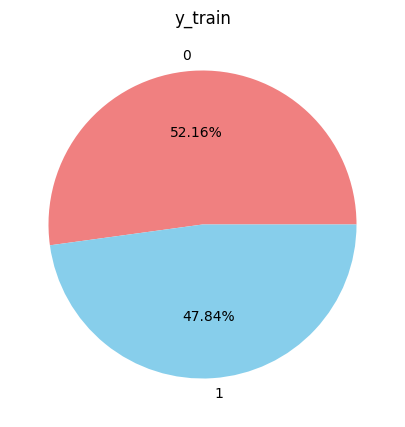

Number of components to preserve 95.0% variance: 481


NameError: name 'RNNModel' is not defined

In [30]:
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import torch

# 初始化 k 折交叉驗證
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# 數據準備
X_train1, y_train1 = InstanceHardnessThreshold().fit_resample(np.array(feature), labels)
print(np.array(X_train1).shape,np.array(y_train1).shape)
plt.figure( figsize=(10,5) )
pd.Series(y_train1).value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'y_train' )  # 圖標題
plt.ylabel( '' )
plt.show()
X = X_train1
y = y_train1

# 訓練和評估
result_f1 = []
result_mcc = []
total_y_true = []
total_y_pred = []
for fold, (train_indices, test_indices) in enumerate(kfold.split(X, y)):
    # 分割數據集
    X_train1, X_test = X[train_indices], X[test_indices]
    y_train1, y_test = y[train_indices], y[test_indices]
    
    # 將訓練集再分為訓練集和驗證集
    X_train1, X_val, y_train1, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42, stratify=y_train1)
    X_train1 = csr_matrix(X_train1).toarray()



    # 假设 X 是您的数据矩阵，形状为 (样本数, 特征数)，例如 (500, 2048)

    # 初始化 PCA，所有主成分
    pca = PCA()

    # PCA
    pca.fit(X_train1)

    # 計算PCA各個主成份的方差解釋率
    explained_variance_ratio = pca.explained_variance_ratio_

    # 累積方差解釋率
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

    # setting the threshold
    threshold = 0.95

    # 找到最小主成分数目
    n_components = np.where(cumulative_explained_variance_ratio >= threshold)[0][0] + 1

    print(f"Number of components to preserve {threshold * 100}% variance: {n_components}")
    
    pca_reduced = PCA(n_components=n_components)
    # 進行 PCA 轉換
    X_train1 = pca_reduced.fit_transform(X_train1)
    X_val1 = pca_reduced.transform(X_val)
    X_test1 = pca_reduced.transform(X_test)

    # 轉換標籤為一維張量
    y_train1 = y_train1.flatten()
    y_val1 = y_val.flatten()
    y_test1 = y_test.flatten()

    # 創建數據加載器
    train_data = torch.utils.data.TensorDataset(torch.Tensor(X_train1), torch.Tensor(y_train1))
    val_data = torch.utils.data.TensorDataset(torch.Tensor(X_val1), torch.Tensor(y_val))
    test_data = torch.utils.data.TensorDataset(torch.Tensor(X_test1), torch.Tensor(y_test))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size =64, shuffle=True, drop_last=True)

    # 實例化模型、損失函數和優化器

    input_size = 2048
    embedding_dim = n_components
    hidden_size = 128
    output_size = 1 #二元分類問題
    num_layers = 2
    model = RNNModel(input_size,embedding_dim, hidden_size, output_size, num_layers).to(dtype=torch.float)

    learning_rate = 0.0005

    l2_lambda = 0.00005
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)

    patience = 50
    counter = 0
    best_val_loss = float('inf')


    n_epochs = 1000


    # Initialize lists to store training and validation loss and F1 score
    train_losses = []
    val_losses = []
    train_f1_scores = []
    train_mcc_scores = []
    val_f1_scores = []
    val_mcc_scores = []

    for epoch in range(n_epochs):
        train_loss,t_f1,t_mcc,tcombined_score,train_mtr =  train(model, optimizer, train_loader)
        val_loss, val_f1, val_mcc, combined_score,mtr = validate(model, val_loader, l2_lambda)
        scheduler.step(val_loss)
        # Append the results to the lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1_scores.append(t_f1)
        train_mcc_scores.append(t_mcc)
        val_f1_scores.append(val_f1)
        val_mcc_scores.append(val_mcc)   
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training F1 score: {:.4f}, Training MCC score: {:.4f}, Training Combine score: {:.4f}'.format(epoch+1, n_epochs, train_loss,t_f1,t_mcc,tcombined_score))
        print(train_mtr)
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation F1 score: {:.4f}, Validation MCC score: {:.4f}, Validation Combine score: {:.4f}'.format(epoch+1, n_epochs,val_loss, val_f1, val_mcc, combined_score))
        print(mtr)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered at epoch {}.".format(epoch+1))
                break





    test_loss, f1,mcc,mtr,y_true,y_pred = test(model, test_loader)
    print('Test Loss: {:.4f}, F1 Score: {:.2f}, MCC: {:.2f}, Combine: {:.2f}'.format(test_loss, f1,mcc,(f1+mcc)/2))
    print(mtr)
    # Plotting the training and validation loss
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the training F1 score
    plt.figure()
    plt.plot(train_f1_scores, label='F1 Score', linestyle='-', marker='o')
    plt.plot(train_mcc_scores, label='MCC Score', linestyle='--', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Training F1 and MCC Scores')
    plt.legend()
    plt.show()

    # Plotting the validation F1 score
    plt.figure()
    plt.plot(val_f1_scores, label='F1 Score', linestyle='-', marker='o')
    plt.plot(val_mcc_scores, label='MCC Score', linestyle='--', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Validation F1 and MCC Scores')
    plt.legend()
    plt.show()

    result_f1.append(f1)
    result_mcc.append(mcc)
    total_y_pred = total_y_pred + y_pred
    total_y_true = total_y_true + y_true

# 計算 k 次
print(result_f1)
print(result_mcc)
model_name = "RNN"
dataset = "MorganFingerPrint"
preprocessing = "PCA"
per_index = performance(per_index,model_name,dataset,preprocessing,total_y_true,total_y_pred)
per_index

In [33]:
pp = pd.read_csv("performance.csv")
pp

,Model,Dataset,Preprocessing,F1 (Toxic),Precision (Toxic),Sensitivity,Specificity,BA,AUC-ROC,AUC-PR,MCC
0,RNN,MorganFingerPrint,PCA,0.942966,0.944505,0.941432,0.948898,0.945165,0.945165,0.917312,0.890444
1,GaussianNB,MorganFingerPrint,PCA,0.650113,0.900000,0.508834,0.947883,0.728358,0.728358,0.693544,0.513234
2,LogisticRegression,MorganFingerPrint,PCA,0.951351,0.970588,0.932862,0.973941,0.953402,0.953402,0.937628,0.908819
3,SVM,MorganFingerPrint,PCA,0.937269,0.980695,0.897527,0.983713,0.940620,0.940620,0.929352,0.887141
4,XGBClassifier,MorganFingerPrint,PCA,0.904505,0.922794,0.886926,0.931596,0.909261,0.909261,0.872687,0.820342
5,RandomForestClassifier,MorganFingerPrint,PCA,0.933810,0.945652,0.922261,0.951140,0.936701,0.936701,0.909427,0.874494
6,LGBMClassifier,MorganFingerPrint,PCA,0.920290,0.944238,0.897527,0.951140,0.924333,0.924333,0.896631,0.851277
7,MLPClassifier,MorganFingerPrint,PCA,0.947368,0.973881,0.922261,0.977199,0.949730,0.949730,0.935461,0.902504
8,CatBoostClassifier,MorganFingerPrint,PCA,0.923358,0.954717,0.893993,0.960912,0.927452,0.927452,0.904358,0.858649
9,GaussianNB,Mordred descriptors,RandomForest Selector,0.537477,0.554717,0.521277,0.583039,0.552158,0.552158,0.528099,0.104516


In [31]:
per_index

,Model,Dataset,Preprocessing,F1 (Toxic),Precision (Toxic),Sensitivity,Specificity,BA,AUC-ROC,AUC-PR,MCC
0,GaussianNB,MorganFingerPrint,PCA,0.605791,0.819277,0.480565,0.902597,0.691581,0.691581,0.642447,0.425896
1,LogisticRegression,MorganFingerPrint,PCA,0.949275,0.973978,0.925795,0.977273,0.951534,0.951534,0.937237,0.905910
2,SVM,MorganFingerPrint,PCA,0.948718,0.984791,0.915194,0.987013,0.951104,0.951104,0.941884,0.906902
3,XGBClassifier,MorganFingerPrint,PCA,0.883636,0.910112,0.858657,0.922078,0.890368,0.890368,0.849156,0.783690
4,RandomForestClassifier,MorganFingerPrint,PCA,0.925000,0.935018,0.915194,0.941558,0.928376,0.928376,0.896332,0.857668
5,LGBMClassifier,MorganFingerPrint,PCA,0.923358,0.954717,0.893993,0.961039,0.927516,0.927516,0.904272,0.858854
6,MLPClassifier,MorganFingerPrint,PCA,0.932605,0.962406,0.904594,0.967532,0.936063,0.936063,0.916272,0.875720
7,CatBoostClassifier,MorganFingerPrint,PCA,0.905730,0.949612,0.865724,0.957792,0.911758,0.911758,0.886400,0.829486


'PCA'